In [12]:
from PIL import Image
from IPython.display import display
import pybullet as p
import time
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def show():
    width = 500
    height = 500
    img_arr = p.getCameraImage(
    width,
    height,
    viewMatrix=p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0, 0, 0],
        distance=1.5,
        yaw=180,
        pitch=-10,
        roll=0,
        upAxisIndex=2,
    ),
    projectionMatrix=p.computeProjectionMatrixFOV(
        fov=60,
        aspect=width/height,
        nearVal=0.01,
        farVal=100,
    ),
    shadow=True,
    lightDirection=[1, 1, 1],
)

    width, height, rgba, depth, mask = img_arr
    print(f"rgba shape={rgba.shape}, dtype={rgba.dtype}")
    display(Image.fromarray(rgba, 'RGBA'))

In [14]:
class ServoMotor(object):    
    def __init__(self , bodyObj , motorIndex):
        self.bodyObj = bodyObj
        self.motorIndex=motorIndex

    def moveMotorToAngle(self, servo_angle):
        p.setJointMotorControlArray(bodyUniqueId=self.bodyObj,
                            jointIndices=[self.motorIndex ],
                            controlMode=p.POSITION_CONTROL,
                            targetPositions=[servo_angle ],
                            targetVelocities=np.zeros(1),
                            forces=np.ones(1) * 0.15)
        for i in range(150):
            p.stepSimulation()

    def getCurrentAngle(self):
        state=p.getJointState(self.bodyObj , self.motorIndex)[0]
        
        if(state > 0.5 and state < 2.5):
            return 0
        elif state >= -1.7 and state < -1.3:
            return 180
        elif state > -0.7 and state < -0.3  :
            return 90


In [15]:
servo_0degrees=1.2
servo_90degrees=-0.5
servo_180degrees=-1.57

degrees_dict={0 : 1.2 , 90 : -0.5 , 180 : -1.57}

servo1_index=2
servo2_index=3

class CrawlerRobot(object):
    states_dict={"0,0" :0 ,  "0,90":1 , "0,180":2 , "90,0" :3,
              "90,90":4 ,  "90,180" : 5, "180,0" :6, "180,90":7 , "180,180":8 , 0: "0,0",
 1: "0,90",
 2: "0,180",
 3: "90,0",
 4: "90,90",
 5: "90,180",
 6: "180,0",
 7: "180,90",
 8: "180,180"}
    
    def __init__(self):        
        physicsClient = p.connect(p.GUI)#or p.DIRECT for non-graphical version
        p.resetSimulation()
        p.setAdditionalSearchPath(pybullet_data.getDataPath()) #optionally
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,0]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        self.boxId = p.loadURDF("C://Users/antoz//Crawler//Assem1.SLDASM//urdf//Assem1.SLDASM.urdf" 
                               , startPos , startOrientation)
        for i in range(1000):
            p.stepSimulation()
        self.servo1=ServoMotor(self.boxId , servo1_index)
        self.servo2=ServoMotor(self.boxId , servo2_index)
        
        self.servo1.moveMotorToAngle(servo_0degrees)
        self.servo2.moveMotorToAngle(servo_0degrees)
        
    def getPosition(self):
        return p.getBasePositionAndOrientation(self.boxId)[0]
    
    def moveToInitialPosition(self):
        self.servo1.moveMotorToAngle(servo_0degrees)
        self.servo2.moveMotorToAngle(servo_0degrees)
        
    def getCurrentStateIndex(self):
        return self.states_dict[str(self.servo1.getCurrentAngle()) + "," + 
                           str(self.servo2.getCurrentAngle())]
    
    def takeActionFromString(self,stringAngles):
        self.servo1.moveMotorToAngle(degrees_dict[int(stringAngles.split(',')[0])])
        self.servo2.moveMotorToAngle(degrees_dict[int(stringAngles.split(',')[1])])
        
    def resetEnvironment(self):
        p.resetSimulation()
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,1]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        self.boxId = p.loadURDF("C://Users/antoz//Crawler//Assem1.SLDASM//urdf//Assem1.SLDASM.urdf" 
                               , startPos , startOrientation)
        for i in range(100):
            p.stepSimulation()
            
        self.servo1=ServoMotor(self.boxId , servo1_index)
        self.servo2=ServoMotor(self.boxId , servo2_index)
        
        self.servo1.moveMotorToAngle(servo_0degrees)
        self.servo2.moveMotorToAngle(servo_0degrees)
        return 0
    def calculateReward(self,current_position , new_position):
        reward=new_position-current_position
        return reward
    def step(self , actionIndex):
        show()
        current_position=self.getPosition()[1]
        angles_string = self.states_dict[actionIndex]
        self.takeActionFromString(angles_string)
        new_state=self.getCurrentStateIndex()
        new_position=self.getPosition()[1]
        reward=self.calculateReward(current_position , new_position)
        return (new_state,reward)


In [16]:
try :
    p.disconnect()
except : pass
myRobot=CrawlerRobot()

In [17]:
lr=0.8
discount_rate=0.9
epsilon=0.7

In [18]:
def init_q(n_states , n_actions):
    Q=np.zeros((n_states,n_actions))
    return Q

In [19]:
def epsilon_greedy(Q, epsilon, n_actions, s):
    if  np.random.rand() < epsilon:
        action = np.argmax(Q[s, :])
    else:
        action = np.random.randint(0, 9)
    return action

rgba shape=(500, 500, 4), dtype=uint8


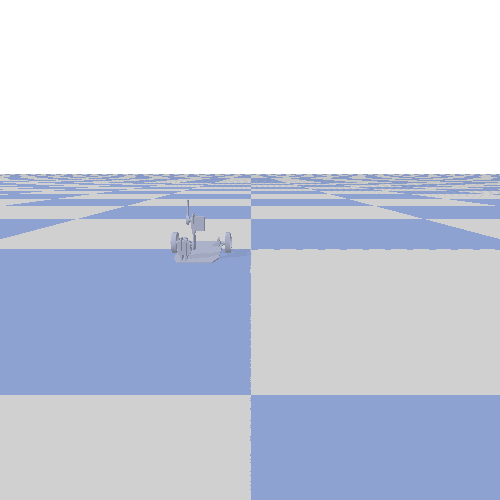

rgba shape=(500, 500, 4), dtype=uint8


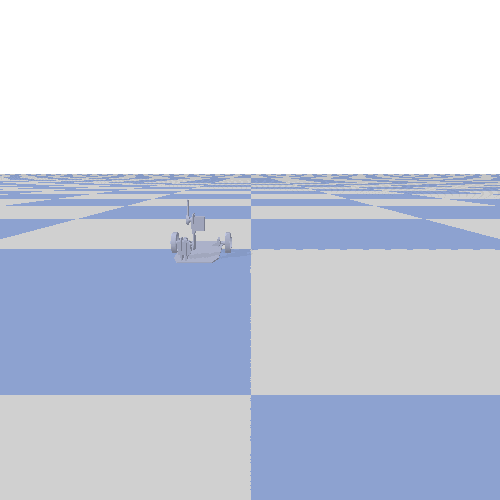

rgba shape=(500, 500, 4), dtype=uint8


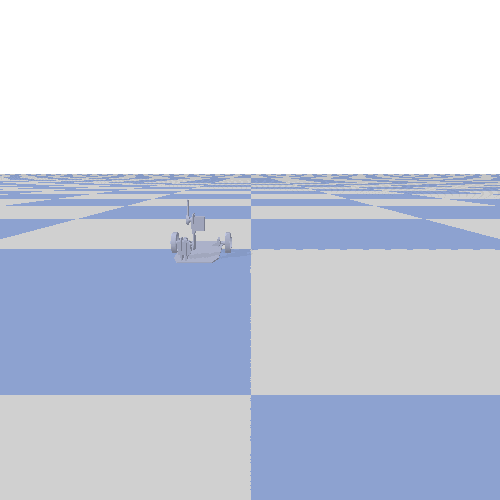

rgba shape=(500, 500, 4), dtype=uint8


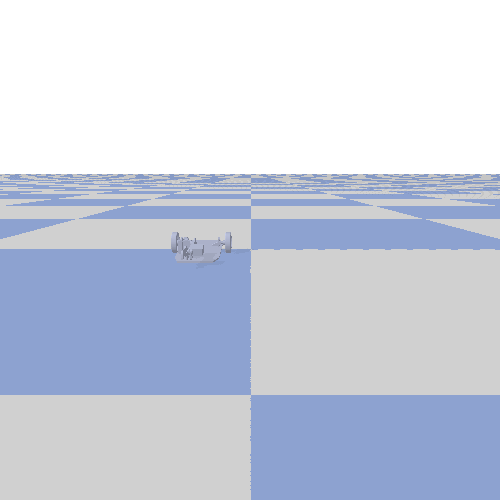

rgba shape=(500, 500, 4), dtype=uint8


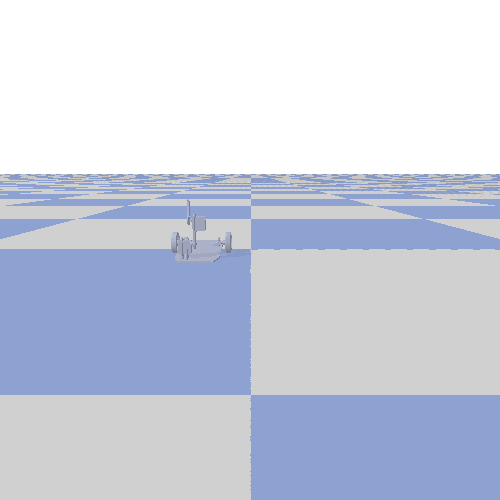

rgba shape=(500, 500, 4), dtype=uint8


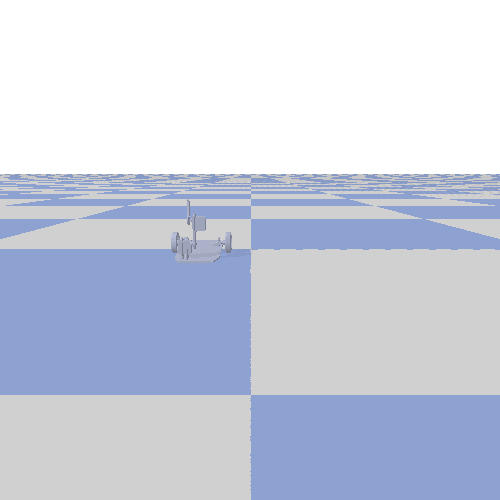

rgba shape=(500, 500, 4), dtype=uint8


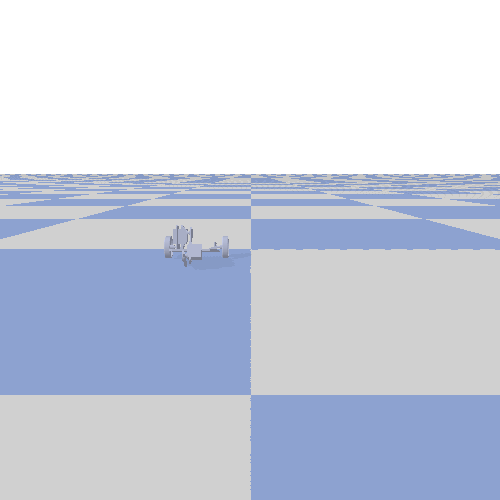

rgba shape=(500, 500, 4), dtype=uint8


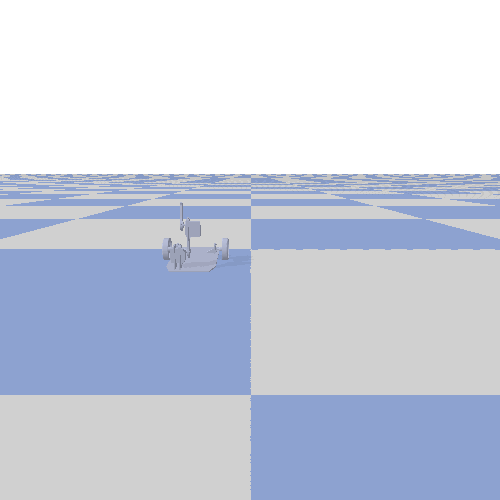

rgba shape=(500, 500, 4), dtype=uint8


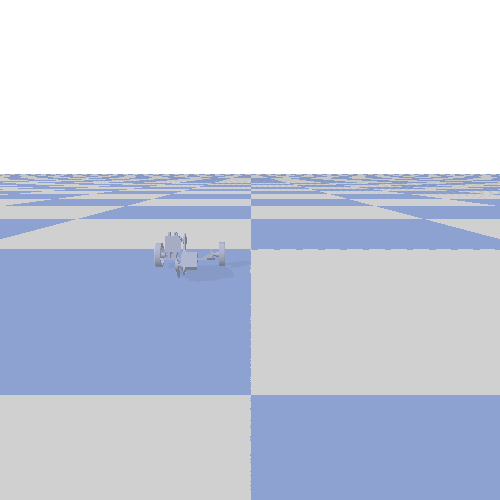

rgba shape=(500, 500, 4), dtype=uint8


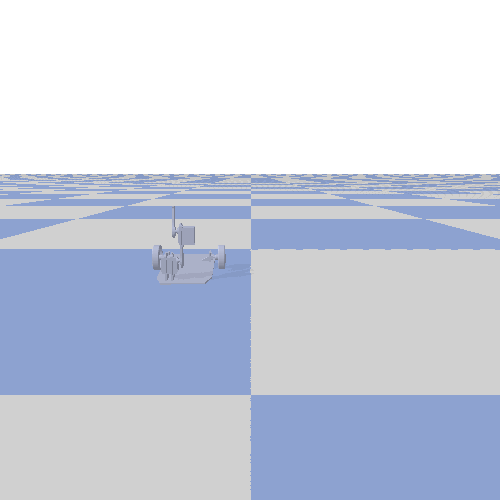

rgba shape=(500, 500, 4), dtype=uint8


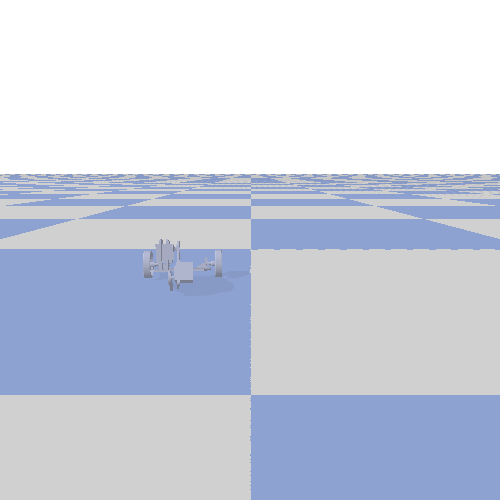

rgba shape=(500, 500, 4), dtype=uint8


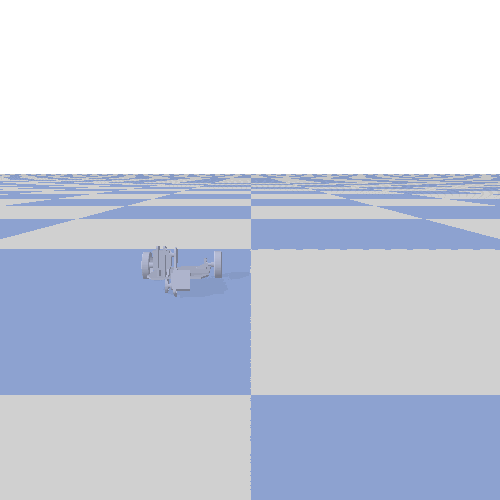

rgba shape=(500, 500, 4), dtype=uint8


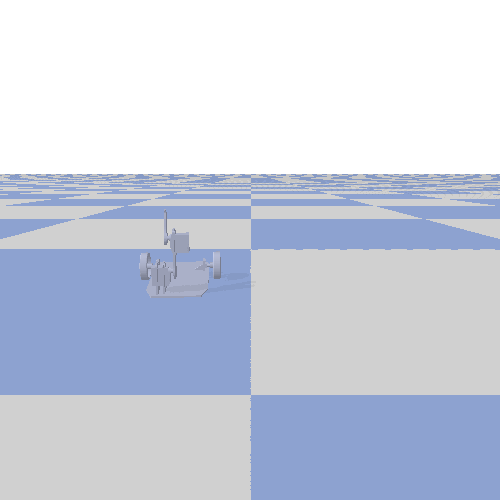

rgba shape=(500, 500, 4), dtype=uint8


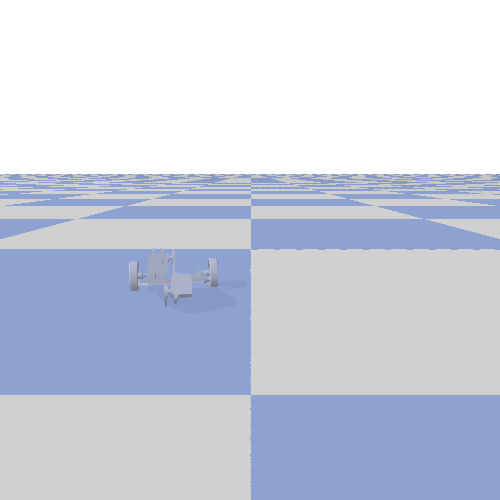

rgba shape=(500, 500, 4), dtype=uint8


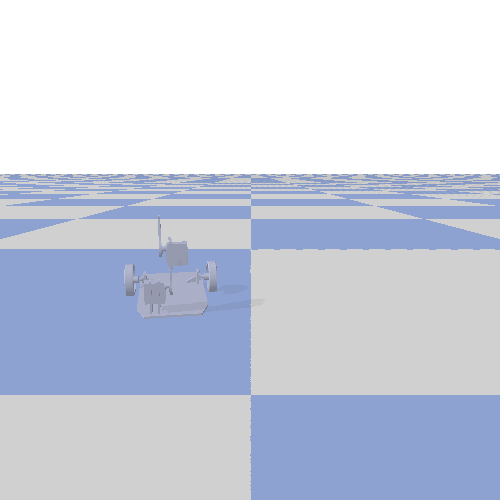

rgba shape=(500, 500, 4), dtype=uint8


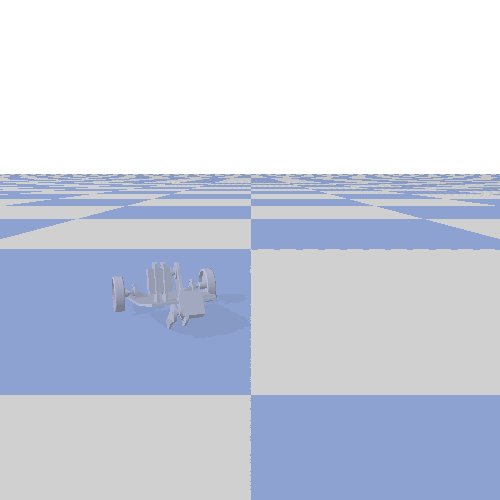

rgba shape=(500, 500, 4), dtype=uint8


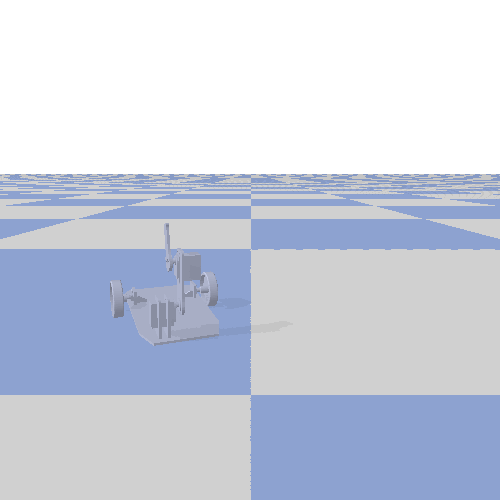

rgba shape=(500, 500, 4), dtype=uint8


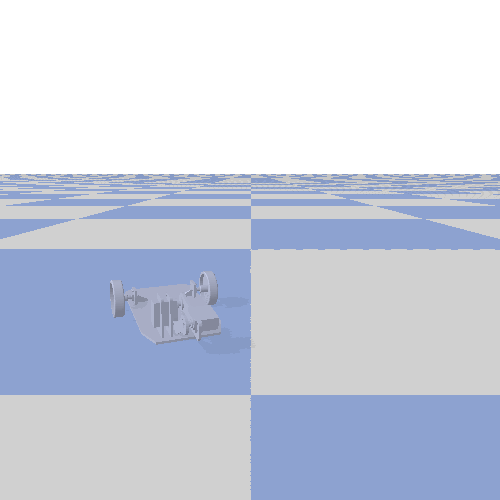

rgba shape=(500, 500, 4), dtype=uint8


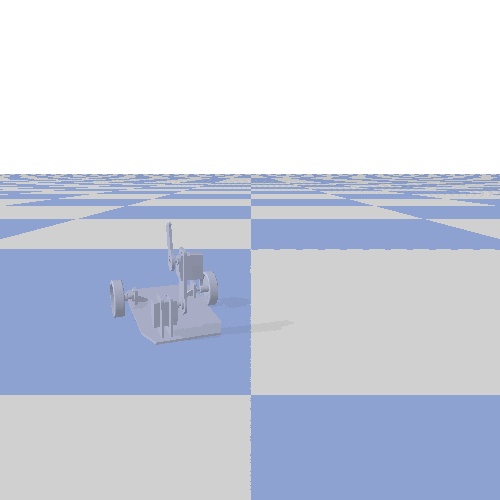

rgba shape=(500, 500, 4), dtype=uint8


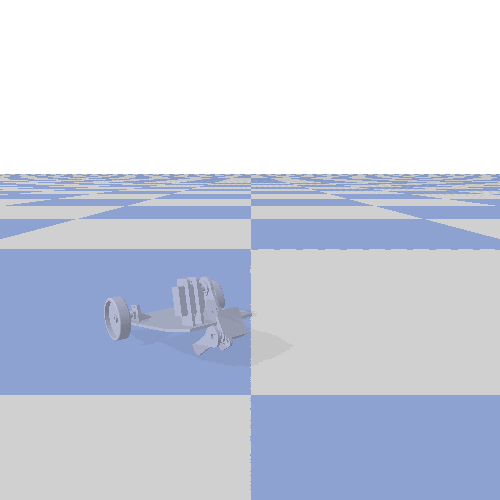

rgba shape=(500, 500, 4), dtype=uint8


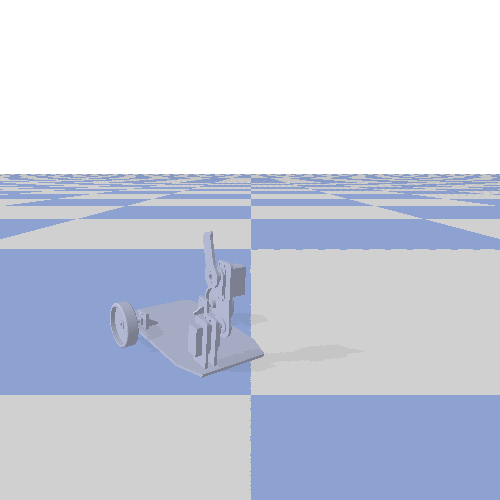

rgba shape=(500, 500, 4), dtype=uint8


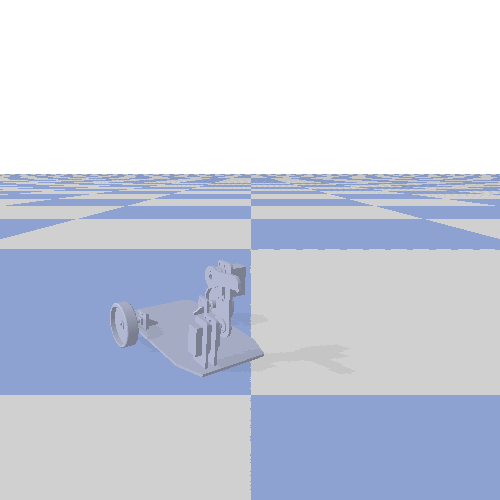

rgba shape=(500, 500, 4), dtype=uint8


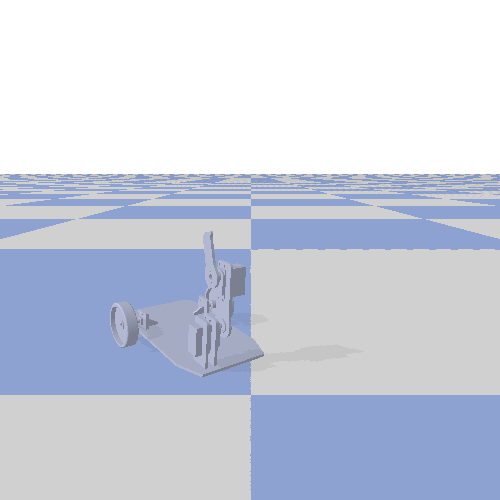

rgba shape=(500, 500, 4), dtype=uint8


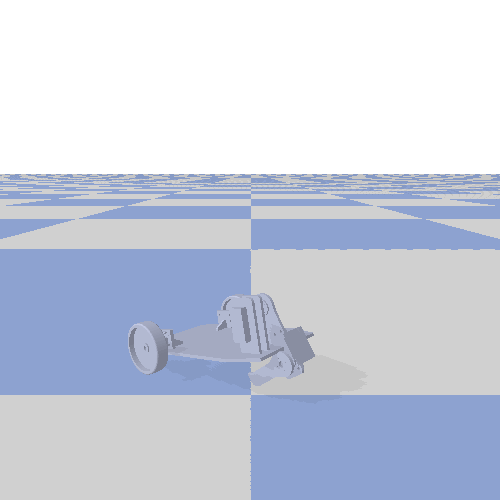

rgba shape=(500, 500, 4), dtype=uint8


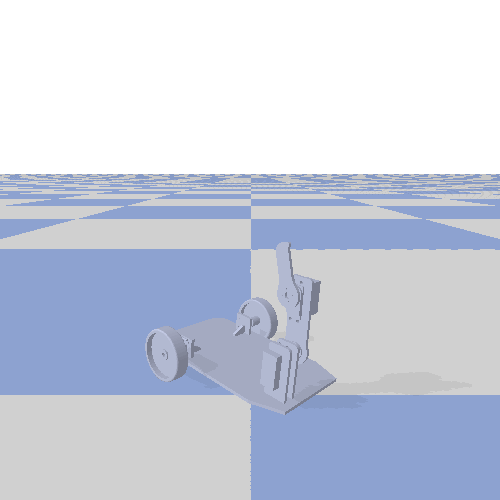

rgba shape=(500, 500, 4), dtype=uint8


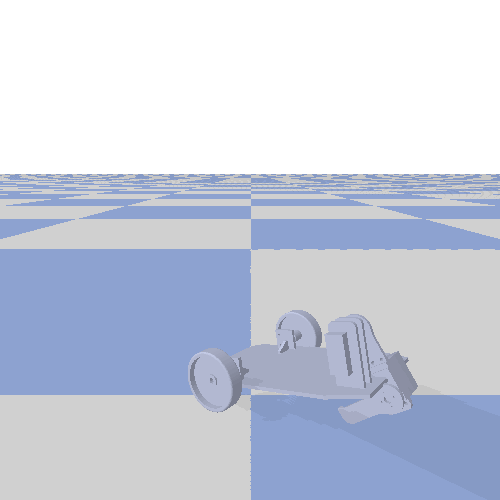

rgba shape=(500, 500, 4), dtype=uint8


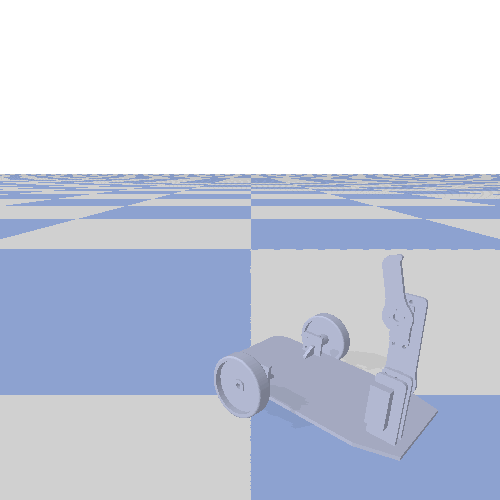

rgba shape=(500, 500, 4), dtype=uint8


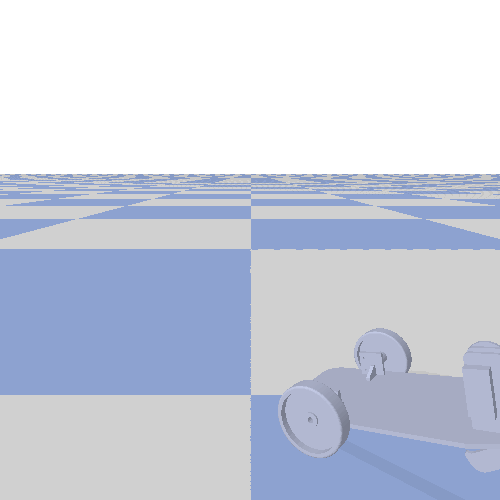

rgba shape=(500, 500, 4), dtype=uint8


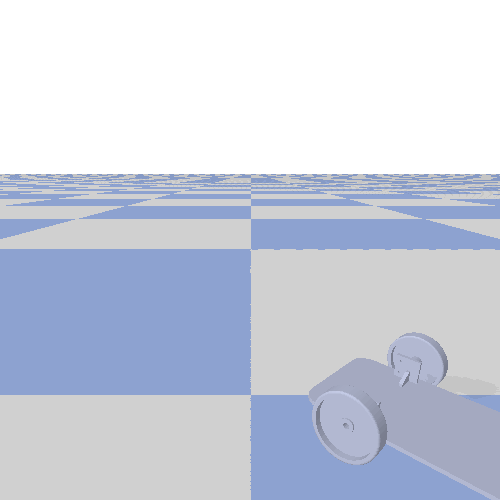

rgba shape=(500, 500, 4), dtype=uint8


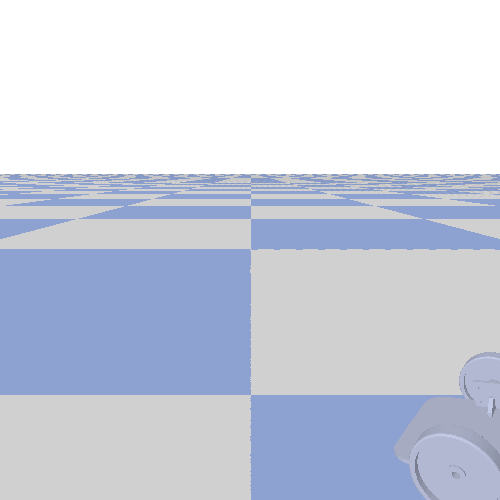

rgba shape=(500, 500, 4), dtype=uint8


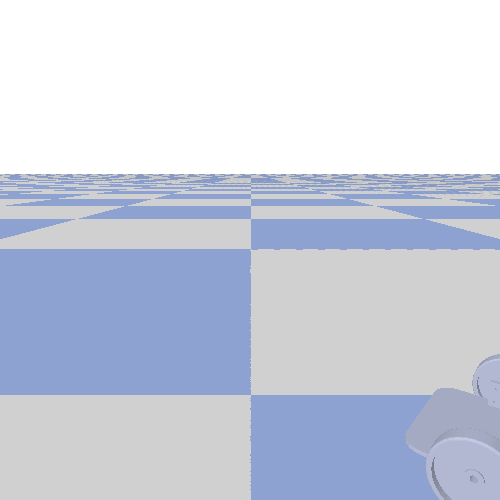

rgba shape=(500, 500, 4), dtype=uint8


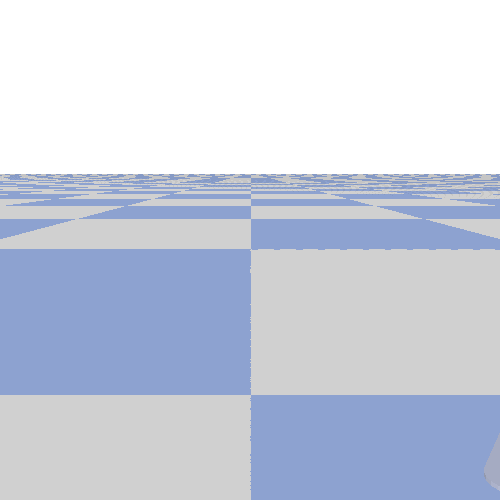

rgba shape=(500, 500, 4), dtype=uint8


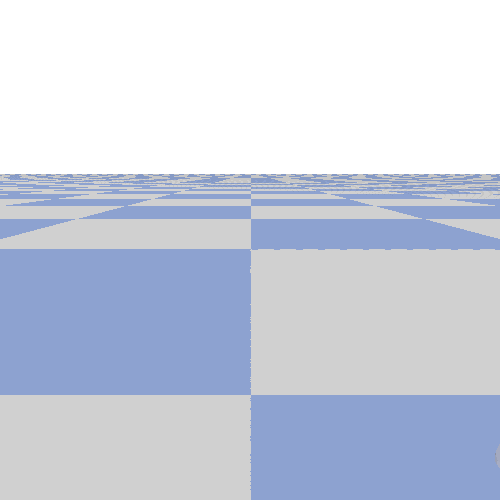

rgba shape=(500, 500, 4), dtype=uint8


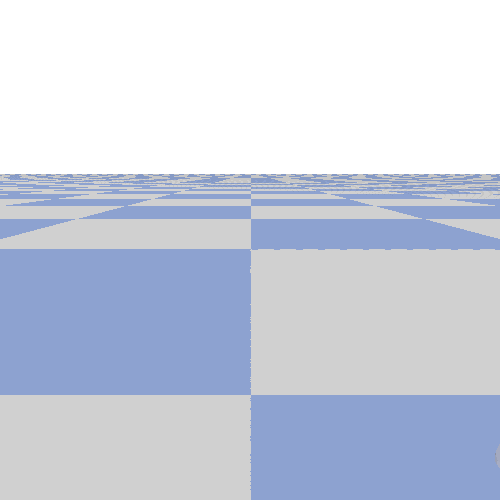

rgba shape=(500, 500, 4), dtype=uint8


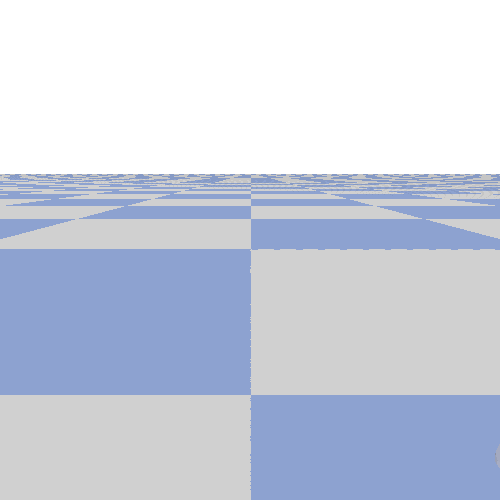

rgba shape=(500, 500, 4), dtype=uint8


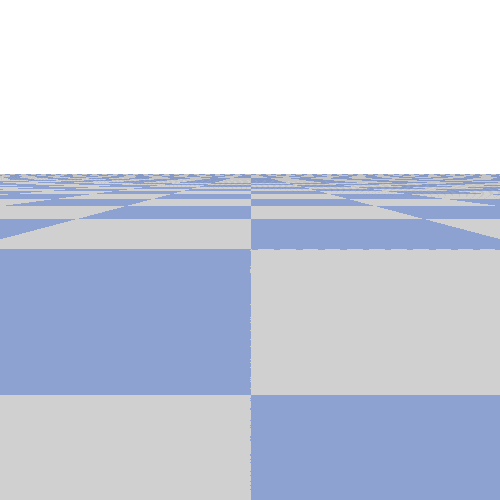

rgba shape=(500, 500, 4), dtype=uint8


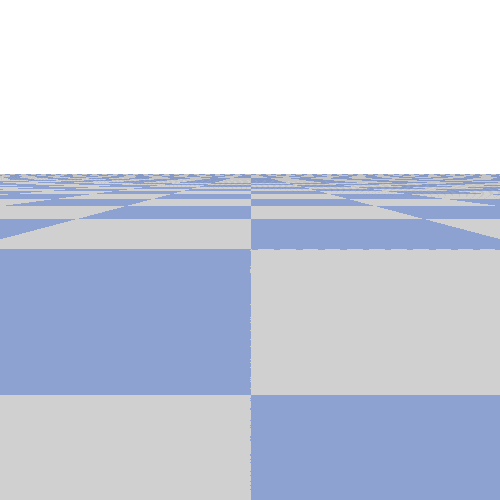

rgba shape=(500, 500, 4), dtype=uint8


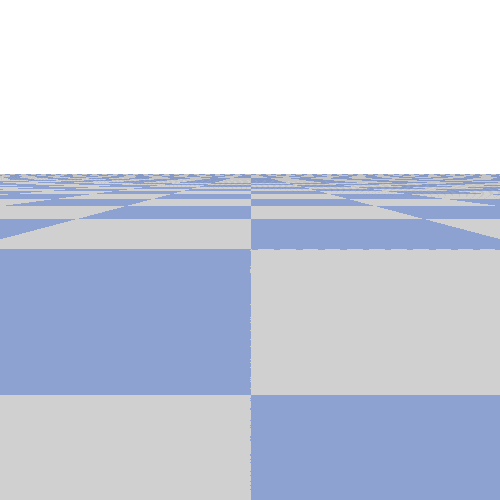

rgba shape=(500, 500, 4), dtype=uint8


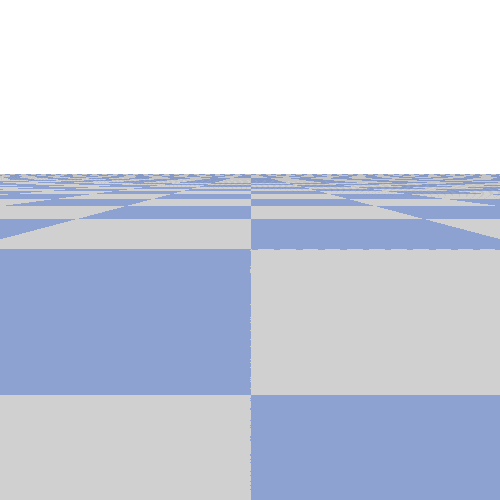

rgba shape=(500, 500, 4), dtype=uint8


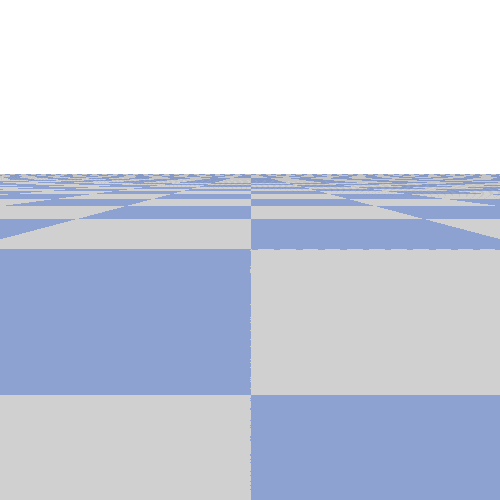

rgba shape=(500, 500, 4), dtype=uint8


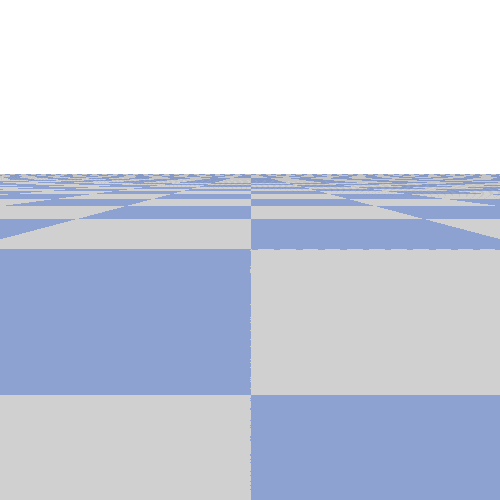

rgba shape=(500, 500, 4), dtype=uint8


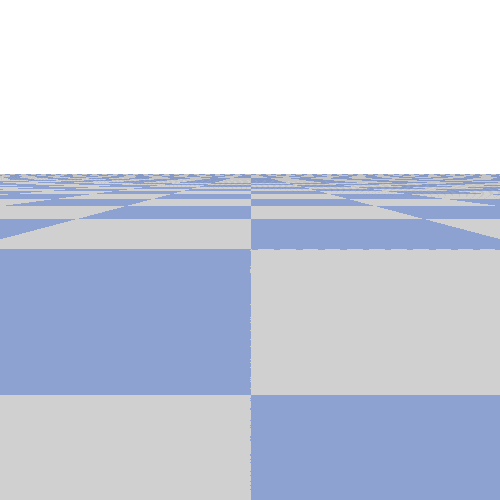

rgba shape=(500, 500, 4), dtype=uint8


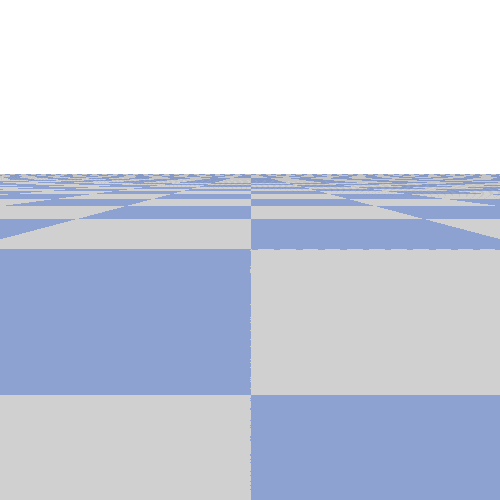

rgba shape=(500, 500, 4), dtype=uint8


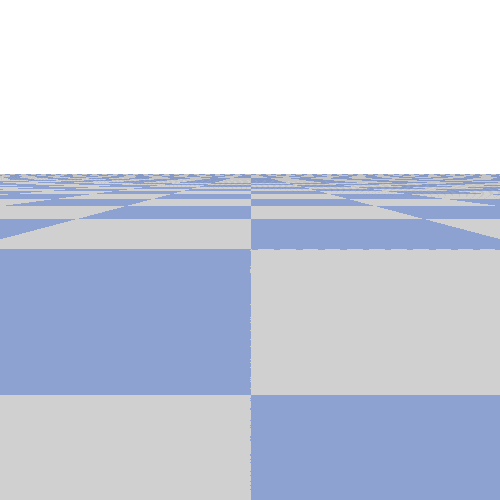

rgba shape=(500, 500, 4), dtype=uint8


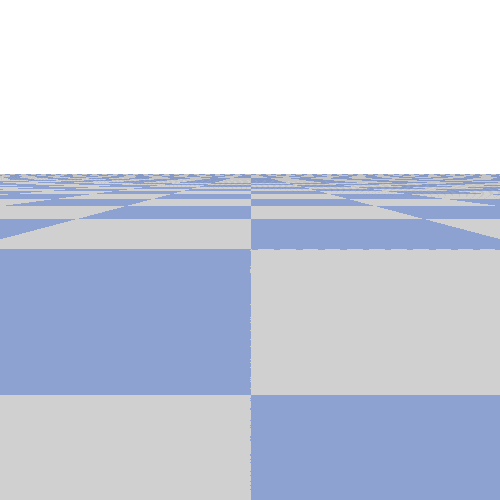

rgba shape=(500, 500, 4), dtype=uint8


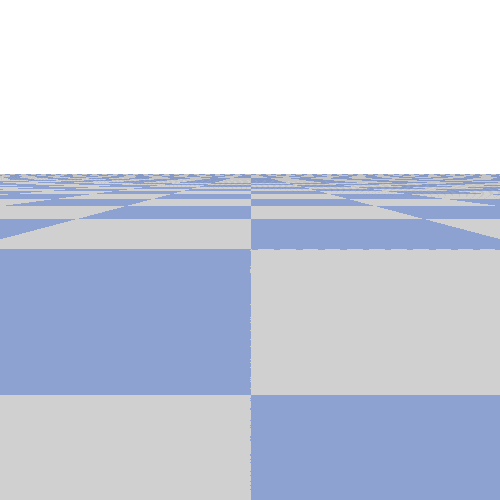

rgba shape=(500, 500, 4), dtype=uint8


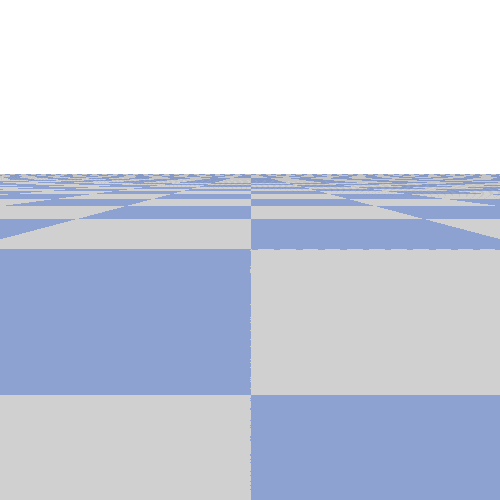

fail
rgba shape=(500, 500, 4), dtype=uint8


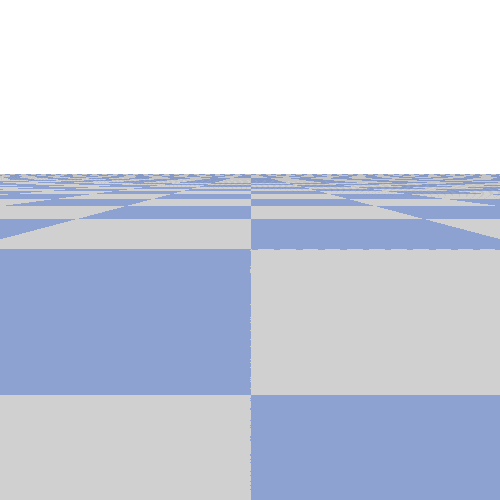

rgba shape=(500, 500, 4), dtype=uint8


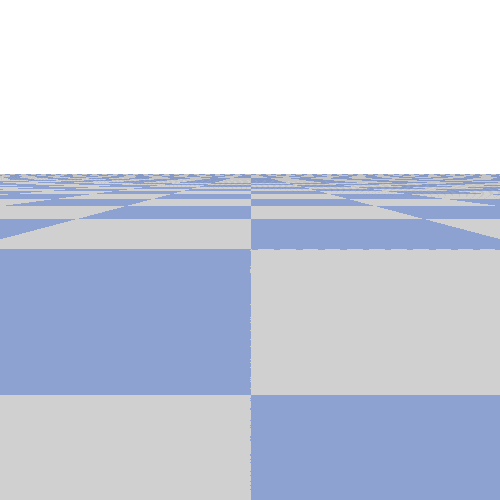

fail
rgba shape=(500, 500, 4), dtype=uint8


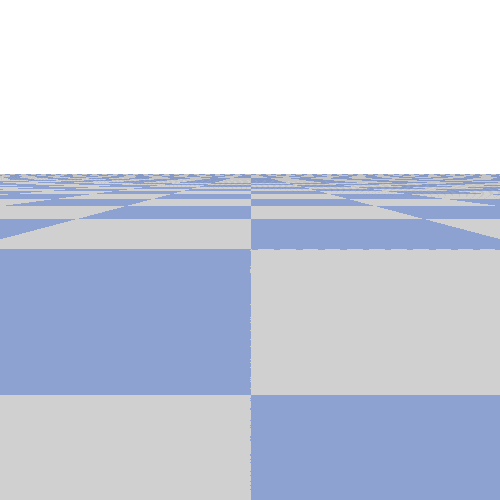

rgba shape=(500, 500, 4), dtype=uint8


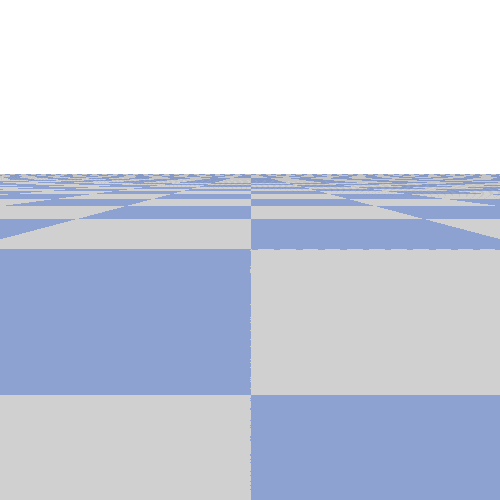

fail
rgba shape=(500, 500, 4), dtype=uint8


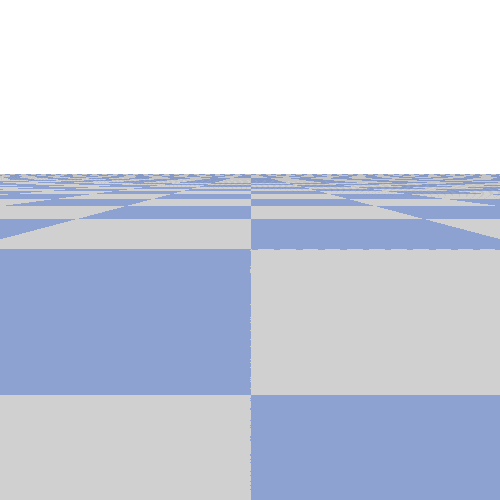

rgba shape=(500, 500, 4), dtype=uint8


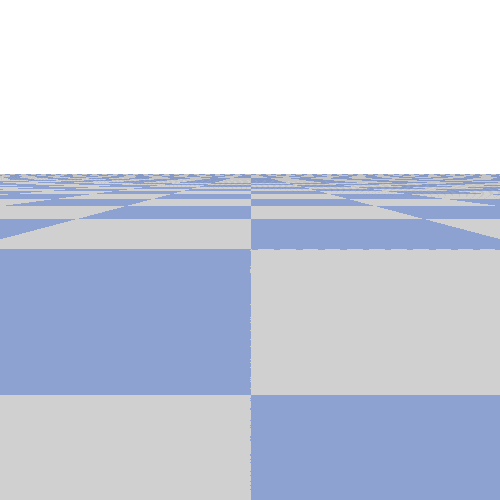

rgba shape=(500, 500, 4), dtype=uint8


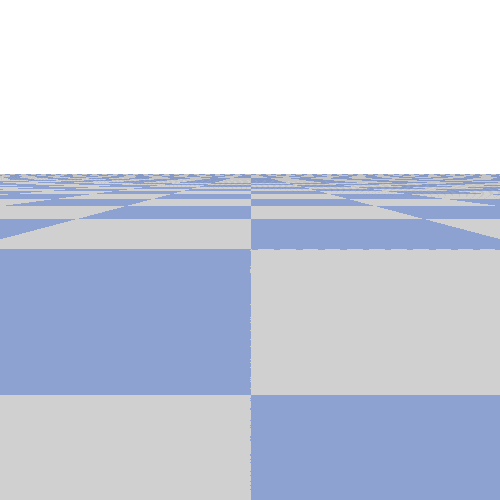

rgba shape=(500, 500, 4), dtype=uint8


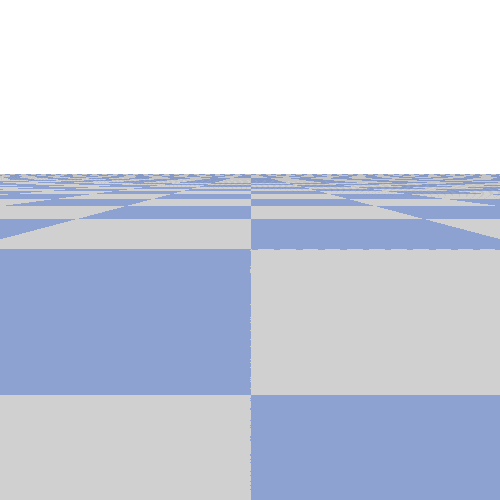

rgba shape=(500, 500, 4), dtype=uint8


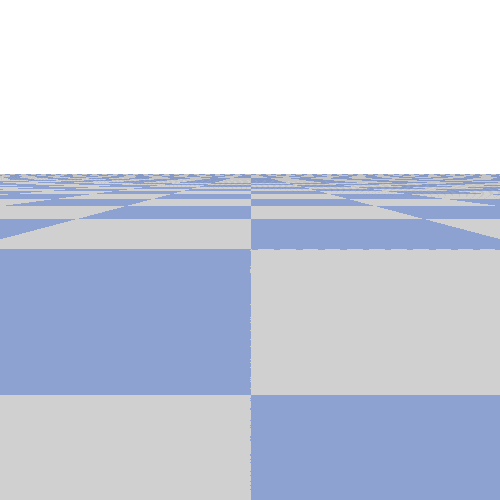

rgba shape=(500, 500, 4), dtype=uint8


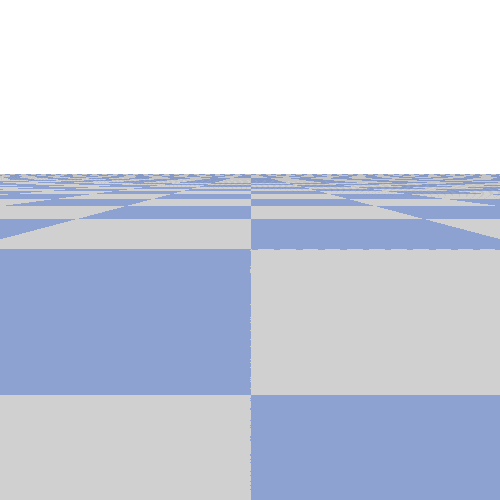

rgba shape=(500, 500, 4), dtype=uint8


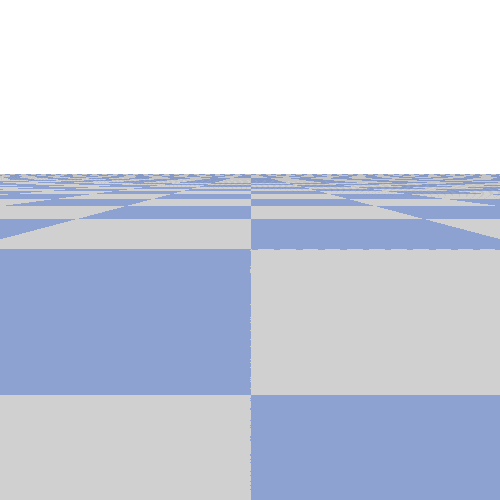

rgba shape=(500, 500, 4), dtype=uint8


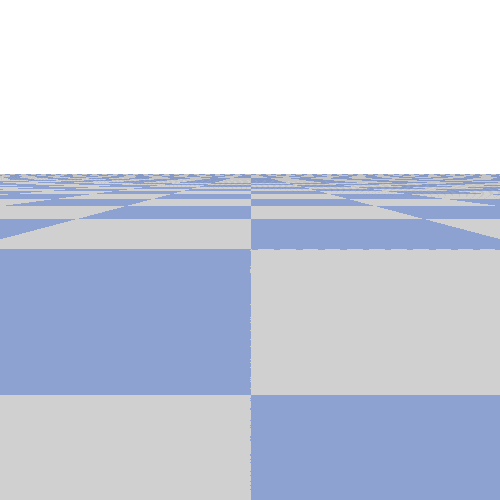

rgba shape=(500, 500, 4), dtype=uint8


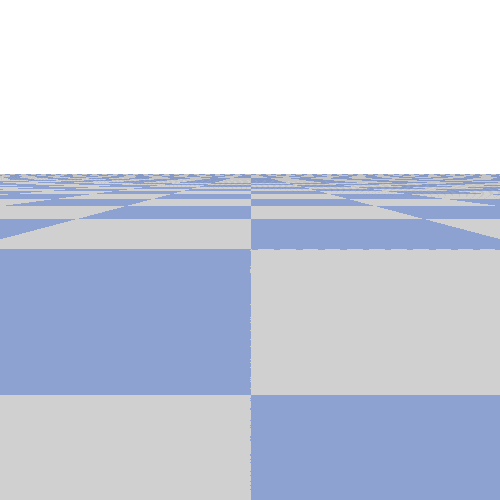

rgba shape=(500, 500, 4), dtype=uint8


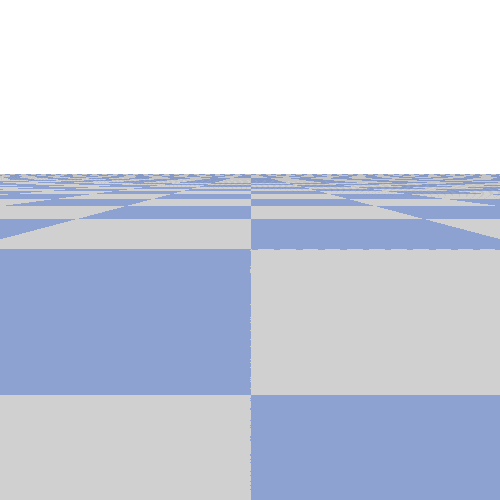

fail
rgba shape=(500, 500, 4), dtype=uint8


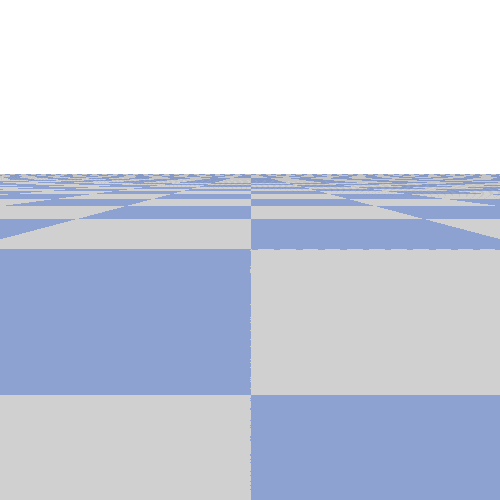

rgba shape=(500, 500, 4), dtype=uint8


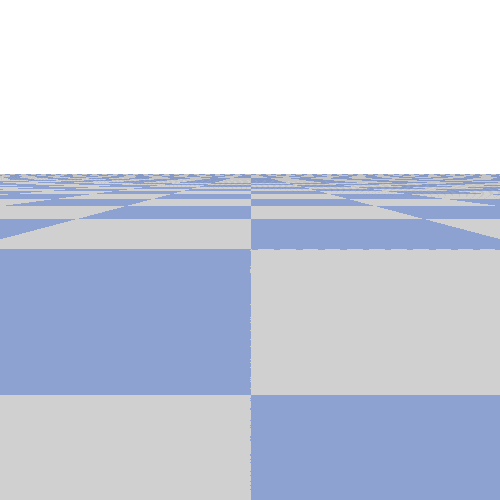

rgba shape=(500, 500, 4), dtype=uint8


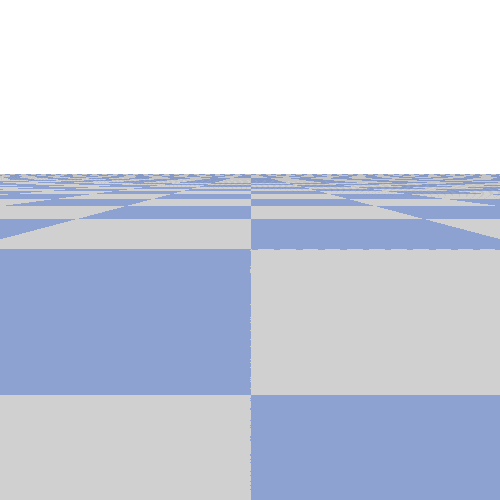

rgba shape=(500, 500, 4), dtype=uint8


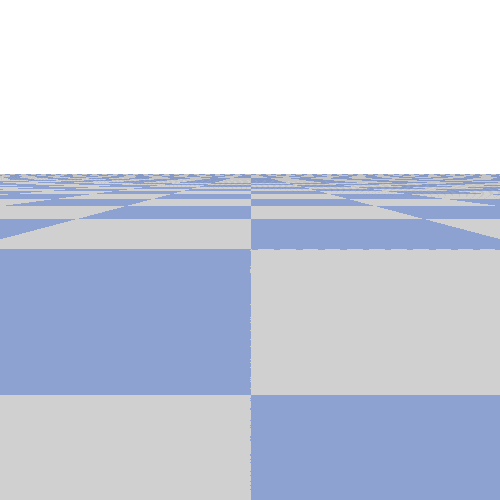

rgba shape=(500, 500, 4), dtype=uint8


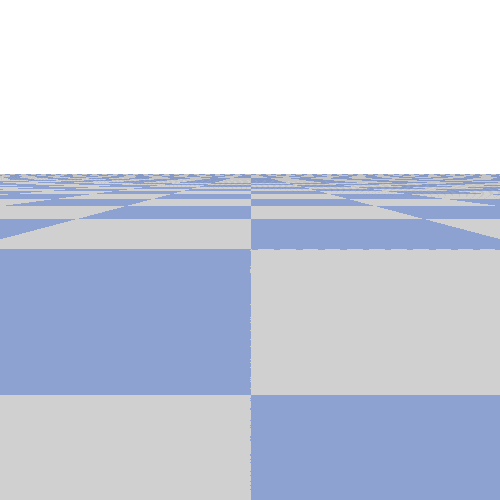

rgba shape=(500, 500, 4), dtype=uint8


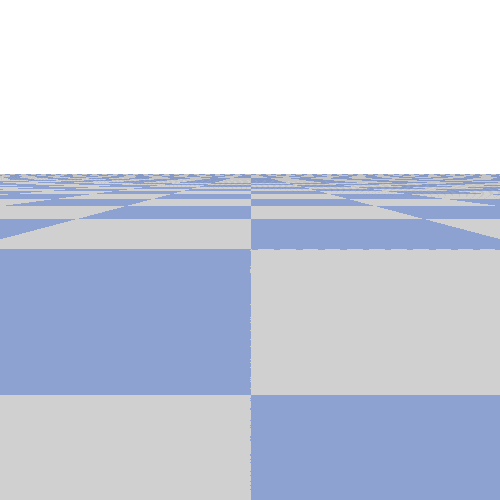

rgba shape=(500, 500, 4), dtype=uint8


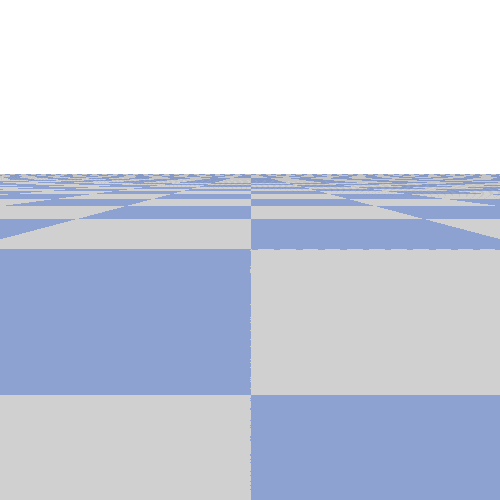

rgba shape=(500, 500, 4), dtype=uint8


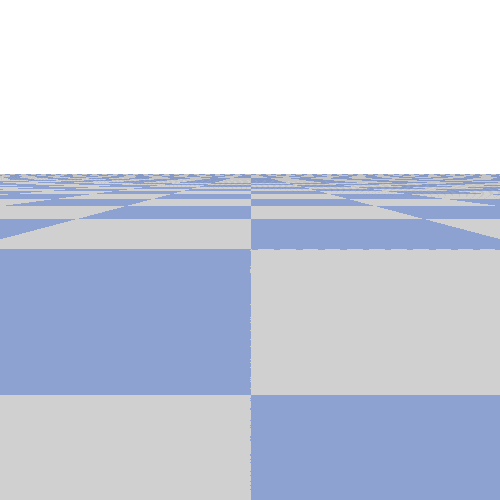

rgba shape=(500, 500, 4), dtype=uint8


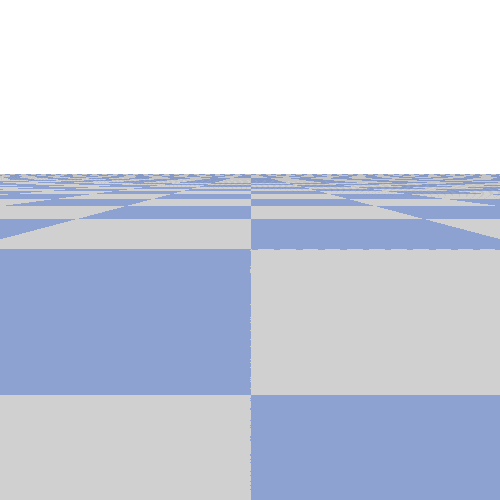

rgba shape=(500, 500, 4), dtype=uint8


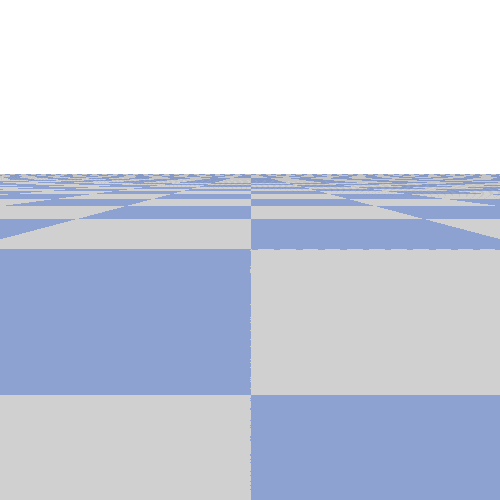

rgba shape=(500, 500, 4), dtype=uint8


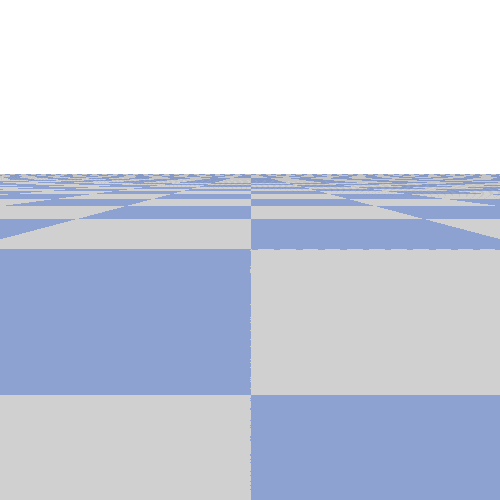

rgba shape=(500, 500, 4), dtype=uint8


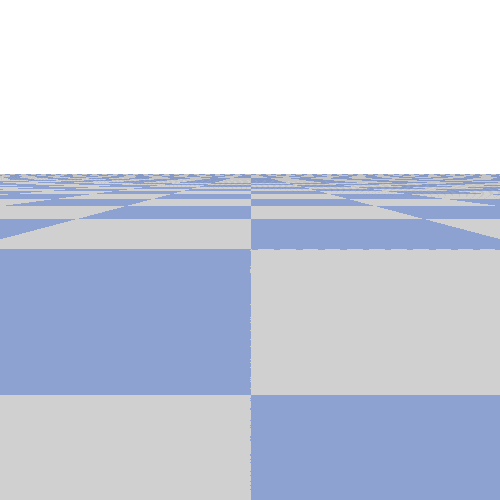

rgba shape=(500, 500, 4), dtype=uint8


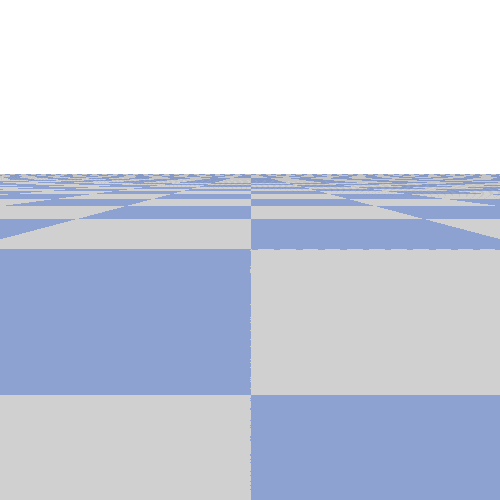

rgba shape=(500, 500, 4), dtype=uint8


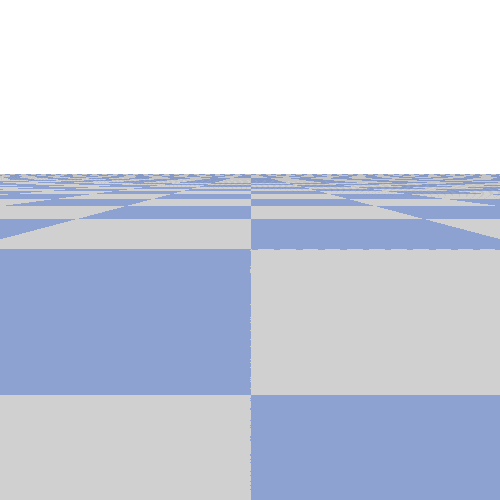

rgba shape=(500, 500, 4), dtype=uint8


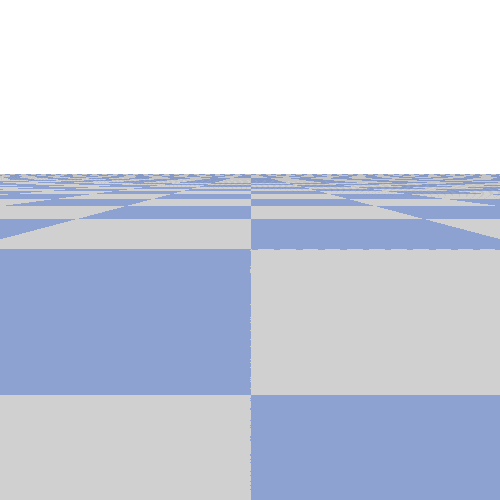

rgba shape=(500, 500, 4), dtype=uint8


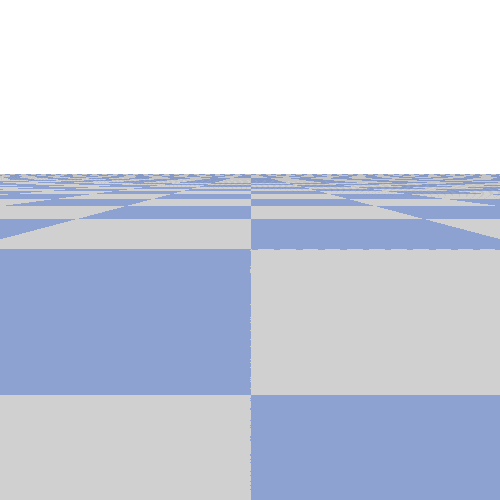

rgba shape=(500, 500, 4), dtype=uint8


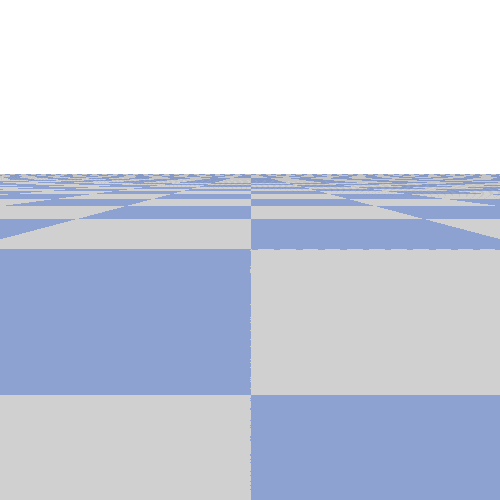

rgba shape=(500, 500, 4), dtype=uint8


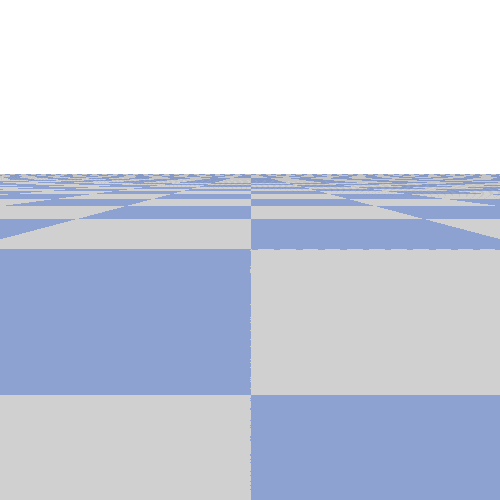

rgba shape=(500, 500, 4), dtype=uint8


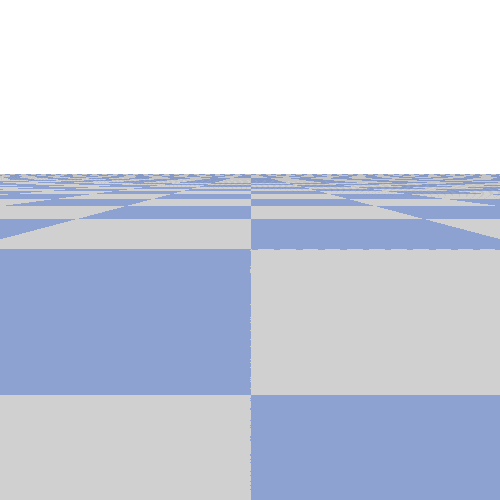

rgba shape=(500, 500, 4), dtype=uint8


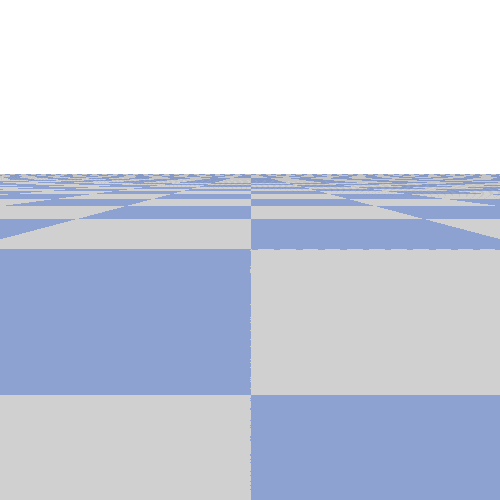

fail
rgba shape=(500, 500, 4), dtype=uint8


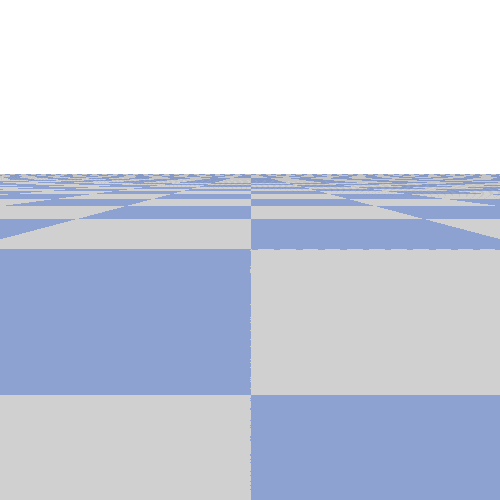

rgba shape=(500, 500, 4), dtype=uint8


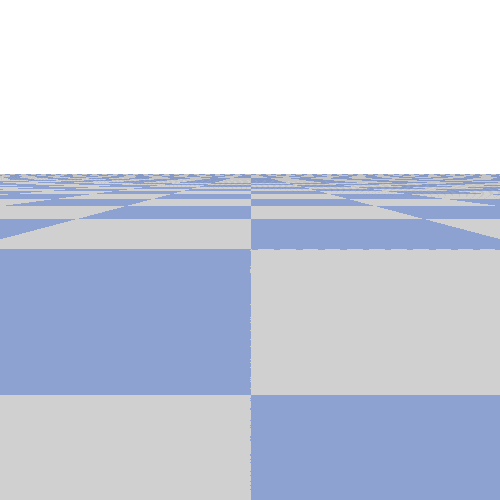

rgba shape=(500, 500, 4), dtype=uint8


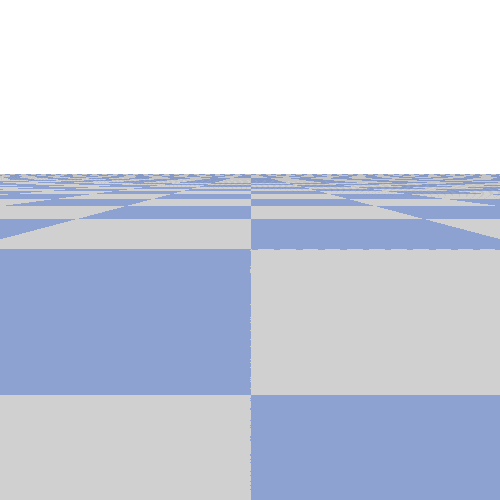

rgba shape=(500, 500, 4), dtype=uint8


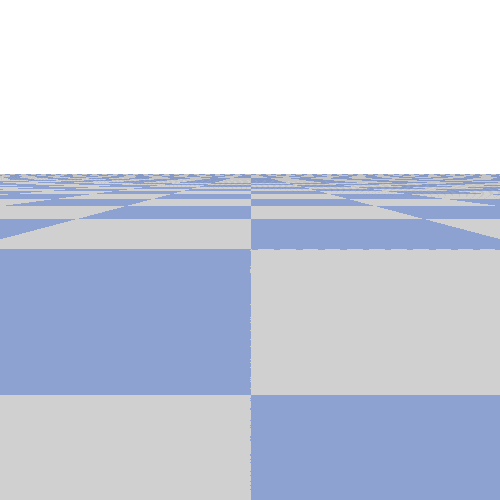

rgba shape=(500, 500, 4), dtype=uint8


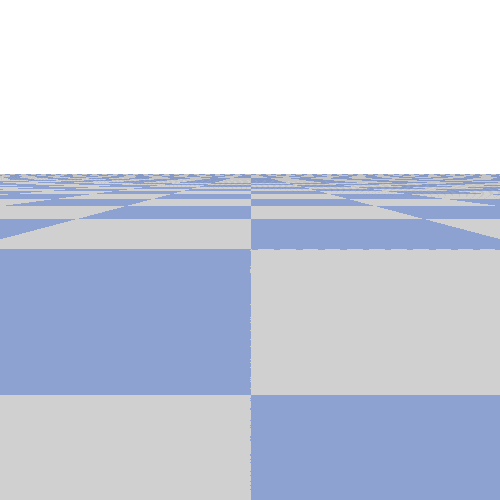

rgba shape=(500, 500, 4), dtype=uint8


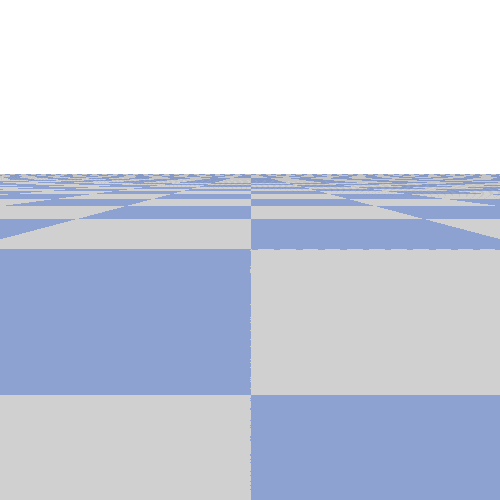

rgba shape=(500, 500, 4), dtype=uint8


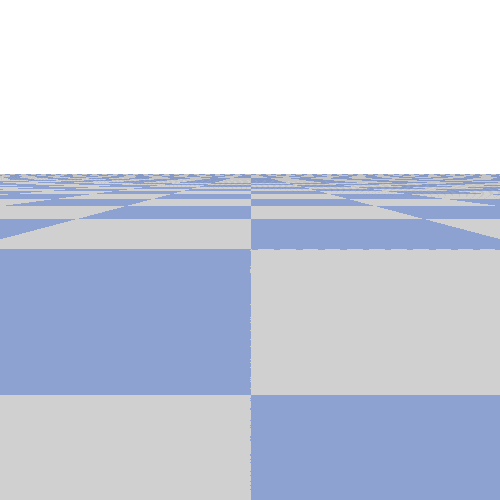

rgba shape=(500, 500, 4), dtype=uint8


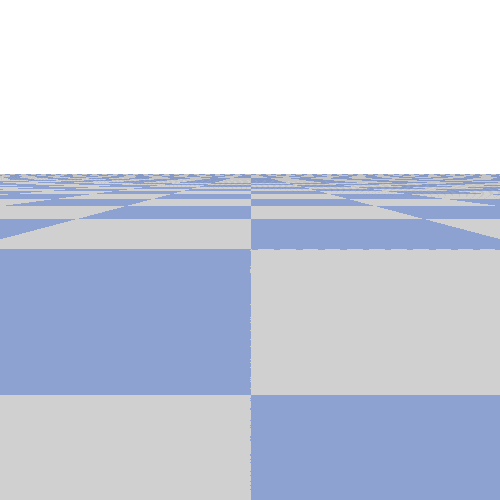

rgba shape=(500, 500, 4), dtype=uint8


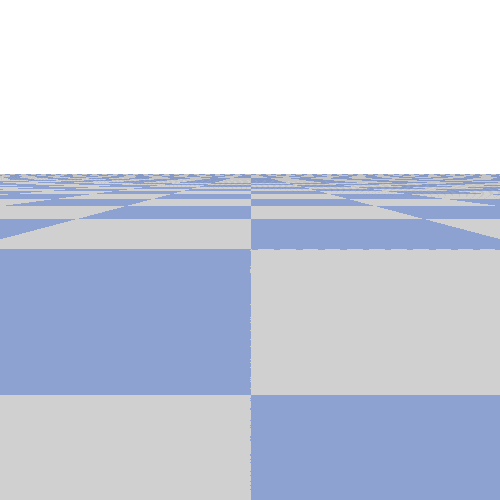

rgba shape=(500, 500, 4), dtype=uint8


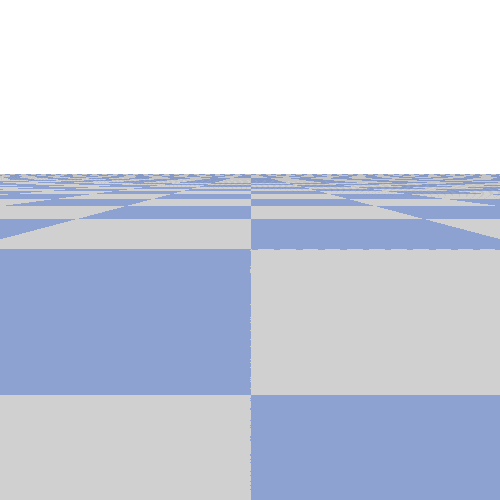

rgba shape=(500, 500, 4), dtype=uint8


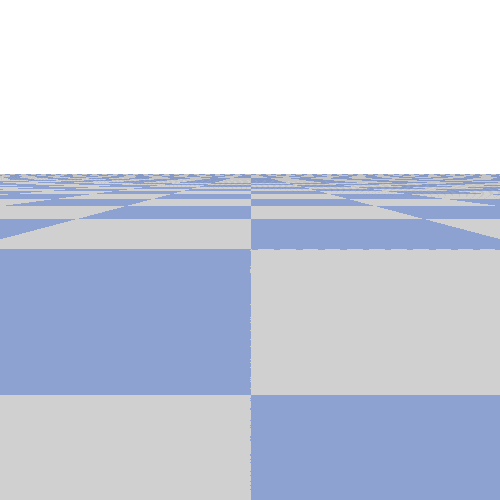

rgba shape=(500, 500, 4), dtype=uint8


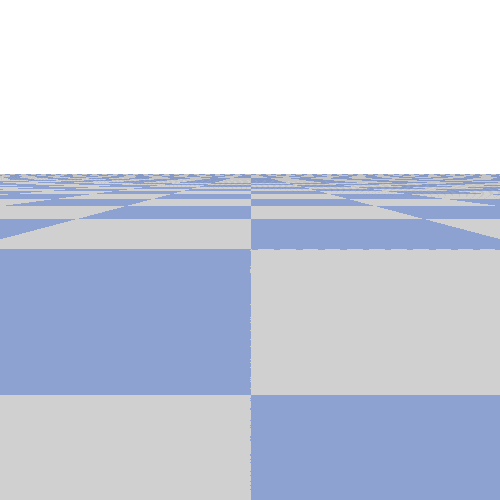

rgba shape=(500, 500, 4), dtype=uint8


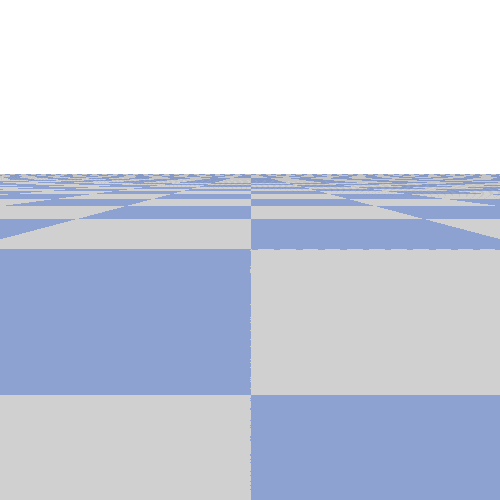

rgba shape=(500, 500, 4), dtype=uint8


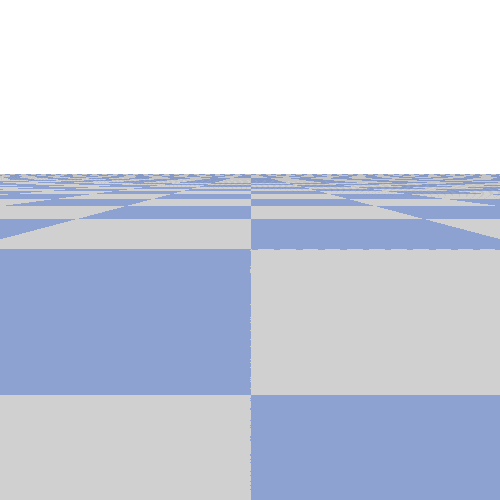

rgba shape=(500, 500, 4), dtype=uint8


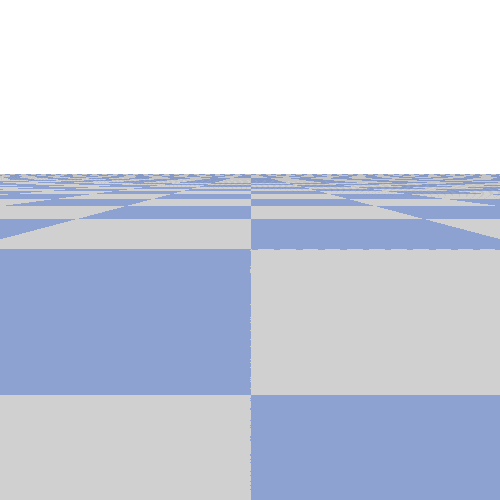

rgba shape=(500, 500, 4), dtype=uint8


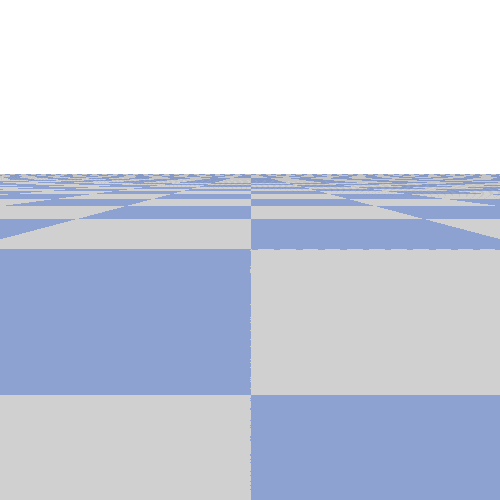

rgba shape=(500, 500, 4), dtype=uint8


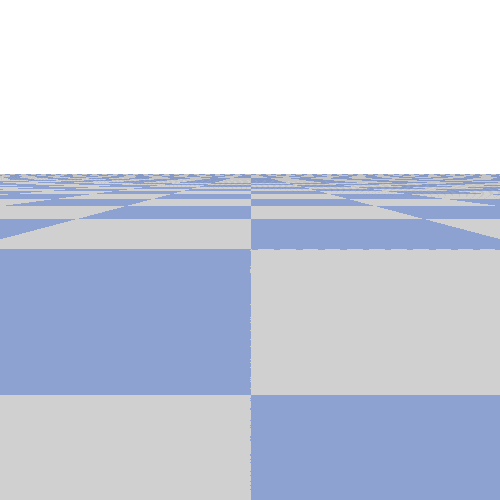

rgba shape=(500, 500, 4), dtype=uint8


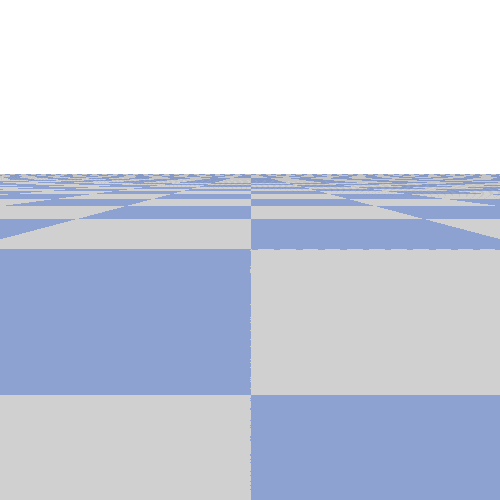

rgba shape=(500, 500, 4), dtype=uint8


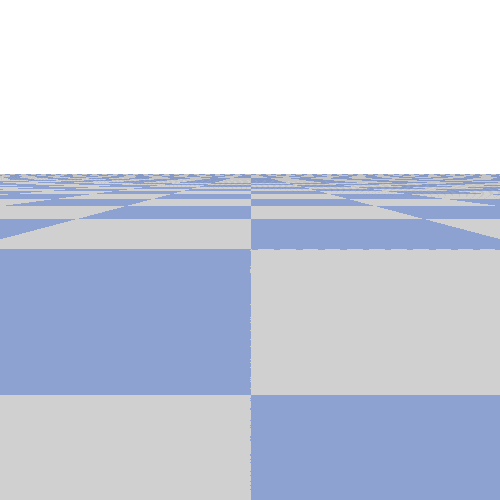

rgba shape=(500, 500, 4), dtype=uint8


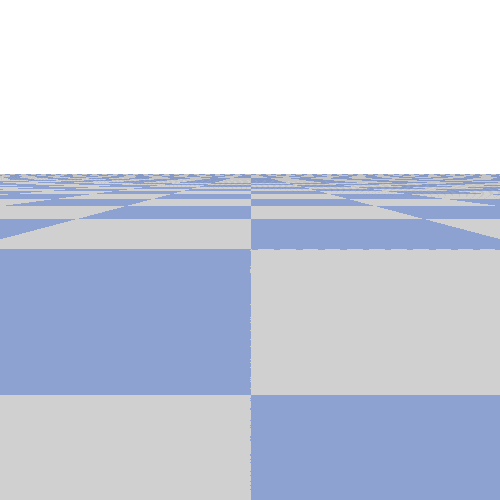

rgba shape=(500, 500, 4), dtype=uint8


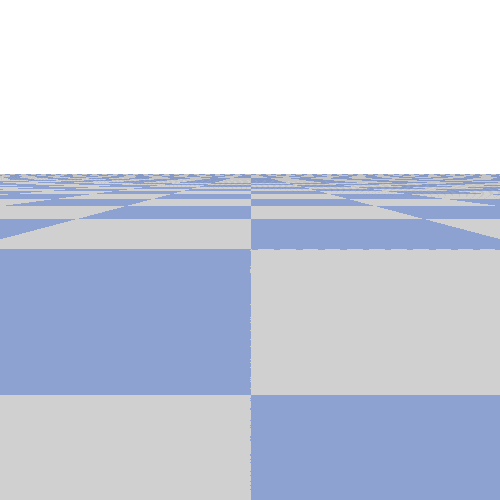

rgba shape=(500, 500, 4), dtype=uint8


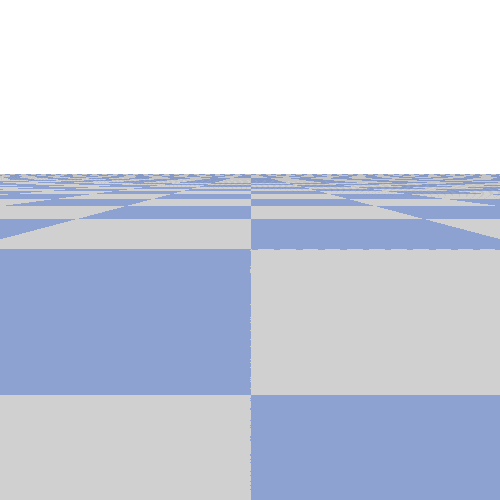

rgba shape=(500, 500, 4), dtype=uint8


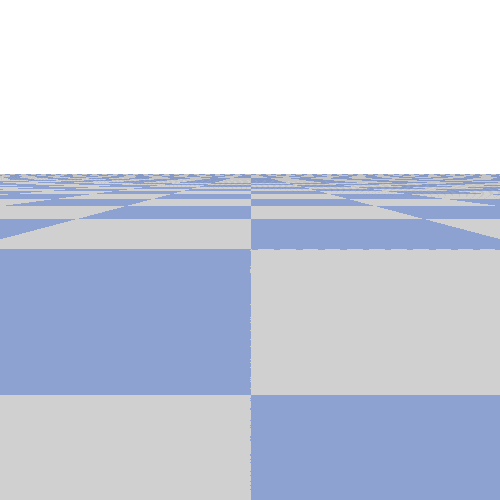

rgba shape=(500, 500, 4), dtype=uint8


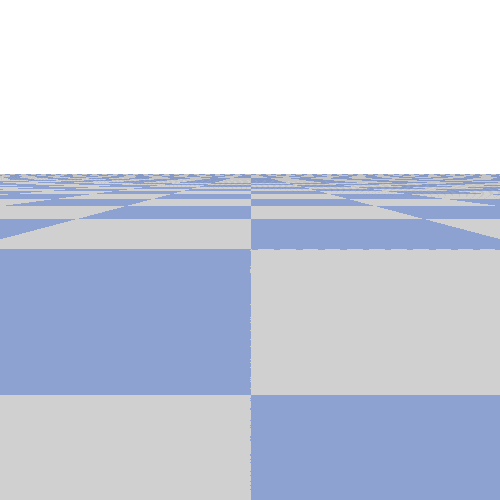

rgba shape=(500, 500, 4), dtype=uint8


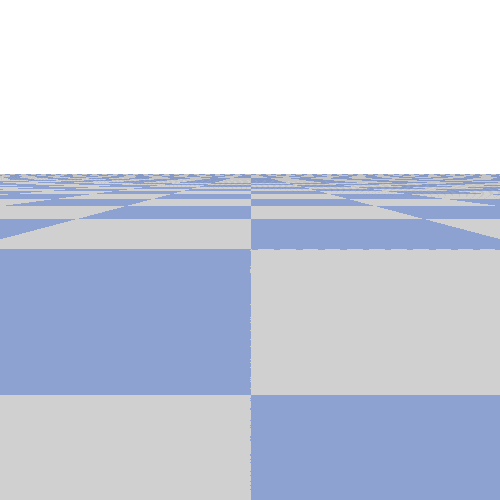

rgba shape=(500, 500, 4), dtype=uint8


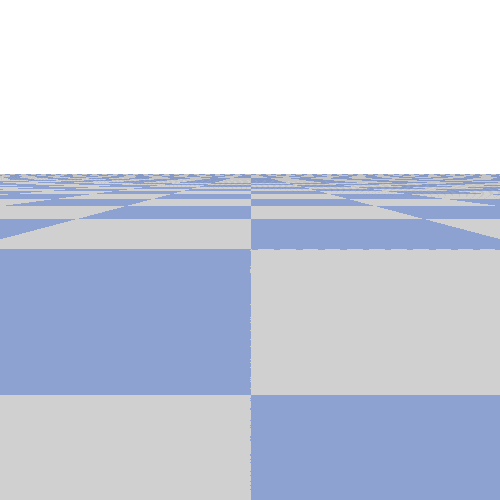

rgba shape=(500, 500, 4), dtype=uint8


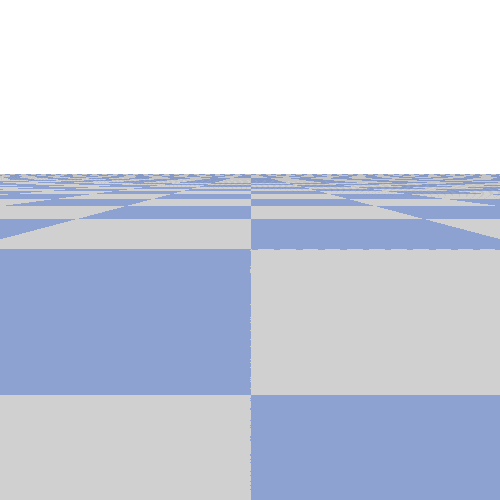

rgba shape=(500, 500, 4), dtype=uint8


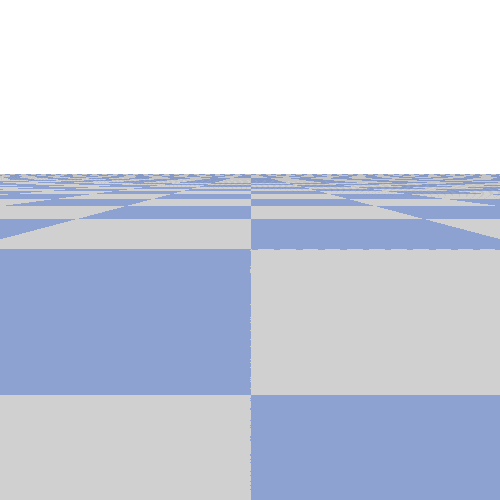

rgba shape=(500, 500, 4), dtype=uint8


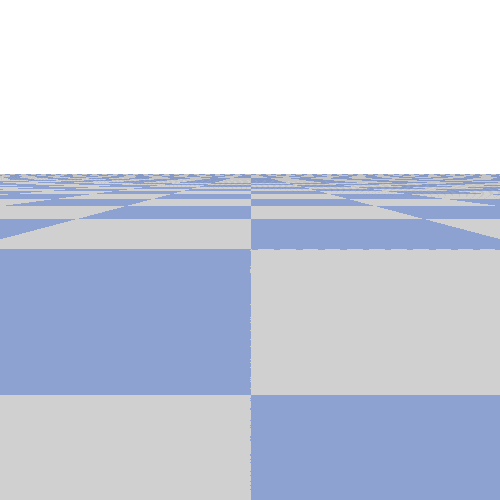

rgba shape=(500, 500, 4), dtype=uint8


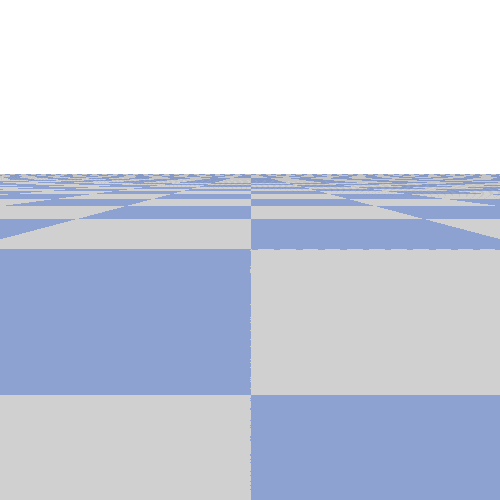

rgba shape=(500, 500, 4), dtype=uint8


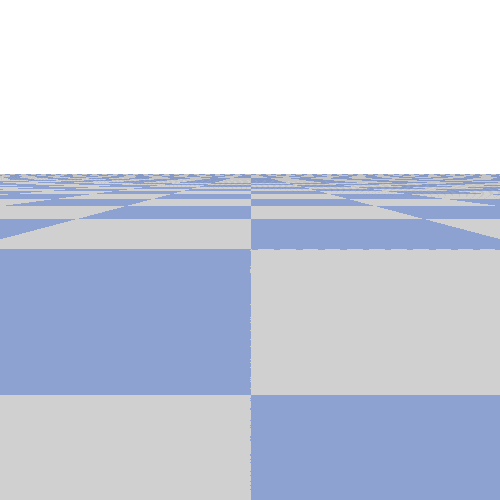

rgba shape=(500, 500, 4), dtype=uint8


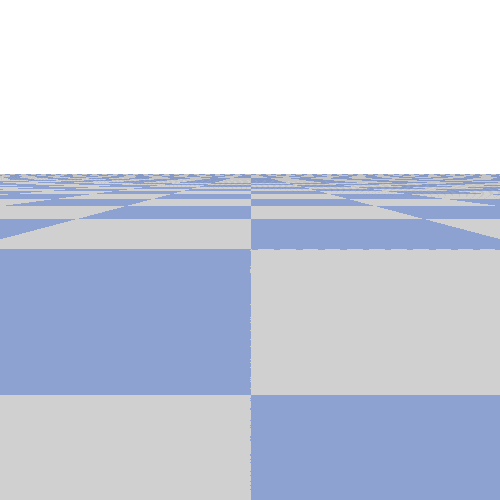

rgba shape=(500, 500, 4), dtype=uint8


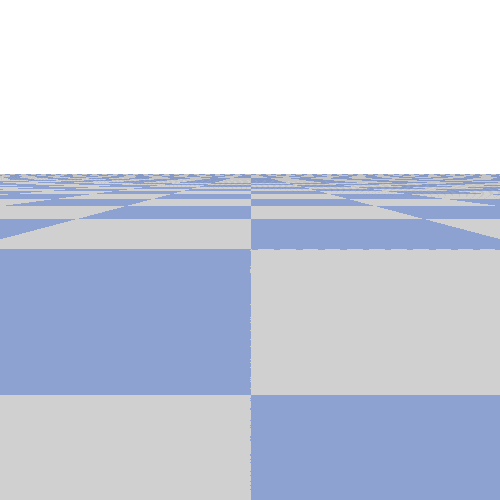

rgba shape=(500, 500, 4), dtype=uint8


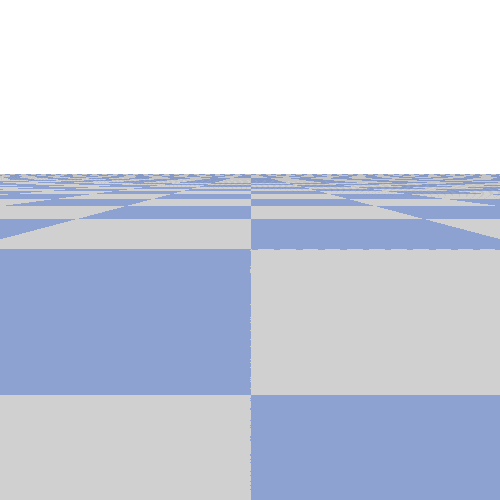

rgba shape=(500, 500, 4), dtype=uint8


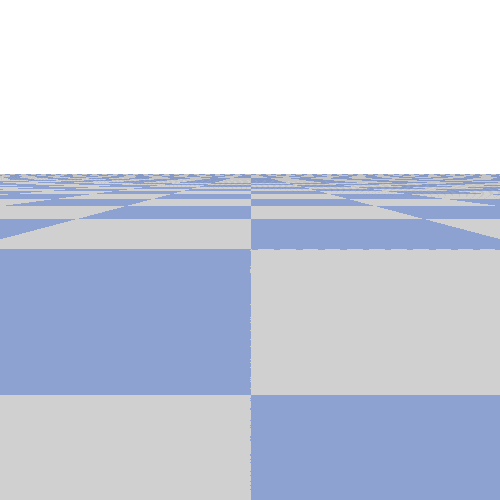

rgba shape=(500, 500, 4), dtype=uint8


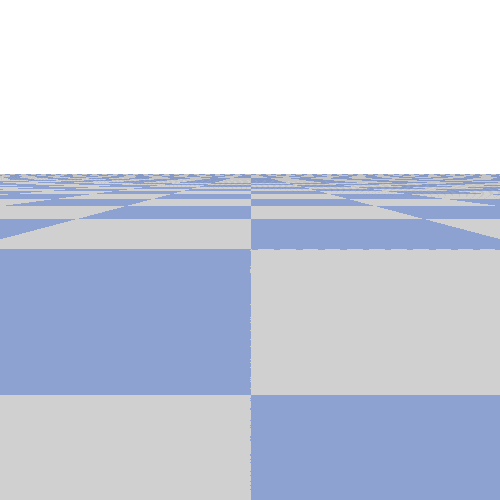

rgba shape=(500, 500, 4), dtype=uint8


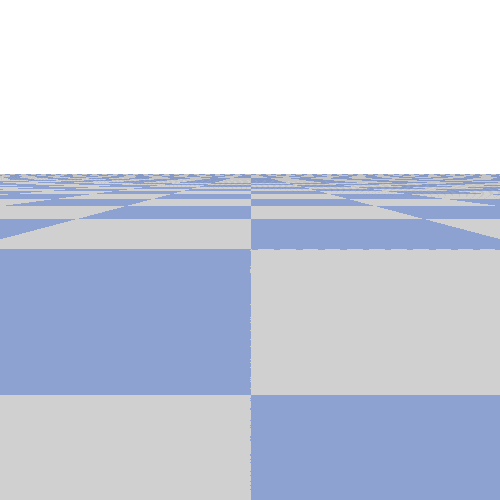

rgba shape=(500, 500, 4), dtype=uint8


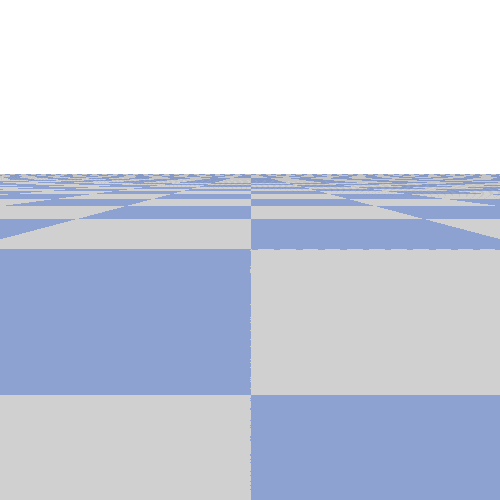

rgba shape=(500, 500, 4), dtype=uint8


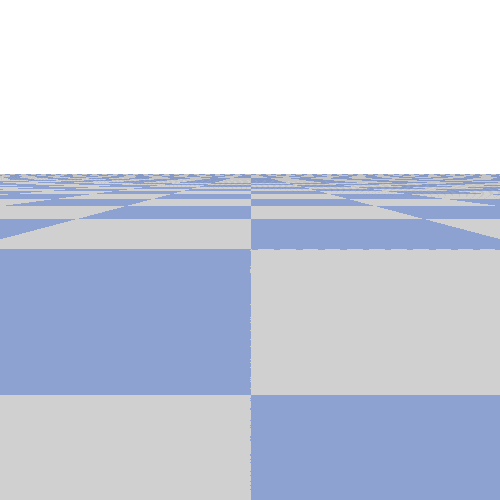

rgba shape=(500, 500, 4), dtype=uint8


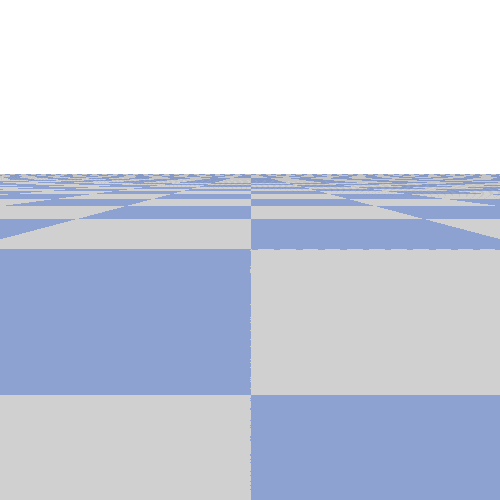

rgba shape=(500, 500, 4), dtype=uint8


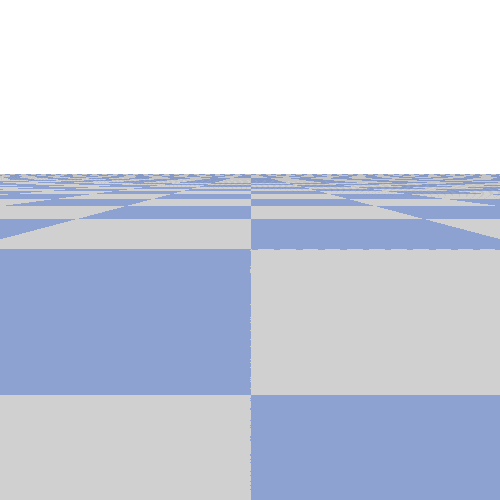

rgba shape=(500, 500, 4), dtype=uint8


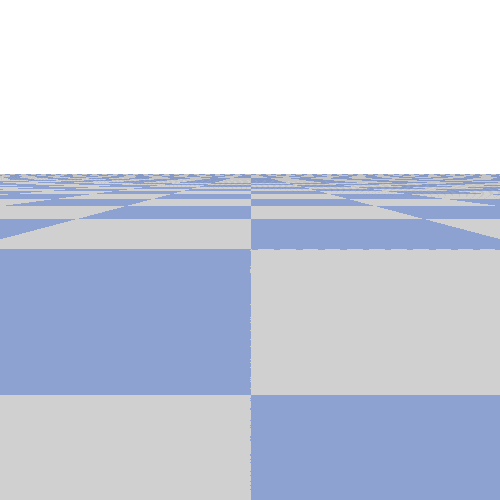

rgba shape=(500, 500, 4), dtype=uint8


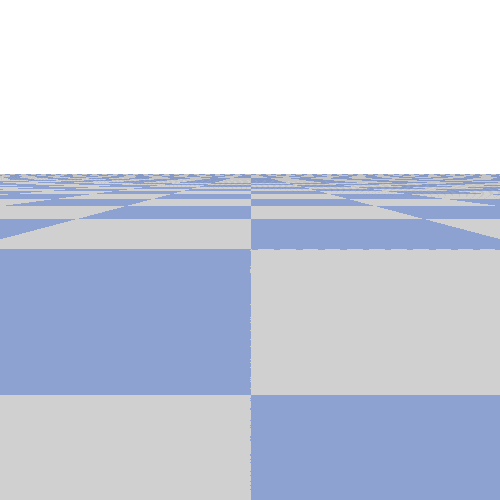

rgba shape=(500, 500, 4), dtype=uint8


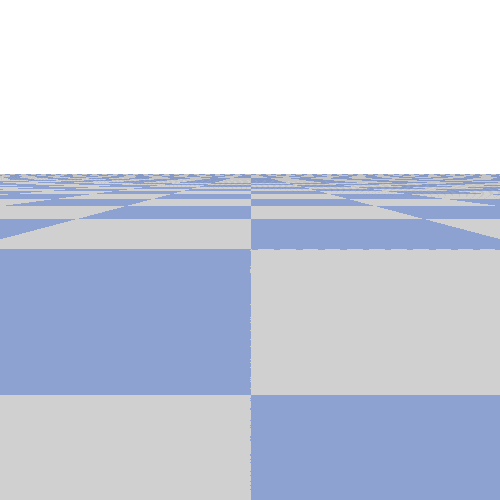

rgba shape=(500, 500, 4), dtype=uint8


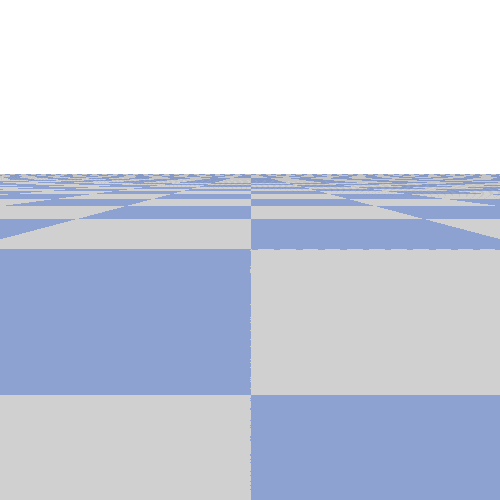

rgba shape=(500, 500, 4), dtype=uint8


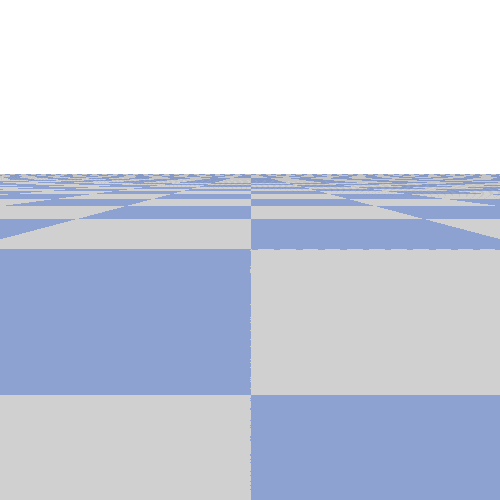

rgba shape=(500, 500, 4), dtype=uint8


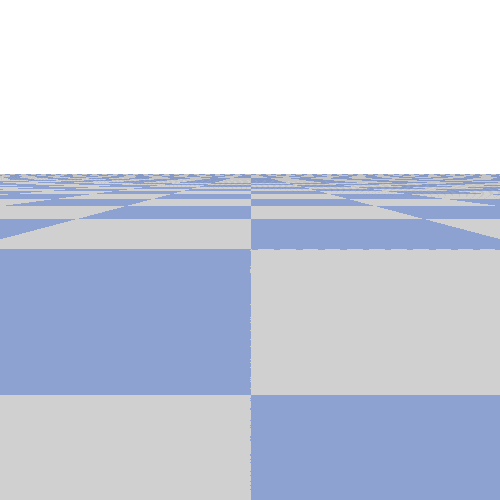

rgba shape=(500, 500, 4), dtype=uint8


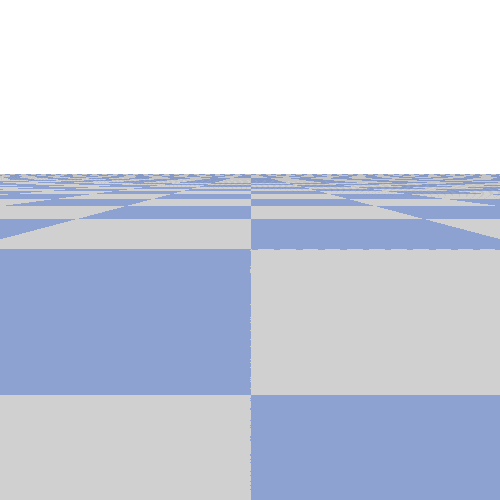

rgba shape=(500, 500, 4), dtype=uint8


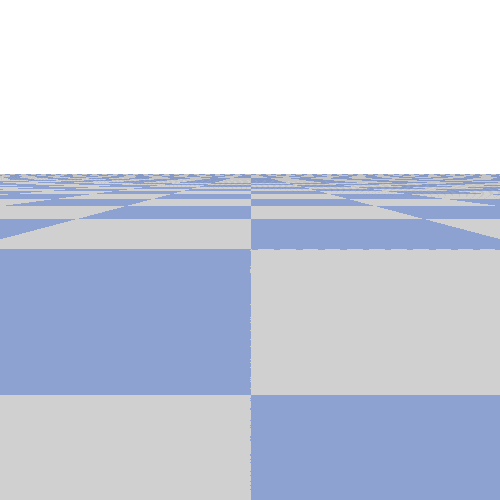

rgba shape=(500, 500, 4), dtype=uint8


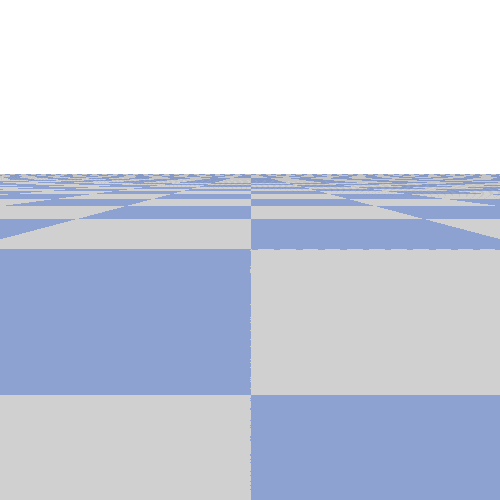

rgba shape=(500, 500, 4), dtype=uint8


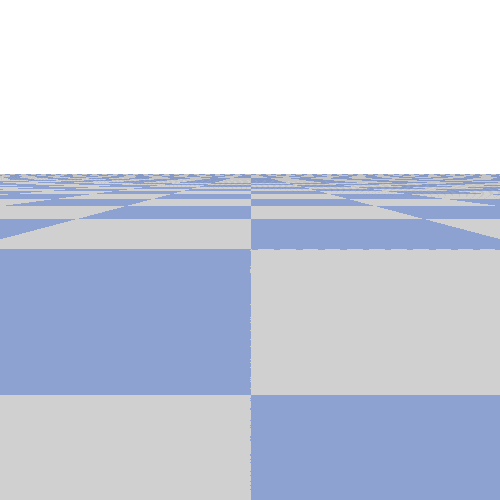

rgba shape=(500, 500, 4), dtype=uint8


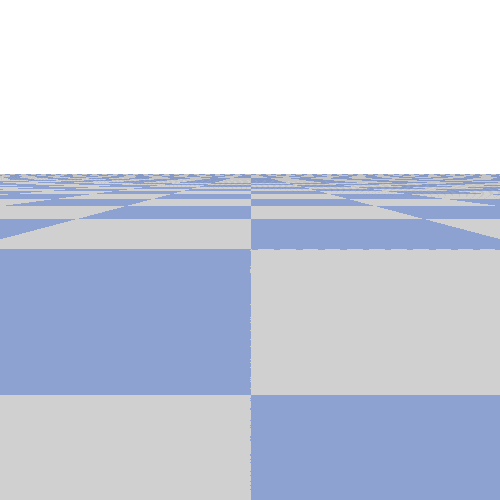

rgba shape=(500, 500, 4), dtype=uint8


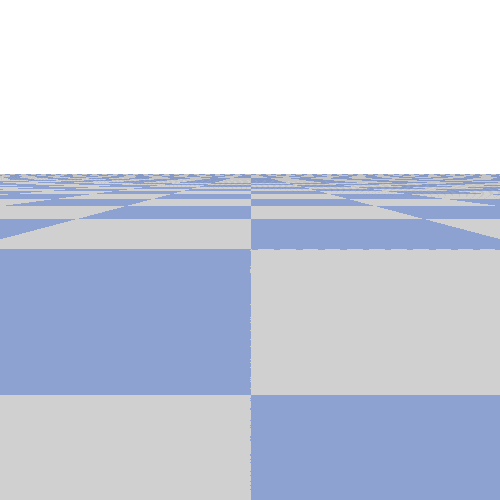

rgba shape=(500, 500, 4), dtype=uint8


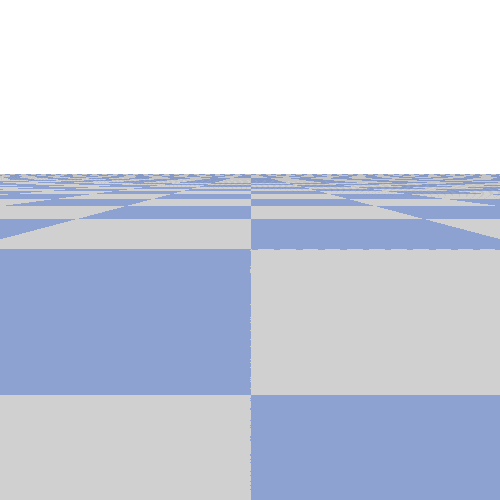

rgba shape=(500, 500, 4), dtype=uint8


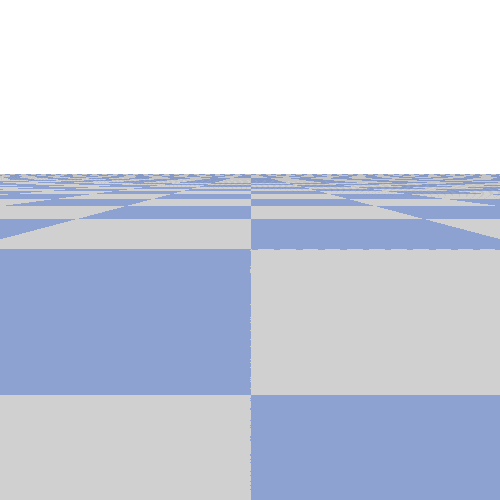

rgba shape=(500, 500, 4), dtype=uint8


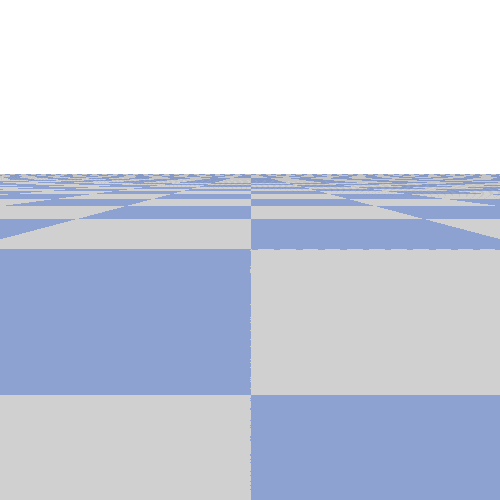

rgba shape=(500, 500, 4), dtype=uint8


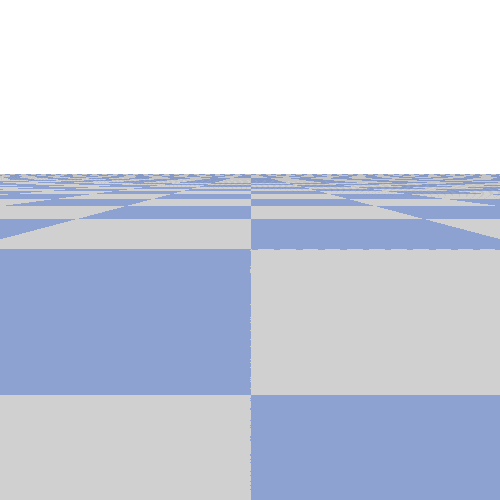

rgba shape=(500, 500, 4), dtype=uint8


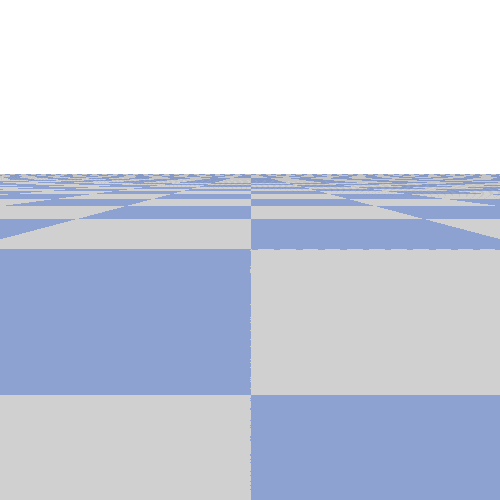

rgba shape=(500, 500, 4), dtype=uint8


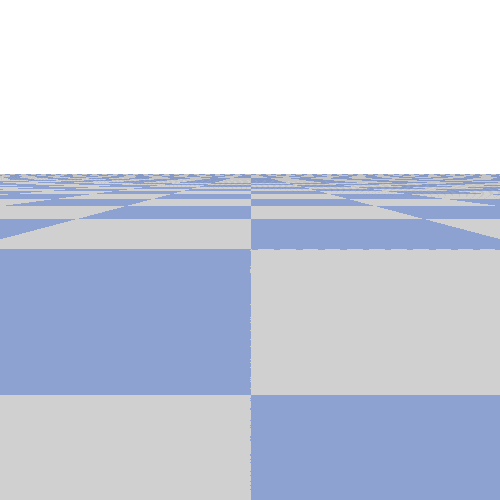

rgba shape=(500, 500, 4), dtype=uint8


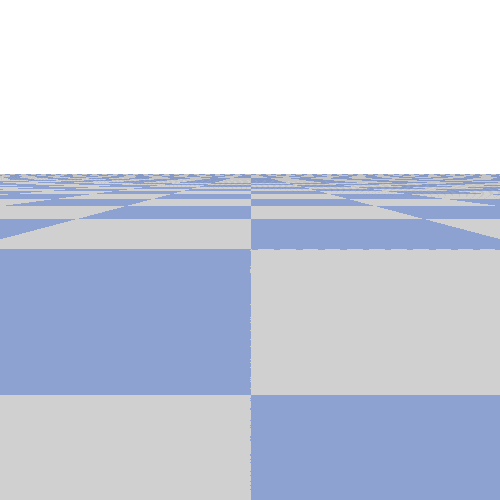

rgba shape=(500, 500, 4), dtype=uint8


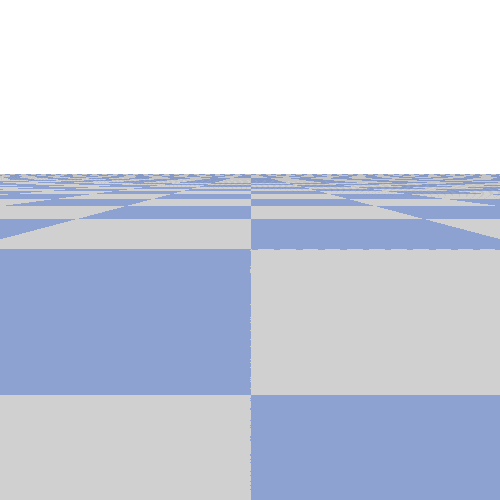

rgba shape=(500, 500, 4), dtype=uint8


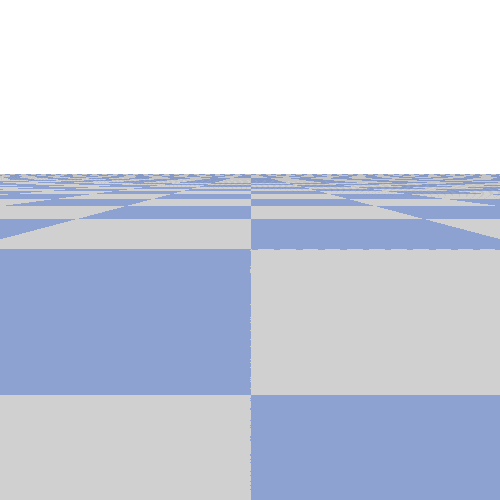

rgba shape=(500, 500, 4), dtype=uint8


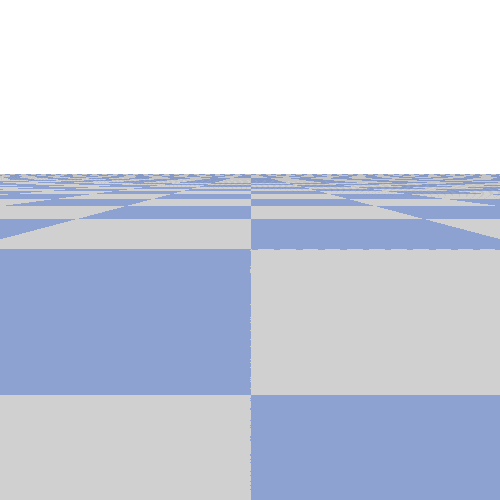

rgba shape=(500, 500, 4), dtype=uint8


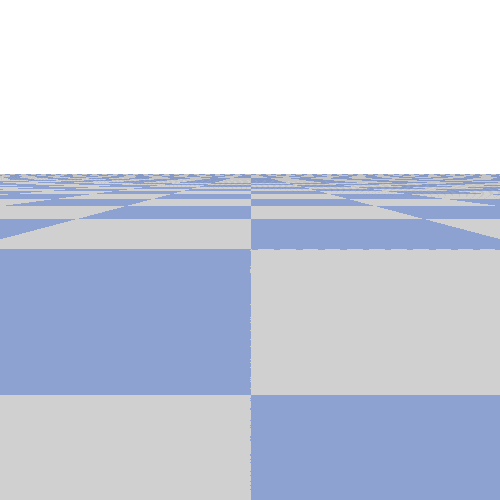

rgba shape=(500, 500, 4), dtype=uint8


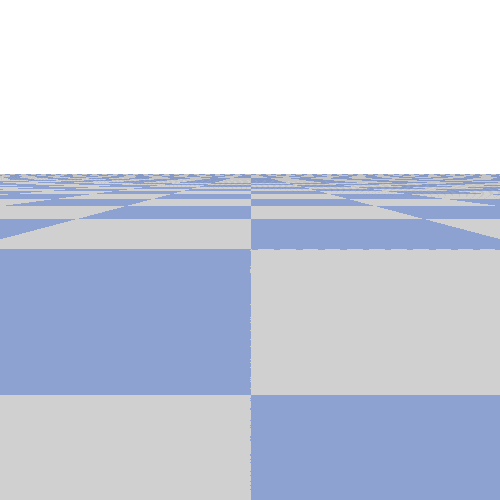

fail
rgba shape=(500, 500, 4), dtype=uint8


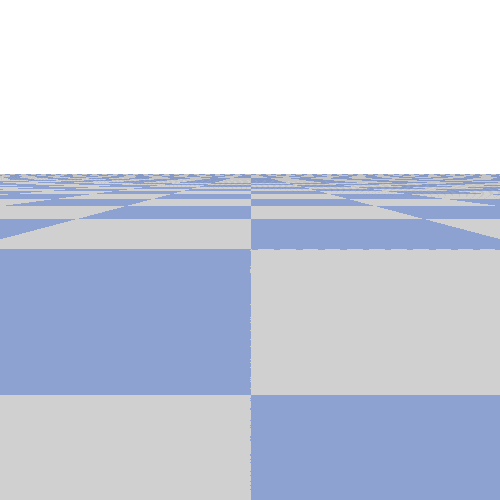

rgba shape=(500, 500, 4), dtype=uint8


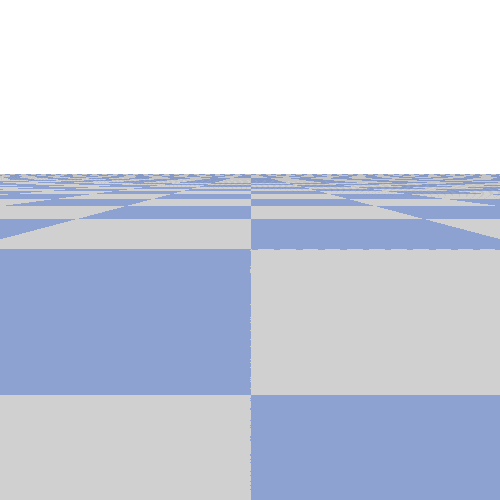

rgba shape=(500, 500, 4), dtype=uint8


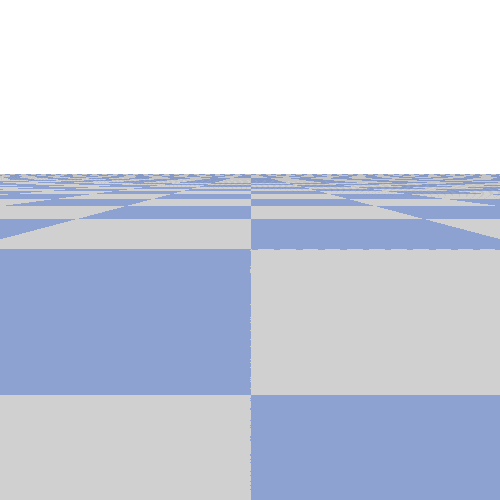

rgba shape=(500, 500, 4), dtype=uint8


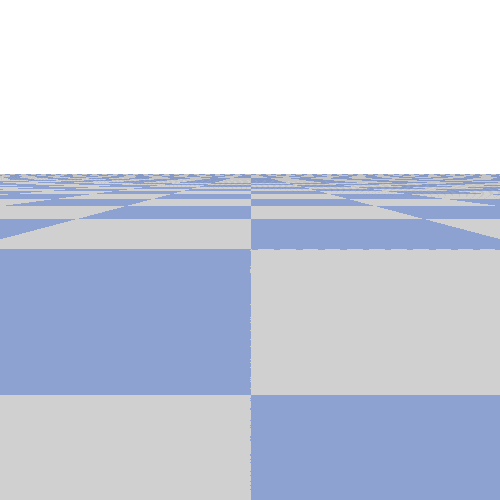

rgba shape=(500, 500, 4), dtype=uint8


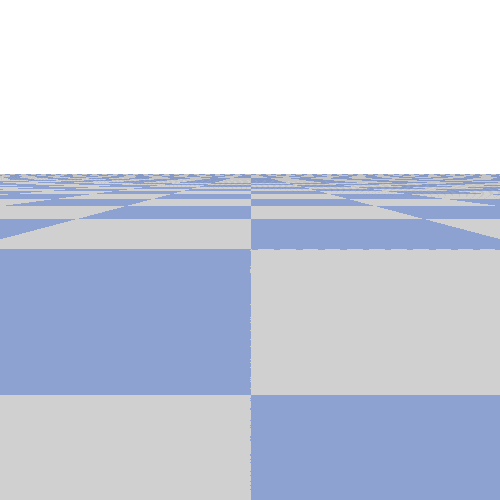

rgba shape=(500, 500, 4), dtype=uint8


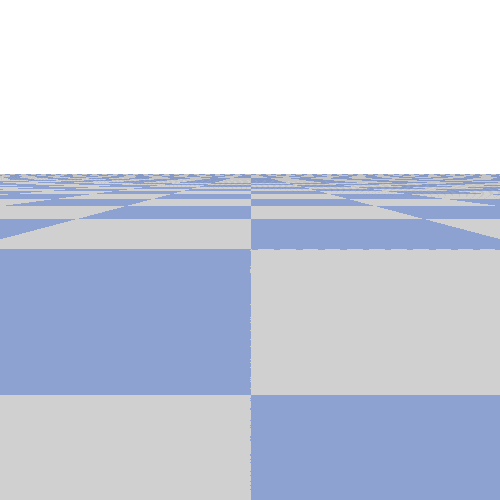

rgba shape=(500, 500, 4), dtype=uint8


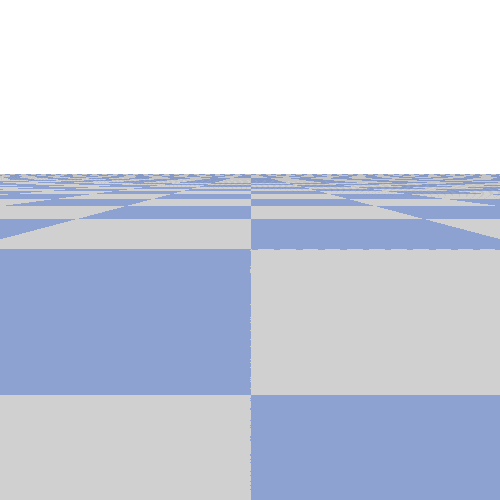

rgba shape=(500, 500, 4), dtype=uint8


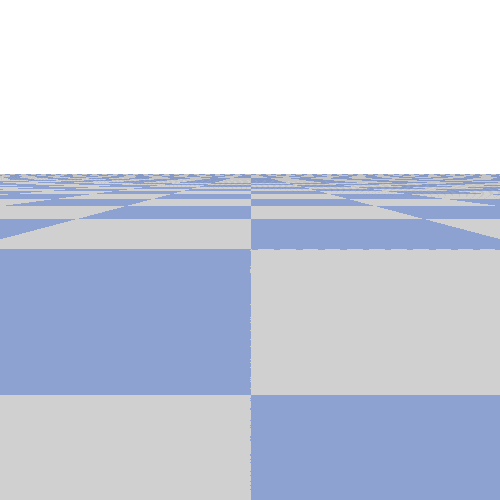

rgba shape=(500, 500, 4), dtype=uint8


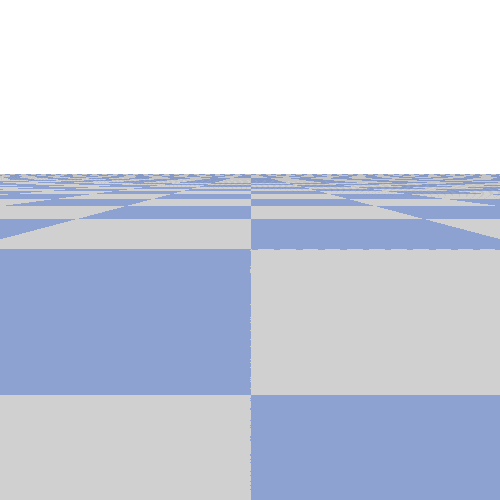

rgba shape=(500, 500, 4), dtype=uint8


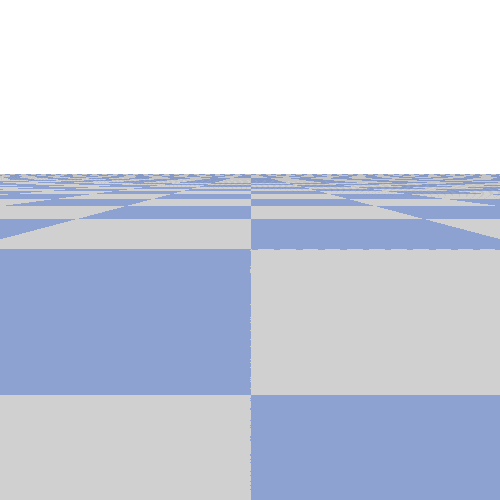

rgba shape=(500, 500, 4), dtype=uint8


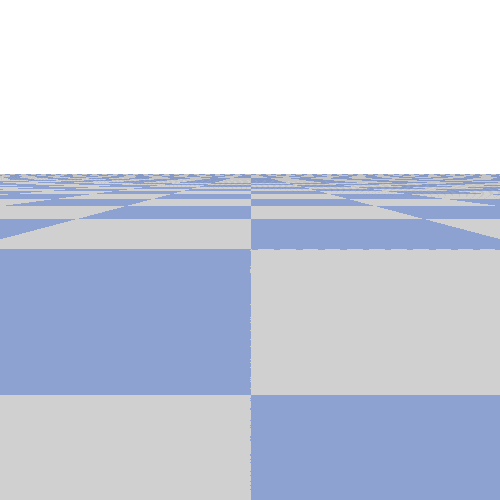

rgba shape=(500, 500, 4), dtype=uint8


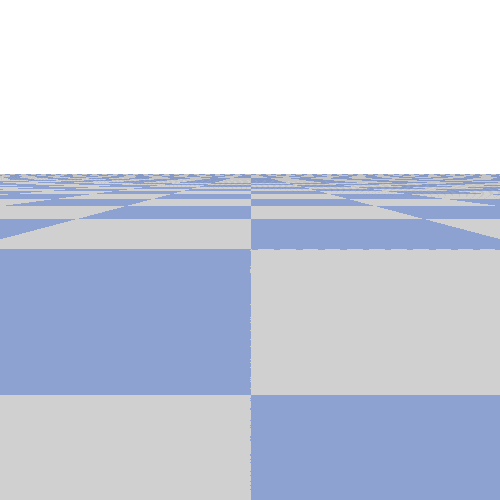

rgba shape=(500, 500, 4), dtype=uint8


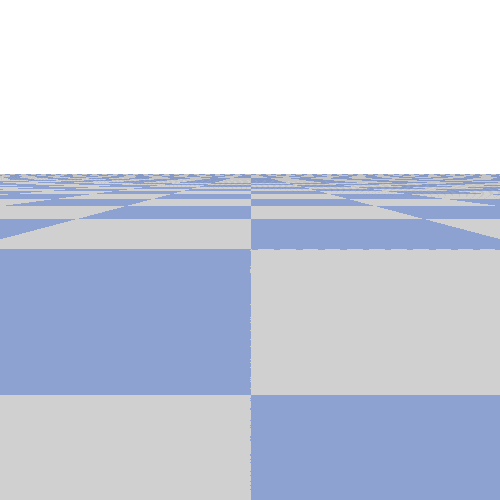

rgba shape=(500, 500, 4), dtype=uint8


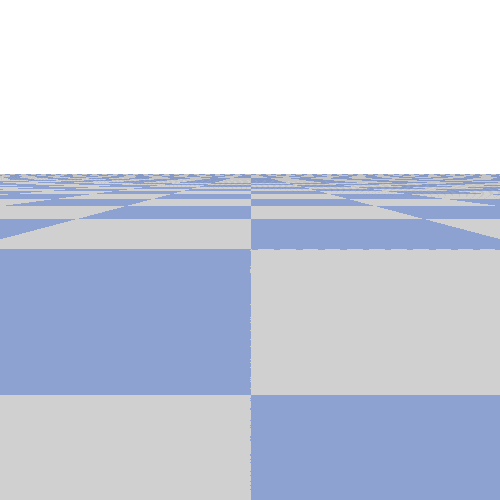

rgba shape=(500, 500, 4), dtype=uint8


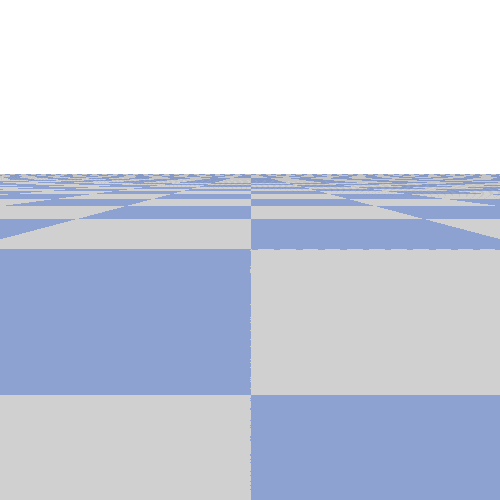

rgba shape=(500, 500, 4), dtype=uint8


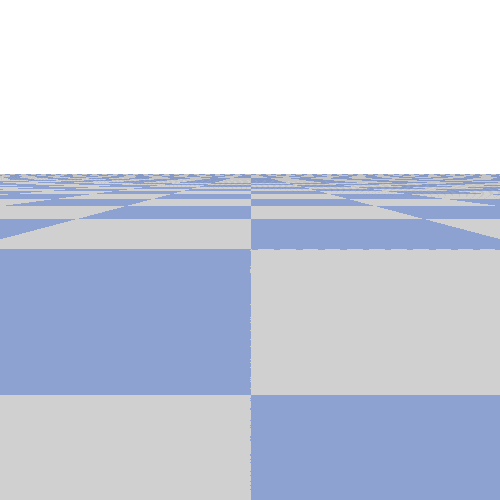

rgba shape=(500, 500, 4), dtype=uint8


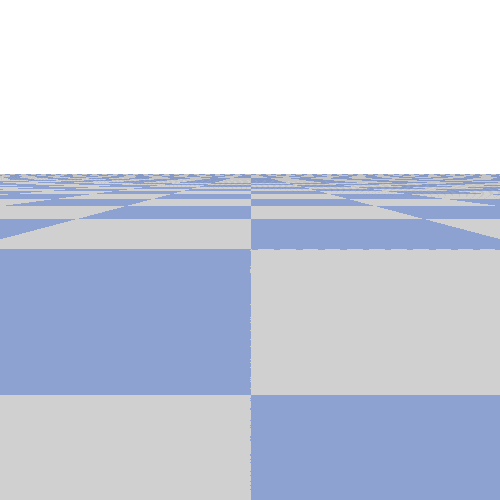

rgba shape=(500, 500, 4), dtype=uint8


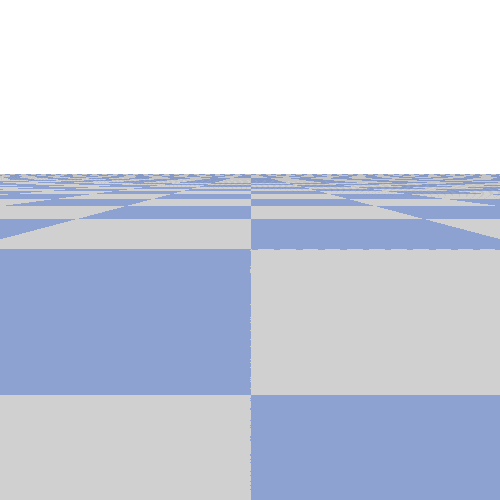

rgba shape=(500, 500, 4), dtype=uint8


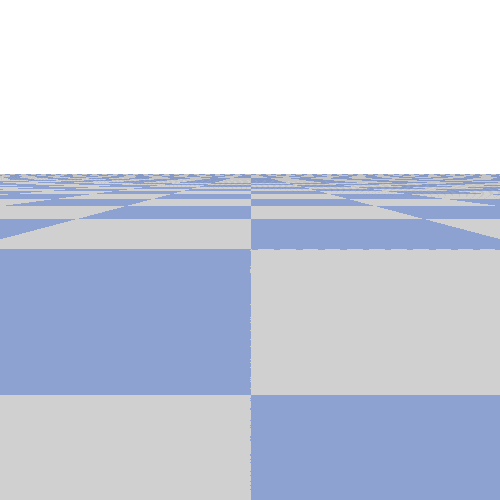

rgba shape=(500, 500, 4), dtype=uint8


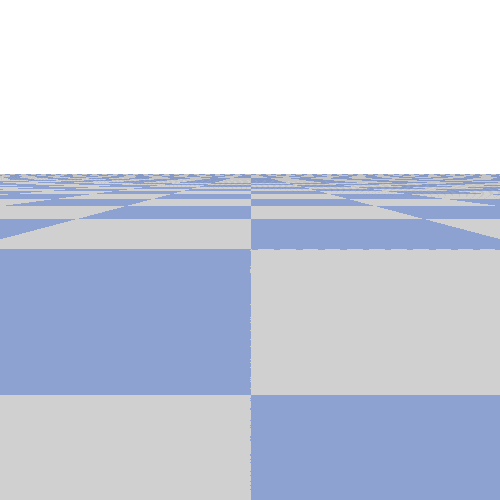

rgba shape=(500, 500, 4), dtype=uint8


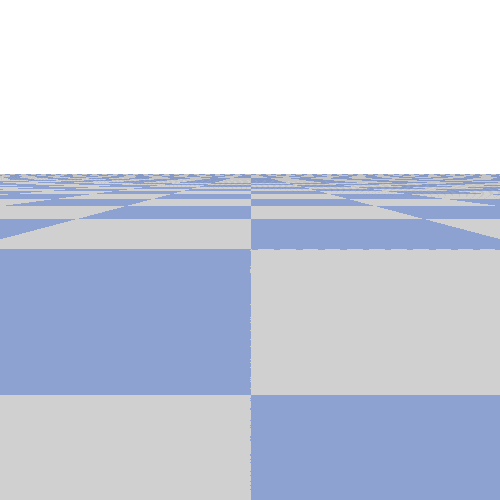

rgba shape=(500, 500, 4), dtype=uint8


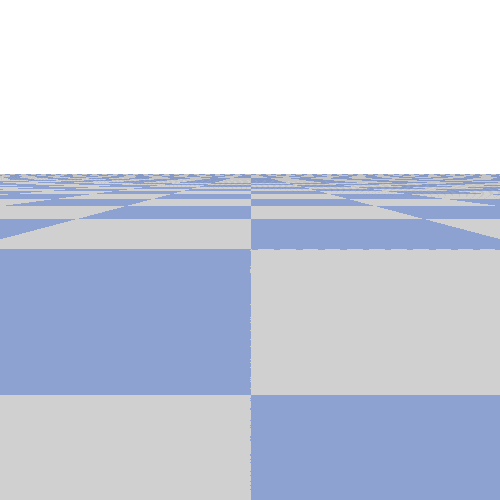

rgba shape=(500, 500, 4), dtype=uint8


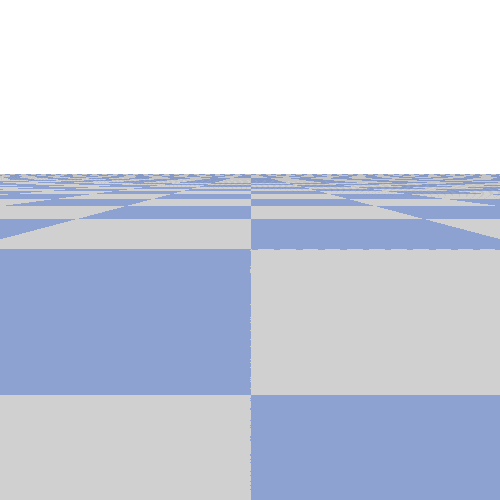

rgba shape=(500, 500, 4), dtype=uint8


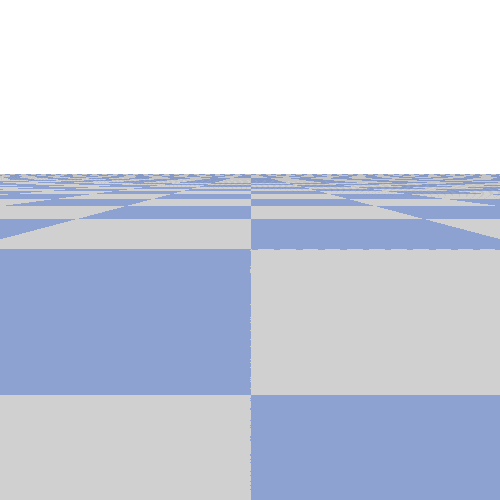

rgba shape=(500, 500, 4), dtype=uint8


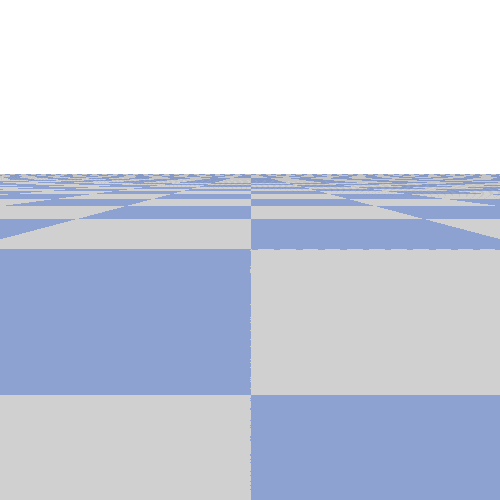

rgba shape=(500, 500, 4), dtype=uint8


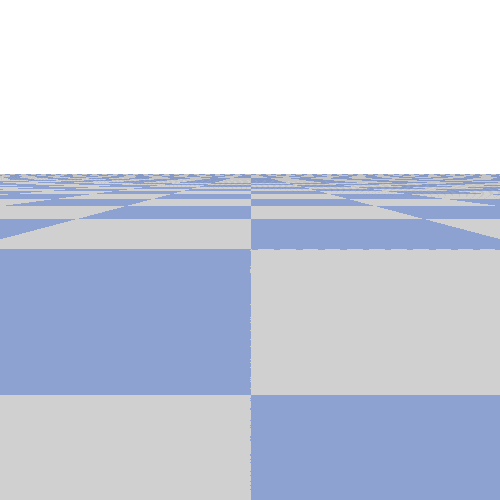

rgba shape=(500, 500, 4), dtype=uint8


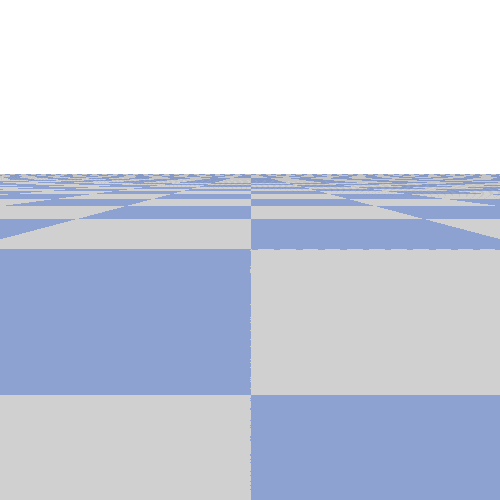

rgba shape=(500, 500, 4), dtype=uint8


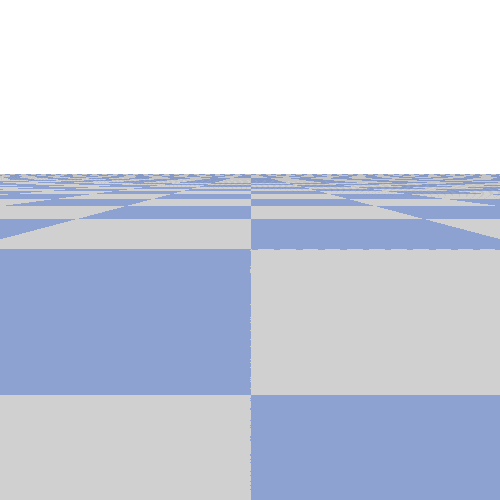

rgba shape=(500, 500, 4), dtype=uint8


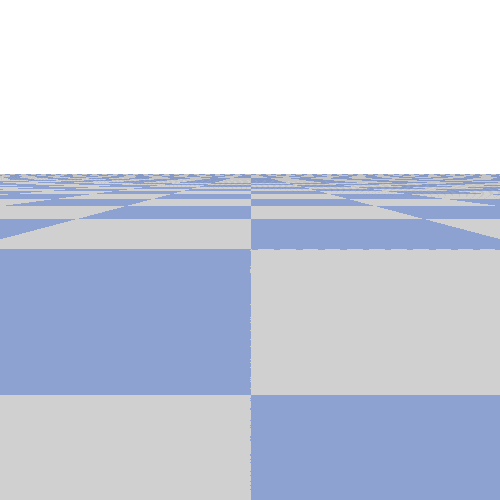

rgba shape=(500, 500, 4), dtype=uint8


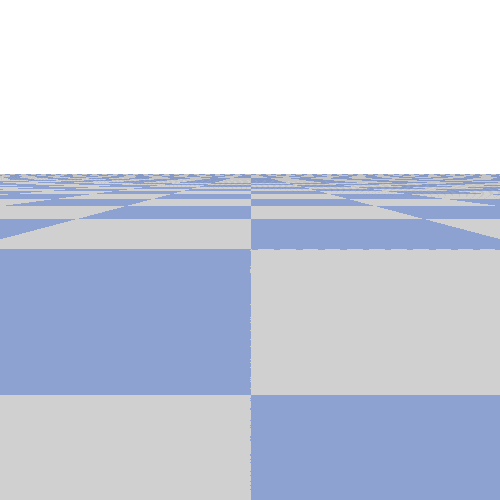

fail
rgba shape=(500, 500, 4), dtype=uint8


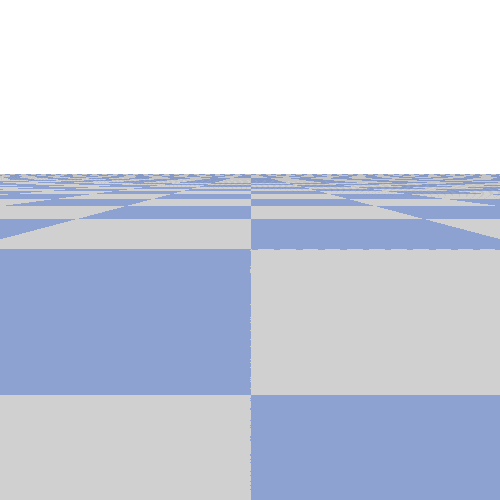

rgba shape=(500, 500, 4), dtype=uint8


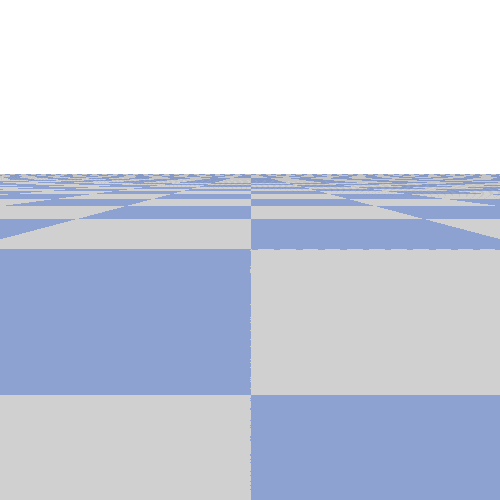

rgba shape=(500, 500, 4), dtype=uint8


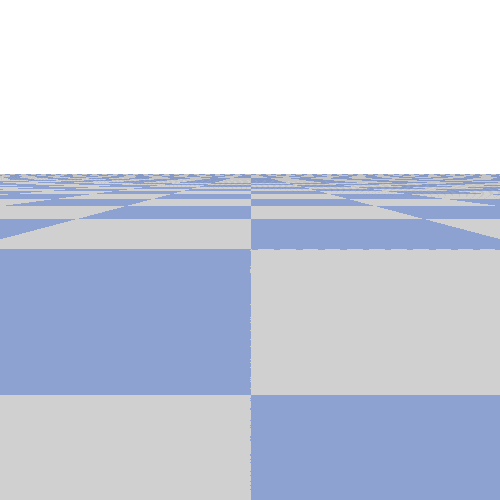

rgba shape=(500, 500, 4), dtype=uint8


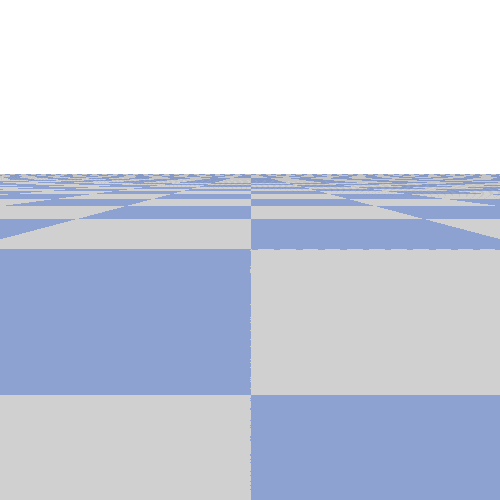

rgba shape=(500, 500, 4), dtype=uint8


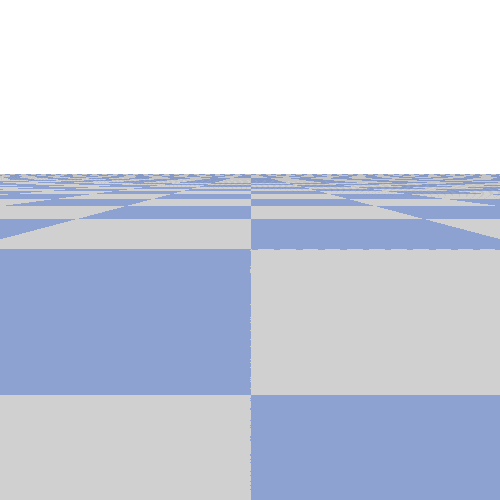

rgba shape=(500, 500, 4), dtype=uint8


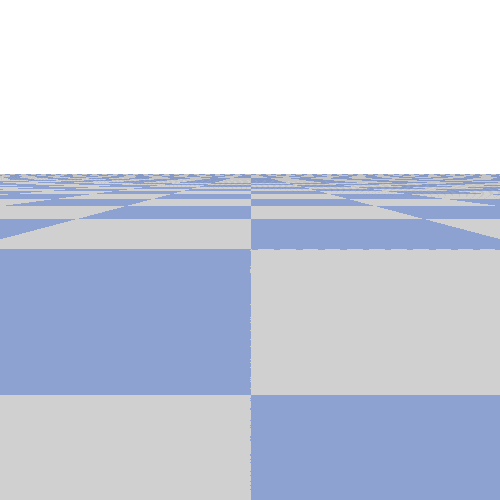

rgba shape=(500, 500, 4), dtype=uint8


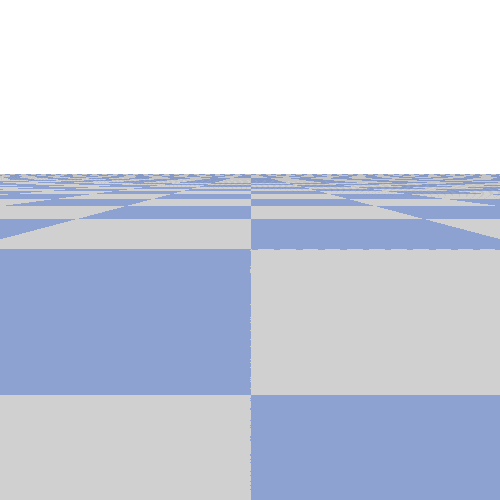

rgba shape=(500, 500, 4), dtype=uint8


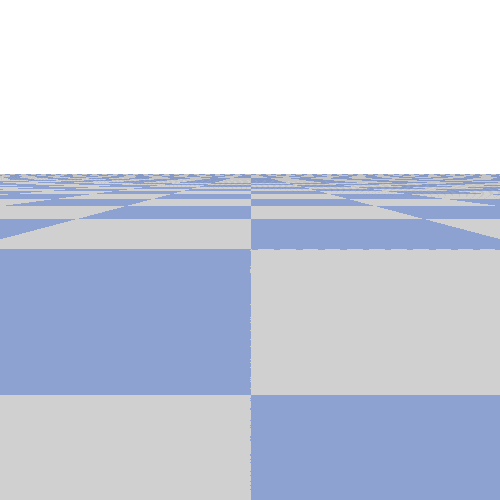

rgba shape=(500, 500, 4), dtype=uint8


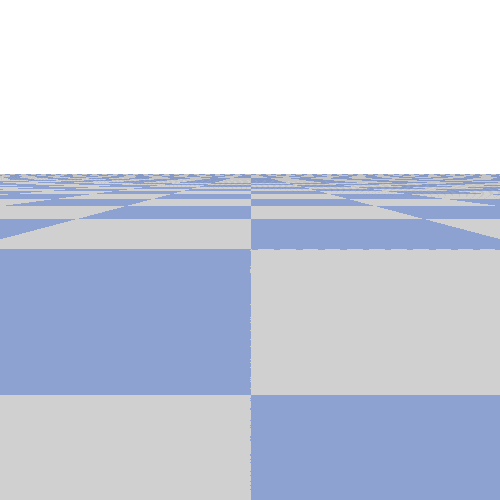

rgba shape=(500, 500, 4), dtype=uint8


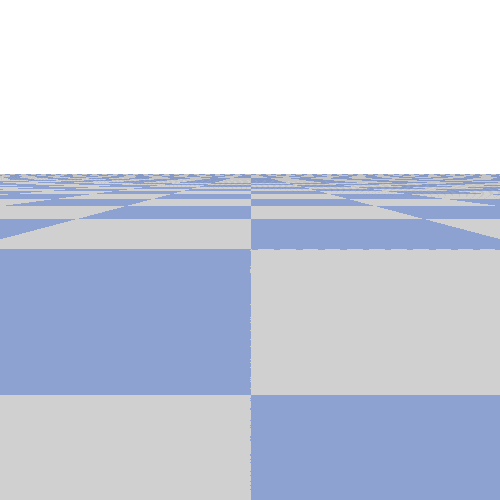

rgba shape=(500, 500, 4), dtype=uint8


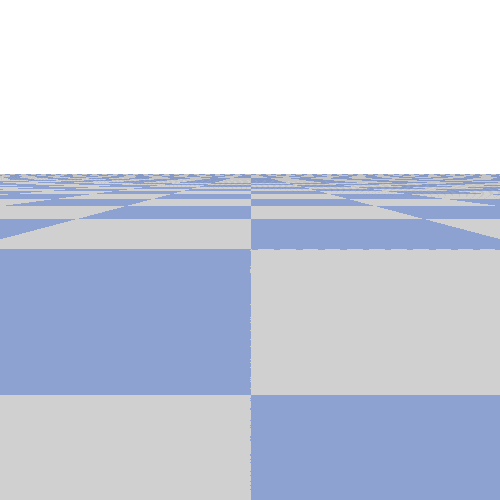

rgba shape=(500, 500, 4), dtype=uint8


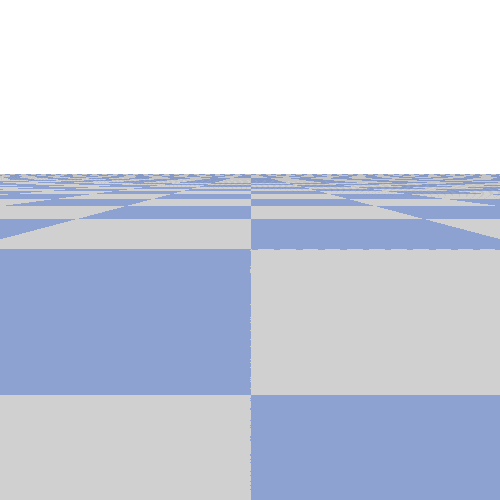

rgba shape=(500, 500, 4), dtype=uint8


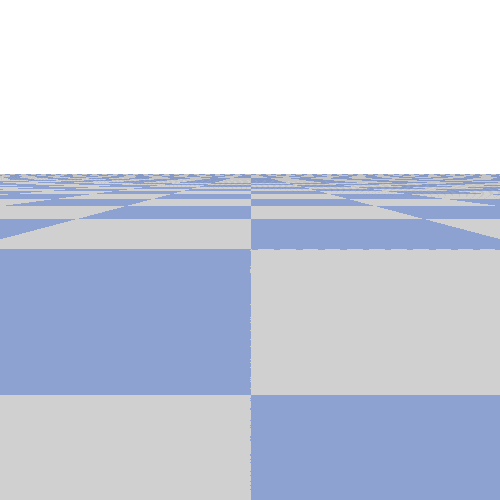

rgba shape=(500, 500, 4), dtype=uint8


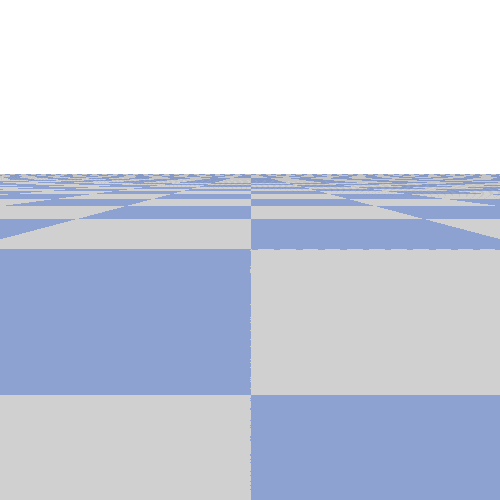

rgba shape=(500, 500, 4), dtype=uint8


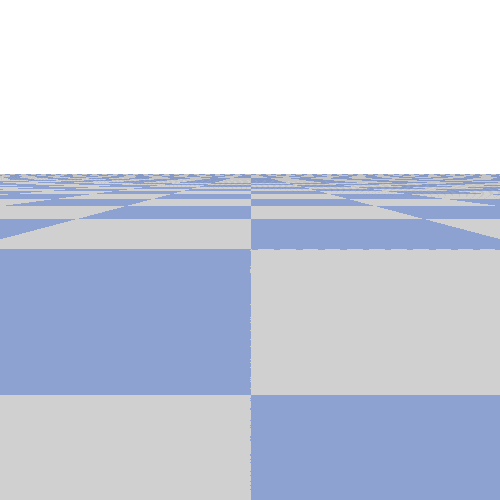

rgba shape=(500, 500, 4), dtype=uint8


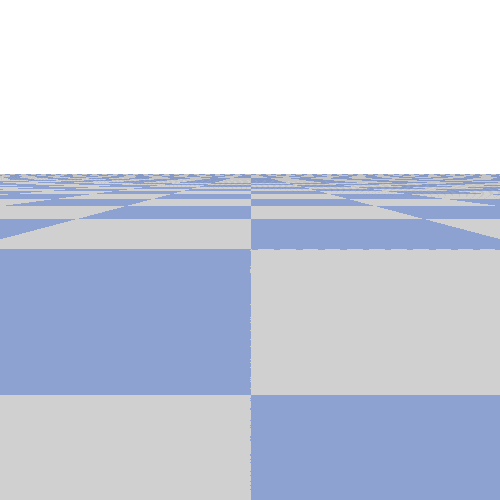

rgba shape=(500, 500, 4), dtype=uint8


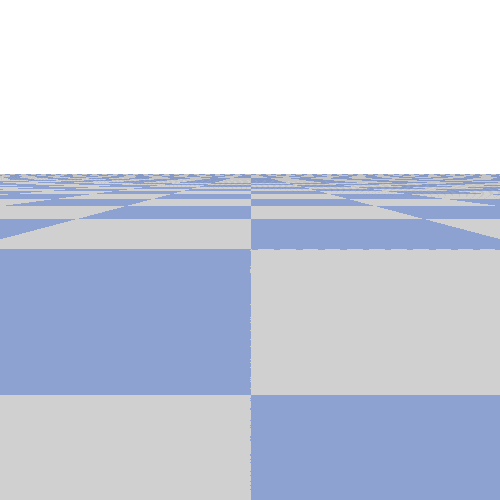

rgba shape=(500, 500, 4), dtype=uint8


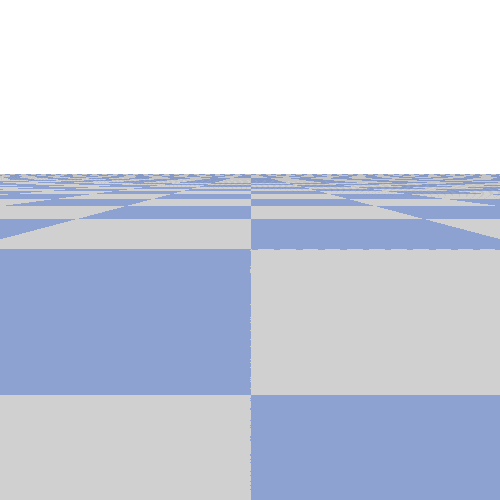

rgba shape=(500, 500, 4), dtype=uint8


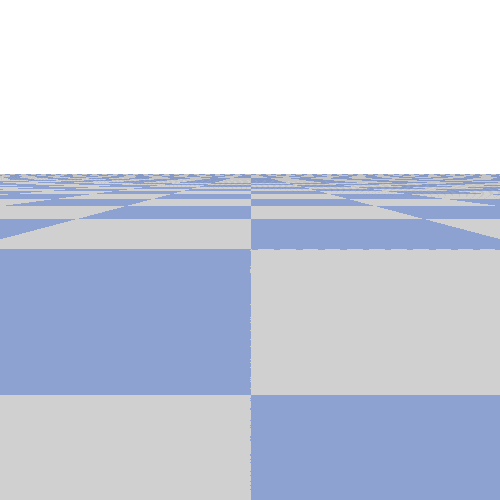

rgba shape=(500, 500, 4), dtype=uint8


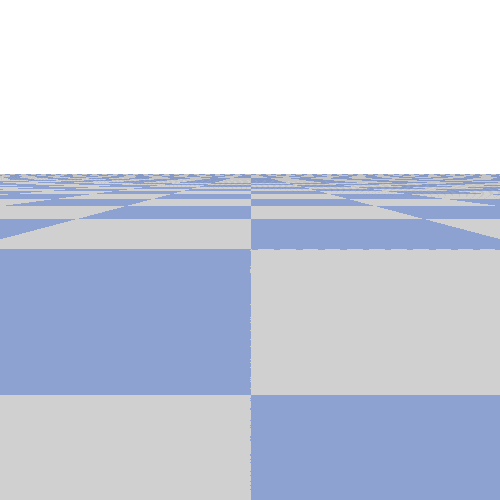

rgba shape=(500, 500, 4), dtype=uint8


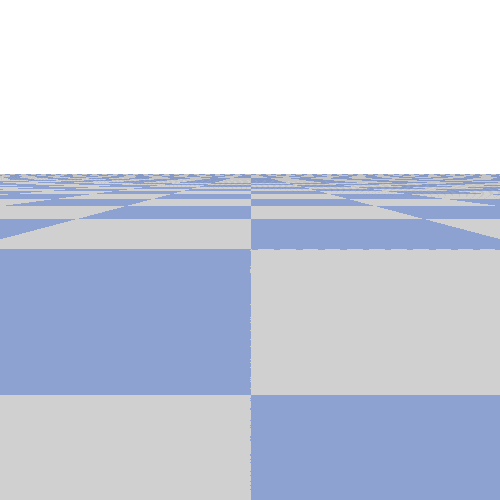

rgba shape=(500, 500, 4), dtype=uint8


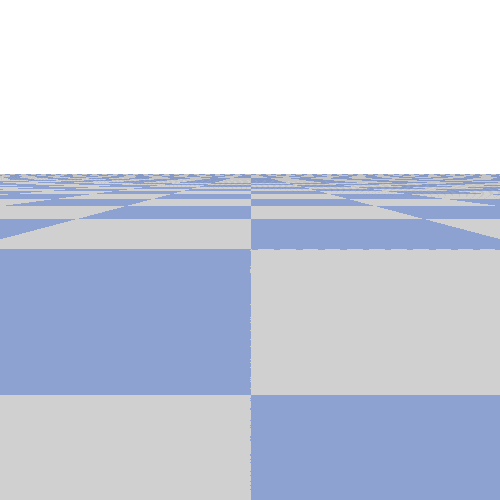

rgba shape=(500, 500, 4), dtype=uint8


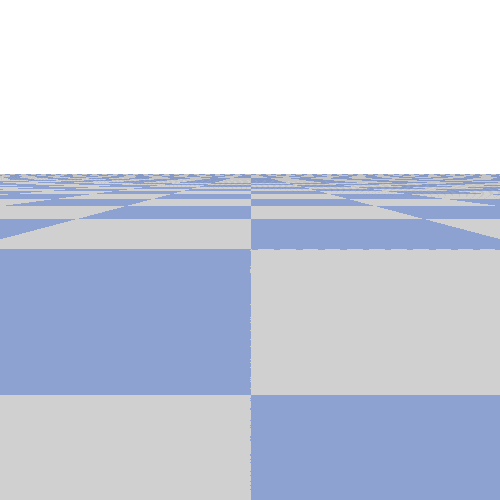

rgba shape=(500, 500, 4), dtype=uint8


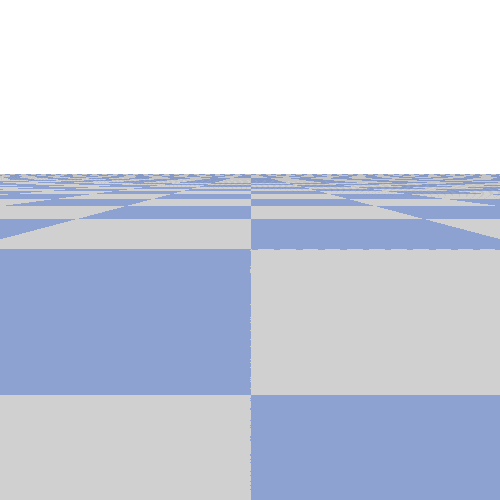

rgba shape=(500, 500, 4), dtype=uint8


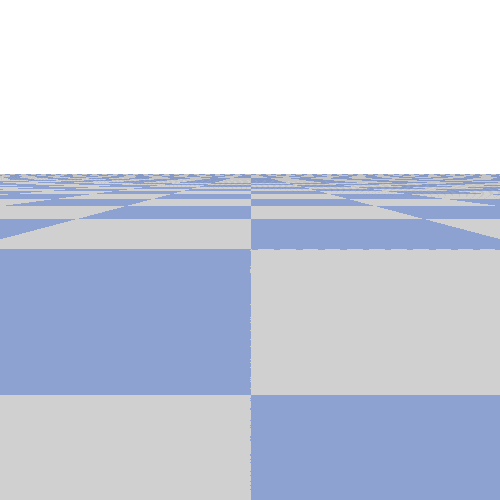

rgba shape=(500, 500, 4), dtype=uint8


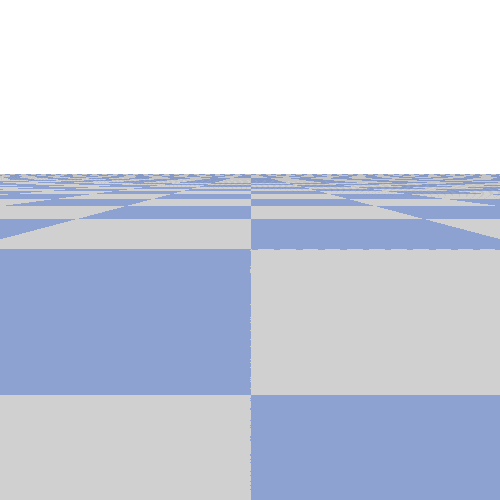

rgba shape=(500, 500, 4), dtype=uint8


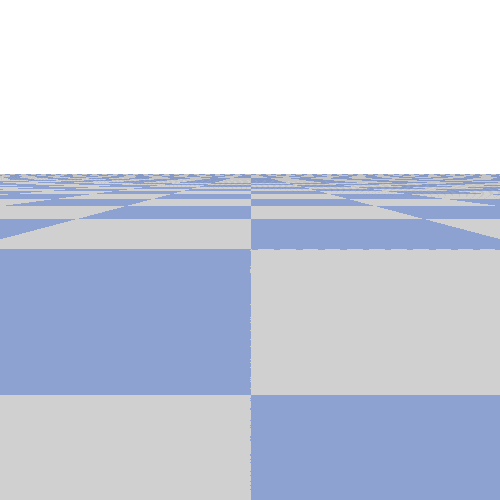

rgba shape=(500, 500, 4), dtype=uint8


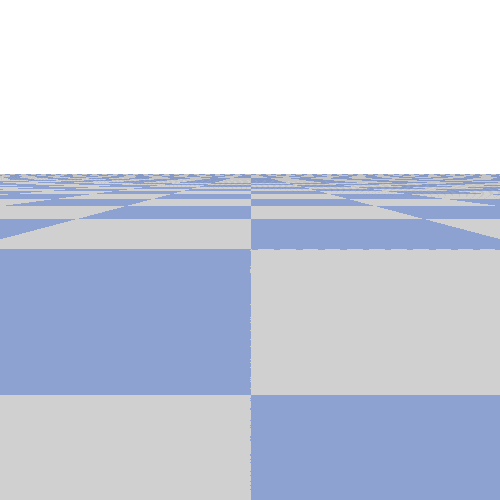

rgba shape=(500, 500, 4), dtype=uint8


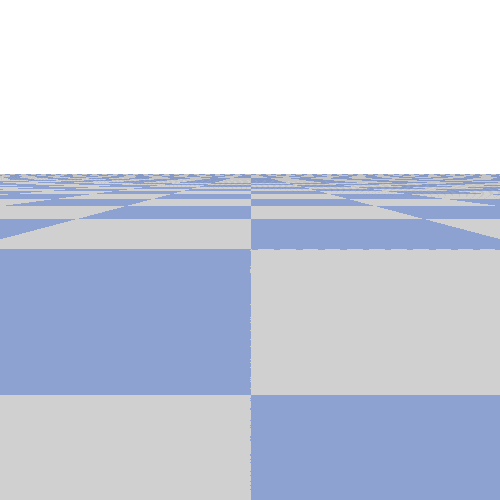

rgba shape=(500, 500, 4), dtype=uint8


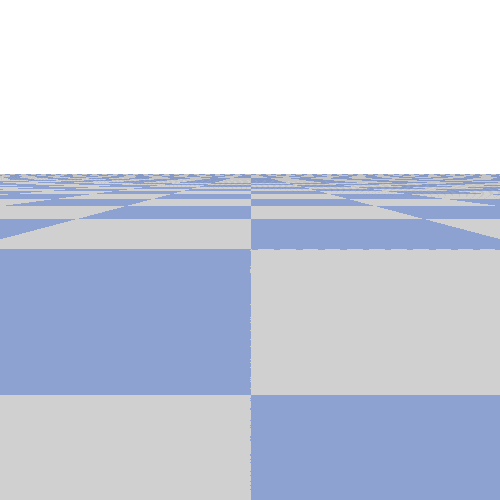

rgba shape=(500, 500, 4), dtype=uint8


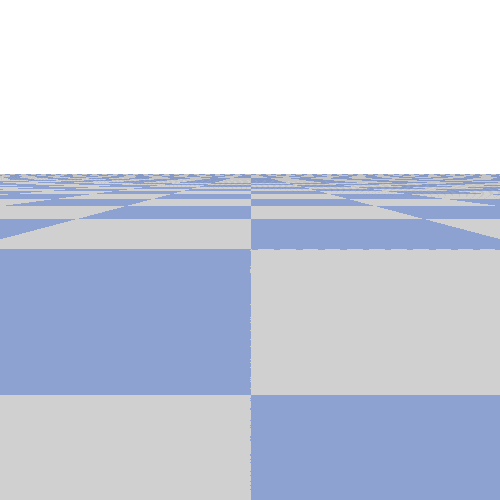

rgba shape=(500, 500, 4), dtype=uint8


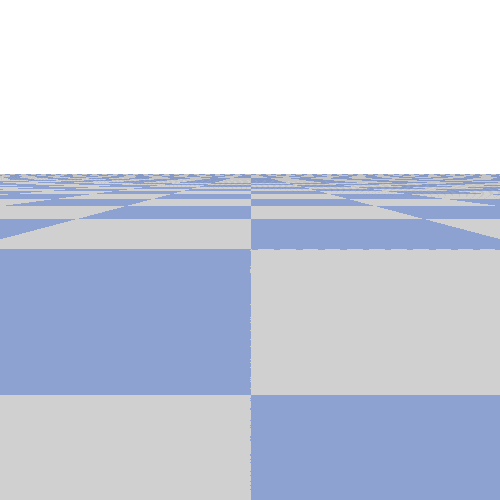

rgba shape=(500, 500, 4), dtype=uint8


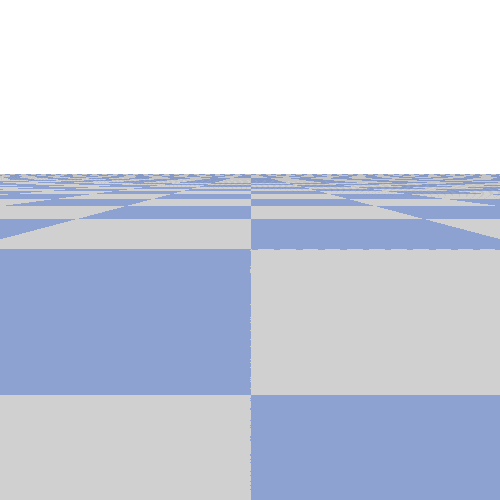

rgba shape=(500, 500, 4), dtype=uint8


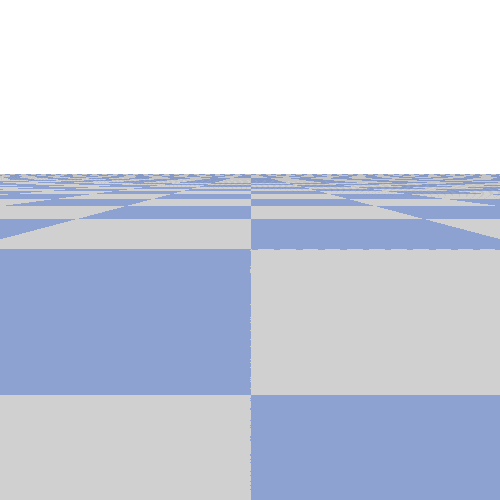

rgba shape=(500, 500, 4), dtype=uint8


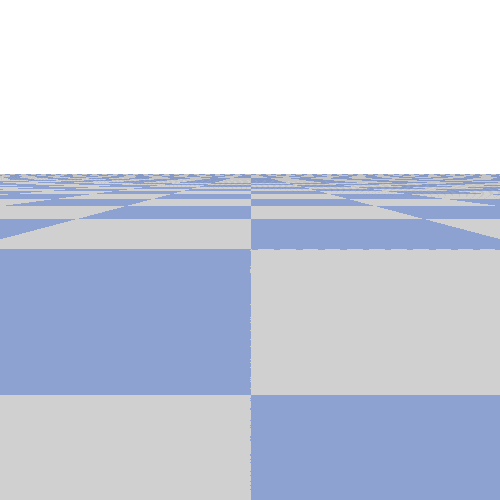

rgba shape=(500, 500, 4), dtype=uint8


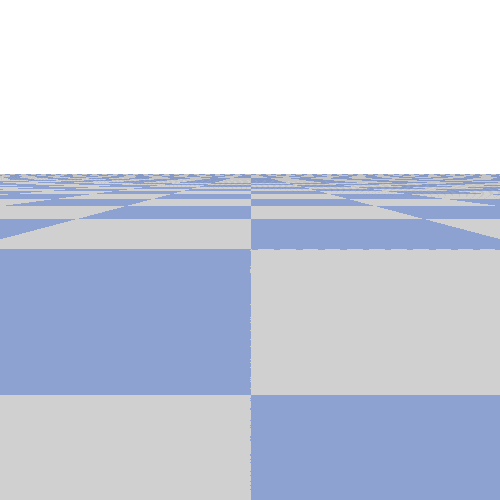

rgba shape=(500, 500, 4), dtype=uint8


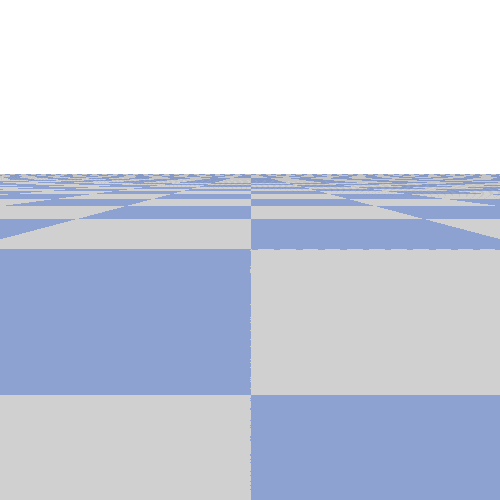

rgba shape=(500, 500, 4), dtype=uint8


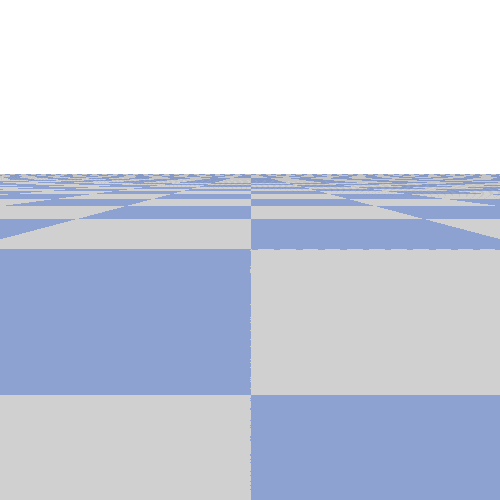

rgba shape=(500, 500, 4), dtype=uint8


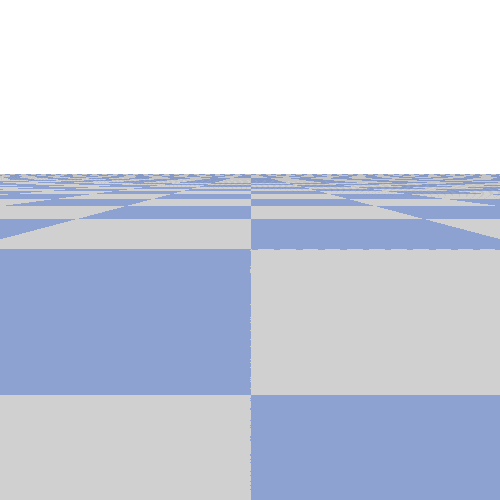

rgba shape=(500, 500, 4), dtype=uint8


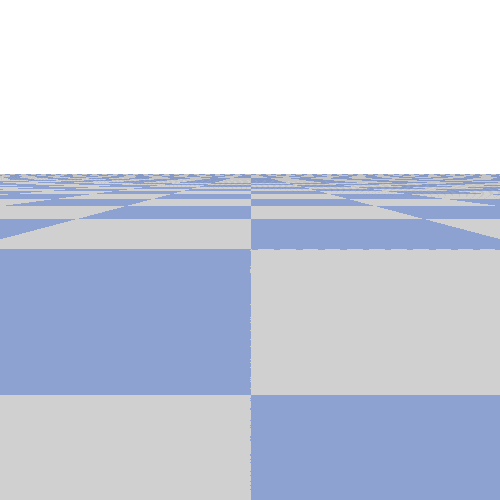

rgba shape=(500, 500, 4), dtype=uint8


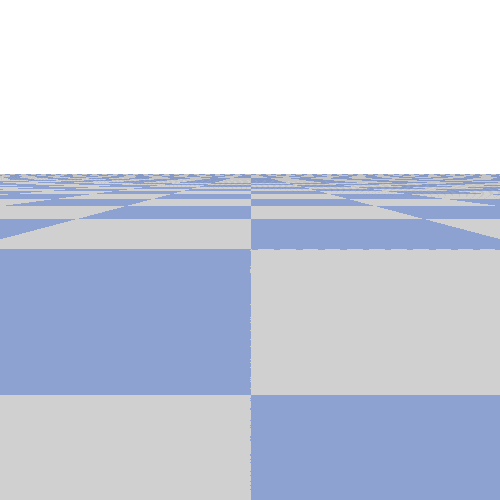

rgba shape=(500, 500, 4), dtype=uint8


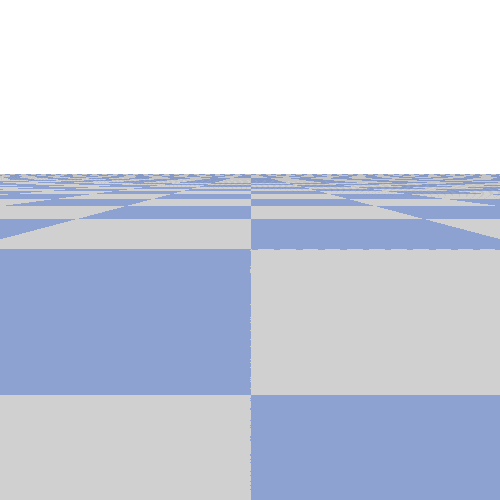

rgba shape=(500, 500, 4), dtype=uint8


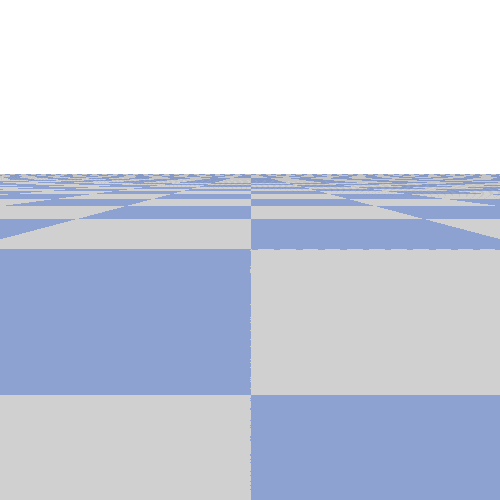

rgba shape=(500, 500, 4), dtype=uint8


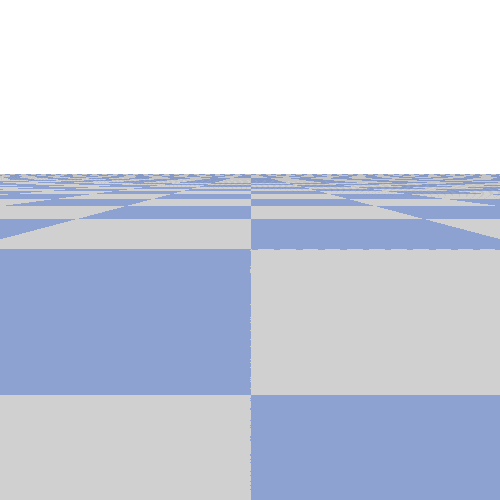

rgba shape=(500, 500, 4), dtype=uint8


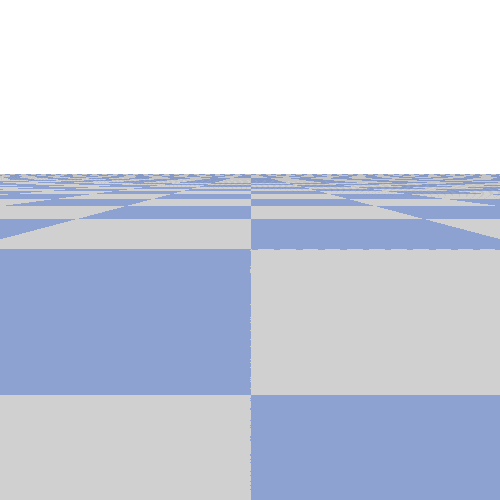

rgba shape=(500, 500, 4), dtype=uint8


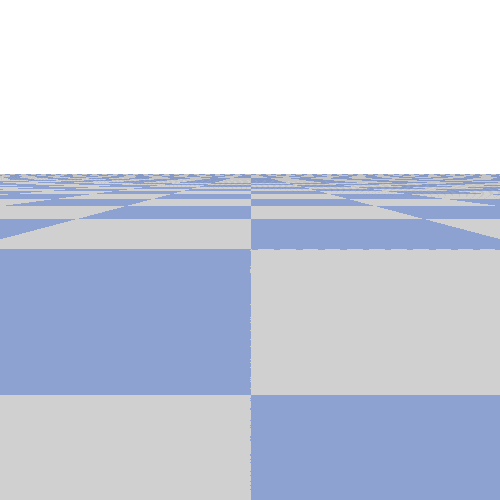

fail
rgba shape=(500, 500, 4), dtype=uint8


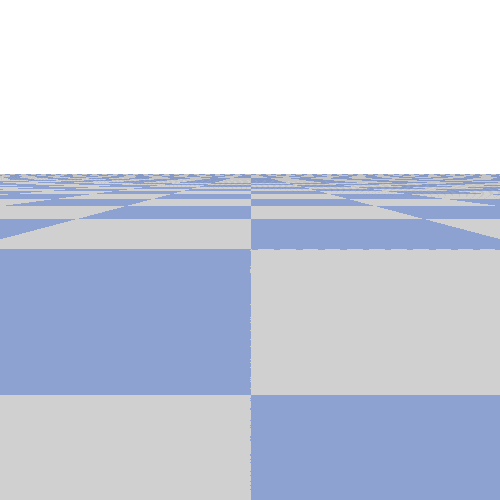

rgba shape=(500, 500, 4), dtype=uint8


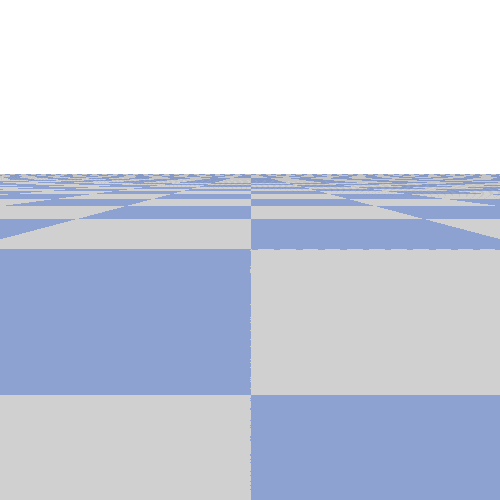

rgba shape=(500, 500, 4), dtype=uint8


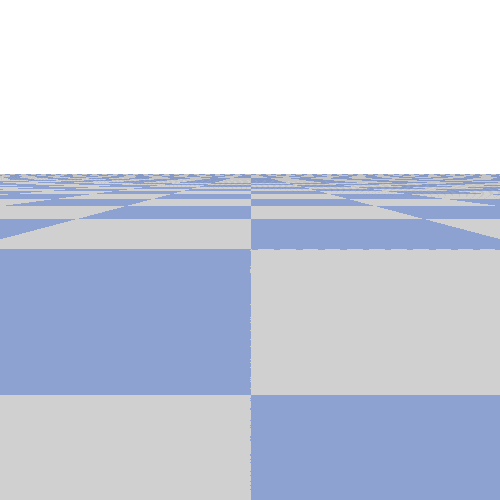

rgba shape=(500, 500, 4), dtype=uint8


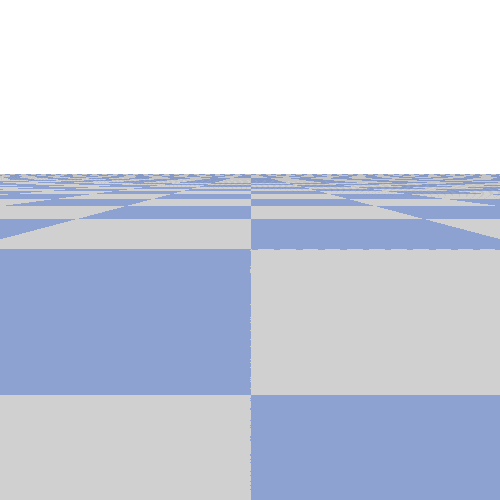

rgba shape=(500, 500, 4), dtype=uint8


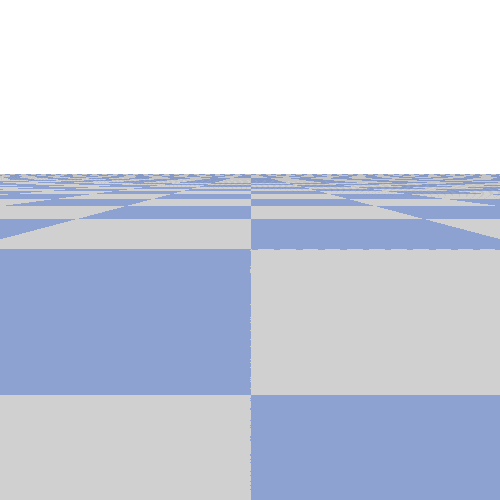

rgba shape=(500, 500, 4), dtype=uint8


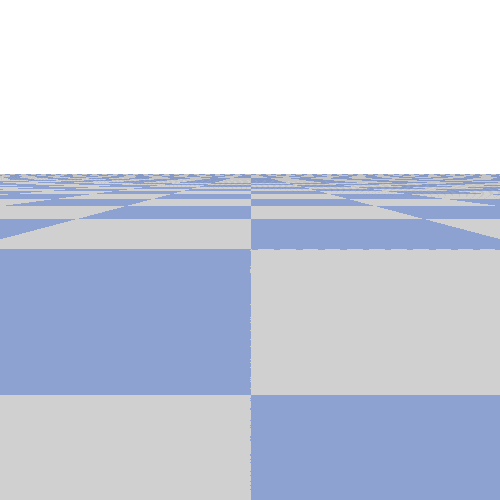

rgba shape=(500, 500, 4), dtype=uint8


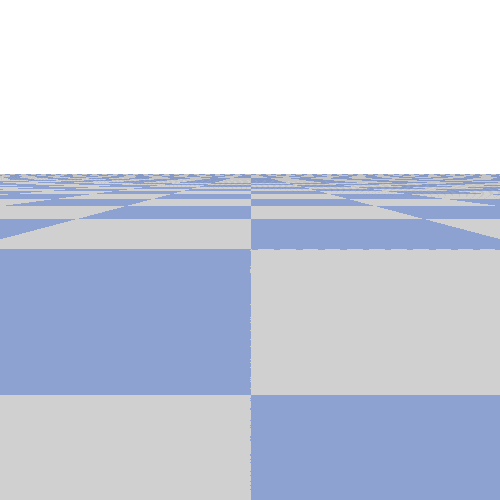

rgba shape=(500, 500, 4), dtype=uint8


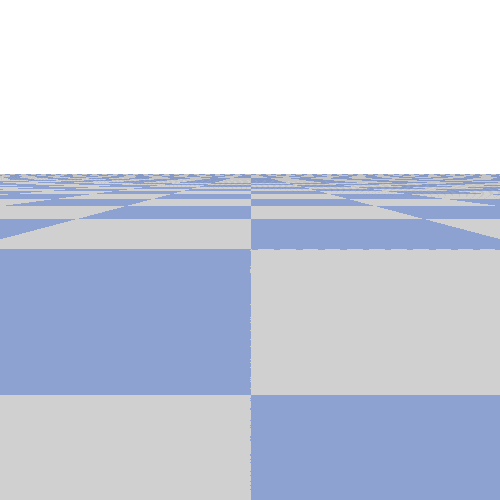

rgba shape=(500, 500, 4), dtype=uint8


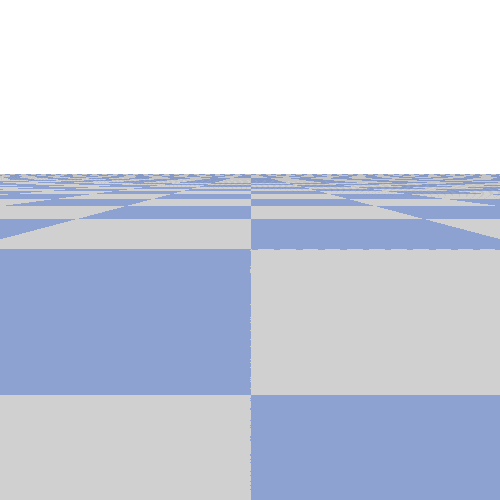

fail
rgba shape=(500, 500, 4), dtype=uint8


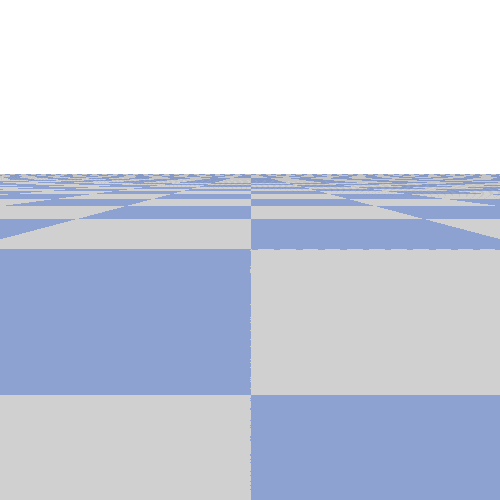

rgba shape=(500, 500, 4), dtype=uint8


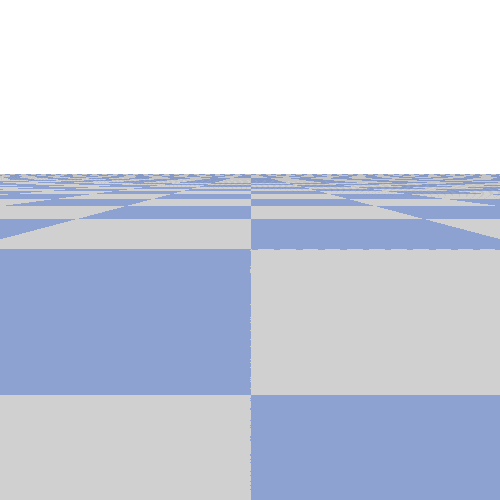

rgba shape=(500, 500, 4), dtype=uint8


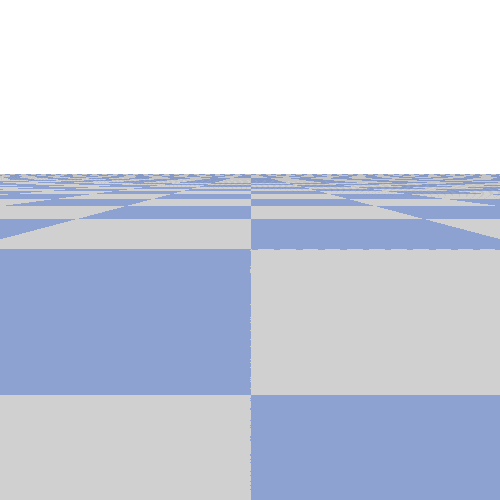

fail
rgba shape=(500, 500, 4), dtype=uint8


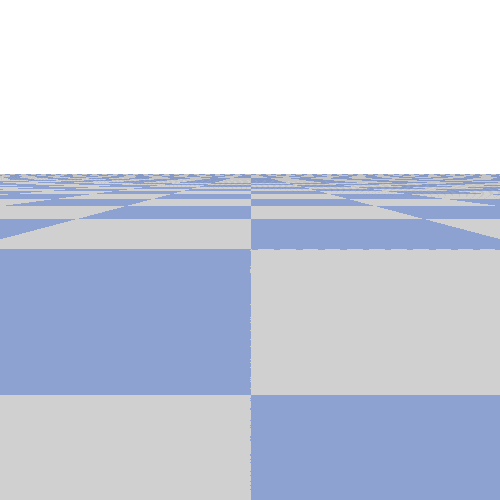

rgba shape=(500, 500, 4), dtype=uint8


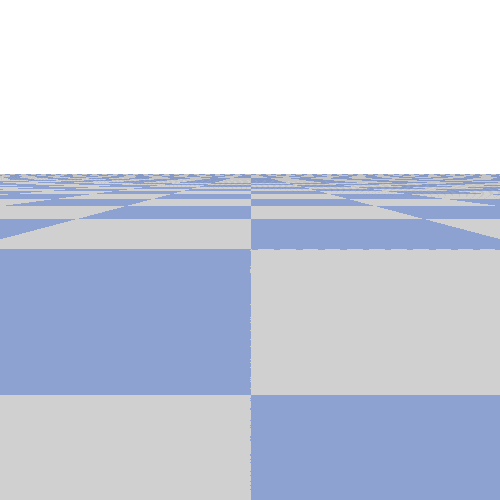

rgba shape=(500, 500, 4), dtype=uint8


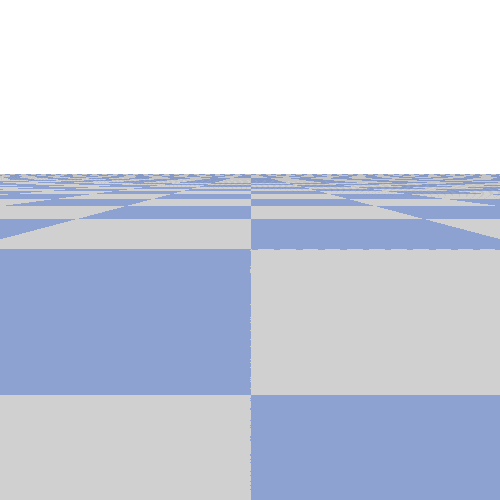

rgba shape=(500, 500, 4), dtype=uint8


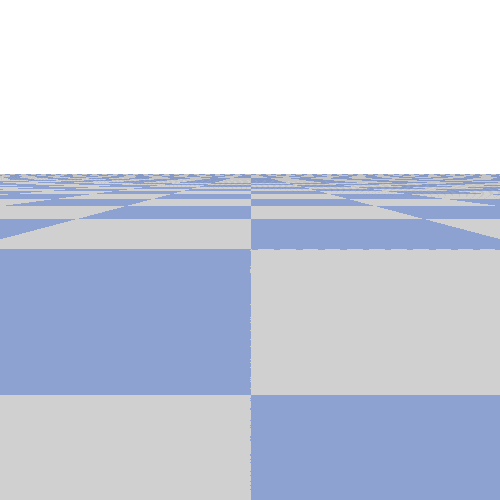

fail
rgba shape=(500, 500, 4), dtype=uint8


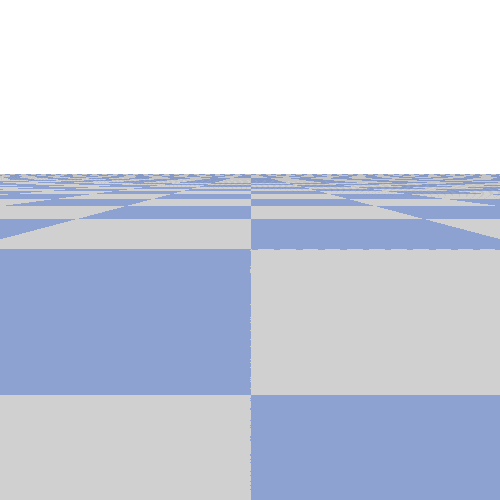

rgba shape=(500, 500, 4), dtype=uint8


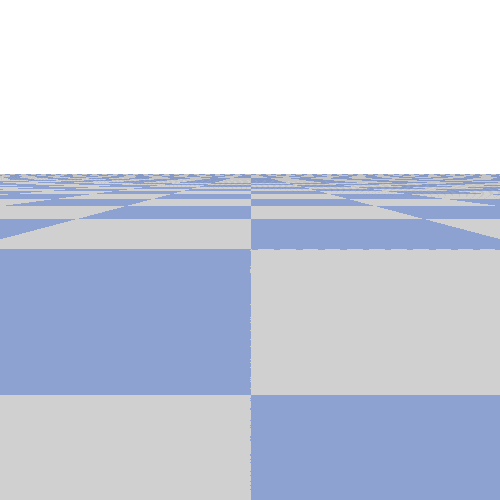

rgba shape=(500, 500, 4), dtype=uint8


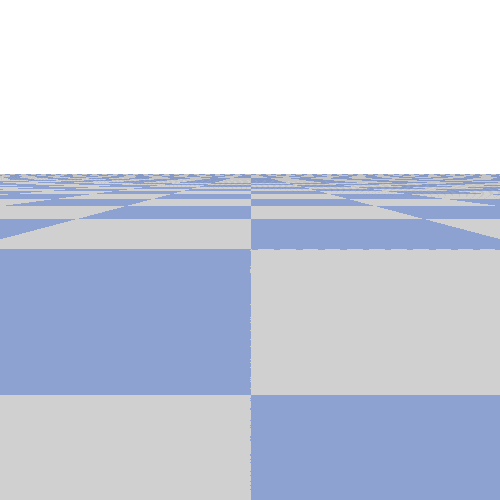

rgba shape=(500, 500, 4), dtype=uint8


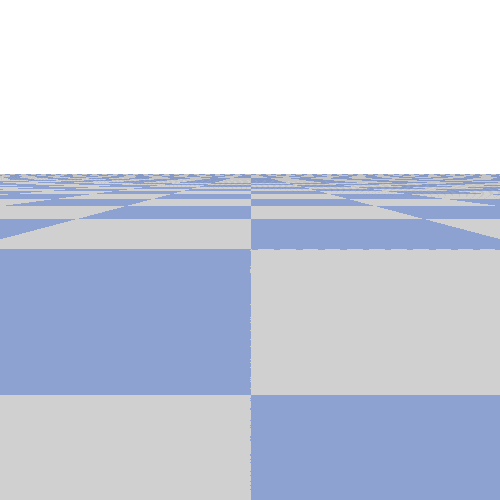

rgba shape=(500, 500, 4), dtype=uint8


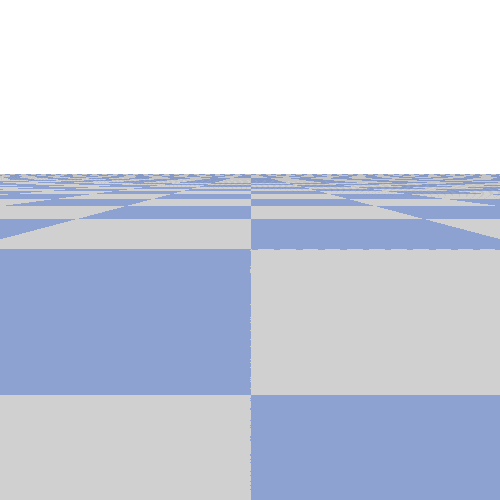

rgba shape=(500, 500, 4), dtype=uint8


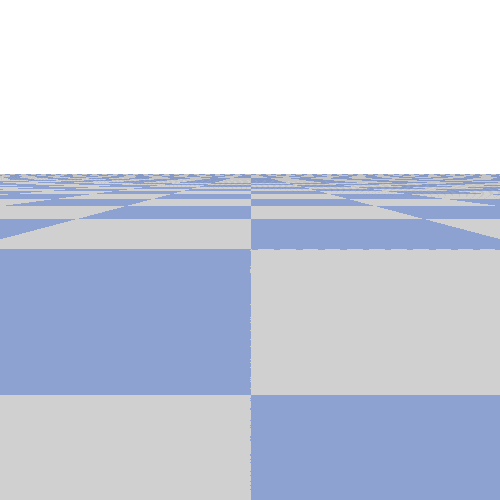

rgba shape=(500, 500, 4), dtype=uint8


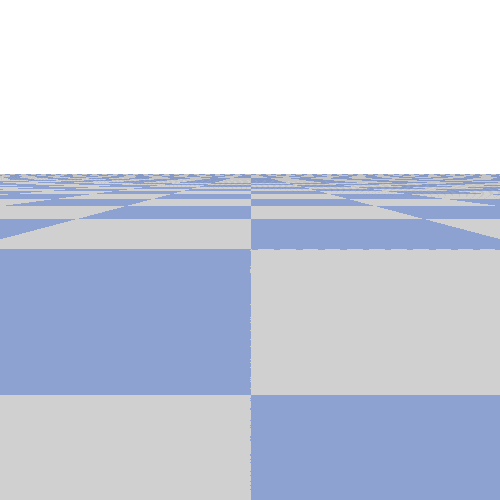

rgba shape=(500, 500, 4), dtype=uint8


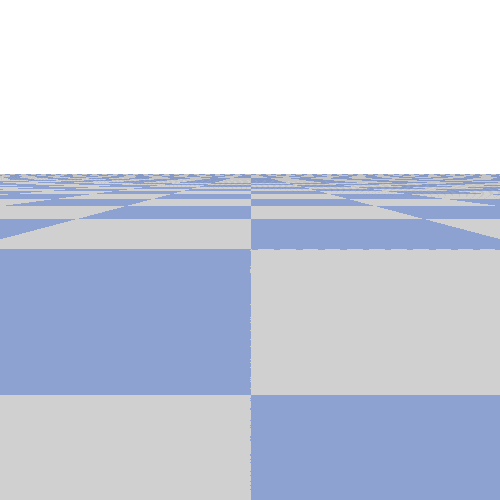

rgba shape=(500, 500, 4), dtype=uint8


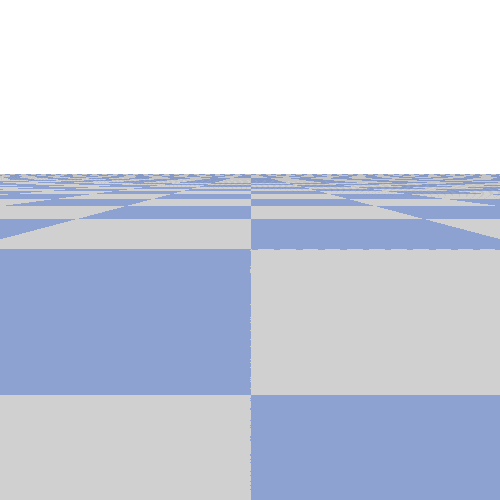

rgba shape=(500, 500, 4), dtype=uint8


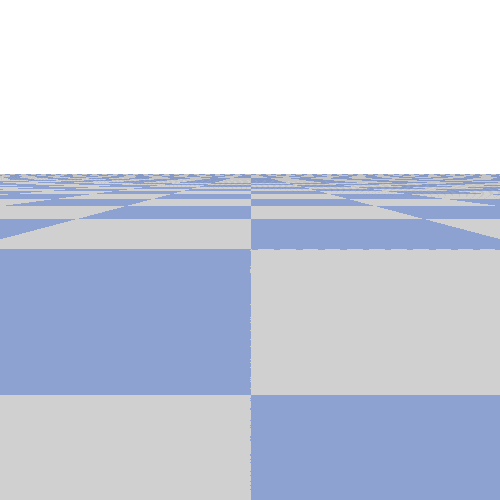

rgba shape=(500, 500, 4), dtype=uint8


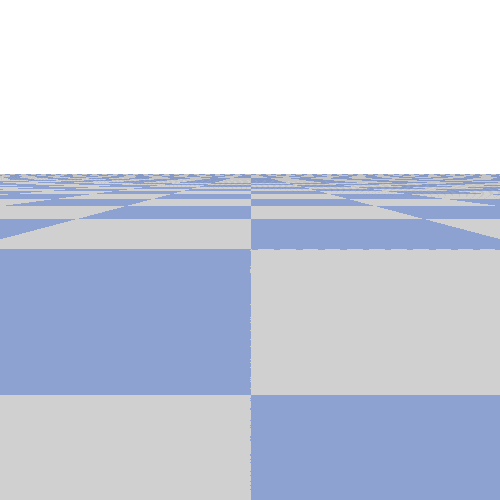

rgba shape=(500, 500, 4), dtype=uint8


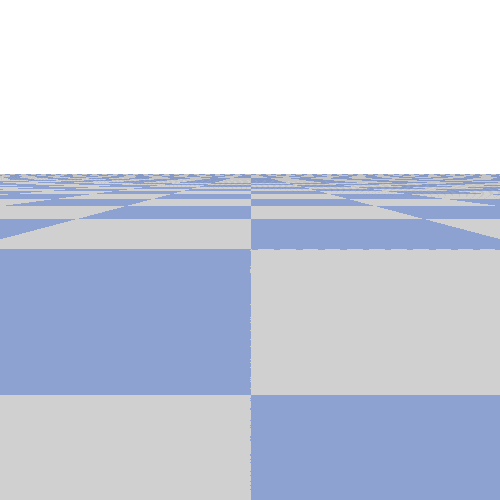

rgba shape=(500, 500, 4), dtype=uint8


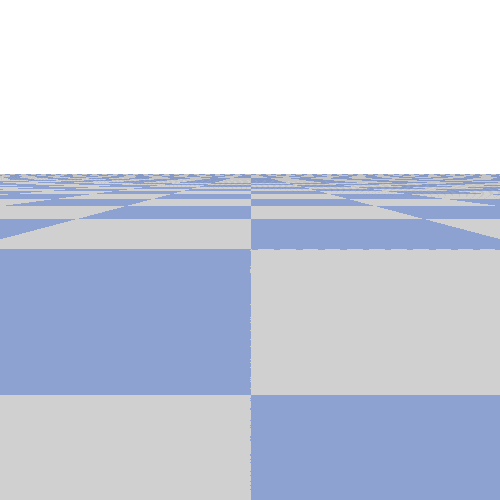

rgba shape=(500, 500, 4), dtype=uint8


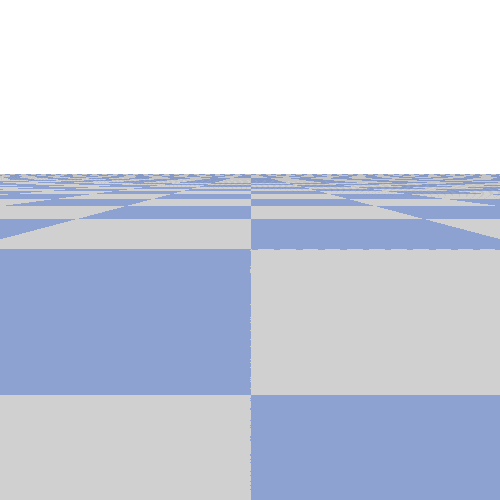

rgba shape=(500, 500, 4), dtype=uint8


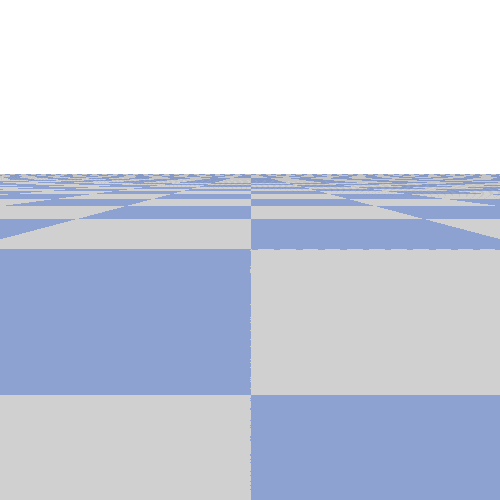

rgba shape=(500, 500, 4), dtype=uint8


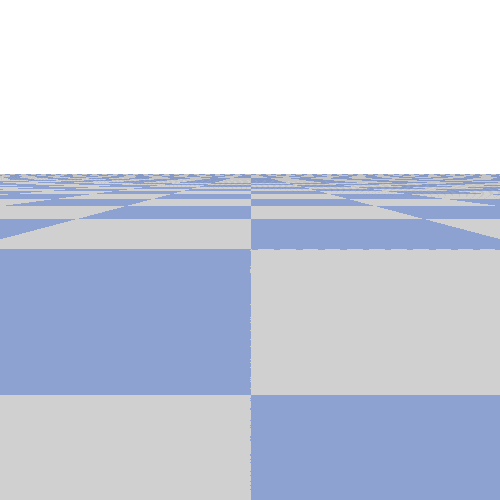

rgba shape=(500, 500, 4), dtype=uint8


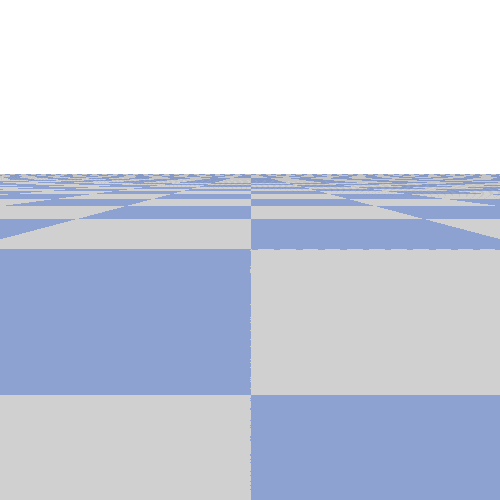

rgba shape=(500, 500, 4), dtype=uint8


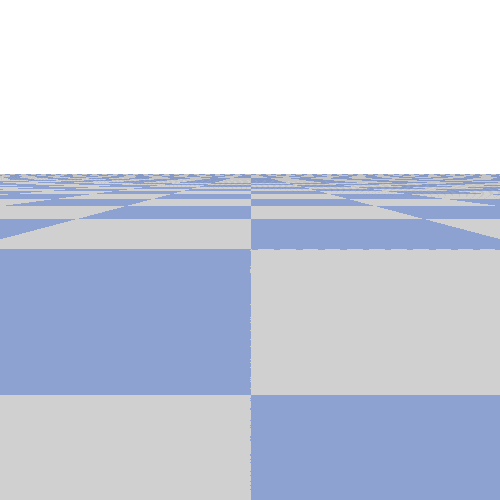

fail
rgba shape=(500, 500, 4), dtype=uint8


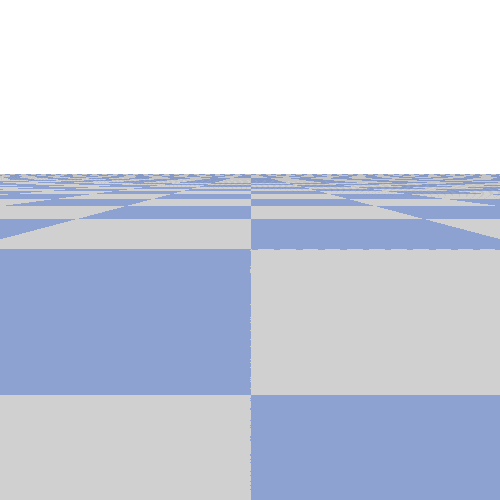

rgba shape=(500, 500, 4), dtype=uint8


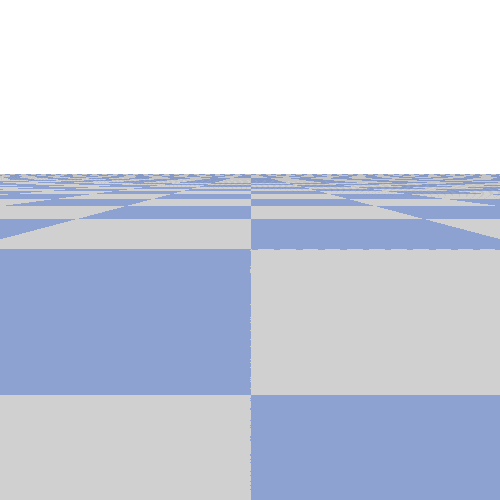

rgba shape=(500, 500, 4), dtype=uint8


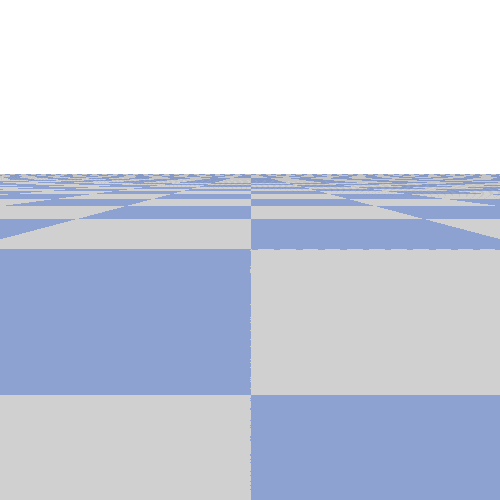

rgba shape=(500, 500, 4), dtype=uint8


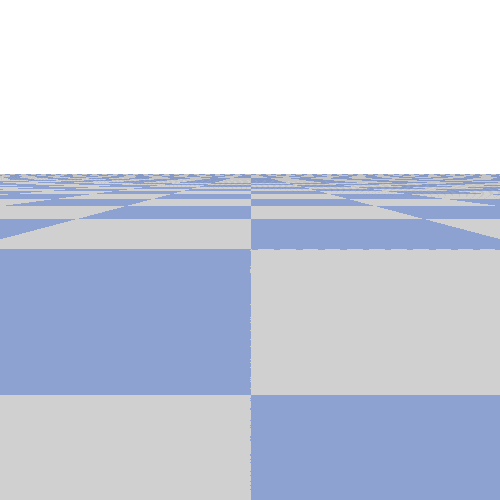

rgba shape=(500, 500, 4), dtype=uint8


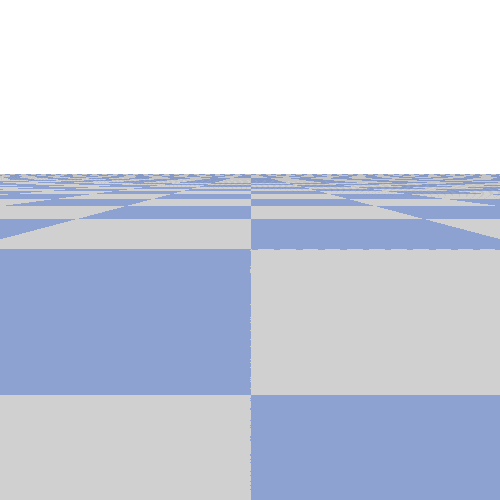

rgba shape=(500, 500, 4), dtype=uint8


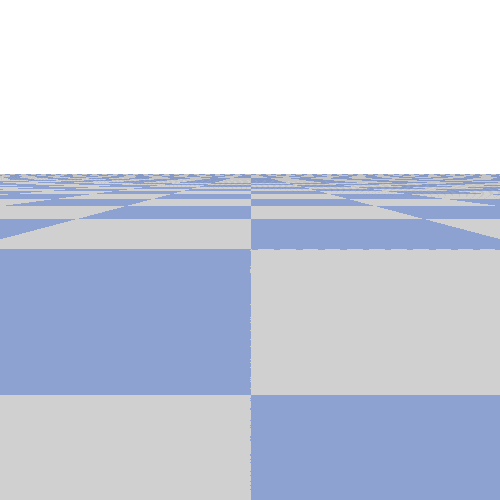

rgba shape=(500, 500, 4), dtype=uint8


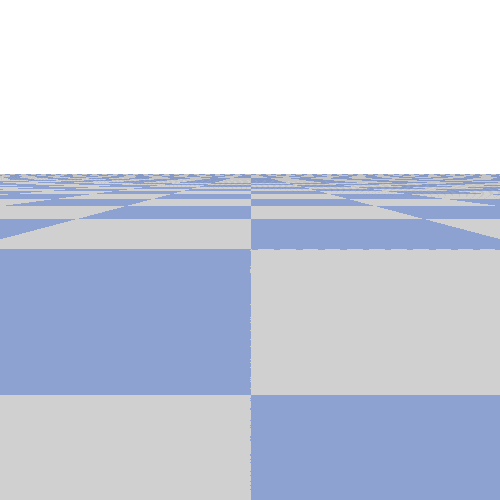

rgba shape=(500, 500, 4), dtype=uint8


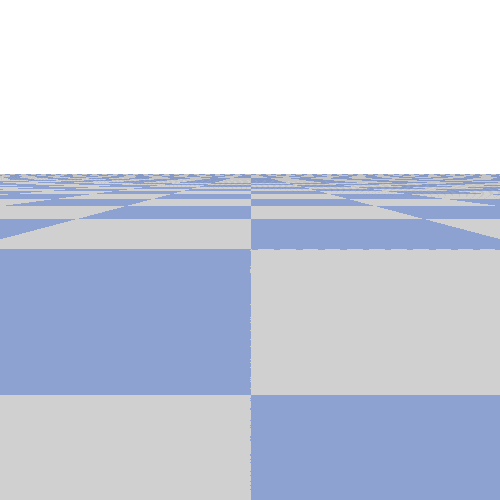

rgba shape=(500, 500, 4), dtype=uint8


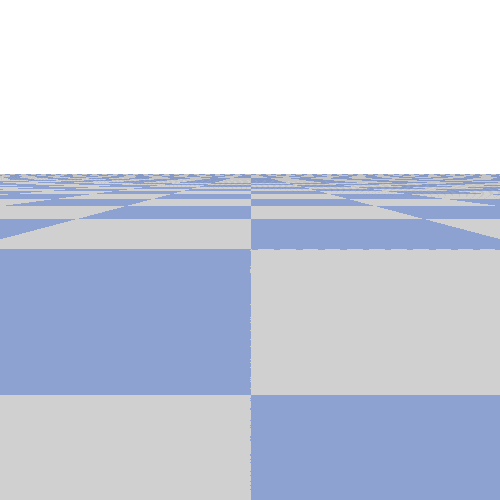

rgba shape=(500, 500, 4), dtype=uint8


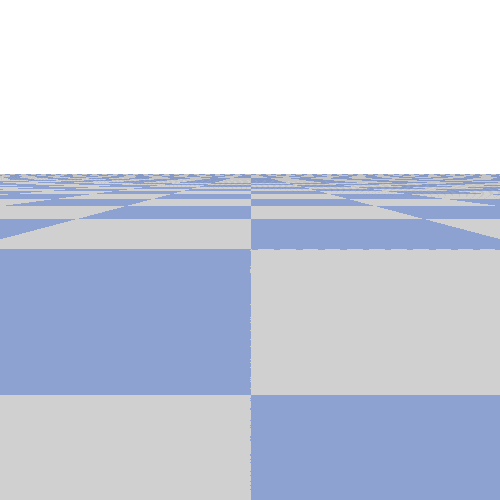

rgba shape=(500, 500, 4), dtype=uint8


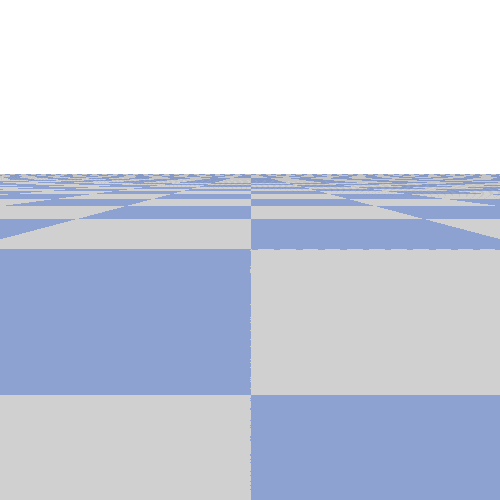

rgba shape=(500, 500, 4), dtype=uint8


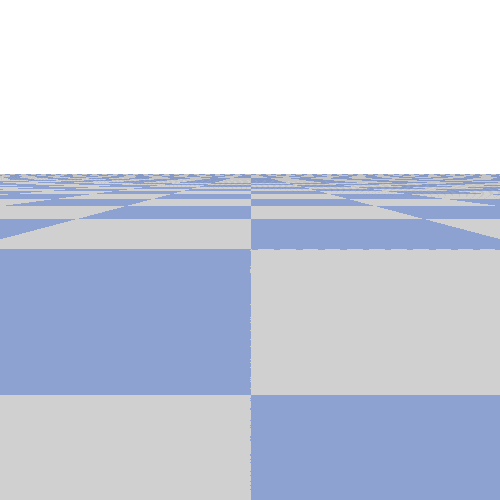

rgba shape=(500, 500, 4), dtype=uint8


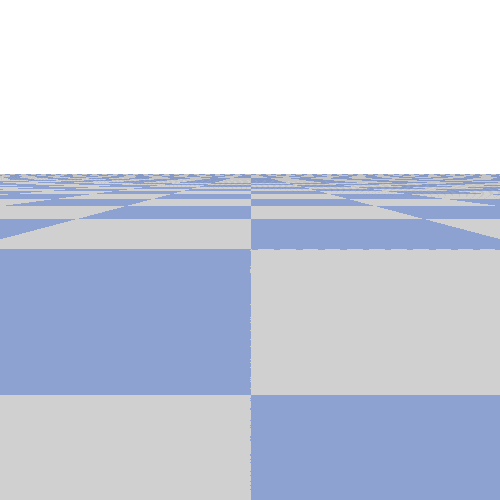

rgba shape=(500, 500, 4), dtype=uint8


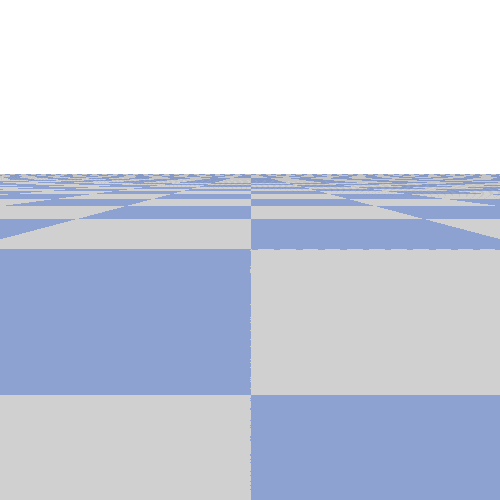

rgba shape=(500, 500, 4), dtype=uint8


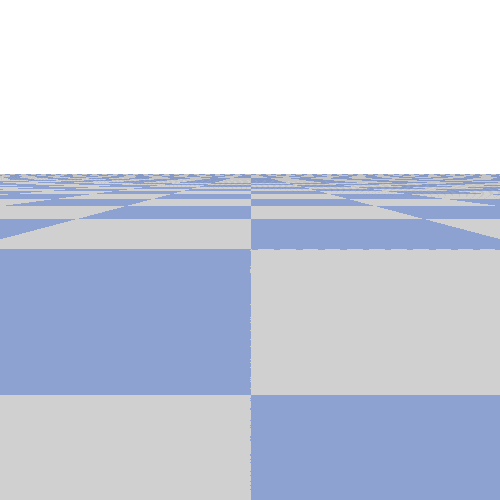

rgba shape=(500, 500, 4), dtype=uint8


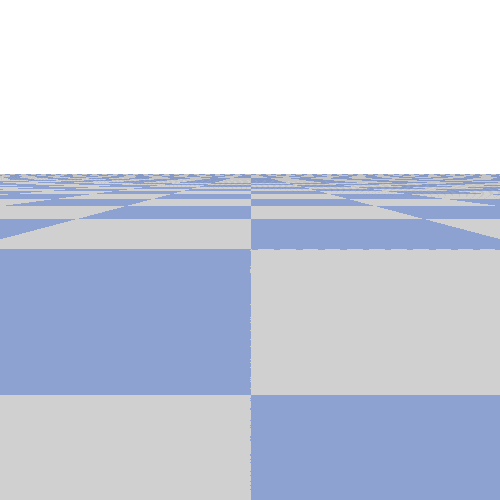

rgba shape=(500, 500, 4), dtype=uint8


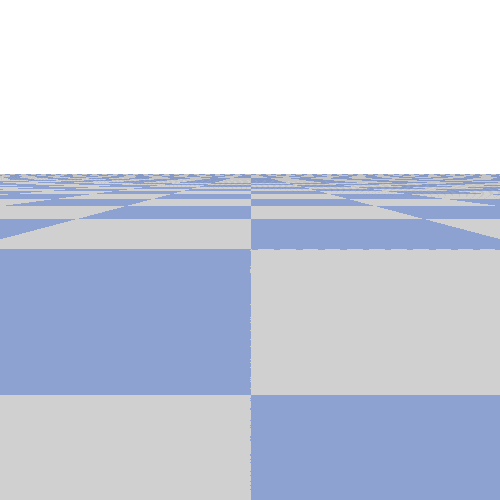

rgba shape=(500, 500, 4), dtype=uint8


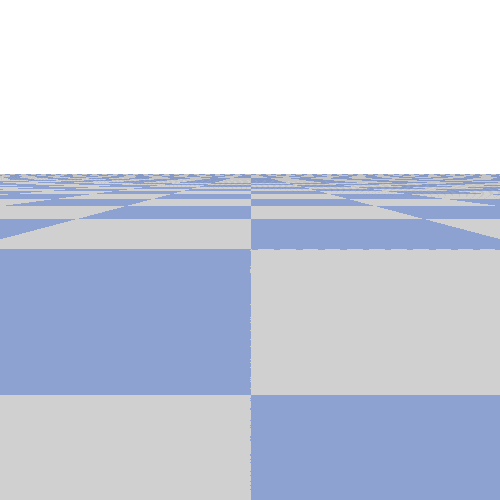

rgba shape=(500, 500, 4), dtype=uint8


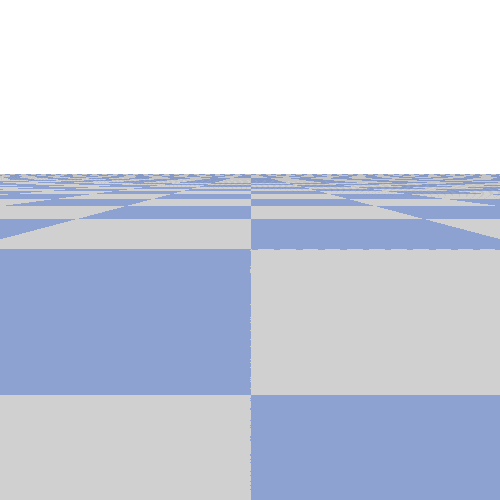

rgba shape=(500, 500, 4), dtype=uint8


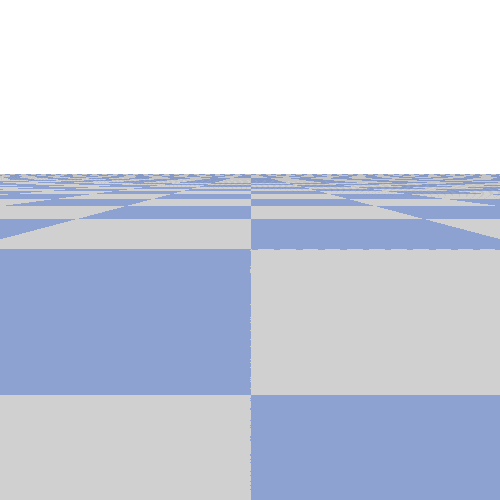

rgba shape=(500, 500, 4), dtype=uint8


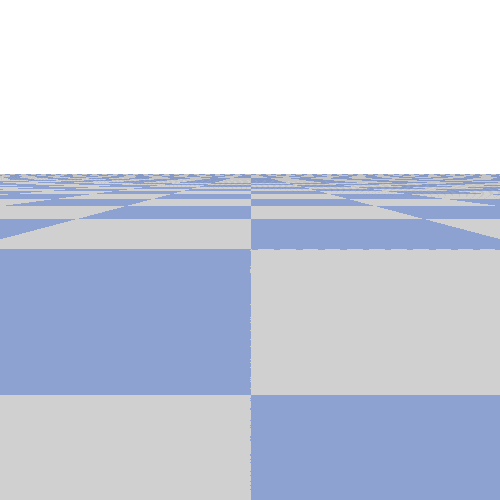

rgba shape=(500, 500, 4), dtype=uint8


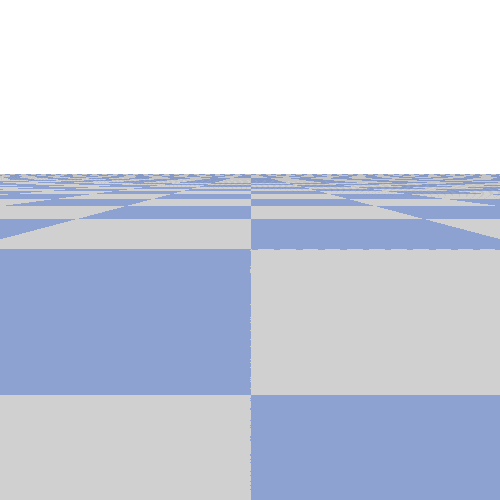

rgba shape=(500, 500, 4), dtype=uint8


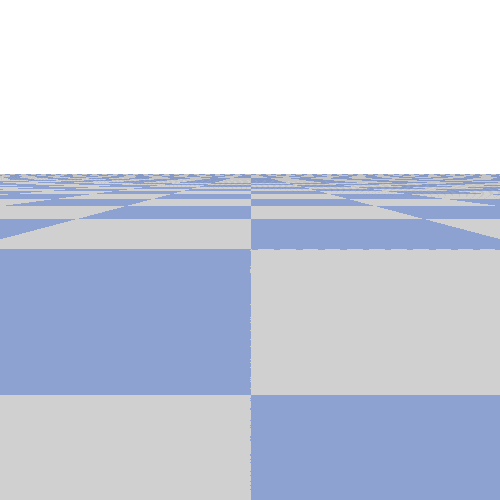

rgba shape=(500, 500, 4), dtype=uint8


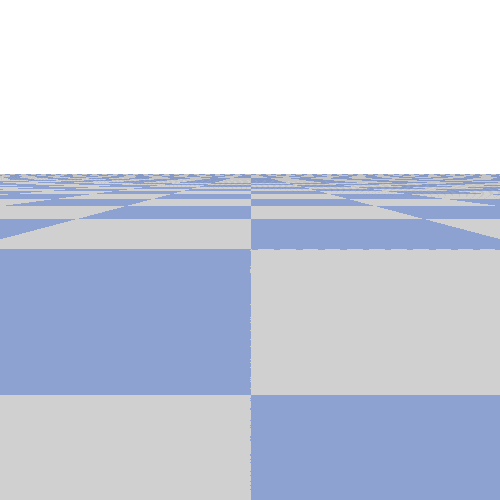

rgba shape=(500, 500, 4), dtype=uint8


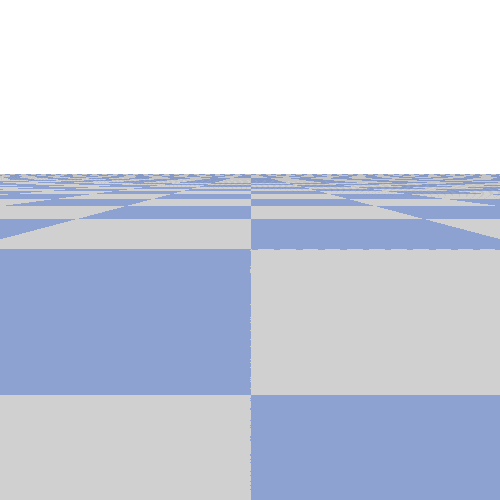

rgba shape=(500, 500, 4), dtype=uint8


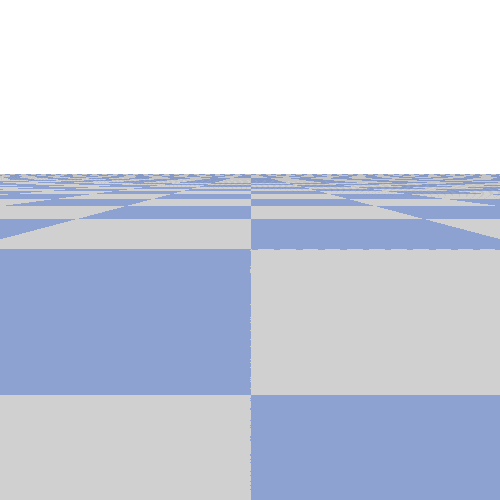

rgba shape=(500, 500, 4), dtype=uint8


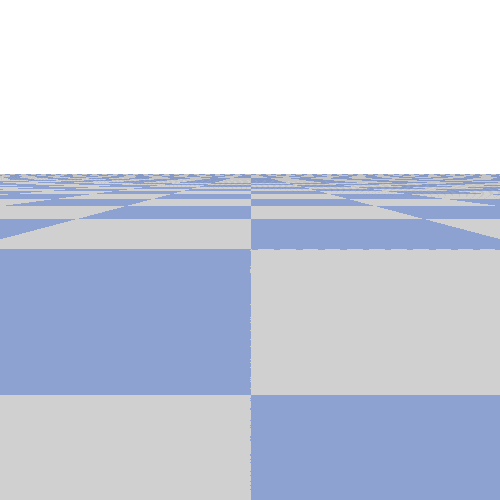

rgba shape=(500, 500, 4), dtype=uint8


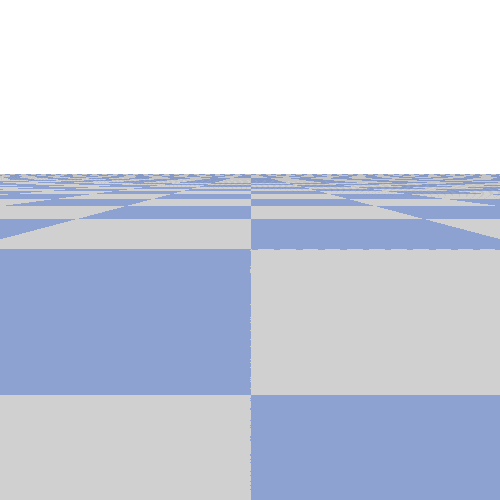

rgba shape=(500, 500, 4), dtype=uint8


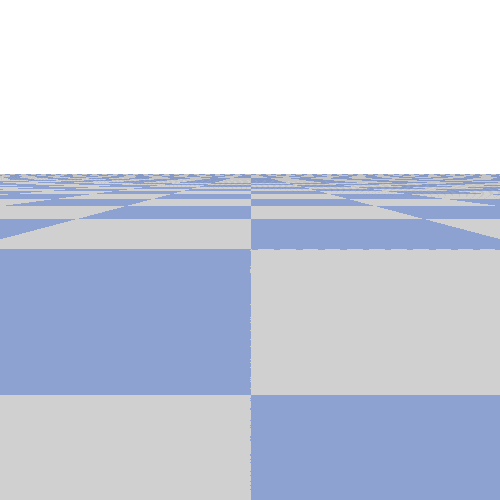

rgba shape=(500, 500, 4), dtype=uint8


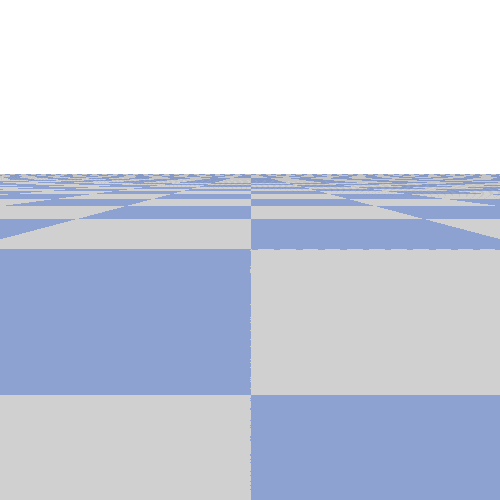

rgba shape=(500, 500, 4), dtype=uint8


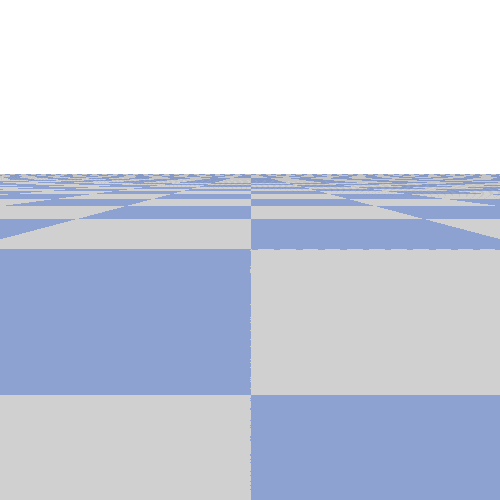

rgba shape=(500, 500, 4), dtype=uint8


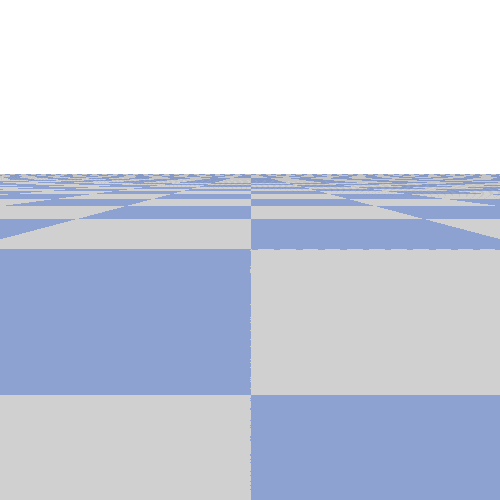

rgba shape=(500, 500, 4), dtype=uint8


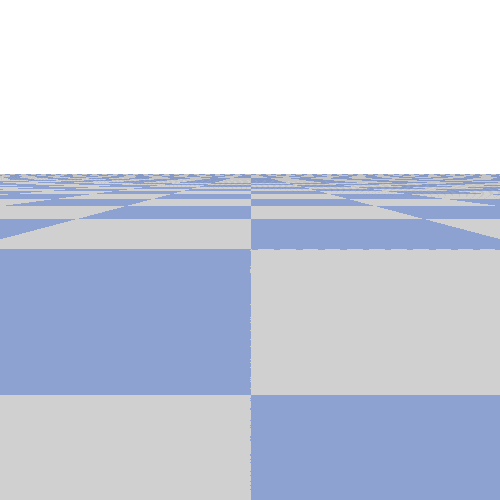

rgba shape=(500, 500, 4), dtype=uint8


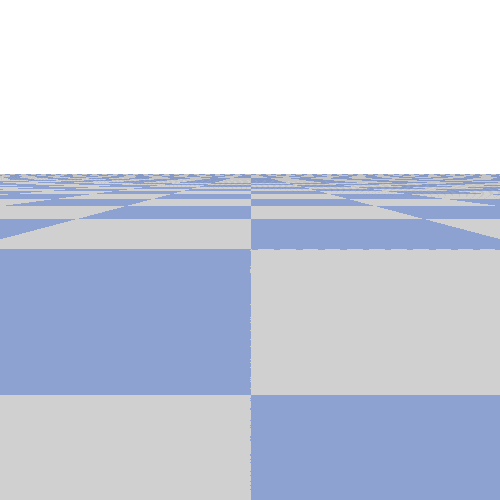

rgba shape=(500, 500, 4), dtype=uint8


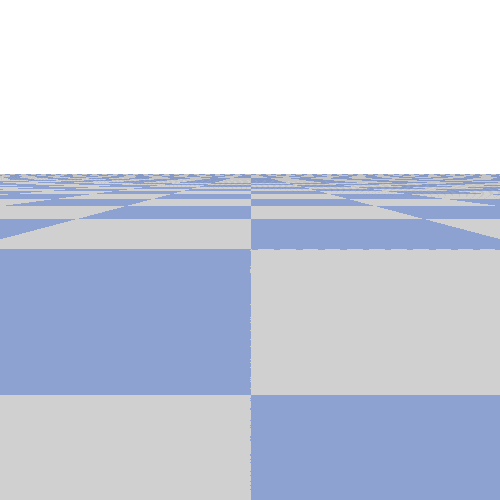

rgba shape=(500, 500, 4), dtype=uint8


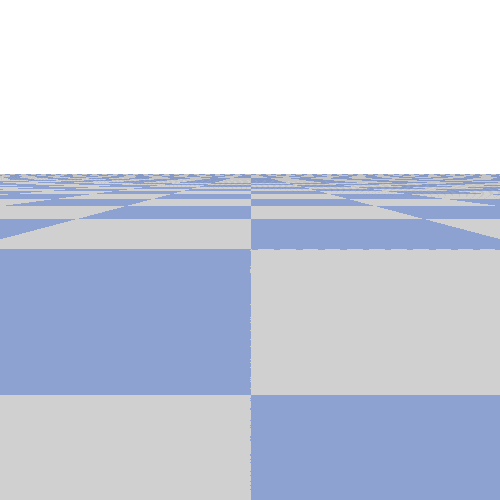

rgba shape=(500, 500, 4), dtype=uint8


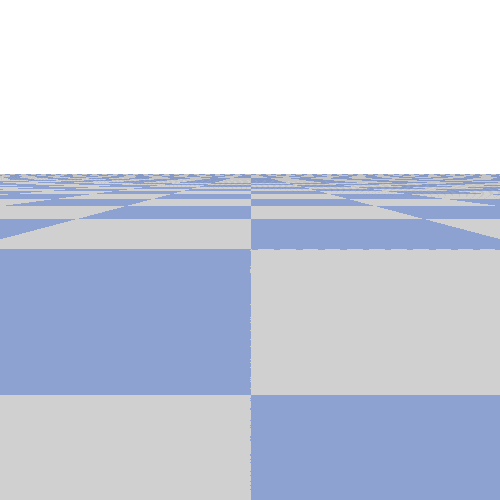

rgba shape=(500, 500, 4), dtype=uint8


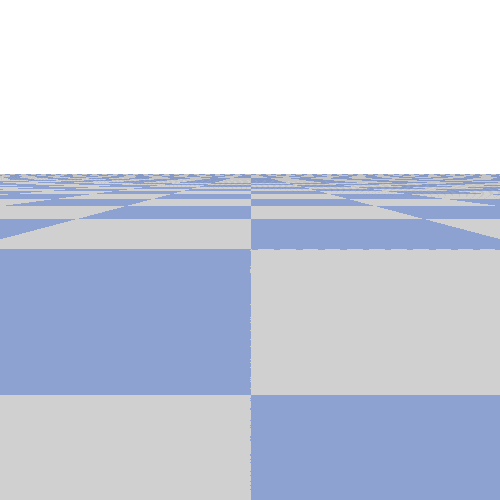

rgba shape=(500, 500, 4), dtype=uint8


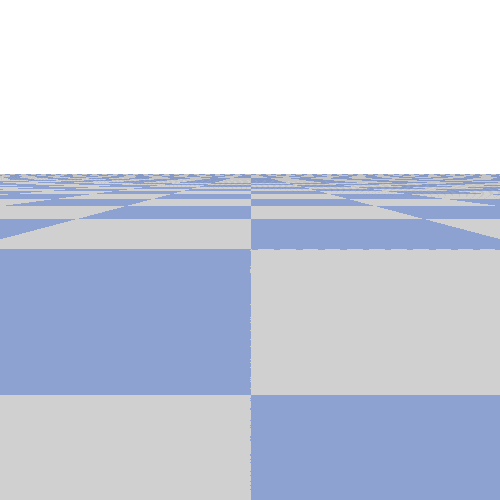

rgba shape=(500, 500, 4), dtype=uint8


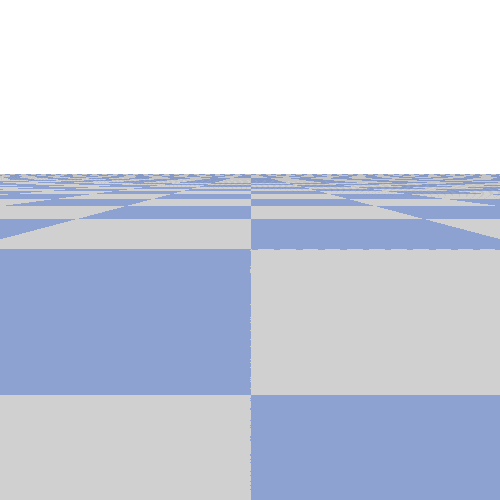

rgba shape=(500, 500, 4), dtype=uint8


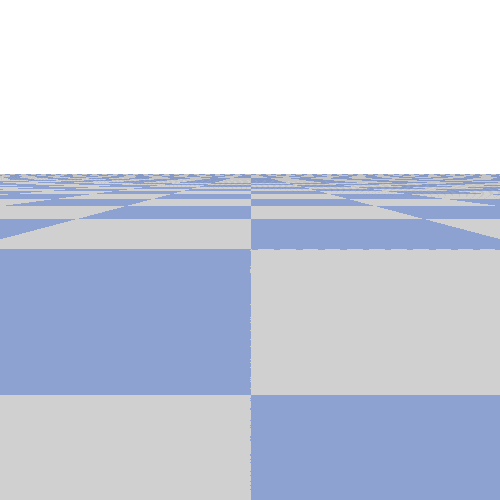

rgba shape=(500, 500, 4), dtype=uint8


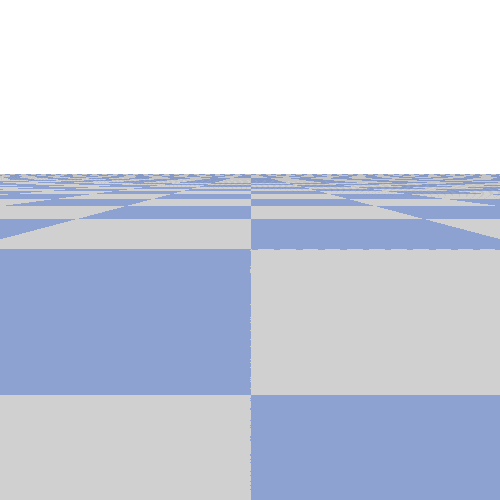

rgba shape=(500, 500, 4), dtype=uint8


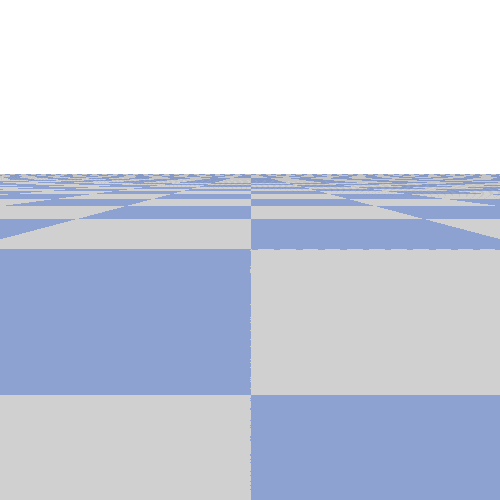

rgba shape=(500, 500, 4), dtype=uint8


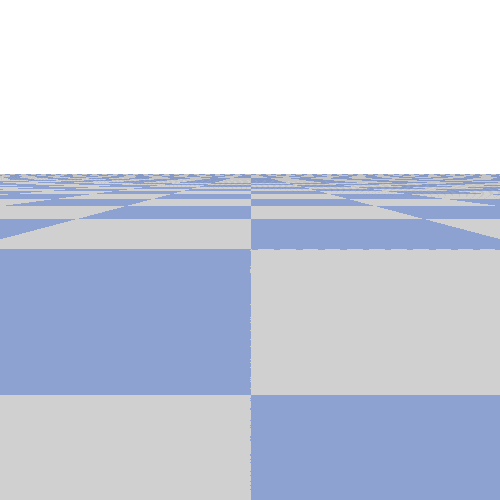

rgba shape=(500, 500, 4), dtype=uint8


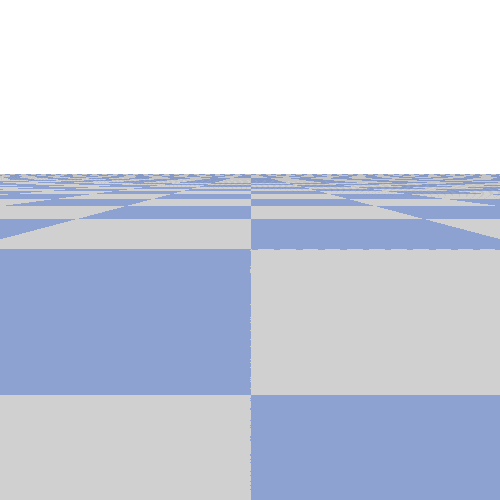

rgba shape=(500, 500, 4), dtype=uint8


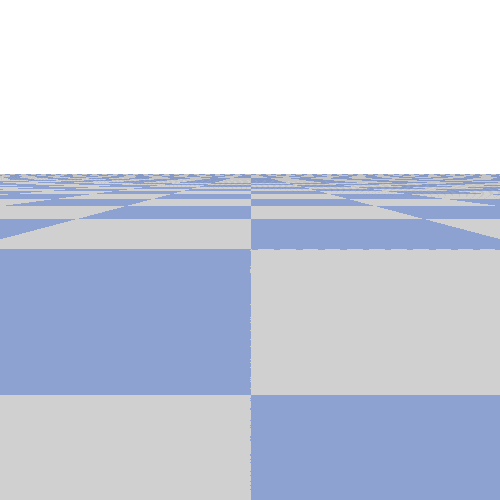

rgba shape=(500, 500, 4), dtype=uint8


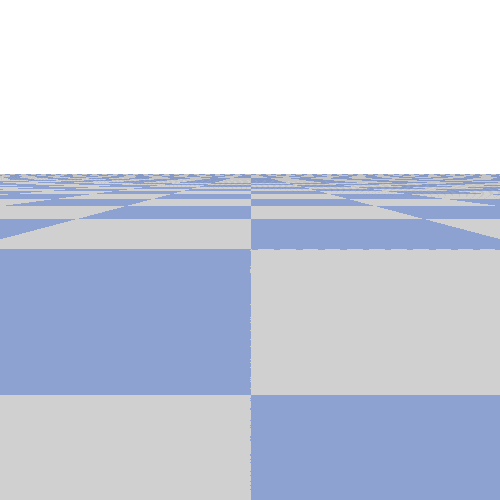

rgba shape=(500, 500, 4), dtype=uint8


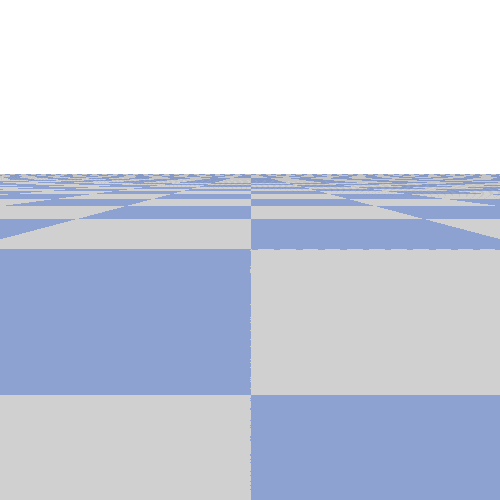

rgba shape=(500, 500, 4), dtype=uint8


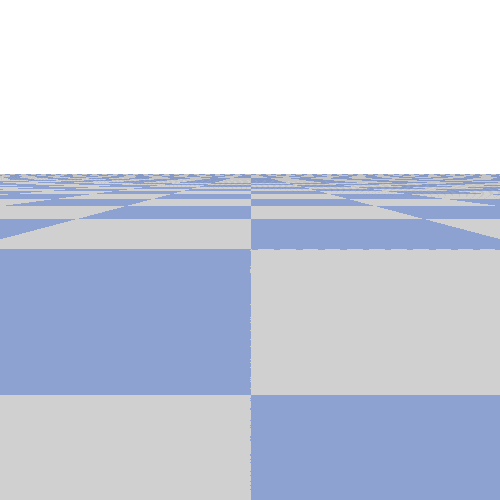

rgba shape=(500, 500, 4), dtype=uint8


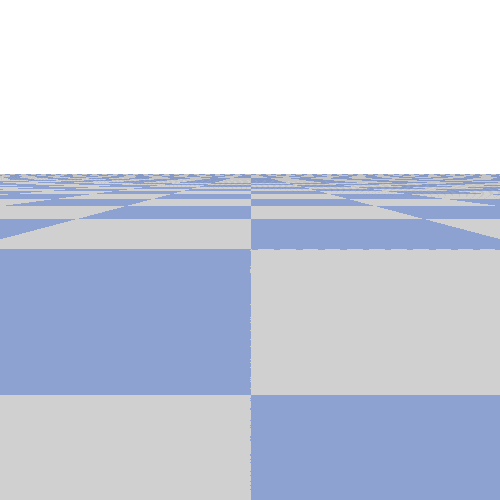

rgba shape=(500, 500, 4), dtype=uint8


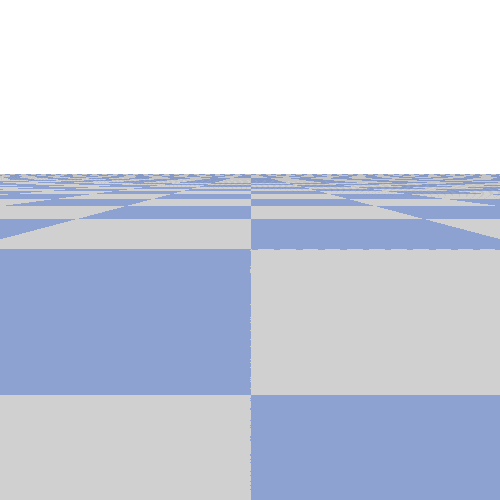

rgba shape=(500, 500, 4), dtype=uint8


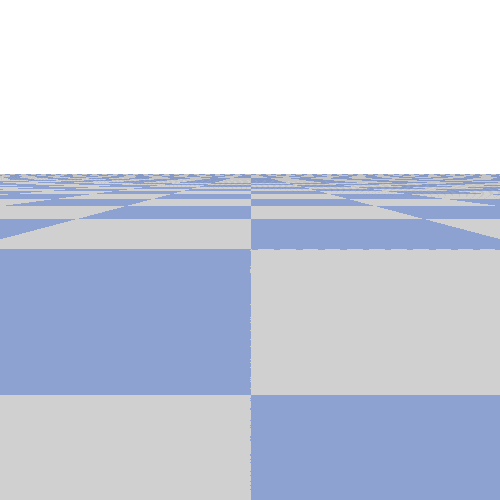

rgba shape=(500, 500, 4), dtype=uint8


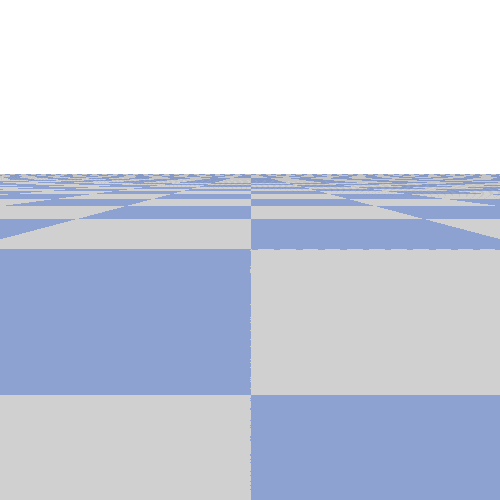

rgba shape=(500, 500, 4), dtype=uint8


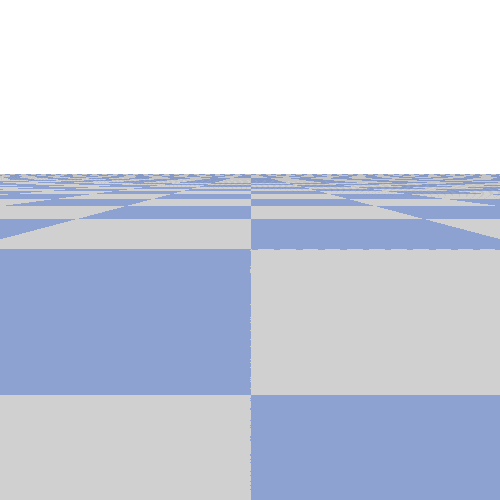

rgba shape=(500, 500, 4), dtype=uint8


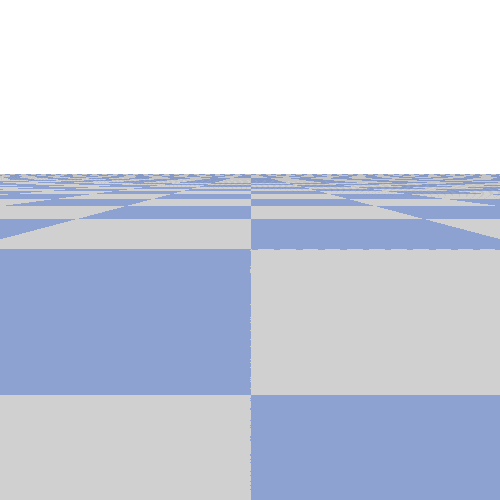

rgba shape=(500, 500, 4), dtype=uint8


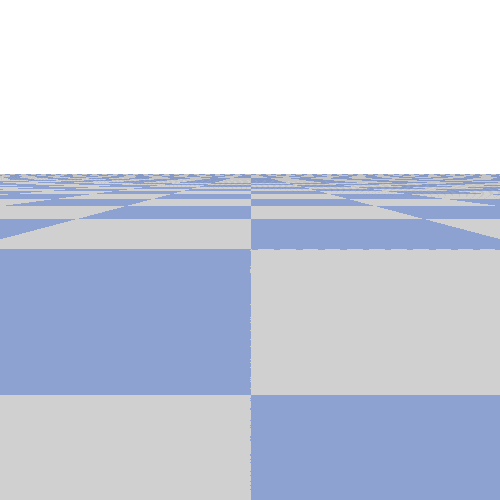

rgba shape=(500, 500, 4), dtype=uint8


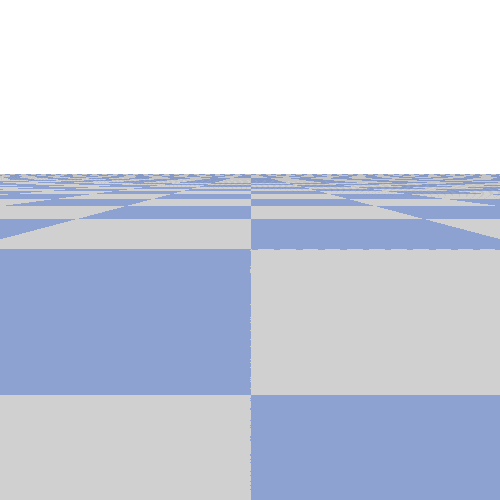

rgba shape=(500, 500, 4), dtype=uint8


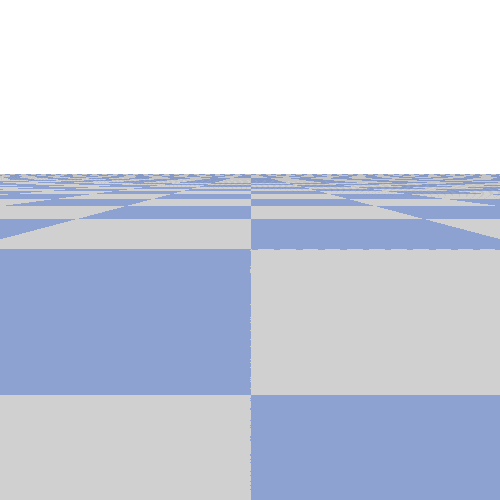

rgba shape=(500, 500, 4), dtype=uint8


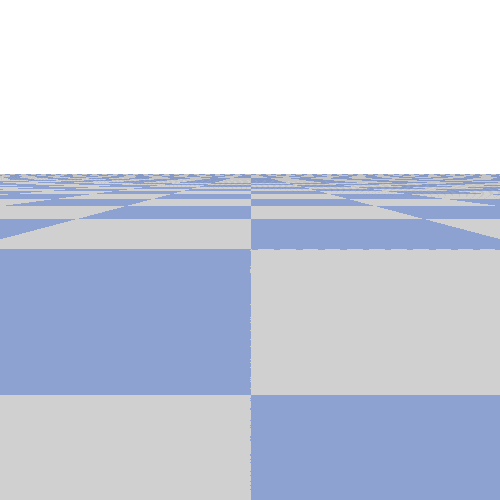

rgba shape=(500, 500, 4), dtype=uint8


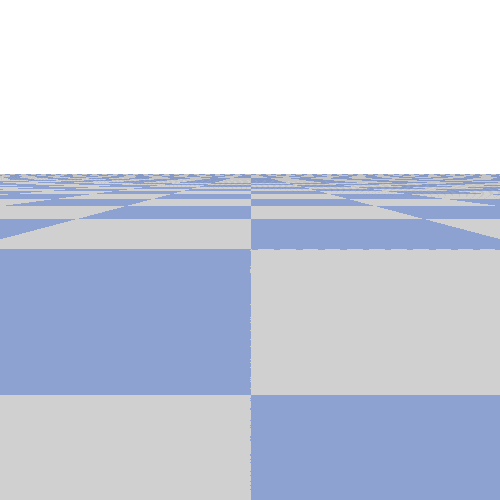

rgba shape=(500, 500, 4), dtype=uint8


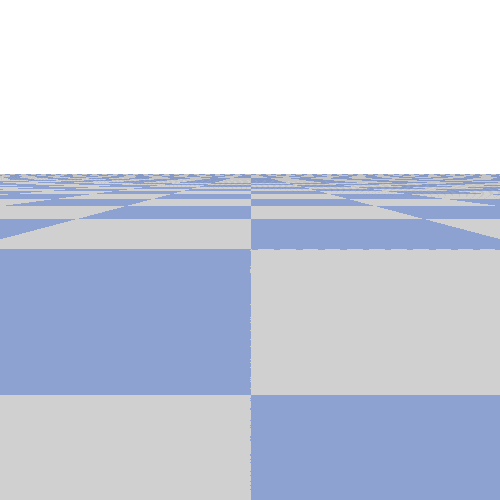

rgba shape=(500, 500, 4), dtype=uint8


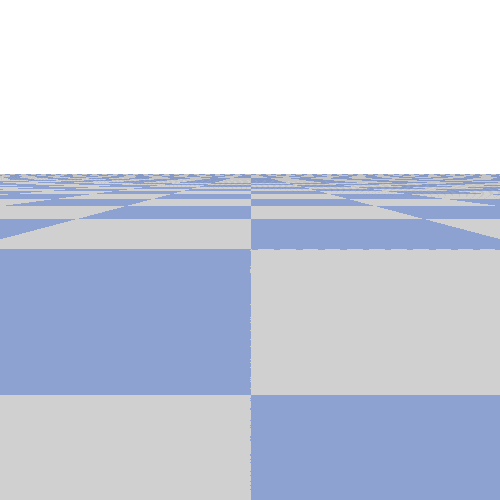

rgba shape=(500, 500, 4), dtype=uint8


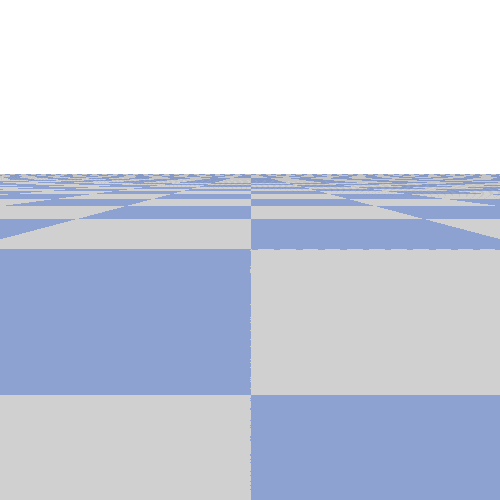

rgba shape=(500, 500, 4), dtype=uint8


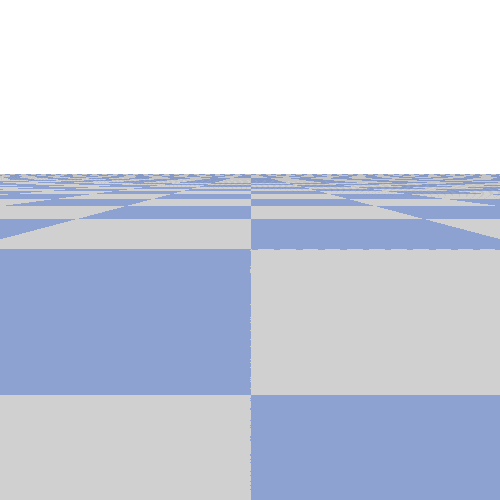

rgba shape=(500, 500, 4), dtype=uint8


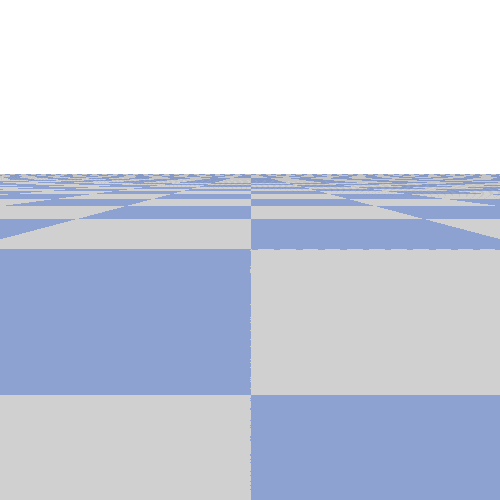

rgba shape=(500, 500, 4), dtype=uint8


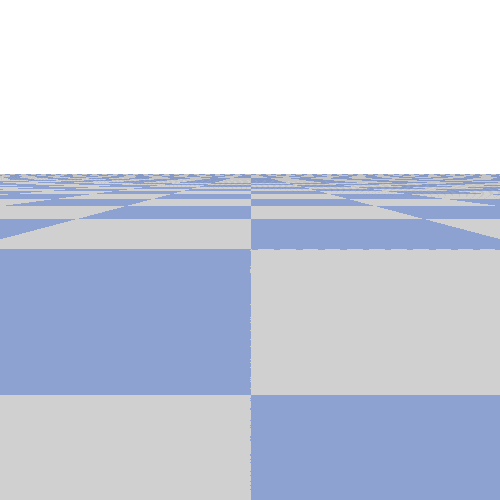

rgba shape=(500, 500, 4), dtype=uint8


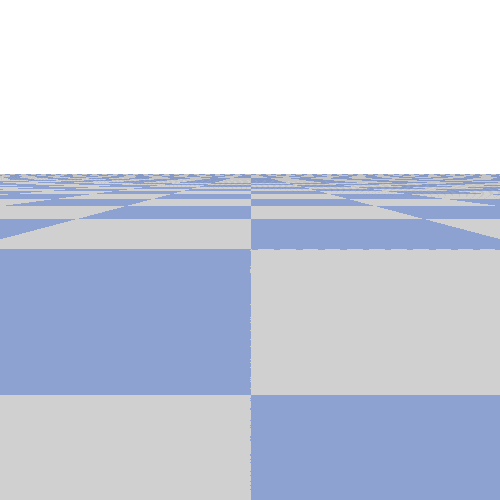

rgba shape=(500, 500, 4), dtype=uint8


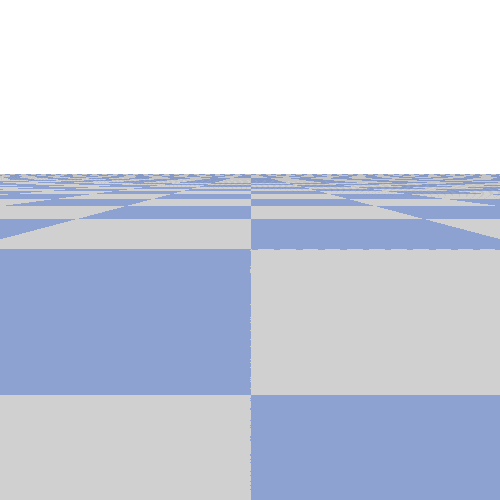

rgba shape=(500, 500, 4), dtype=uint8


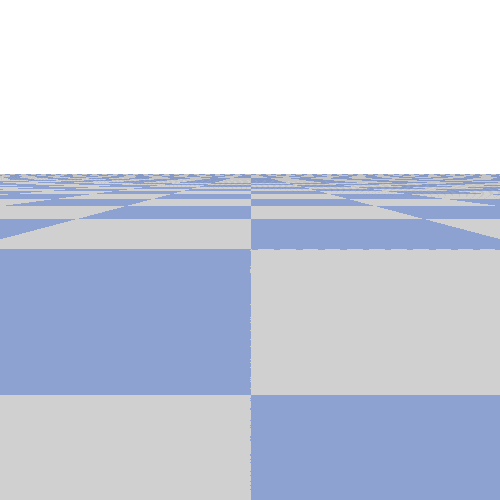

rgba shape=(500, 500, 4), dtype=uint8


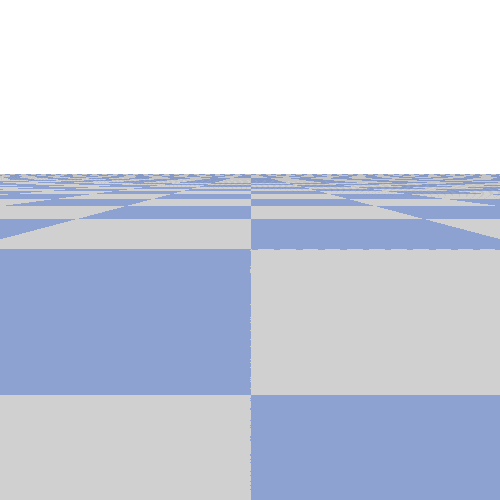

rgba shape=(500, 500, 4), dtype=uint8


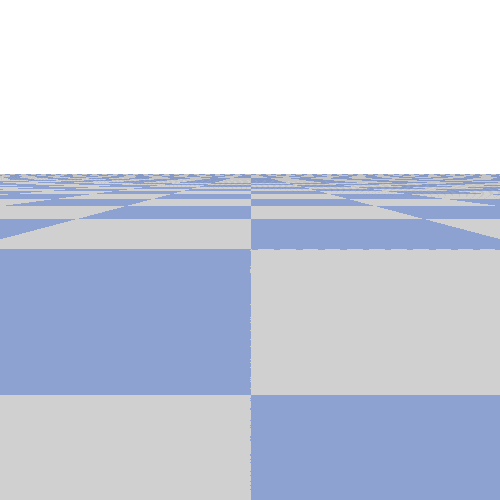

rgba shape=(500, 500, 4), dtype=uint8


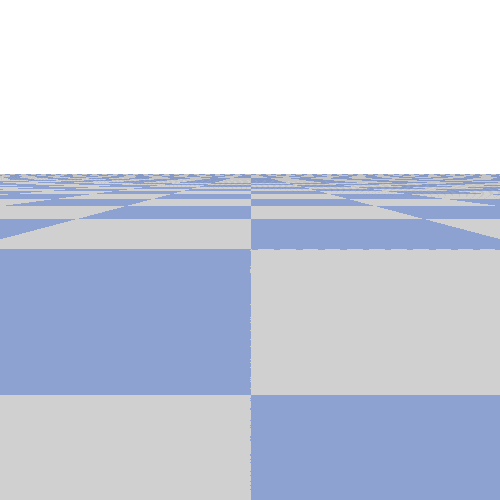

rgba shape=(500, 500, 4), dtype=uint8


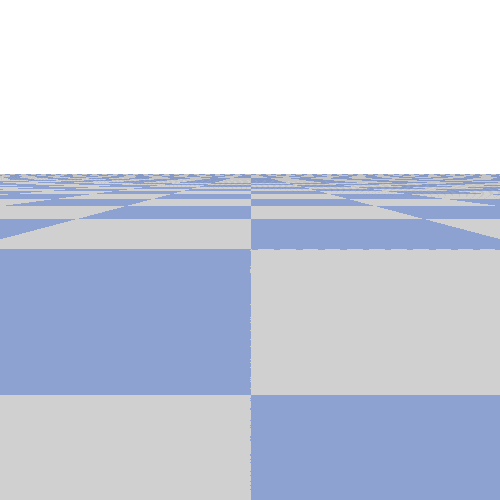

rgba shape=(500, 500, 4), dtype=uint8


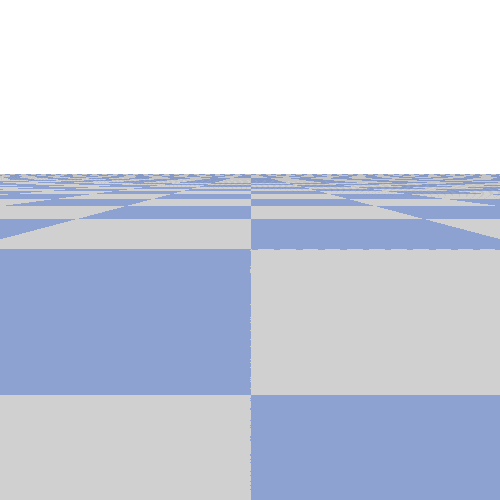

rgba shape=(500, 500, 4), dtype=uint8


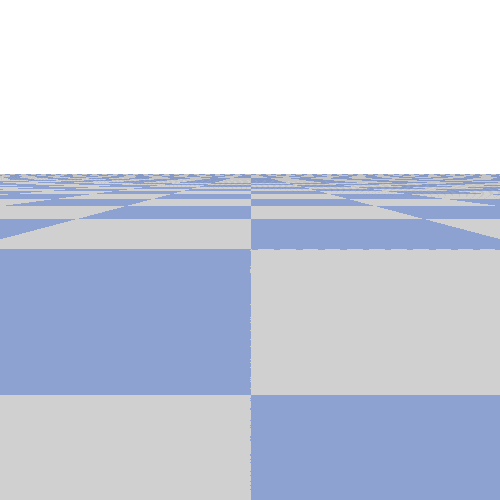

rgba shape=(500, 500, 4), dtype=uint8


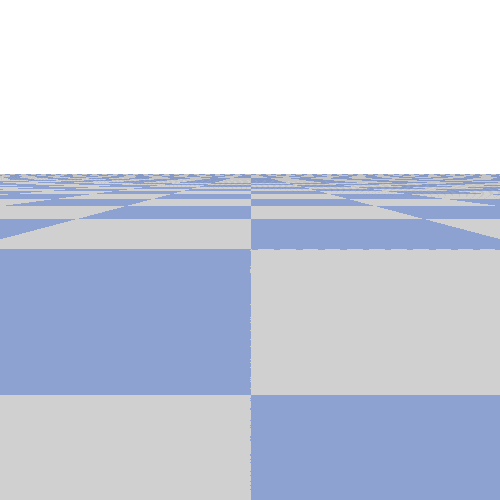

rgba shape=(500, 500, 4), dtype=uint8


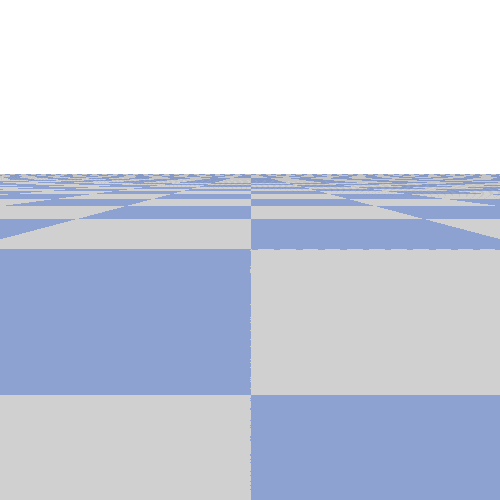

rgba shape=(500, 500, 4), dtype=uint8


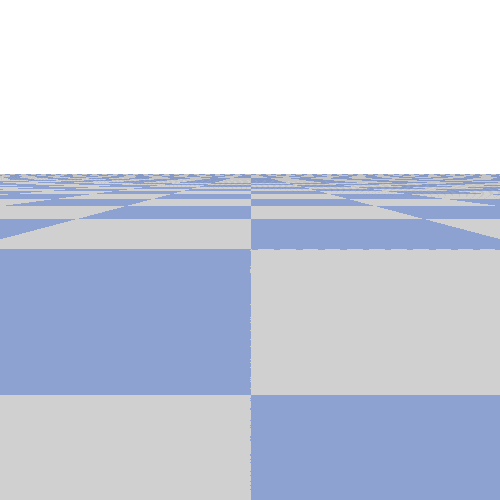

rgba shape=(500, 500, 4), dtype=uint8


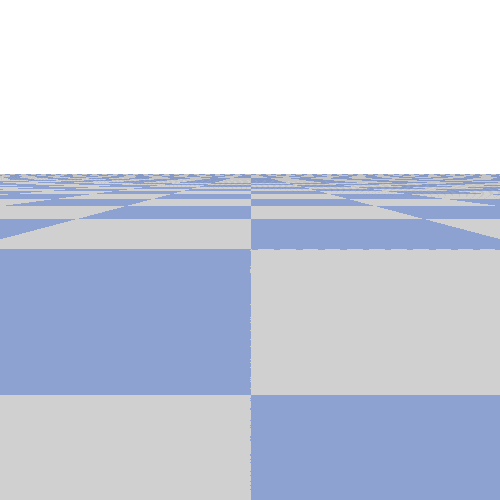

rgba shape=(500, 500, 4), dtype=uint8


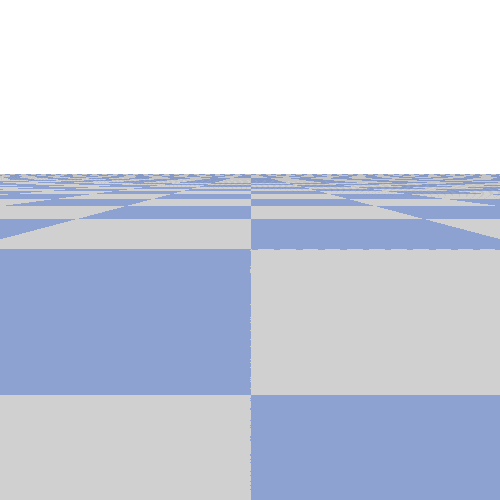

rgba shape=(500, 500, 4), dtype=uint8


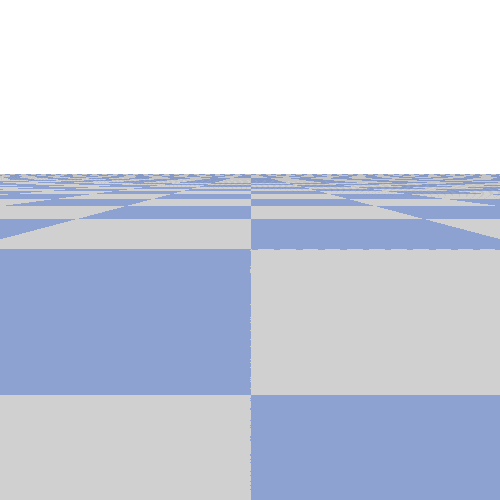

rgba shape=(500, 500, 4), dtype=uint8


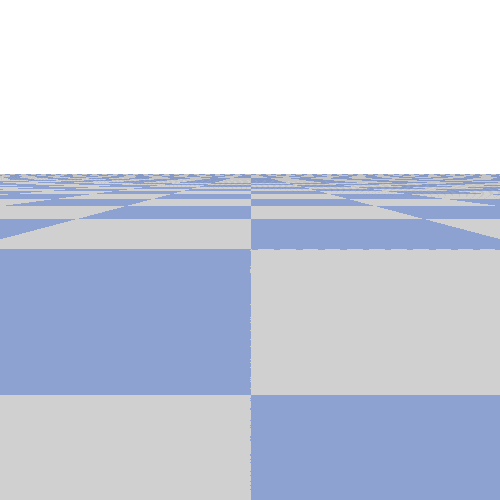

rgba shape=(500, 500, 4), dtype=uint8


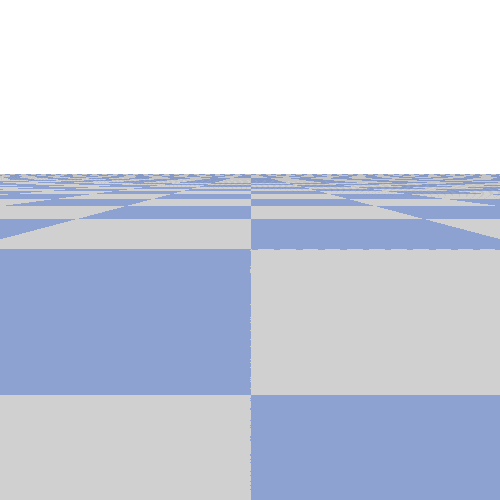

rgba shape=(500, 500, 4), dtype=uint8


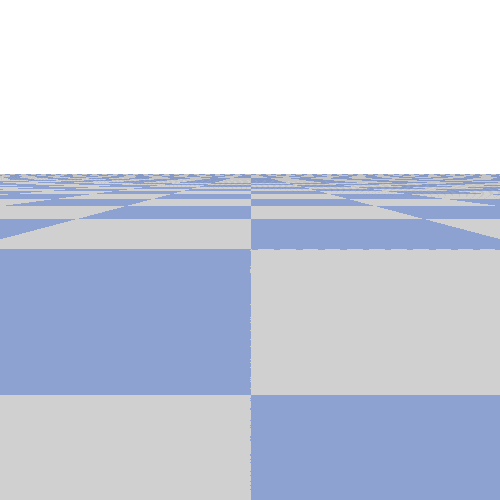

rgba shape=(500, 500, 4), dtype=uint8


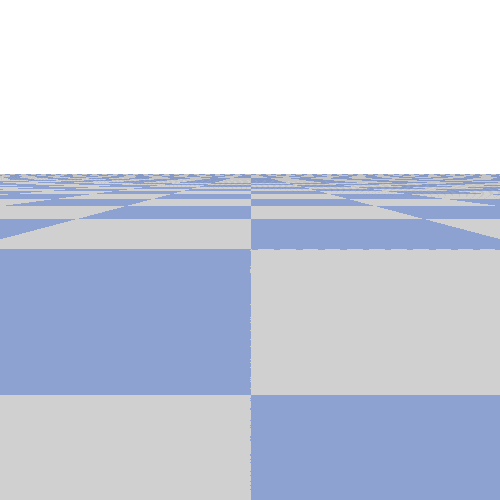

rgba shape=(500, 500, 4), dtype=uint8


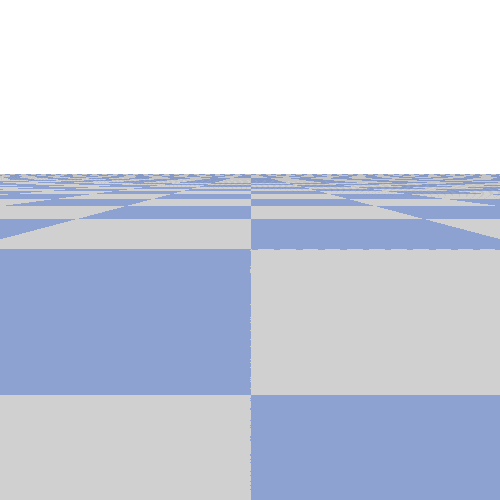

rgba shape=(500, 500, 4), dtype=uint8


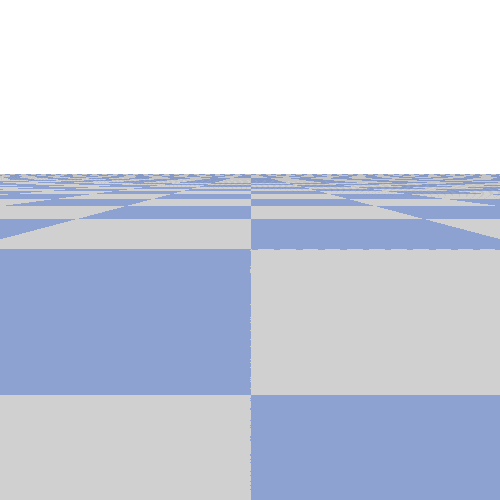

rgba shape=(500, 500, 4), dtype=uint8


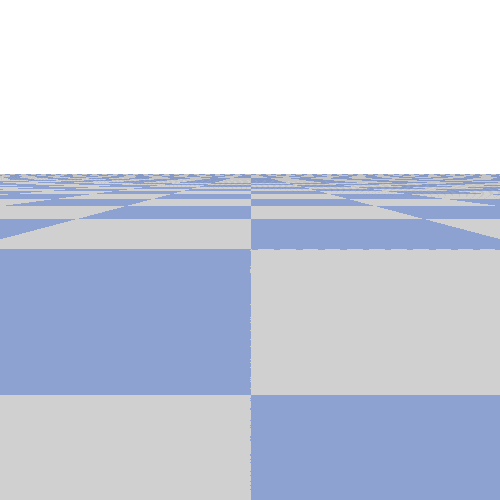

rgba shape=(500, 500, 4), dtype=uint8


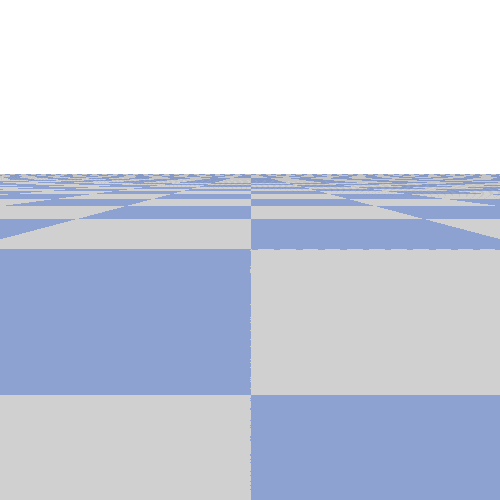

rgba shape=(500, 500, 4), dtype=uint8


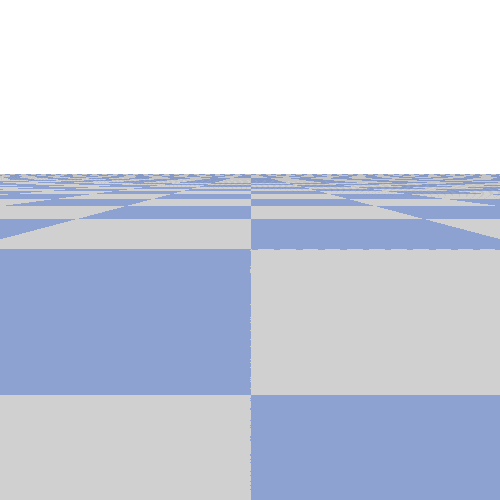

rgba shape=(500, 500, 4), dtype=uint8


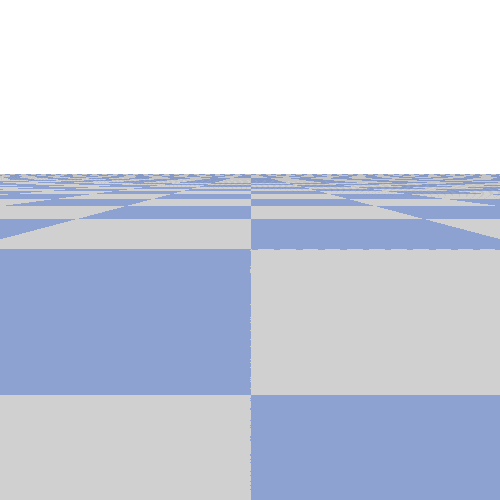

rgba shape=(500, 500, 4), dtype=uint8


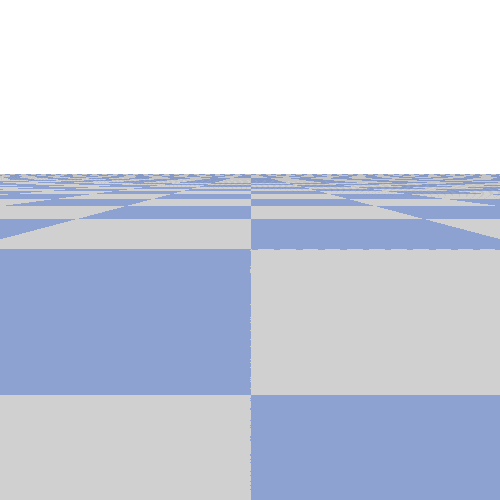

rgba shape=(500, 500, 4), dtype=uint8


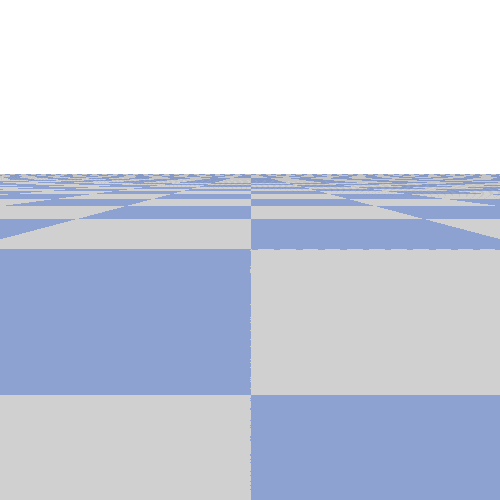

rgba shape=(500, 500, 4), dtype=uint8


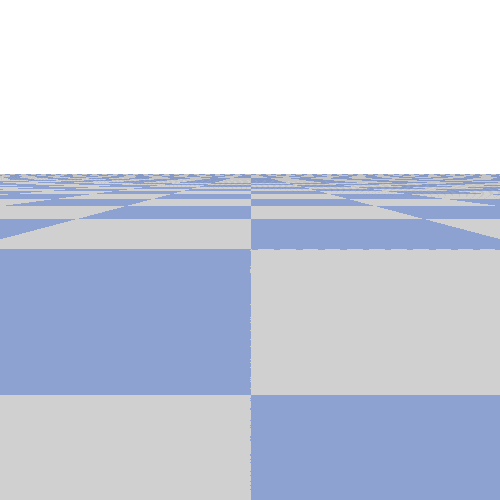

rgba shape=(500, 500, 4), dtype=uint8


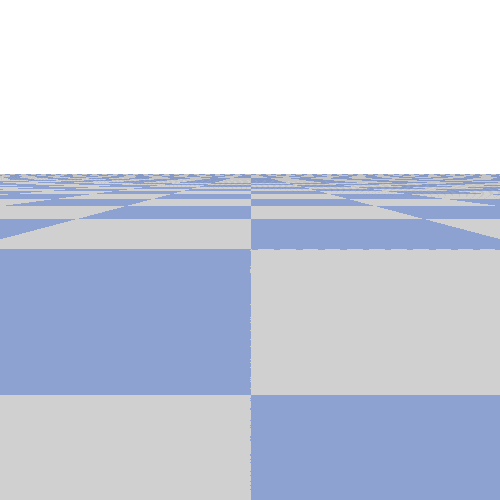

rgba shape=(500, 500, 4), dtype=uint8


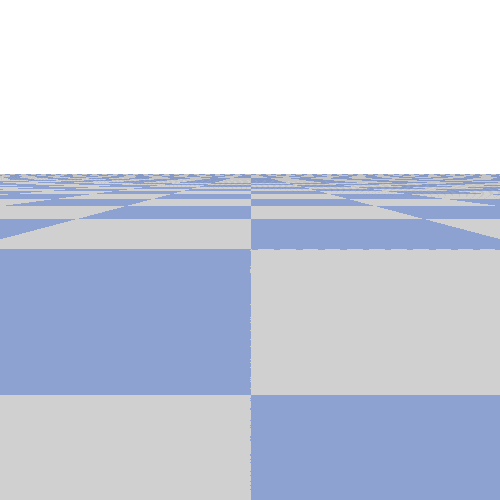

rgba shape=(500, 500, 4), dtype=uint8


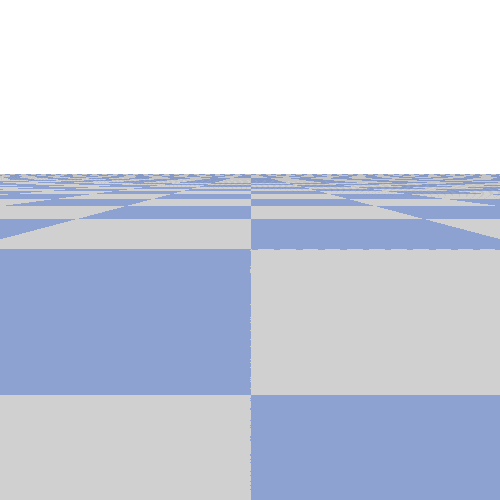

rgba shape=(500, 500, 4), dtype=uint8


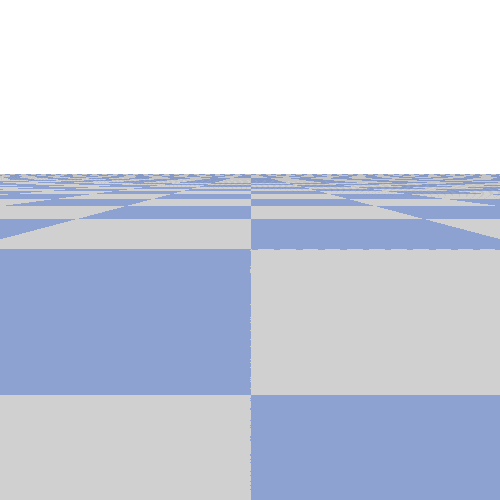

rgba shape=(500, 500, 4), dtype=uint8


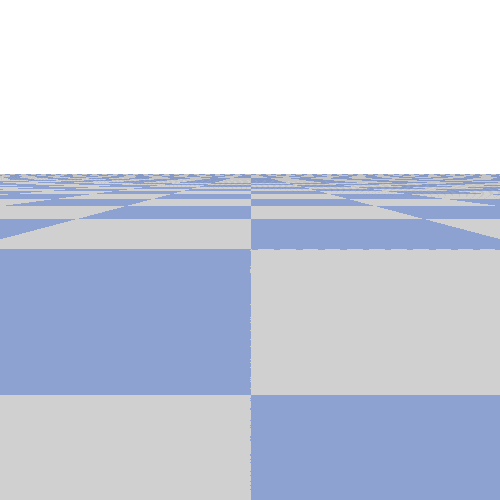

rgba shape=(500, 500, 4), dtype=uint8


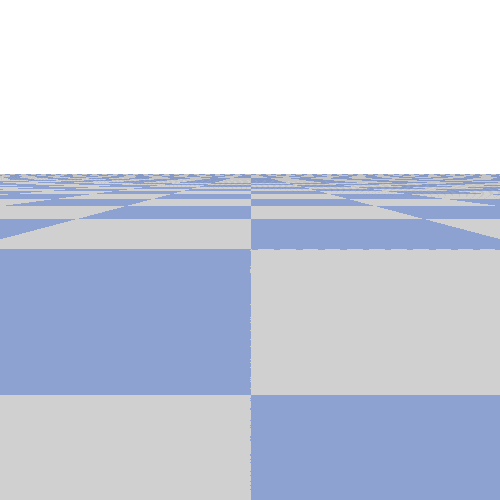

rgba shape=(500, 500, 4), dtype=uint8


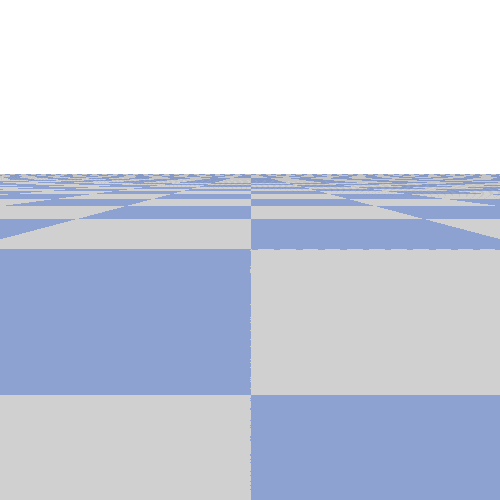

rgba shape=(500, 500, 4), dtype=uint8


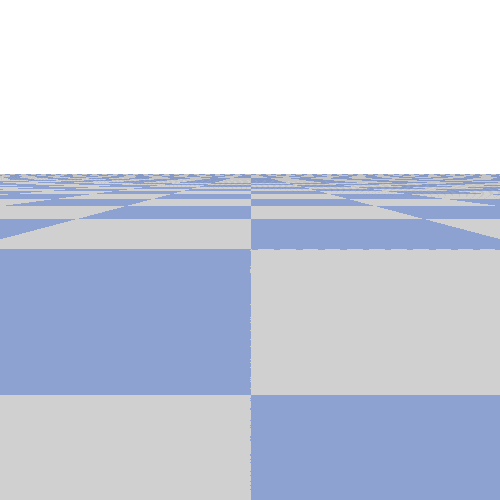

rgba shape=(500, 500, 4), dtype=uint8


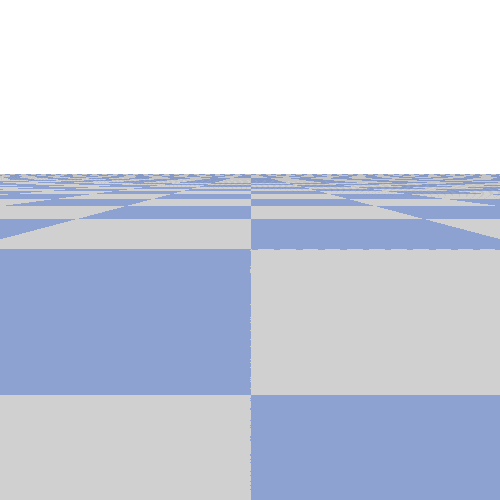

rgba shape=(500, 500, 4), dtype=uint8


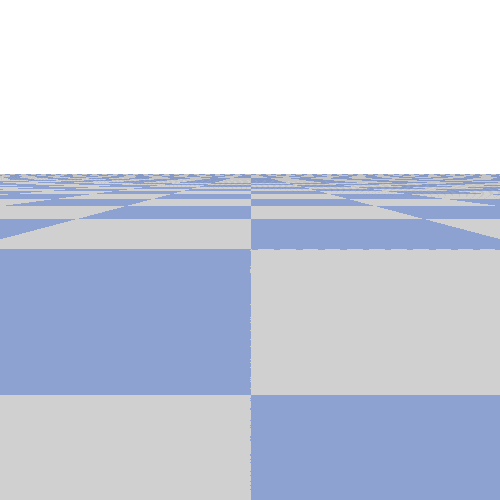

rgba shape=(500, 500, 4), dtype=uint8


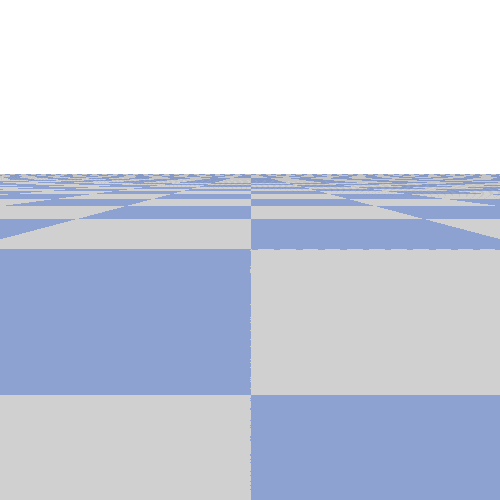

rgba shape=(500, 500, 4), dtype=uint8


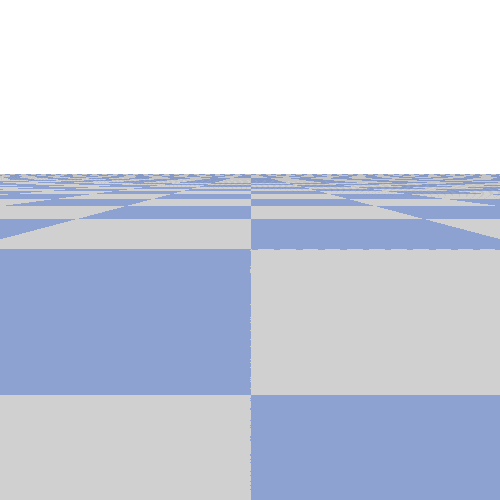

rgba shape=(500, 500, 4), dtype=uint8


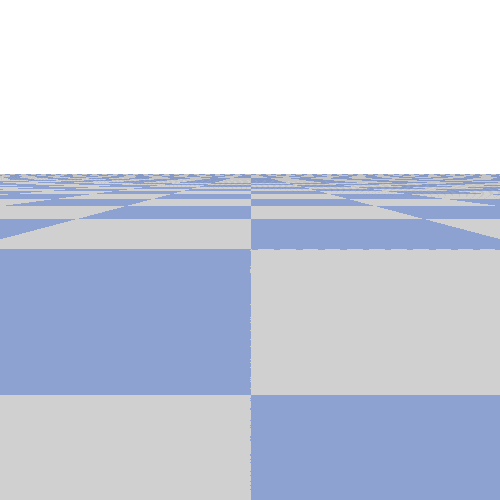

rgba shape=(500, 500, 4), dtype=uint8


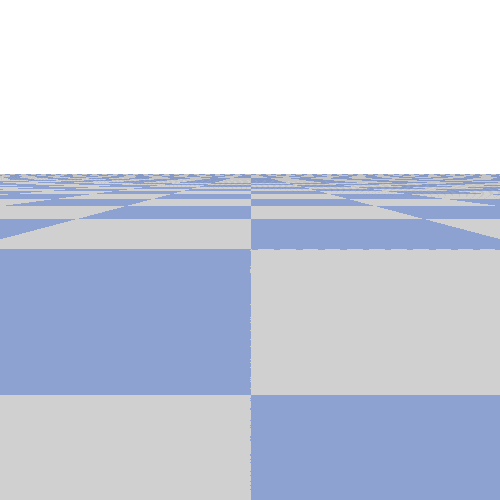

rgba shape=(500, 500, 4), dtype=uint8


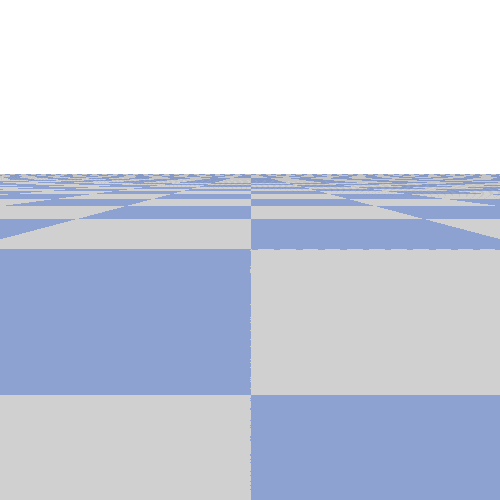

rgba shape=(500, 500, 4), dtype=uint8


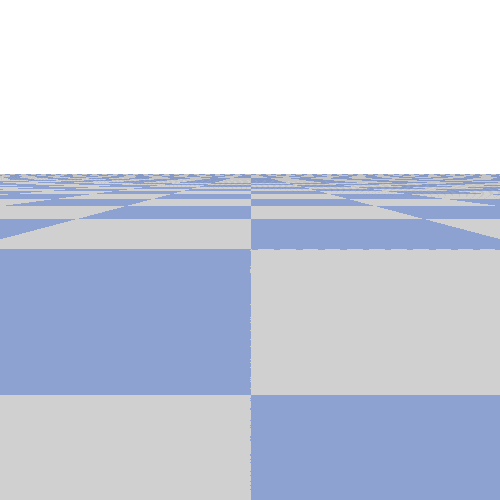

rgba shape=(500, 500, 4), dtype=uint8


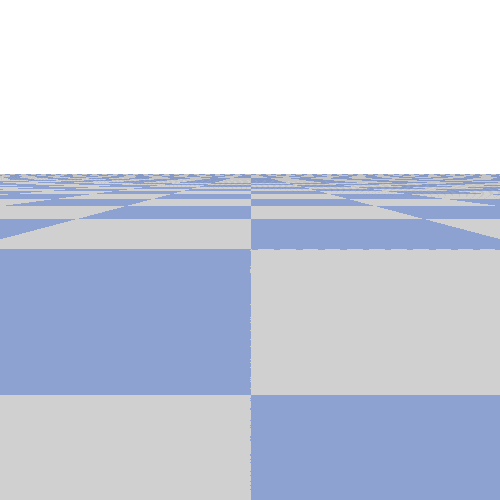

rgba shape=(500, 500, 4), dtype=uint8


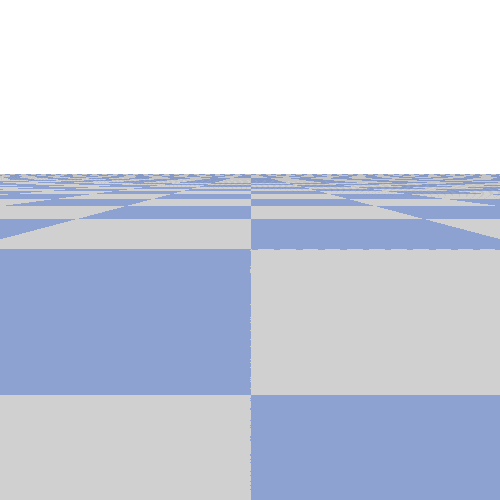

rgba shape=(500, 500, 4), dtype=uint8


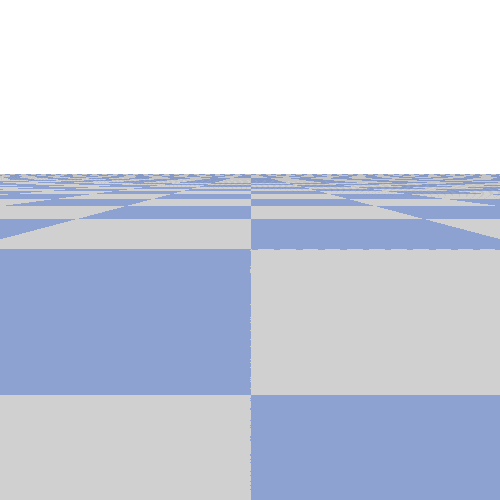

rgba shape=(500, 500, 4), dtype=uint8


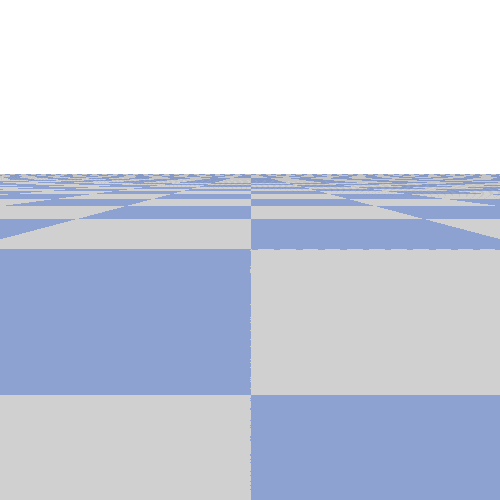

rgba shape=(500, 500, 4), dtype=uint8


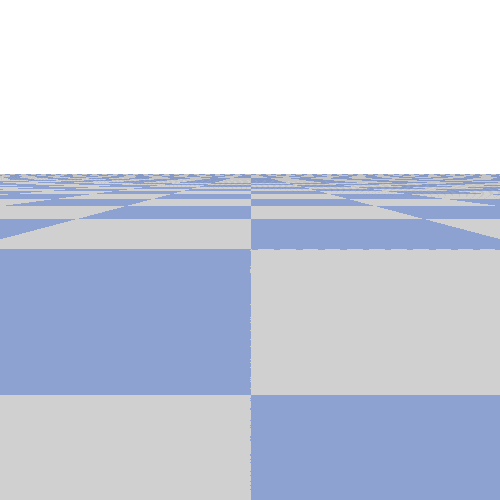

rgba shape=(500, 500, 4), dtype=uint8


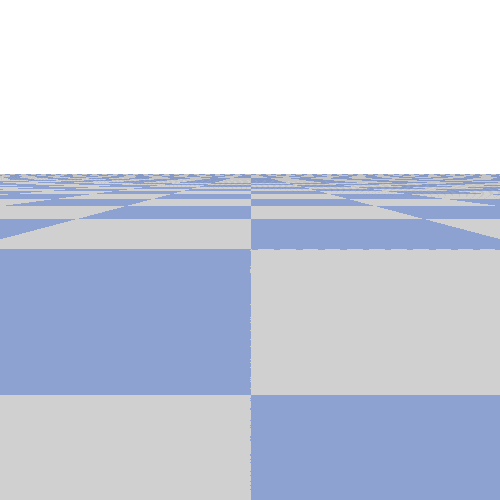

rgba shape=(500, 500, 4), dtype=uint8


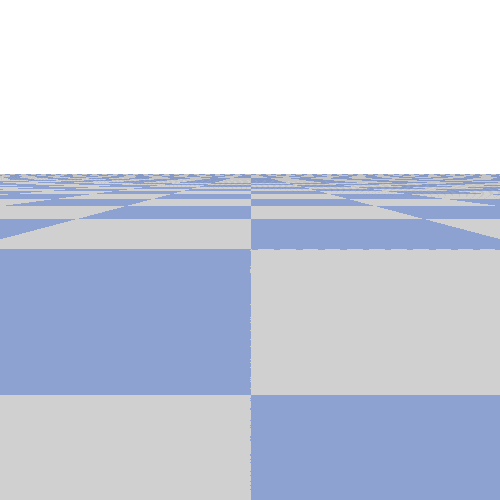

rgba shape=(500, 500, 4), dtype=uint8


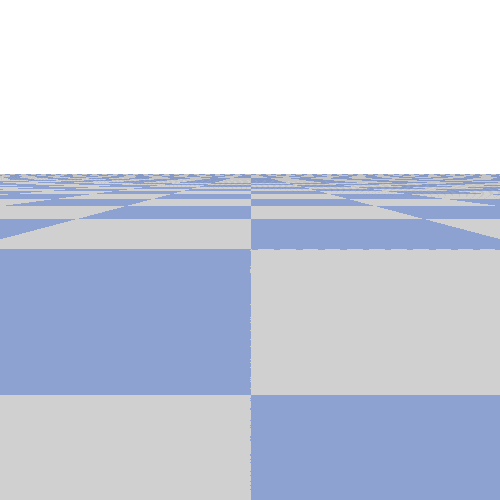

rgba shape=(500, 500, 4), dtype=uint8


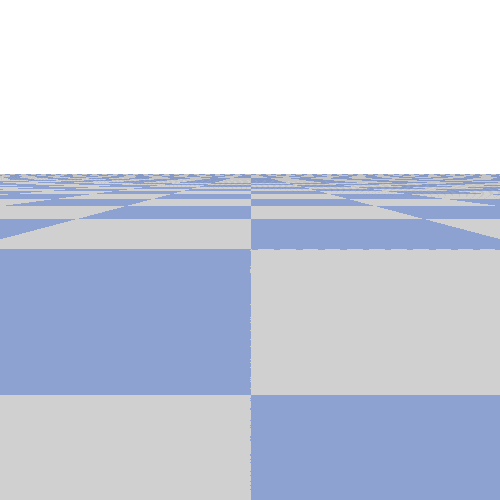

rgba shape=(500, 500, 4), dtype=uint8


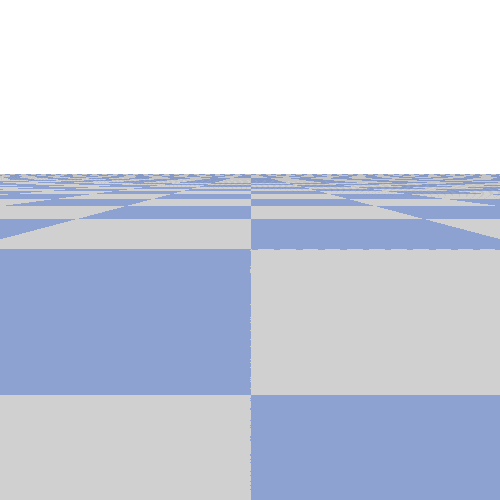

fail
rgba shape=(500, 500, 4), dtype=uint8


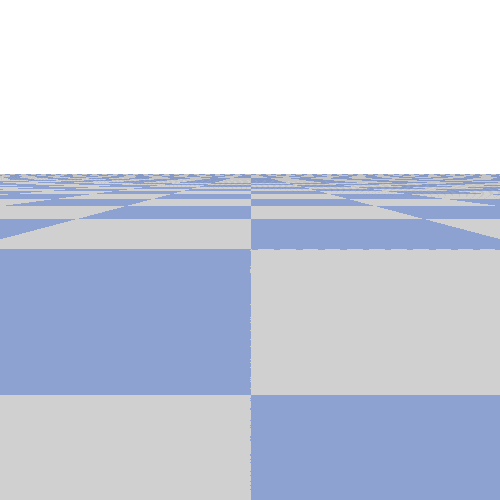

rgba shape=(500, 500, 4), dtype=uint8


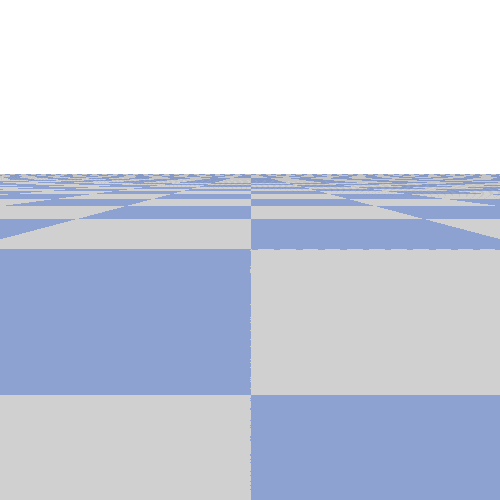

rgba shape=(500, 500, 4), dtype=uint8


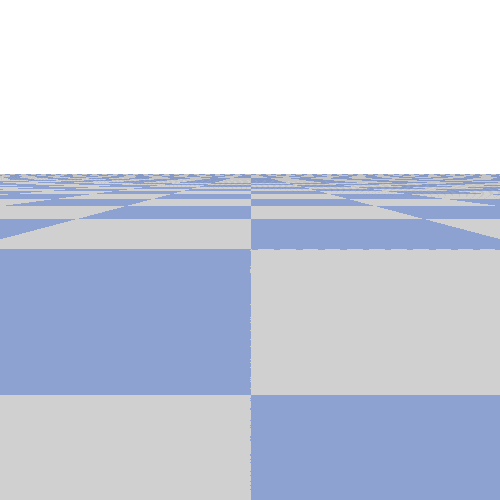

rgba shape=(500, 500, 4), dtype=uint8


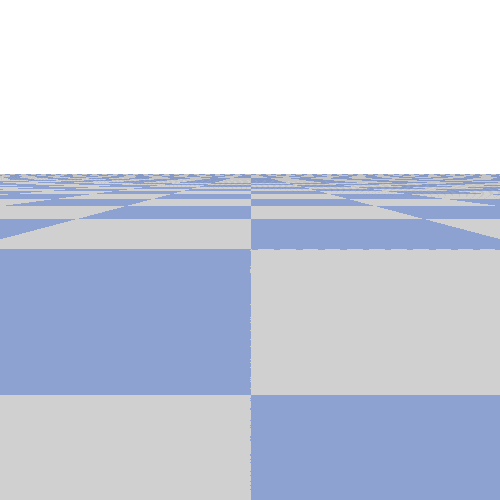

rgba shape=(500, 500, 4), dtype=uint8


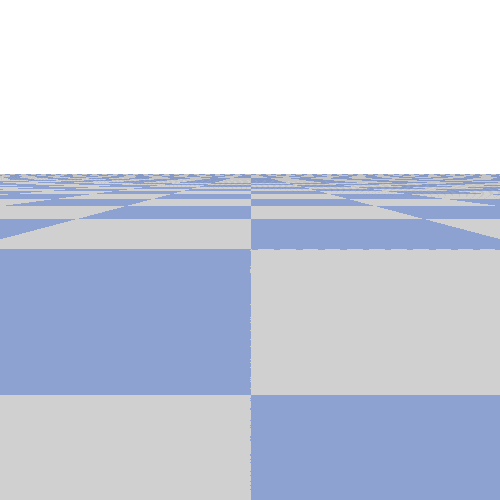

rgba shape=(500, 500, 4), dtype=uint8


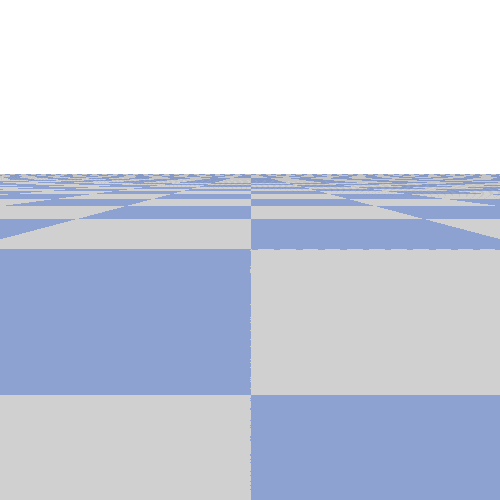

rgba shape=(500, 500, 4), dtype=uint8


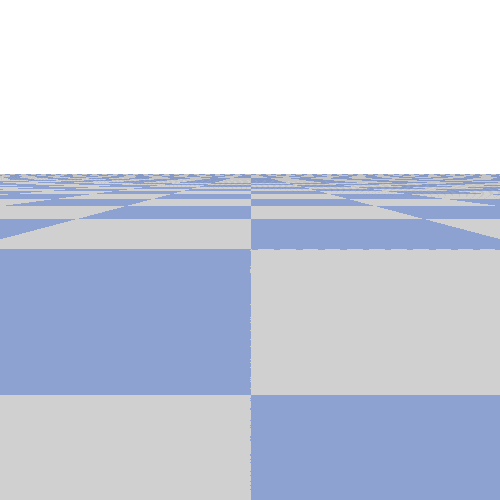

rgba shape=(500, 500, 4), dtype=uint8


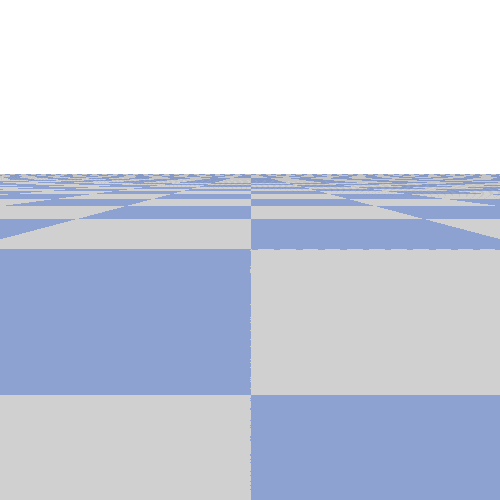

rgba shape=(500, 500, 4), dtype=uint8


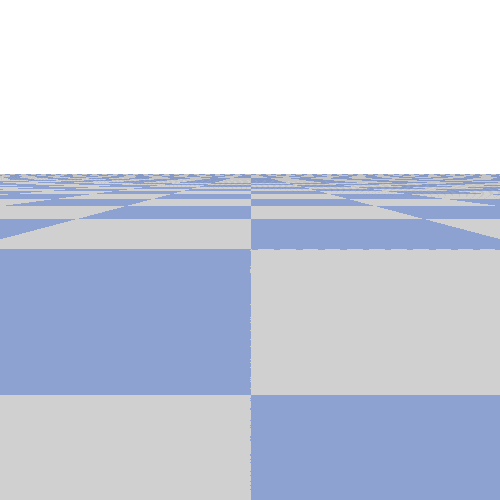

rgba shape=(500, 500, 4), dtype=uint8


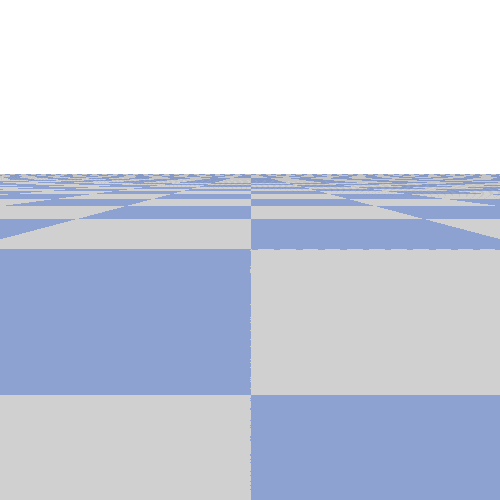

rgba shape=(500, 500, 4), dtype=uint8


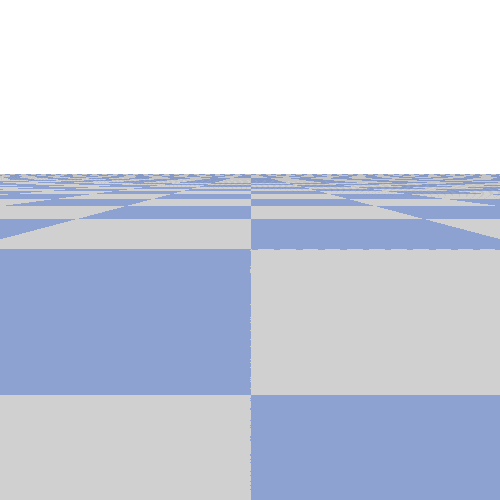

rgba shape=(500, 500, 4), dtype=uint8


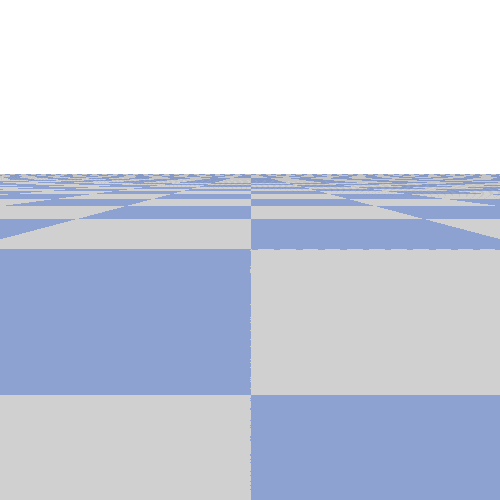

fail
rgba shape=(500, 500, 4), dtype=uint8


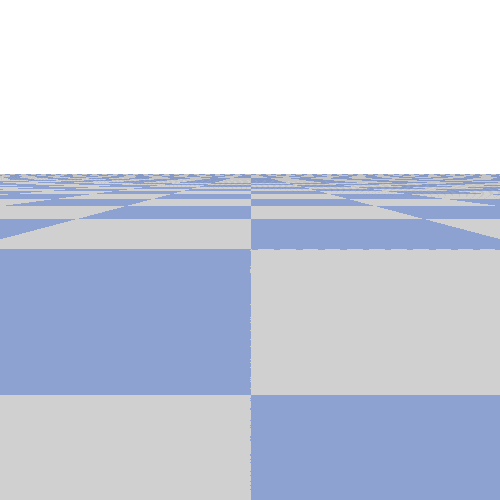

rgba shape=(500, 500, 4), dtype=uint8


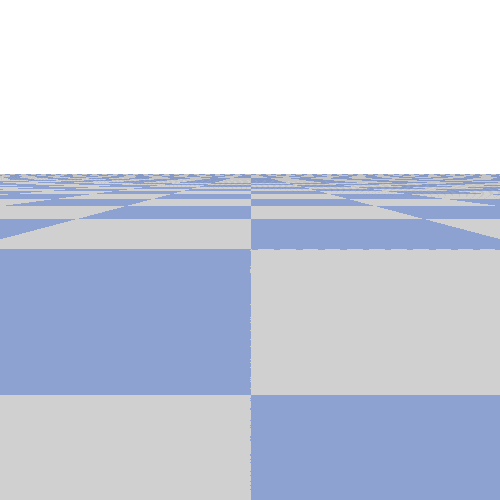

rgba shape=(500, 500, 4), dtype=uint8


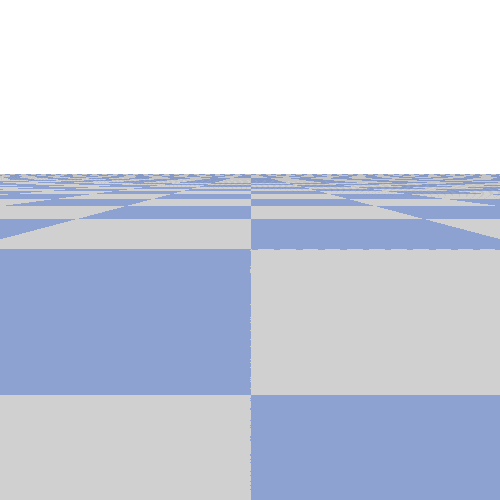

rgba shape=(500, 500, 4), dtype=uint8


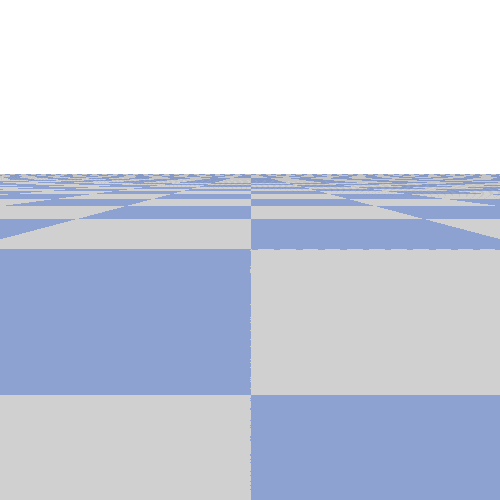

rgba shape=(500, 500, 4), dtype=uint8


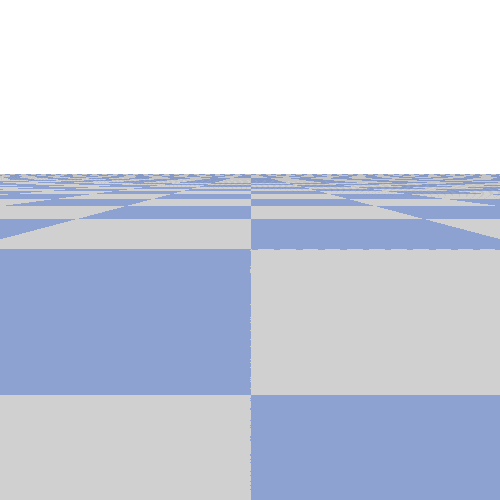

rgba shape=(500, 500, 4), dtype=uint8


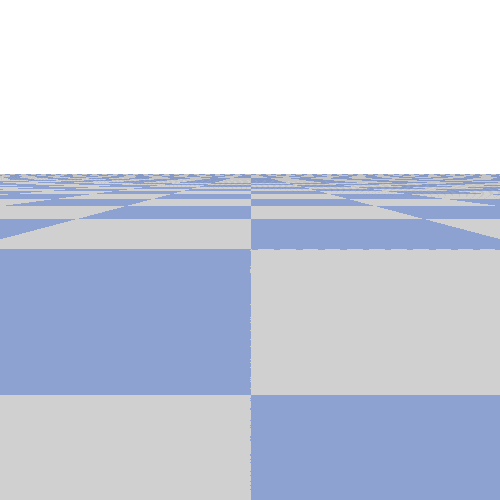

rgba shape=(500, 500, 4), dtype=uint8


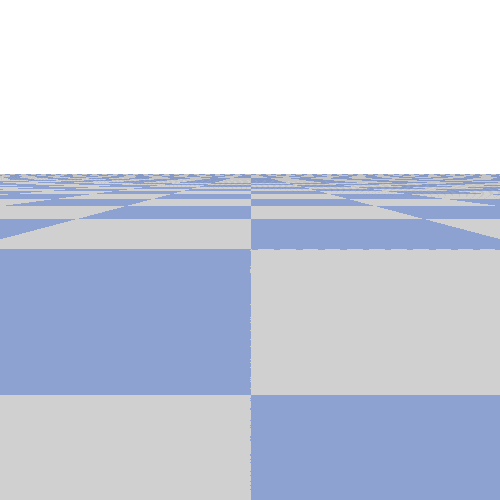

rgba shape=(500, 500, 4), dtype=uint8


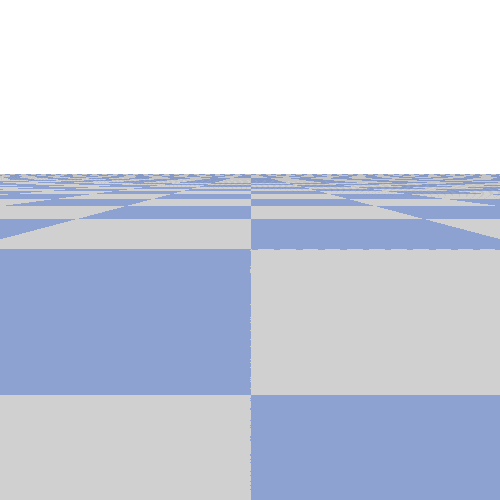

rgba shape=(500, 500, 4), dtype=uint8


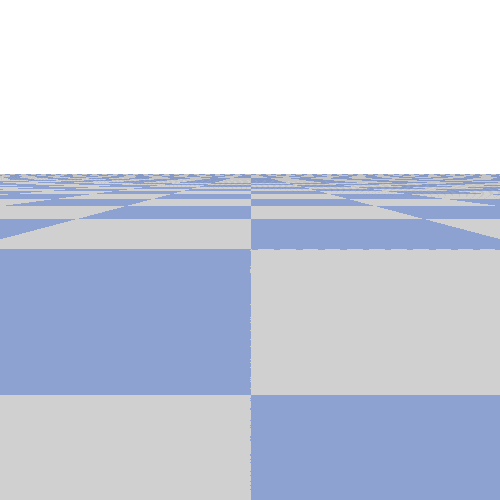

fail
rgba shape=(500, 500, 4), dtype=uint8


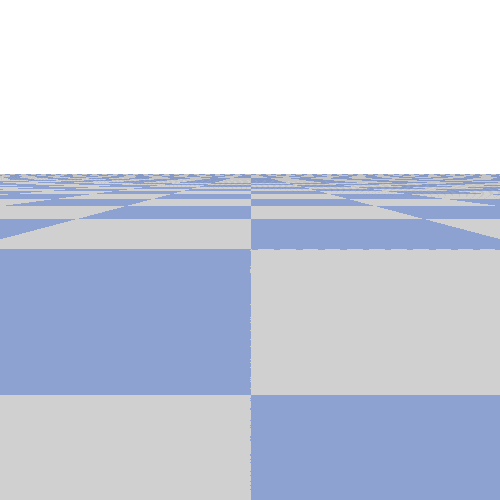

rgba shape=(500, 500, 4), dtype=uint8


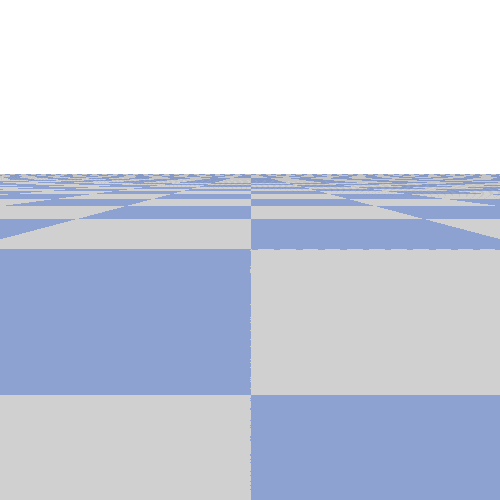

rgba shape=(500, 500, 4), dtype=uint8


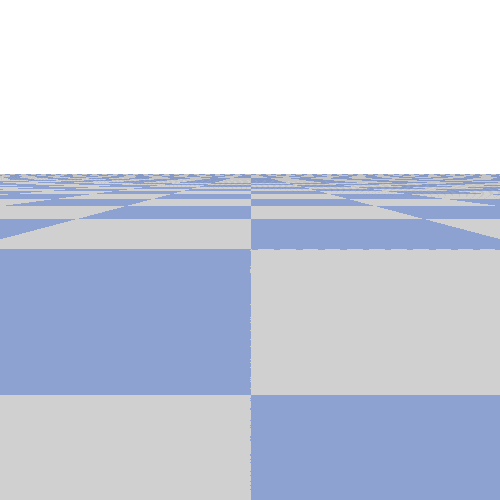

rgba shape=(500, 500, 4), dtype=uint8


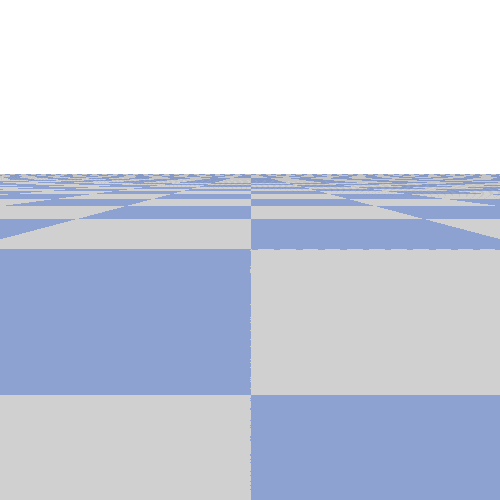

rgba shape=(500, 500, 4), dtype=uint8


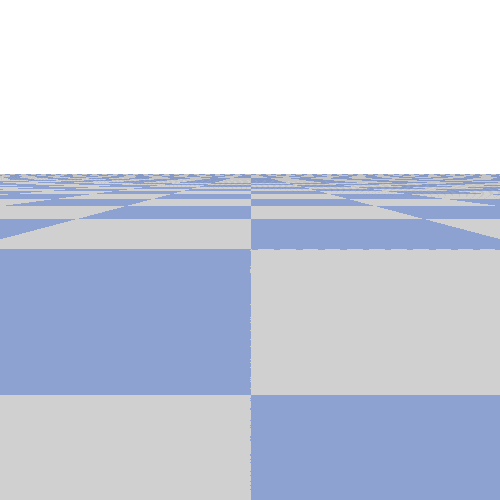

rgba shape=(500, 500, 4), dtype=uint8


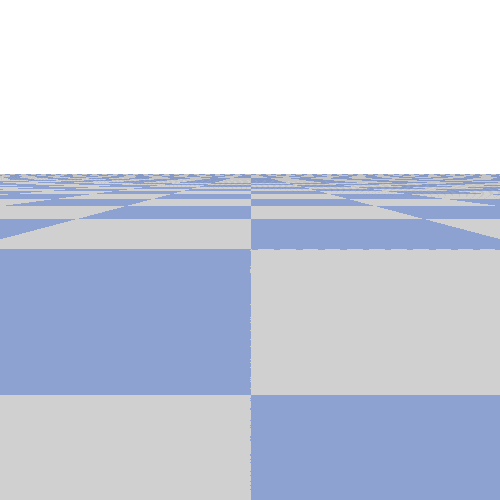

rgba shape=(500, 500, 4), dtype=uint8


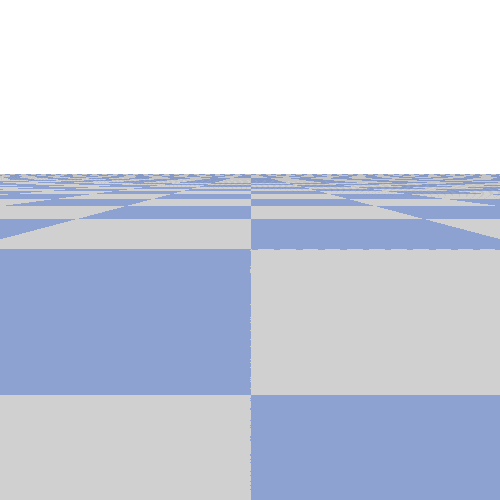

rgba shape=(500, 500, 4), dtype=uint8


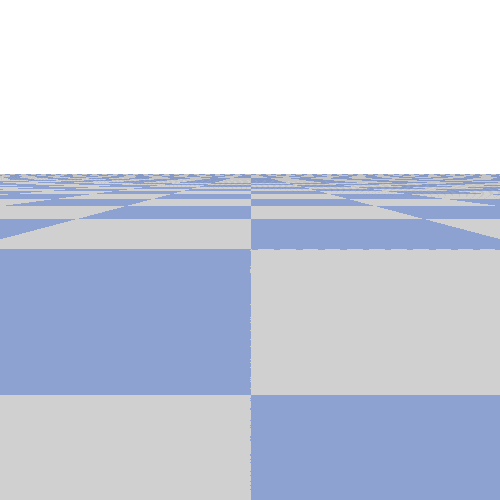

rgba shape=(500, 500, 4), dtype=uint8


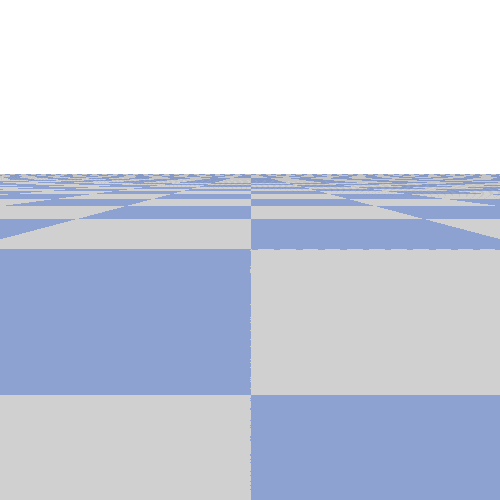

rgba shape=(500, 500, 4), dtype=uint8


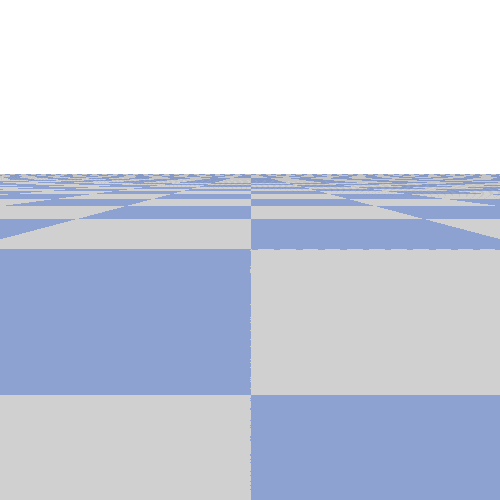

rgba shape=(500, 500, 4), dtype=uint8


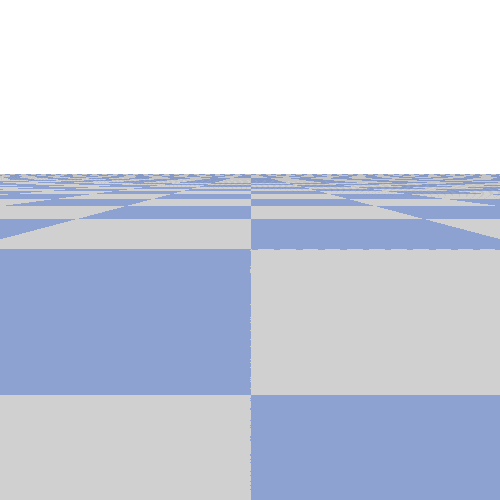

rgba shape=(500, 500, 4), dtype=uint8


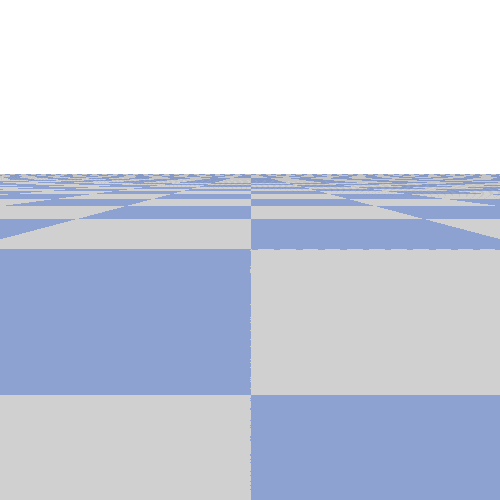

rgba shape=(500, 500, 4), dtype=uint8


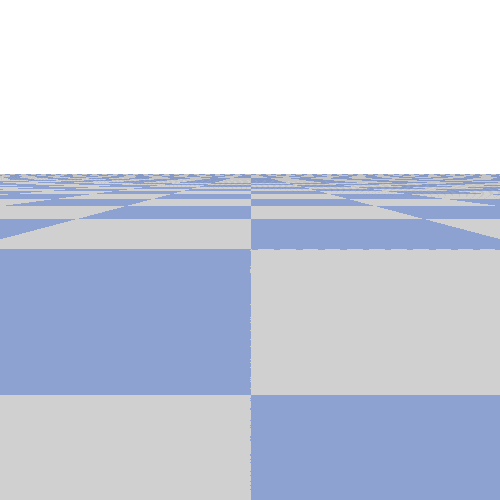

rgba shape=(500, 500, 4), dtype=uint8


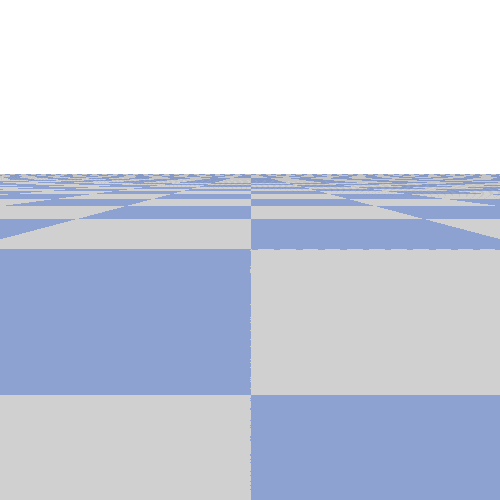

fail
rgba shape=(500, 500, 4), dtype=uint8


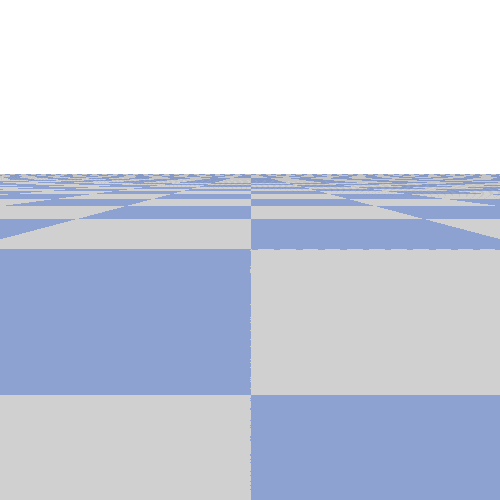

rgba shape=(500, 500, 4), dtype=uint8


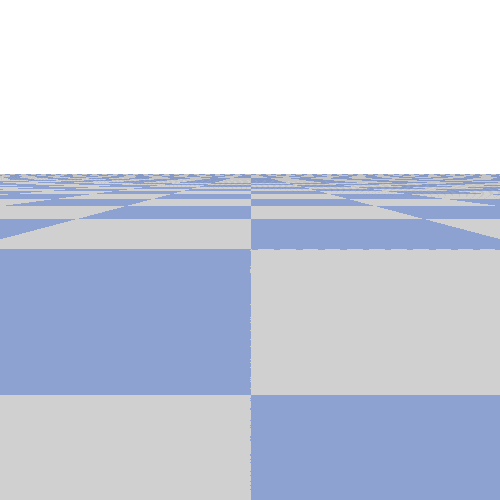

rgba shape=(500, 500, 4), dtype=uint8


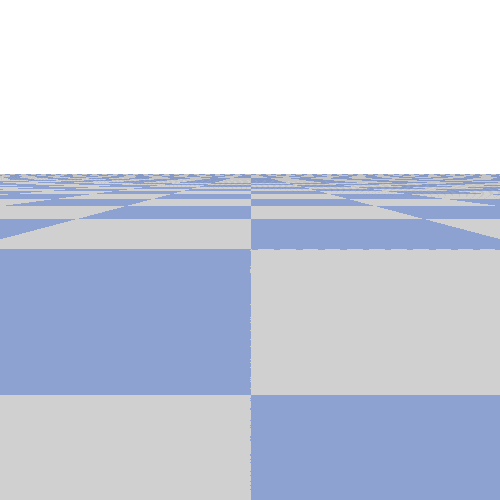

rgba shape=(500, 500, 4), dtype=uint8


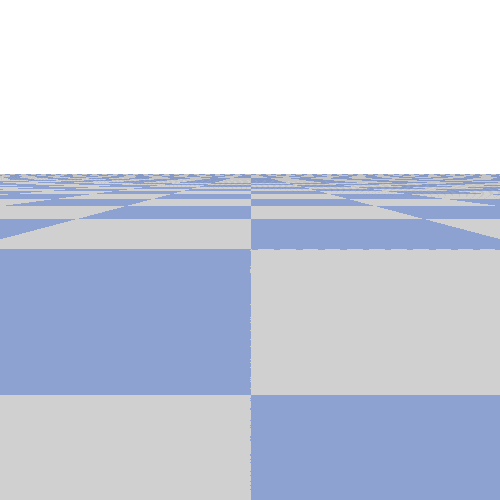

rgba shape=(500, 500, 4), dtype=uint8


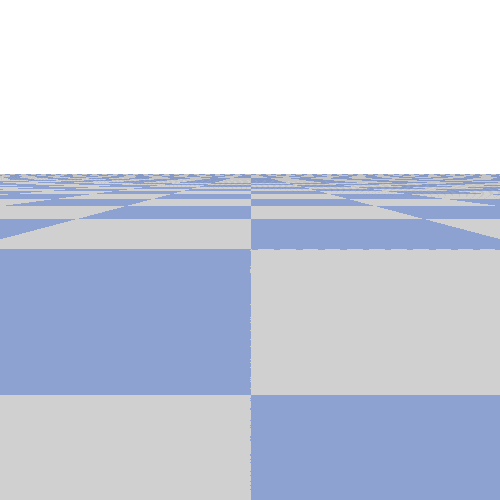

rgba shape=(500, 500, 4), dtype=uint8


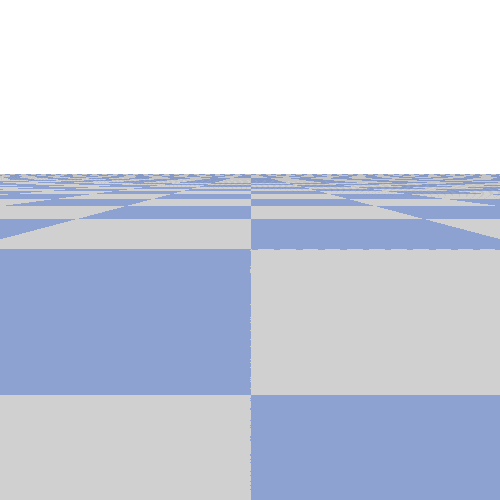

rgba shape=(500, 500, 4), dtype=uint8


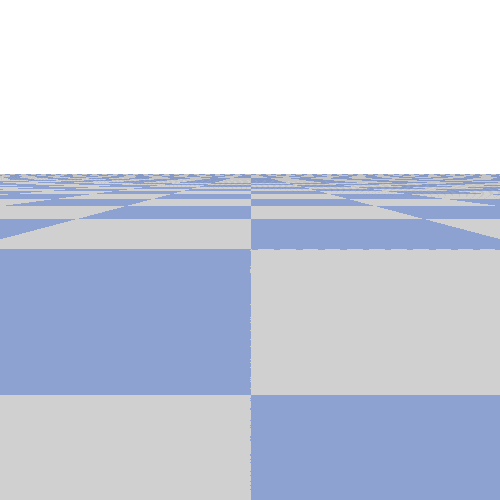

rgba shape=(500, 500, 4), dtype=uint8


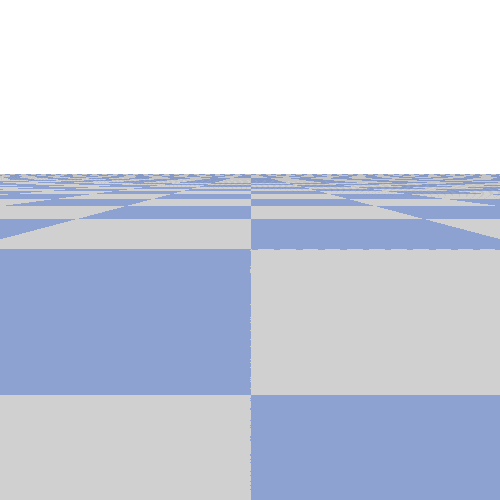

rgba shape=(500, 500, 4), dtype=uint8


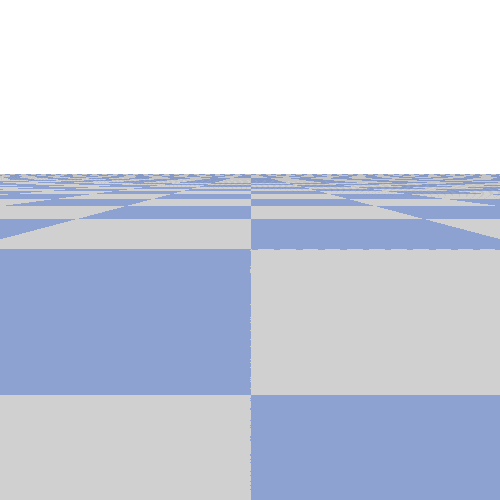

rgba shape=(500, 500, 4), dtype=uint8


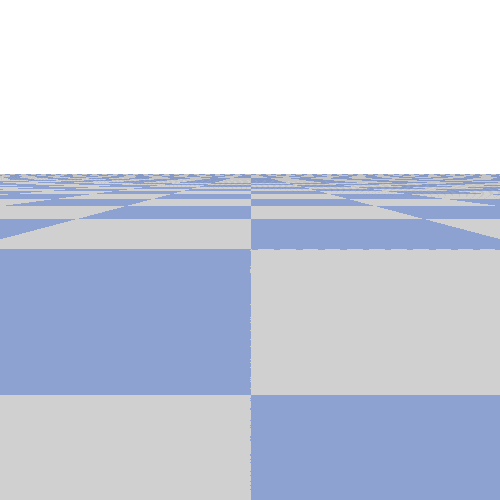

fail
rgba shape=(500, 500, 4), dtype=uint8


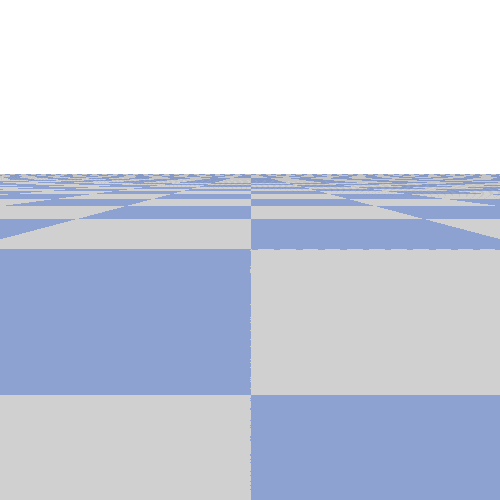

rgba shape=(500, 500, 4), dtype=uint8


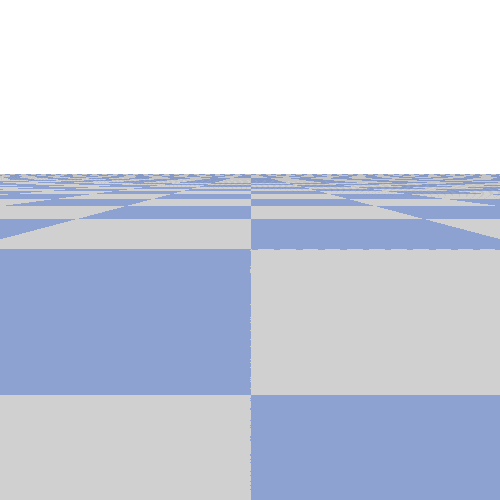

rgba shape=(500, 500, 4), dtype=uint8


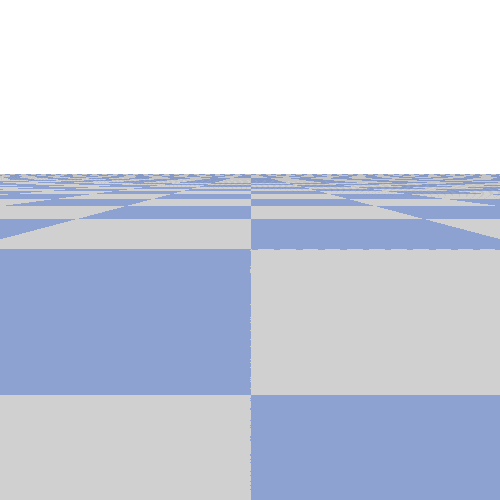

rgba shape=(500, 500, 4), dtype=uint8


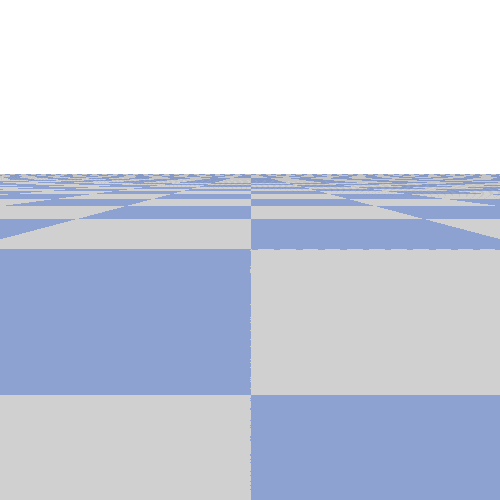

rgba shape=(500, 500, 4), dtype=uint8


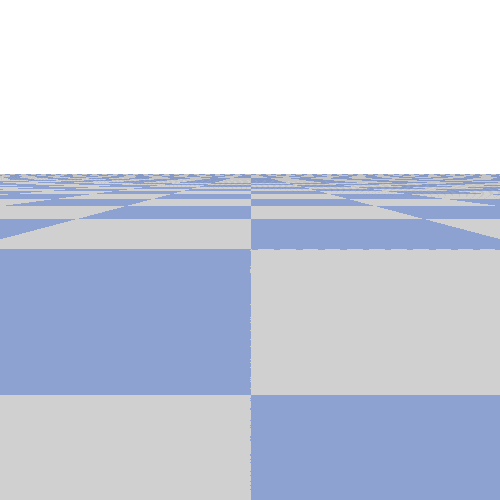

rgba shape=(500, 500, 4), dtype=uint8


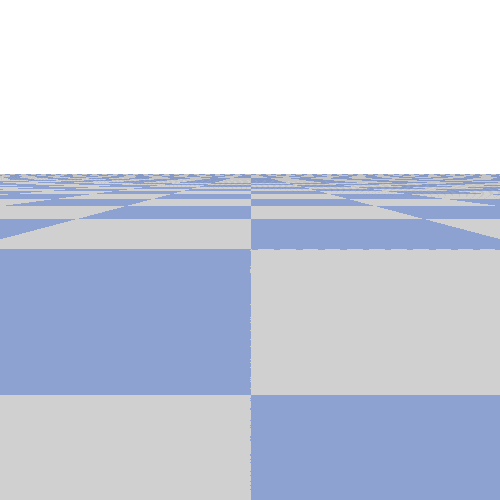

rgba shape=(500, 500, 4), dtype=uint8


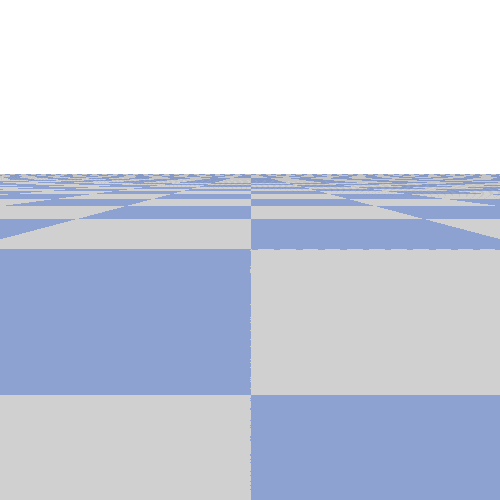

rgba shape=(500, 500, 4), dtype=uint8


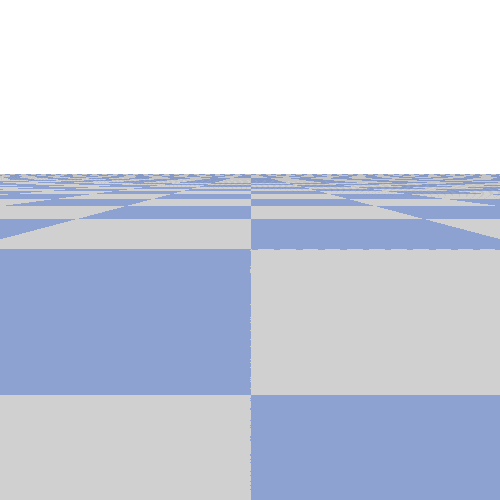

rgba shape=(500, 500, 4), dtype=uint8


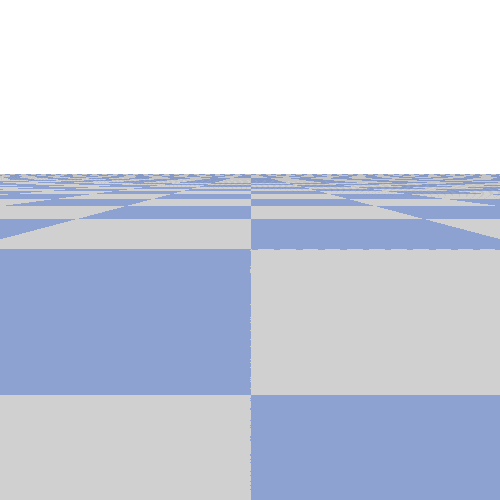

rgba shape=(500, 500, 4), dtype=uint8


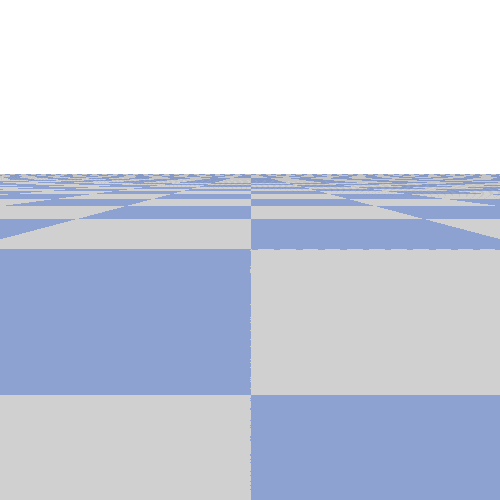

rgba shape=(500, 500, 4), dtype=uint8


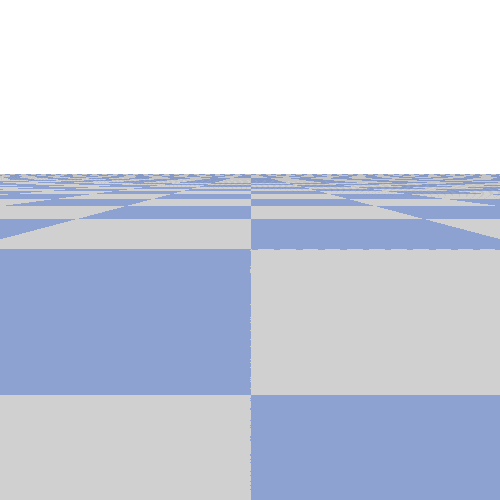

rgba shape=(500, 500, 4), dtype=uint8


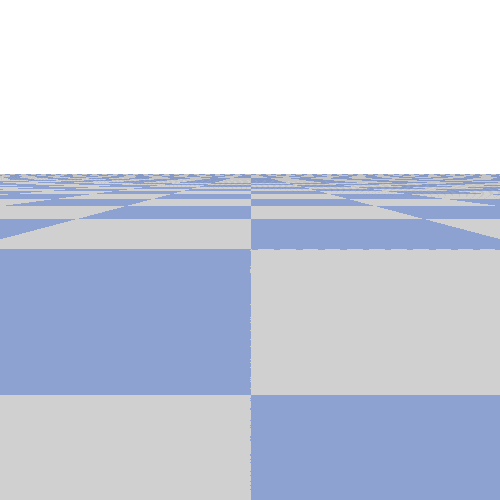

rgba shape=(500, 500, 4), dtype=uint8


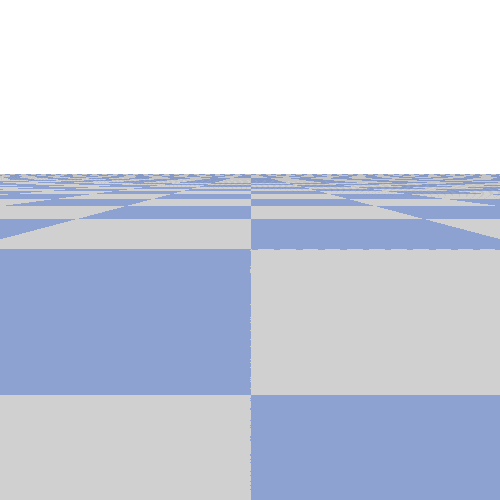

rgba shape=(500, 500, 4), dtype=uint8


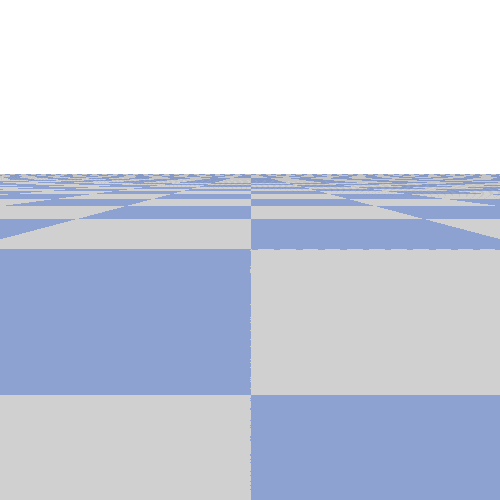

rgba shape=(500, 500, 4), dtype=uint8


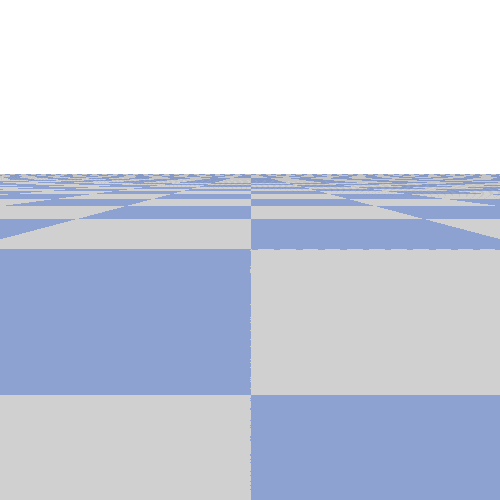

rgba shape=(500, 500, 4), dtype=uint8


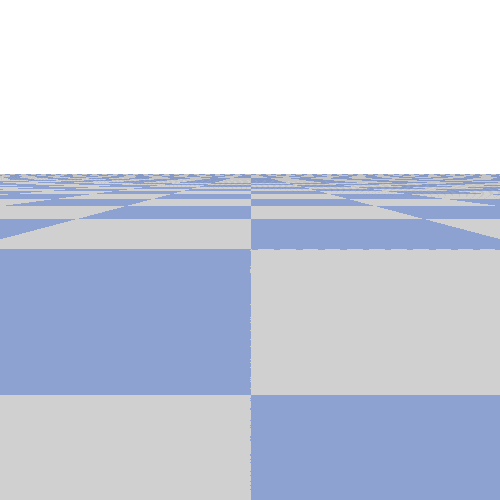

rgba shape=(500, 500, 4), dtype=uint8


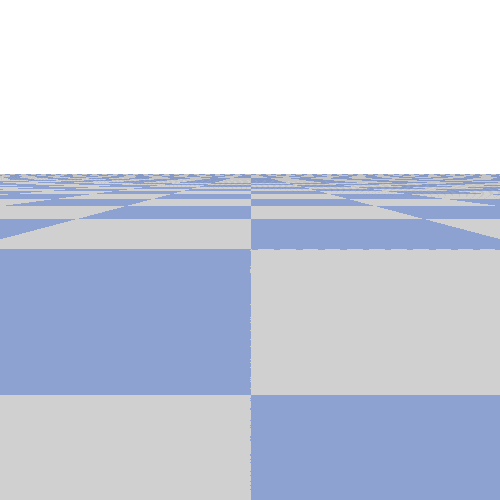

rgba shape=(500, 500, 4), dtype=uint8


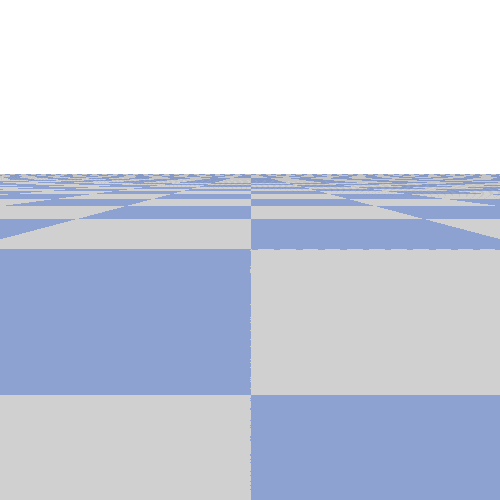

rgba shape=(500, 500, 4), dtype=uint8


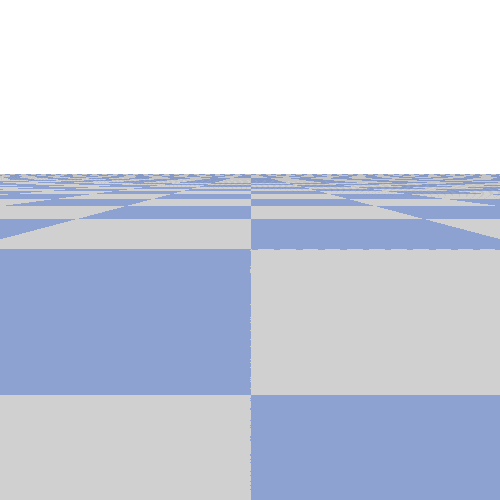

rgba shape=(500, 500, 4), dtype=uint8


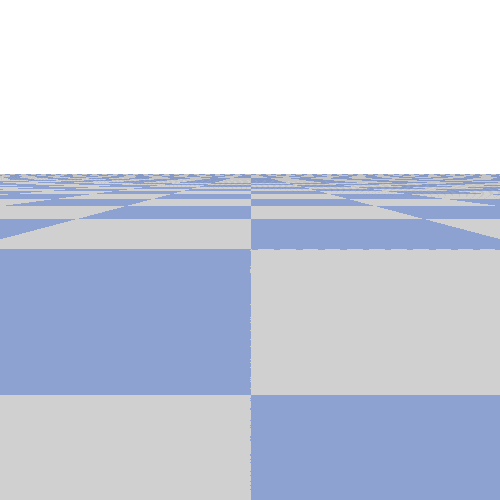

rgba shape=(500, 500, 4), dtype=uint8


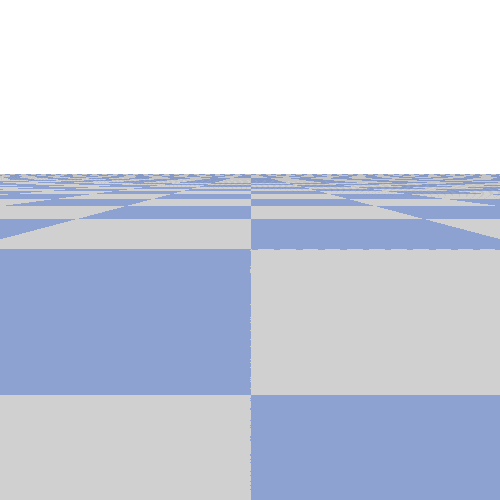

rgba shape=(500, 500, 4), dtype=uint8


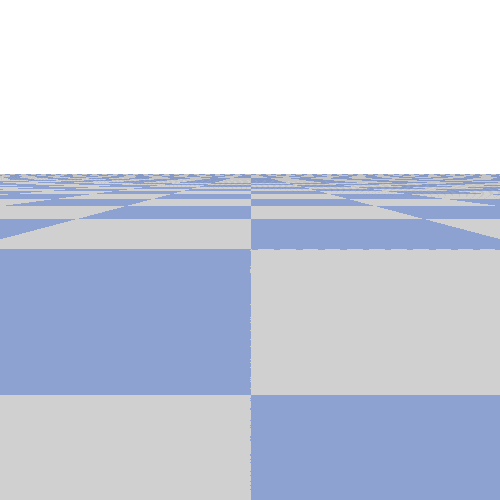

rgba shape=(500, 500, 4), dtype=uint8


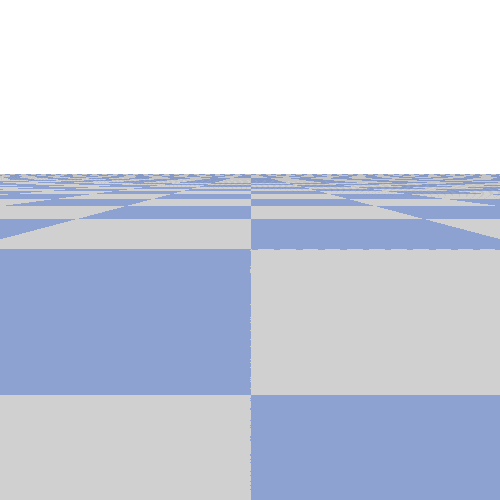

rgba shape=(500, 500, 4), dtype=uint8


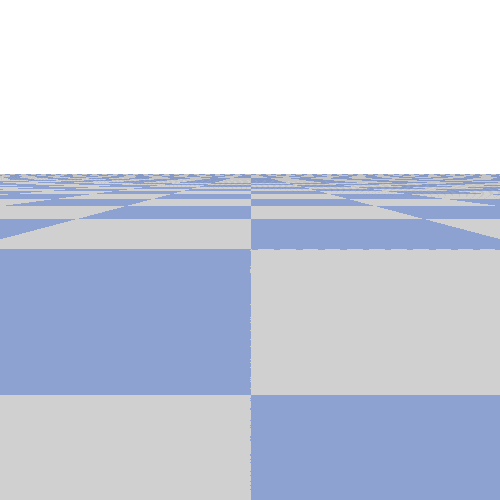

fail
rgba shape=(500, 500, 4), dtype=uint8


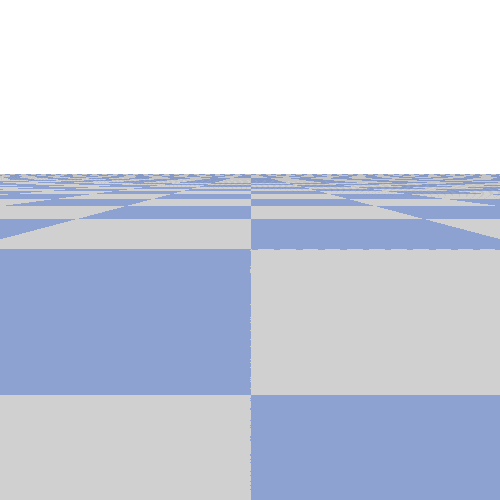

rgba shape=(500, 500, 4), dtype=uint8


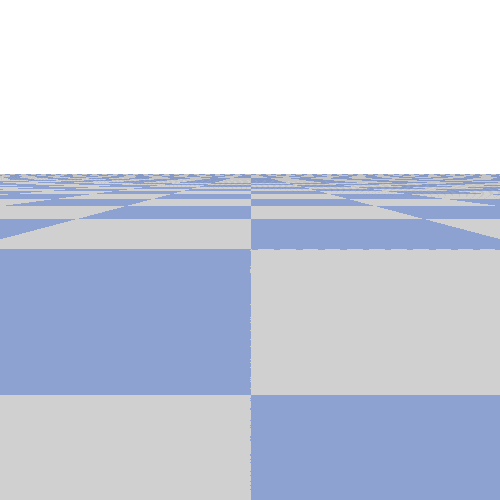

rgba shape=(500, 500, 4), dtype=uint8


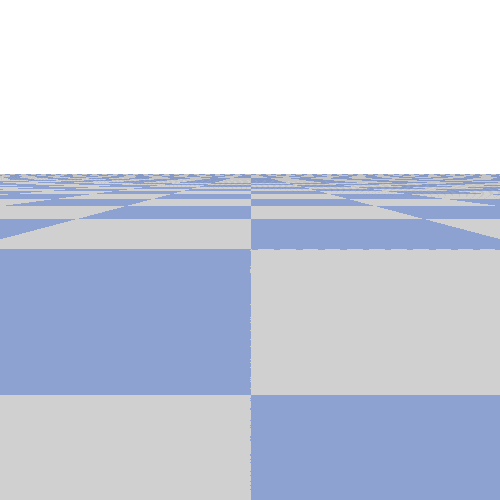

rgba shape=(500, 500, 4), dtype=uint8


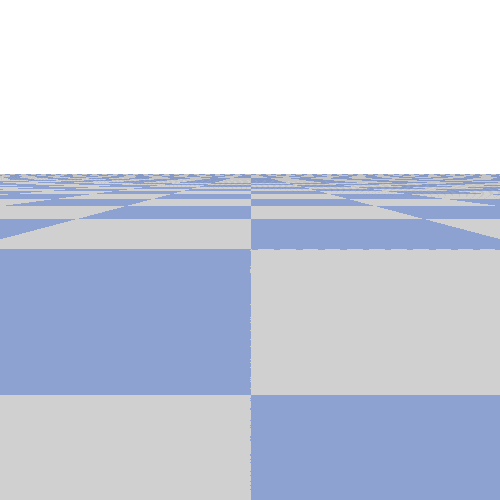

rgba shape=(500, 500, 4), dtype=uint8


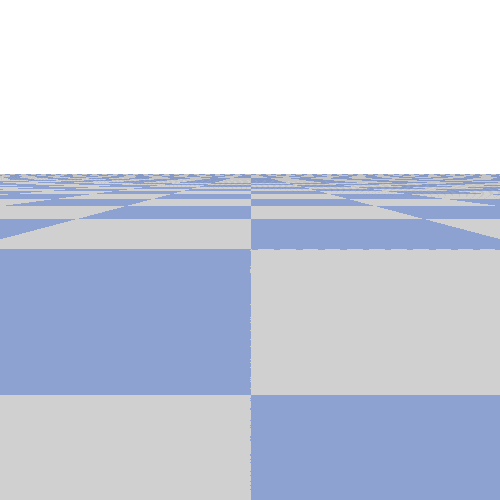

rgba shape=(500, 500, 4), dtype=uint8


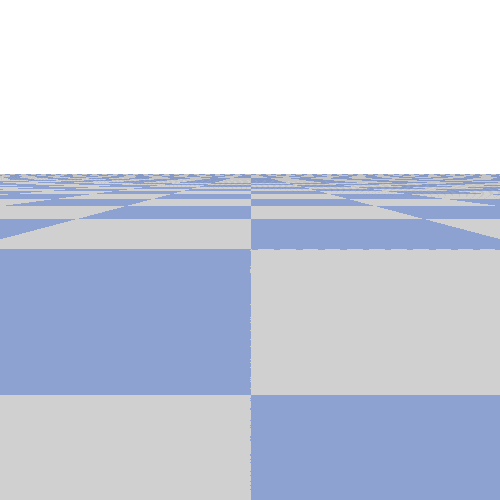

fail
rgba shape=(500, 500, 4), dtype=uint8


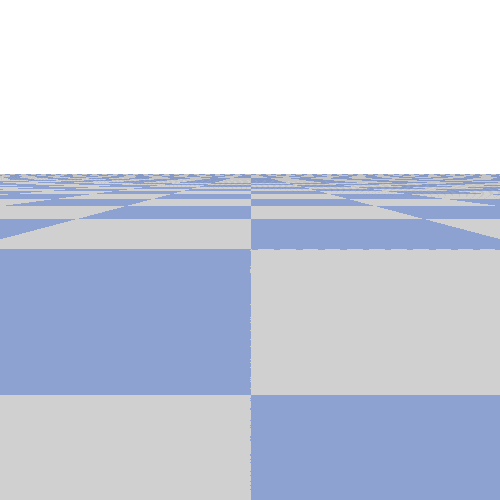

rgba shape=(500, 500, 4), dtype=uint8


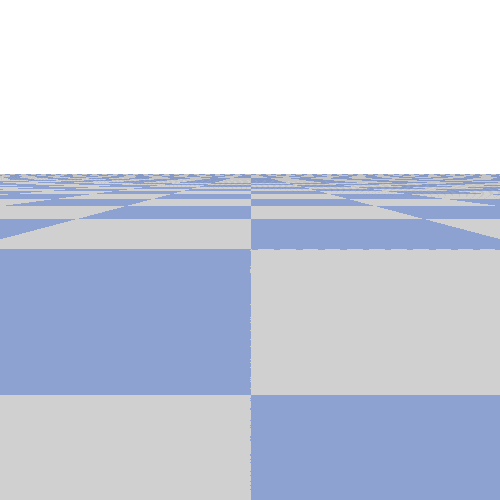

rgba shape=(500, 500, 4), dtype=uint8


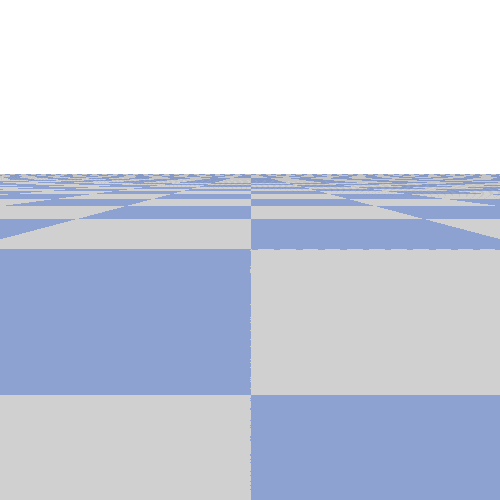

rgba shape=(500, 500, 4), dtype=uint8


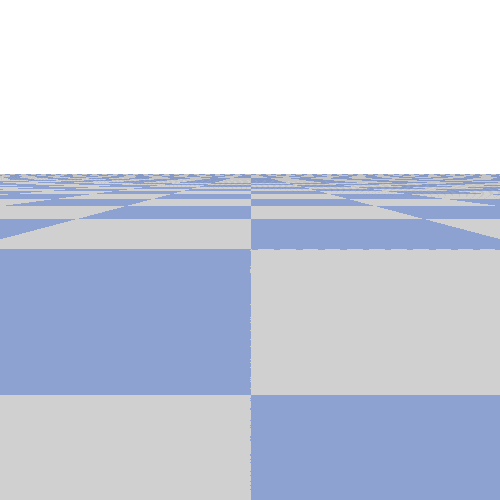

rgba shape=(500, 500, 4), dtype=uint8


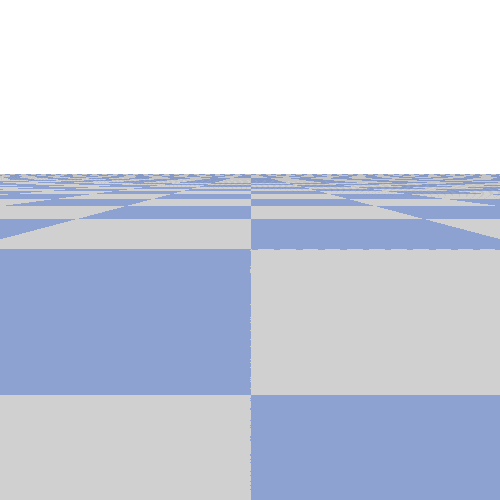

rgba shape=(500, 500, 4), dtype=uint8


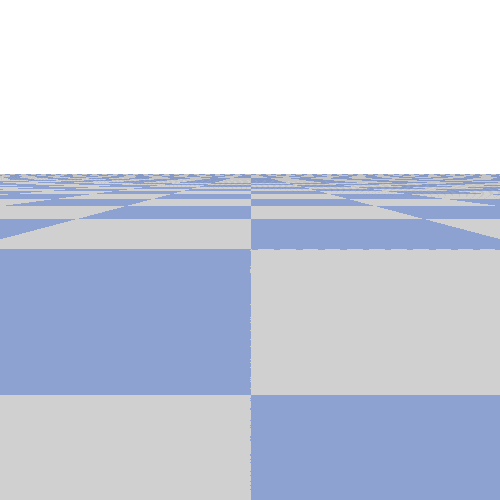

rgba shape=(500, 500, 4), dtype=uint8


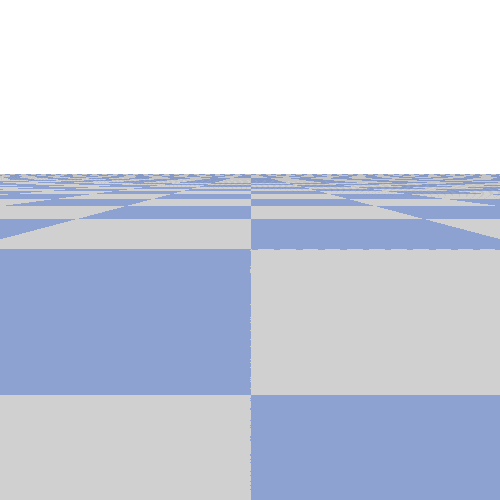

rgba shape=(500, 500, 4), dtype=uint8


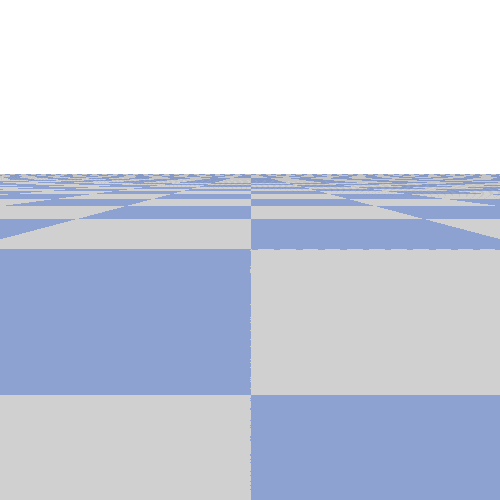

fail
rgba shape=(500, 500, 4), dtype=uint8


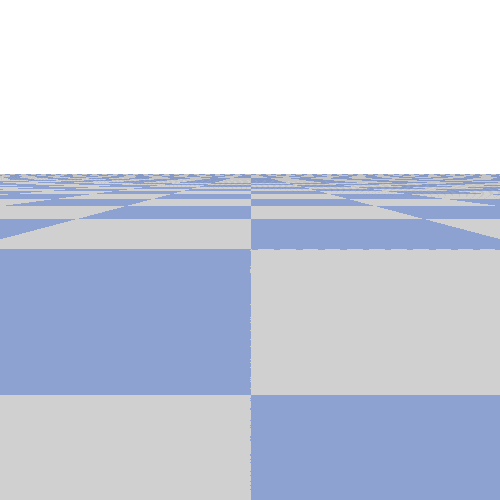

rgba shape=(500, 500, 4), dtype=uint8


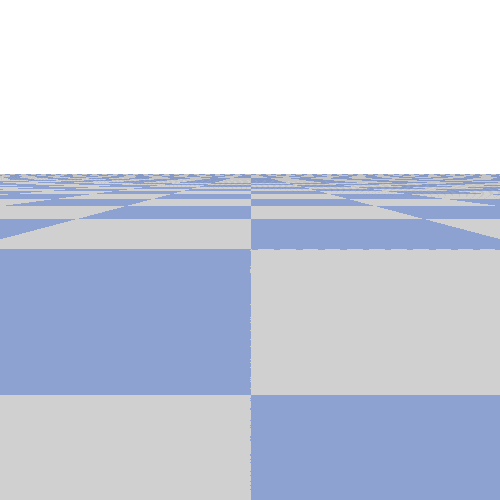

rgba shape=(500, 500, 4), dtype=uint8


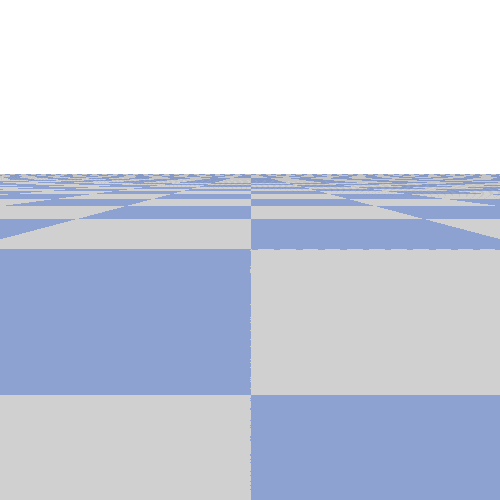

rgba shape=(500, 500, 4), dtype=uint8


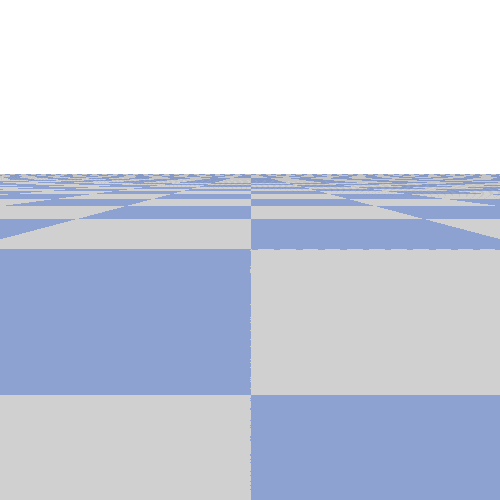

rgba shape=(500, 500, 4), dtype=uint8


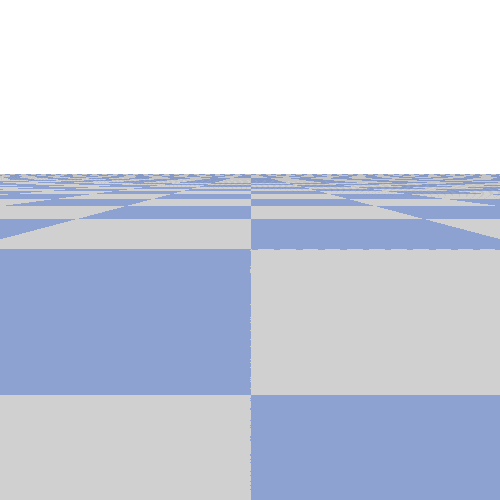

rgba shape=(500, 500, 4), dtype=uint8


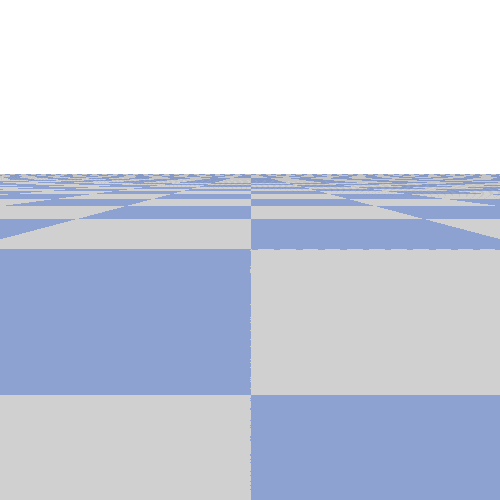

rgba shape=(500, 500, 4), dtype=uint8


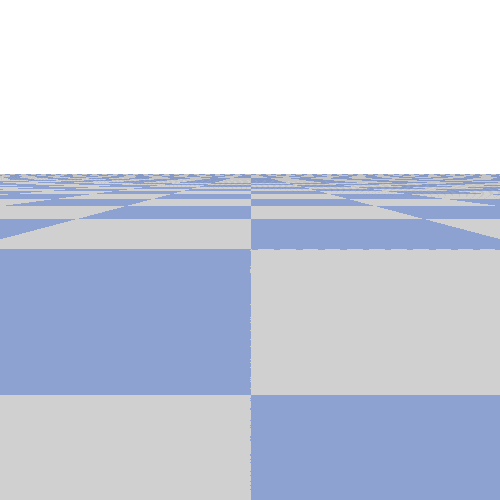

rgba shape=(500, 500, 4), dtype=uint8


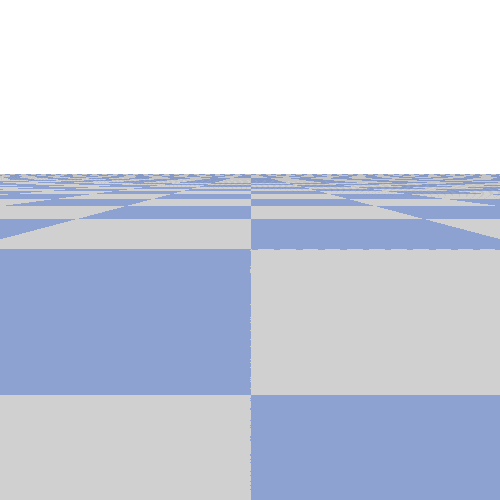

rgba shape=(500, 500, 4), dtype=uint8


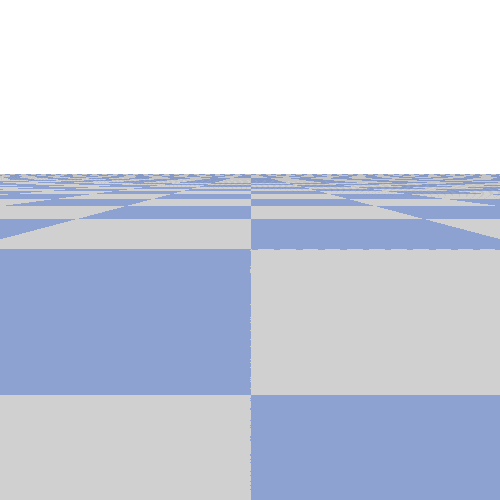

rgba shape=(500, 500, 4), dtype=uint8


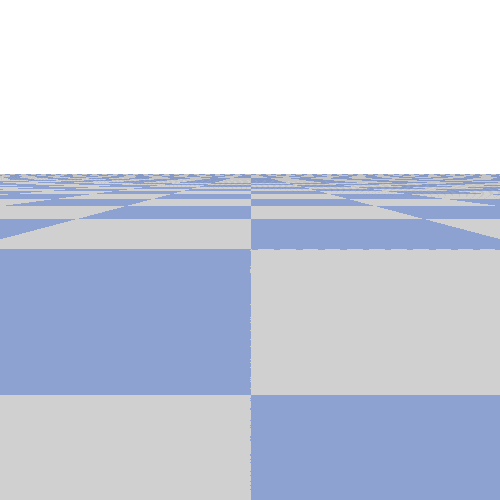

rgba shape=(500, 500, 4), dtype=uint8


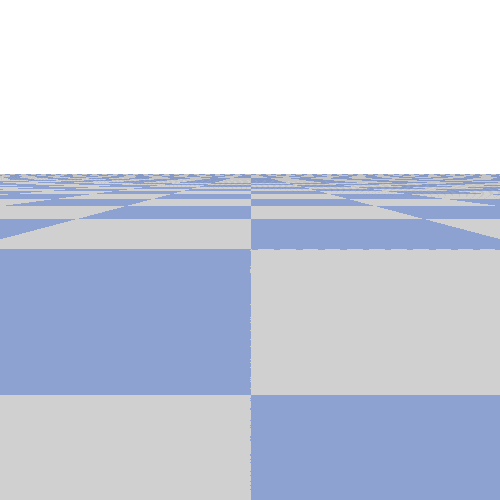

rgba shape=(500, 500, 4), dtype=uint8


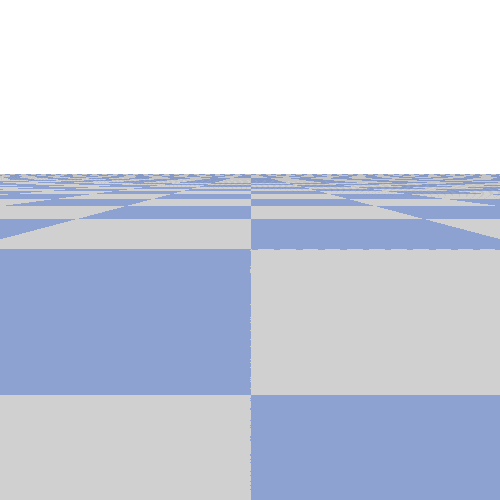

rgba shape=(500, 500, 4), dtype=uint8


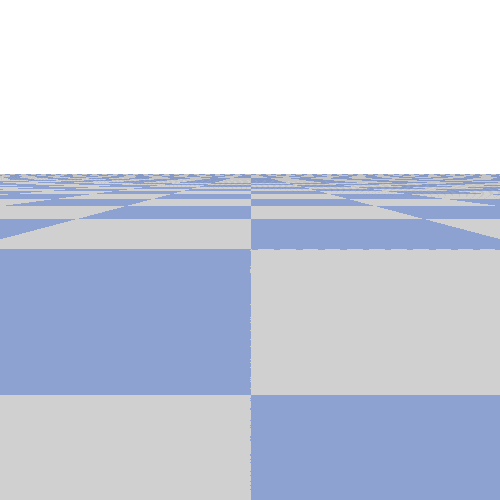

rgba shape=(500, 500, 4), dtype=uint8


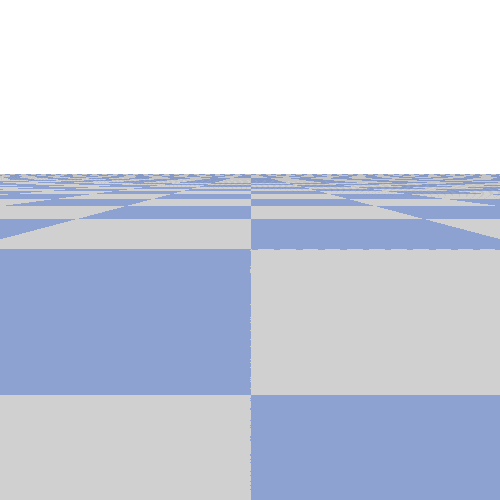

rgba shape=(500, 500, 4), dtype=uint8


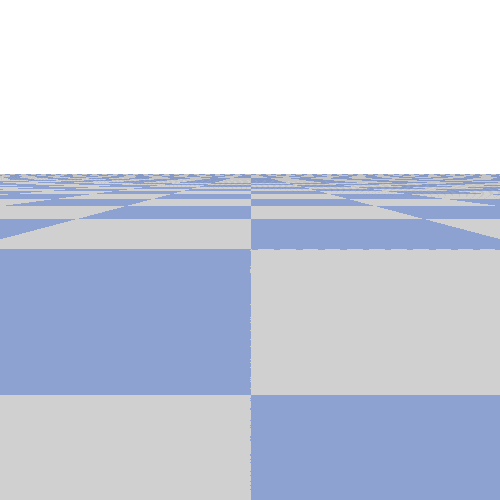

rgba shape=(500, 500, 4), dtype=uint8


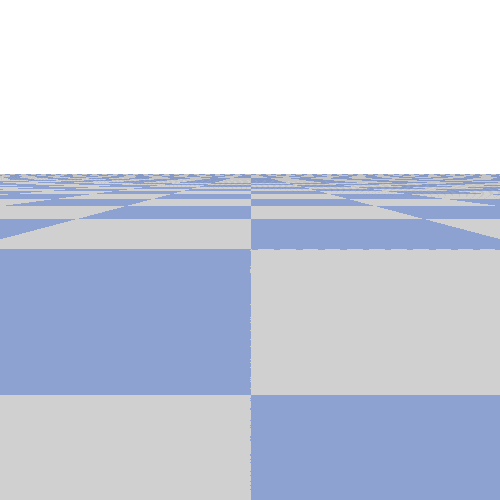

rgba shape=(500, 500, 4), dtype=uint8


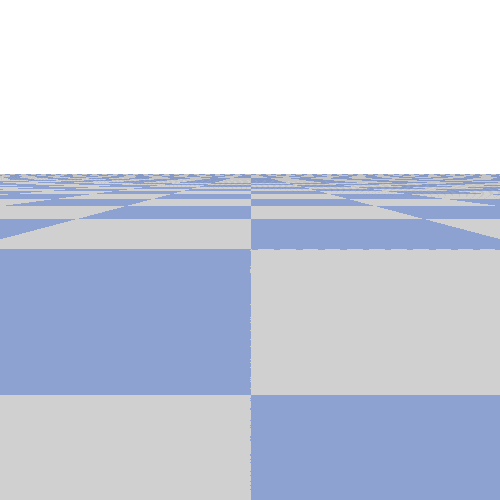

rgba shape=(500, 500, 4), dtype=uint8


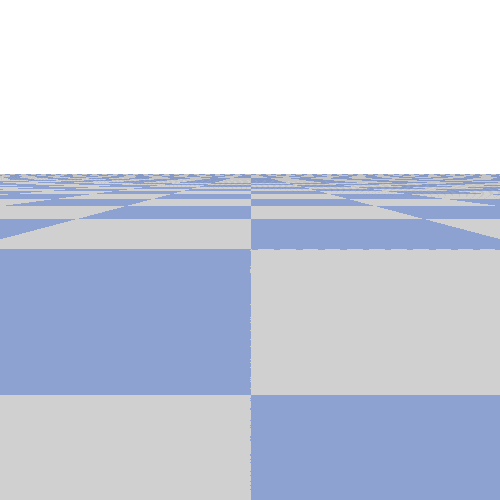

rgba shape=(500, 500, 4), dtype=uint8


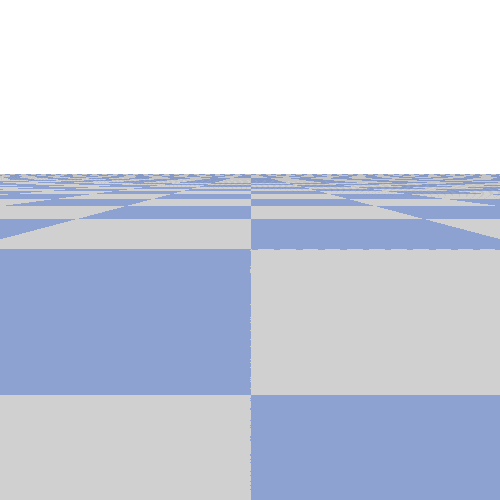

rgba shape=(500, 500, 4), dtype=uint8


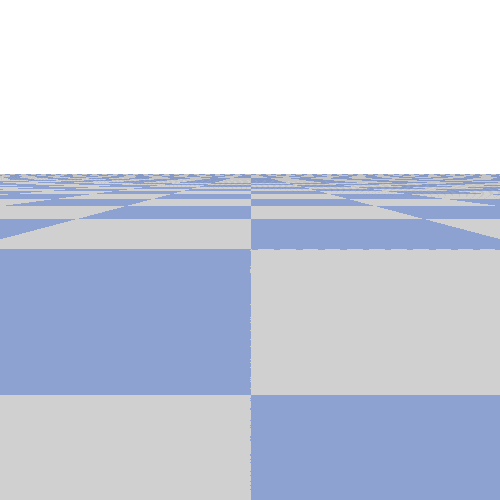

rgba shape=(500, 500, 4), dtype=uint8


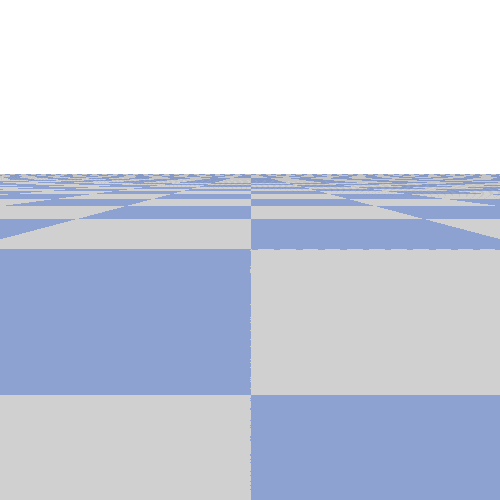

rgba shape=(500, 500, 4), dtype=uint8


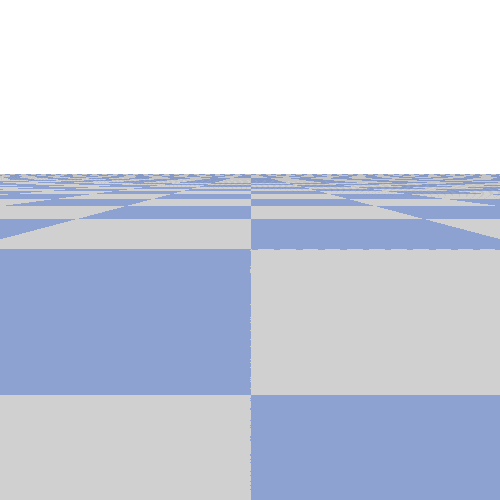

rgba shape=(500, 500, 4), dtype=uint8


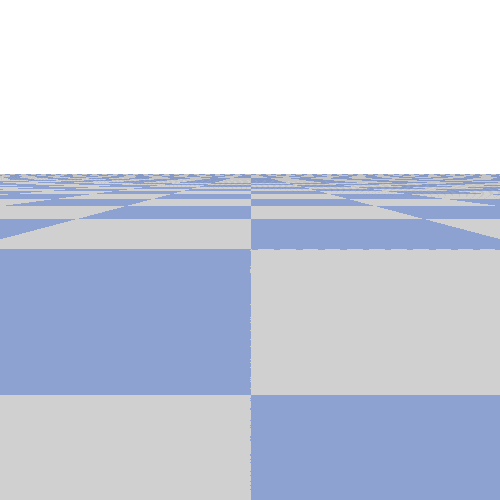

rgba shape=(500, 500, 4), dtype=uint8


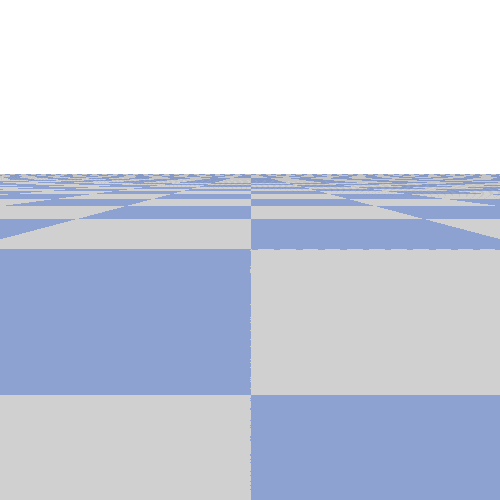

rgba shape=(500, 500, 4), dtype=uint8


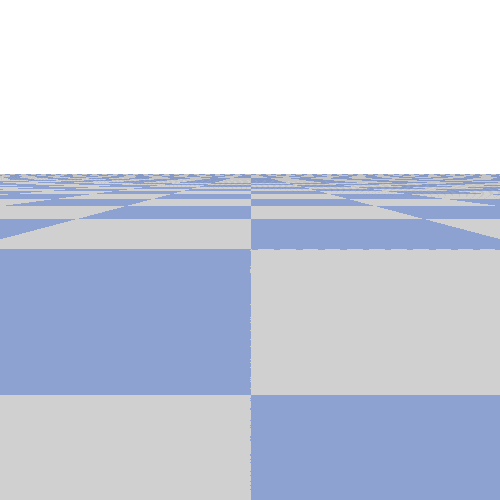

fail
rgba shape=(500, 500, 4), dtype=uint8


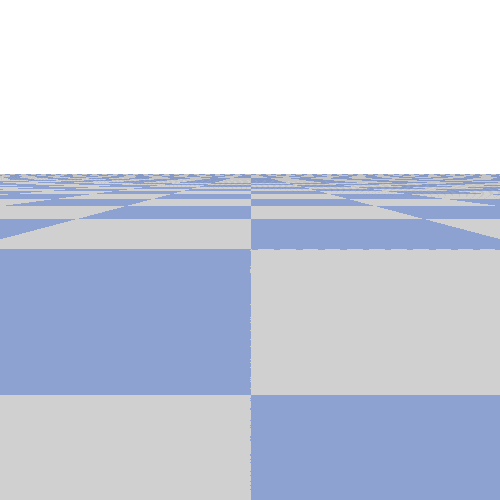

rgba shape=(500, 500, 4), dtype=uint8


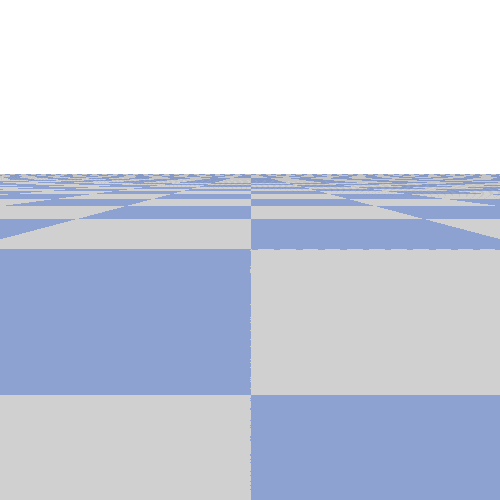

fail
rgba shape=(500, 500, 4), dtype=uint8


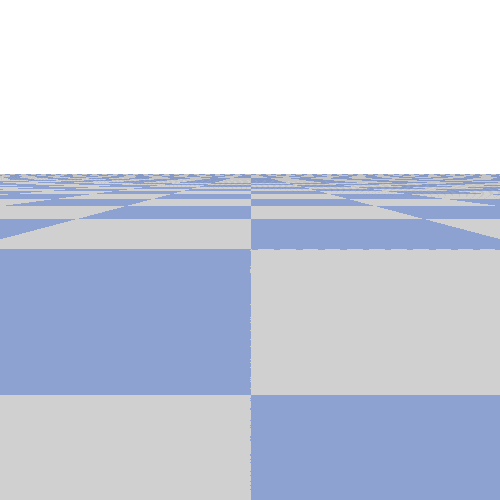

rgba shape=(500, 500, 4), dtype=uint8


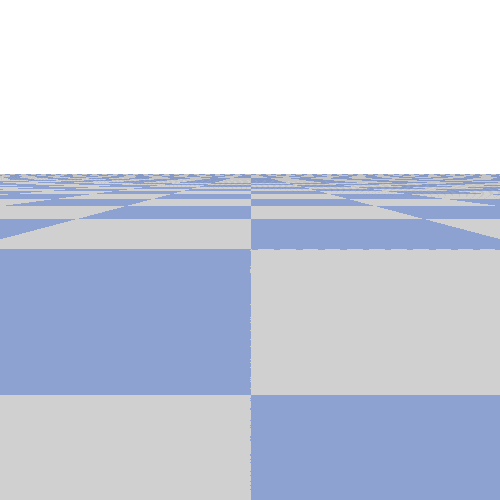

rgba shape=(500, 500, 4), dtype=uint8


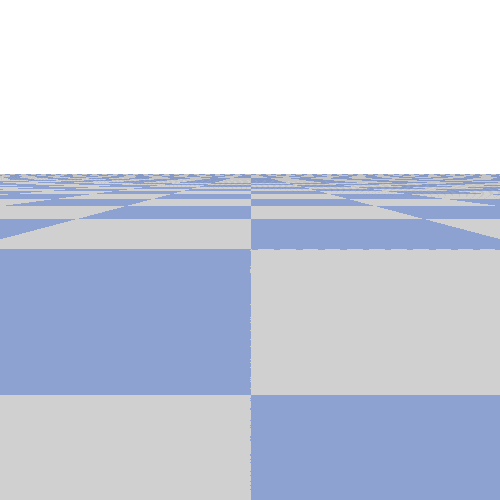

rgba shape=(500, 500, 4), dtype=uint8


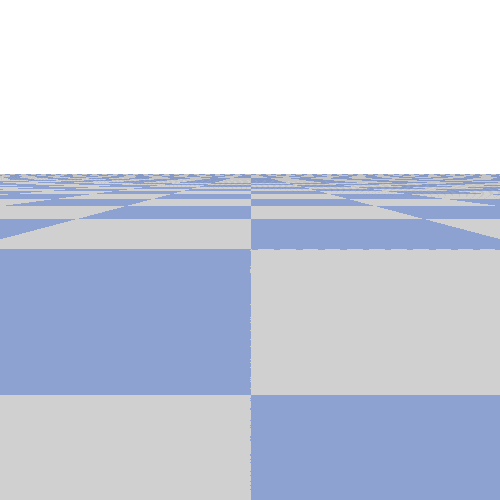

rgba shape=(500, 500, 4), dtype=uint8


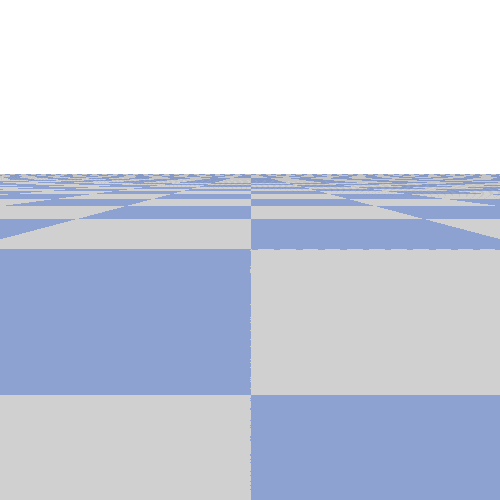

rgba shape=(500, 500, 4), dtype=uint8


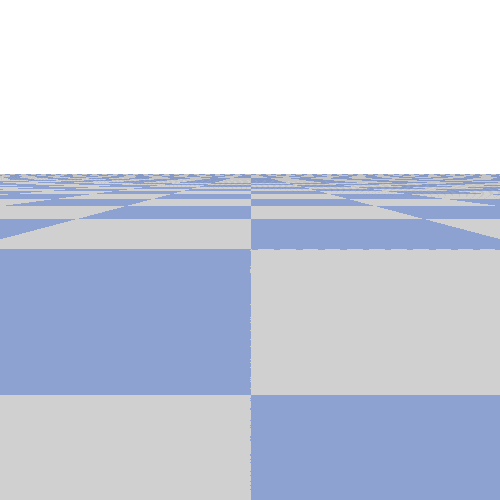

rgba shape=(500, 500, 4), dtype=uint8


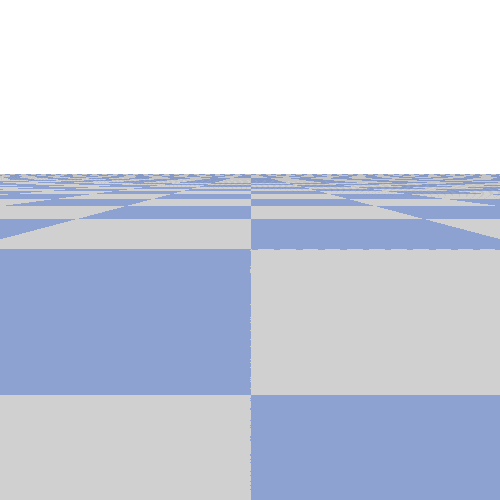

rgba shape=(500, 500, 4), dtype=uint8


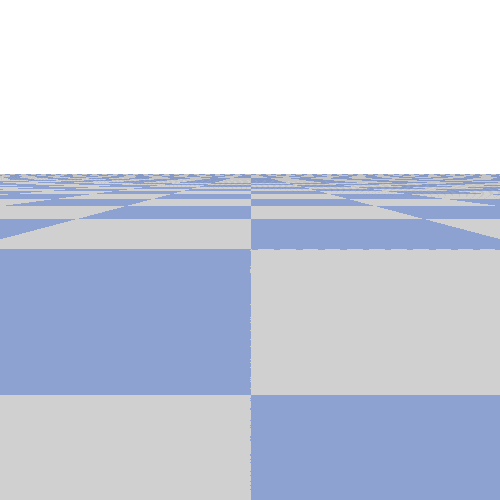

rgba shape=(500, 500, 4), dtype=uint8


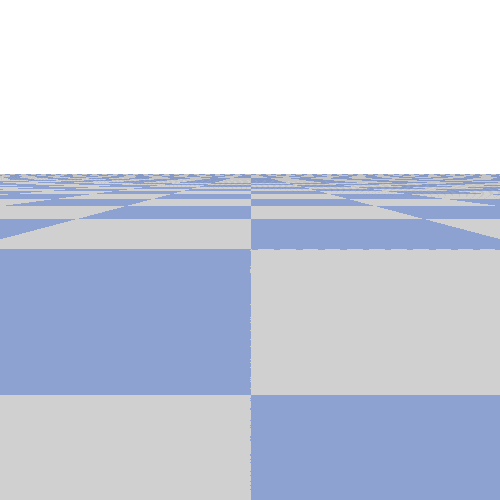

rgba shape=(500, 500, 4), dtype=uint8


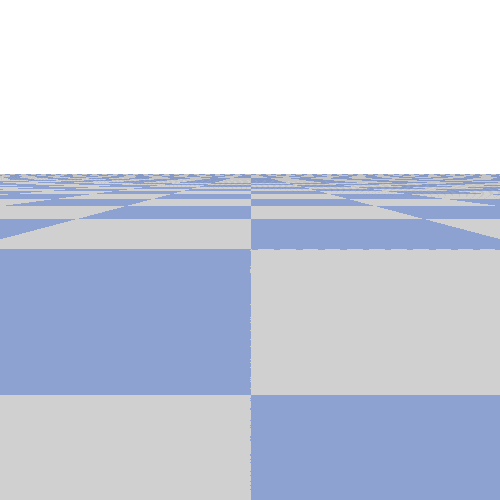

rgba shape=(500, 500, 4), dtype=uint8


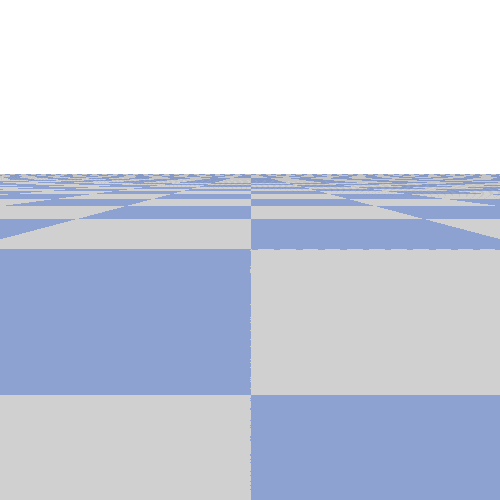

rgba shape=(500, 500, 4), dtype=uint8


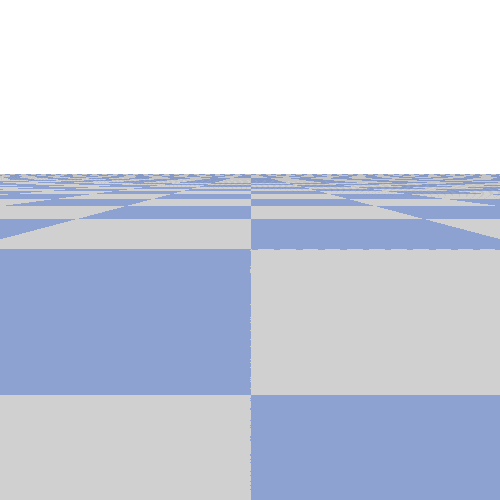

rgba shape=(500, 500, 4), dtype=uint8


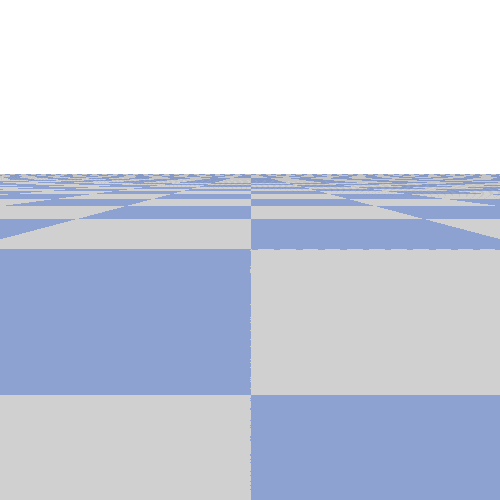

rgba shape=(500, 500, 4), dtype=uint8


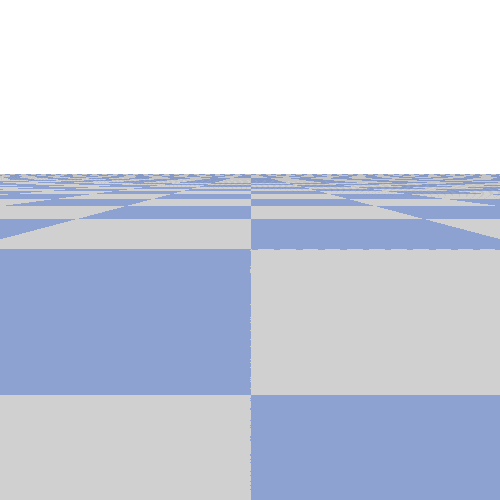

In [20]:
steps=500
Q_table=init_q(9 , 9)
total_rewards=[]
old_state=myRobot.resetEnvironment()
for i in range(steps):
    
    try :
        action = epsilon_greedy(Q_table ,epsilon , 9 , old_state) 
        new_state, reward = myRobot.step(action)
        Q_table[old_state,action] += lr * ( reward + (discount_rate * np.max(Q_table[new_state , :])) - Q_table[old_state,action])
        total_rewards.append(reward)
        old_state=new_state
    except: print("fail")

In [22]:
Q_table

array([[0.378919  , 0.33786711, 0.33463452, 0.33568615, 0.34670165,
        0.34598436, 0.        , 0.42281874, 0.36792818],
       [0.34009098, 0.        , 0.        , 0.        , 0.        ,
        0.26381272, 0.        , 0.31275163, 0.        ],
       [0.37657851, 0.2468935 , 0.        , 0.25024219, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.37104279, 0.26462305, 0.        , 0.3244024 , 0.33206563,
        0.        , 0.        , 0.        , 0.28831517],
       [0.        , 0.        , 0.17933733, 0.        , 0.26953656,
        0.        , 0.        , 0.30696735, 0.37309441],
       [0.38813049, 0.        , 0.32060548, 0.26096527, 0.27386518,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.33314058, 0.28655788, 0.28988269, 0.27808489, 0.29387264,
        0.27948091, 0.        , 0.29843698, 0.28638267],


rgba shape=(500, 500, 4), dtype=uint8


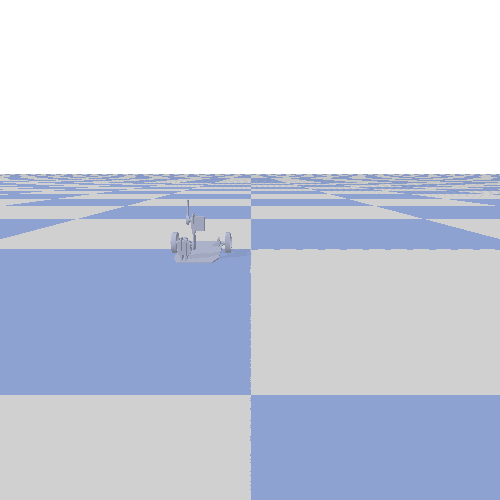

rgba shape=(500, 500, 4), dtype=uint8


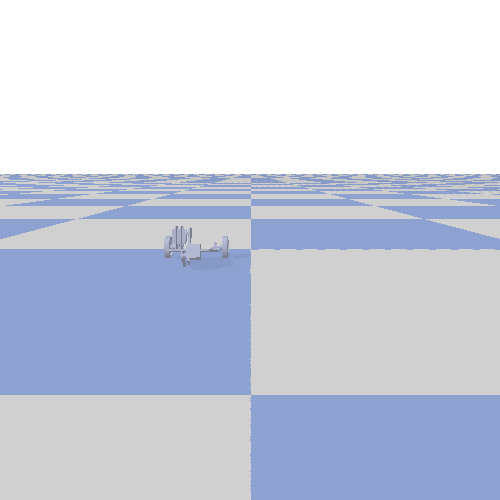

rgba shape=(500, 500, 4), dtype=uint8


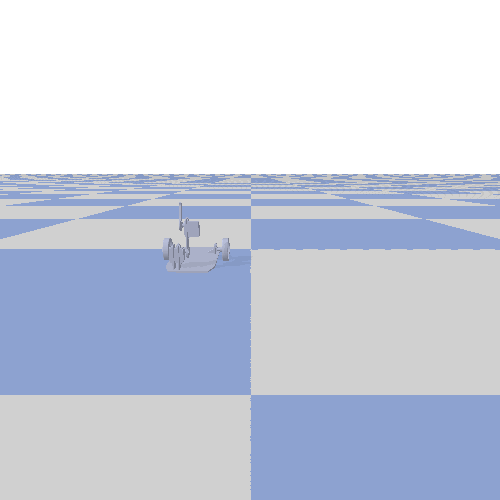

rgba shape=(500, 500, 4), dtype=uint8


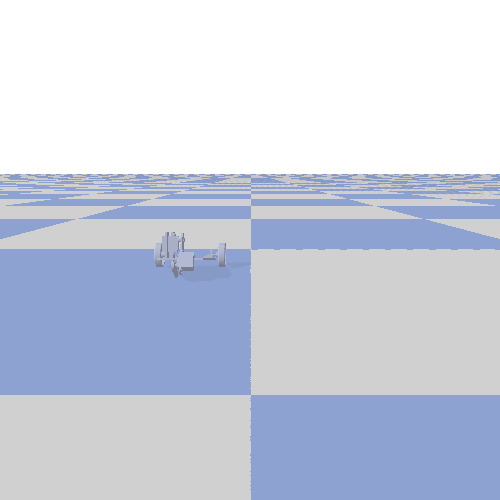

rgba shape=(500, 500, 4), dtype=uint8


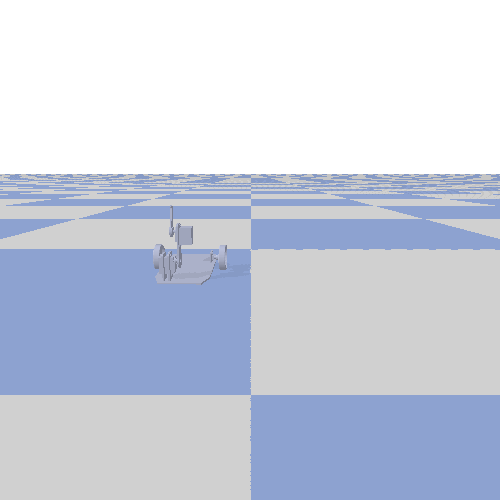

rgba shape=(500, 500, 4), dtype=uint8


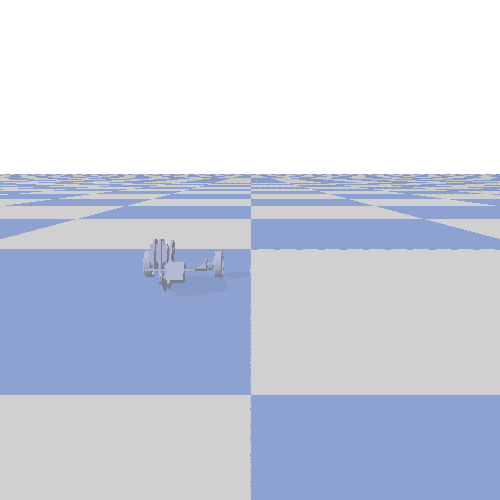

rgba shape=(500, 500, 4), dtype=uint8


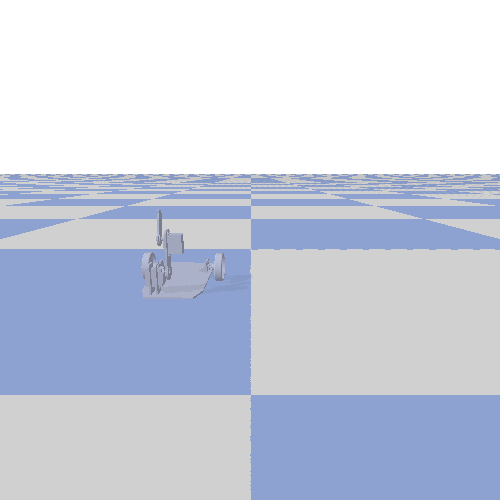

rgba shape=(500, 500, 4), dtype=uint8


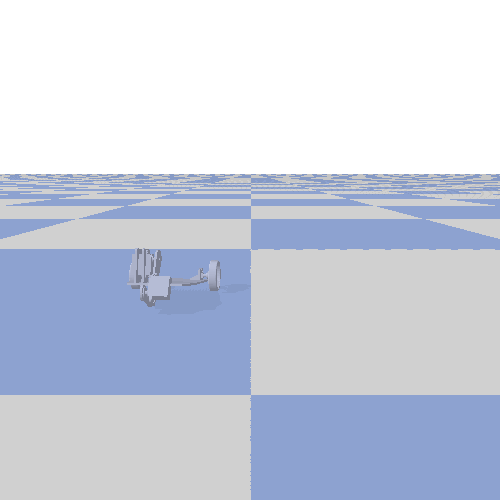

rgba shape=(500, 500, 4), dtype=uint8


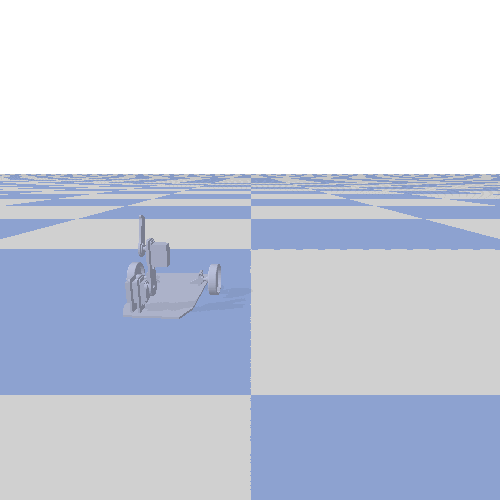

rgba shape=(500, 500, 4), dtype=uint8


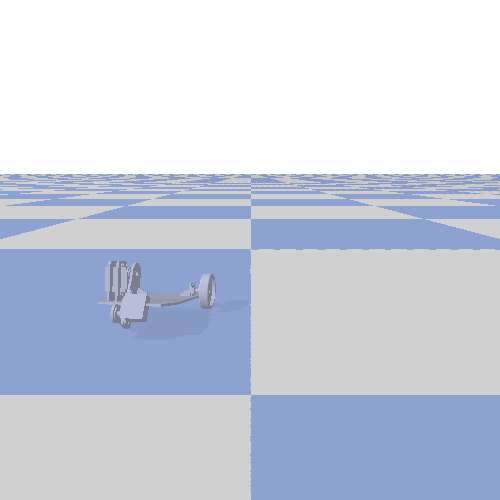

rgba shape=(500, 500, 4), dtype=uint8


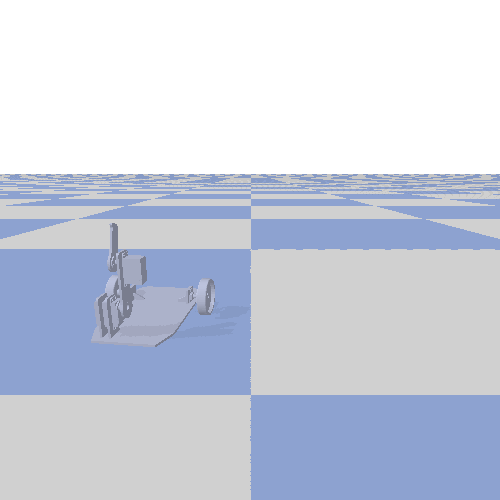

rgba shape=(500, 500, 4), dtype=uint8


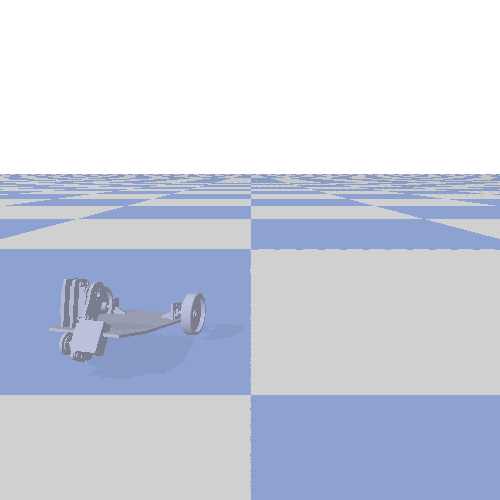

rgba shape=(500, 500, 4), dtype=uint8


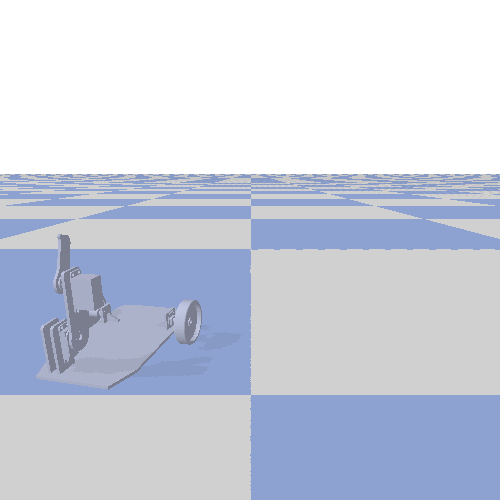

rgba shape=(500, 500, 4), dtype=uint8


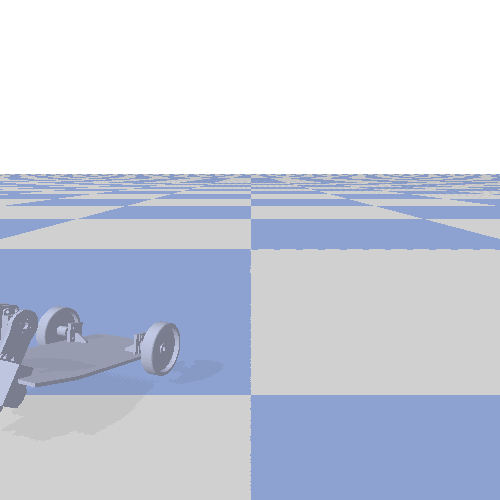

rgba shape=(500, 500, 4), dtype=uint8


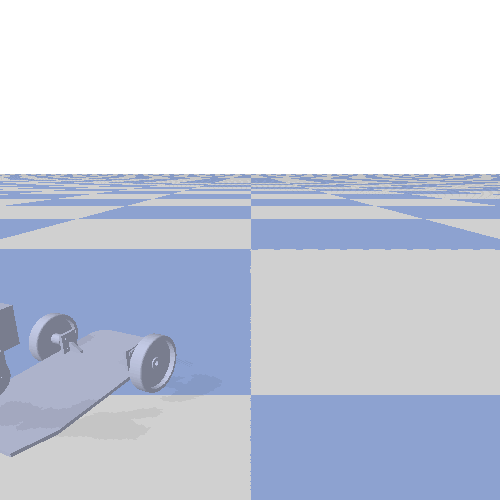

rgba shape=(500, 500, 4), dtype=uint8


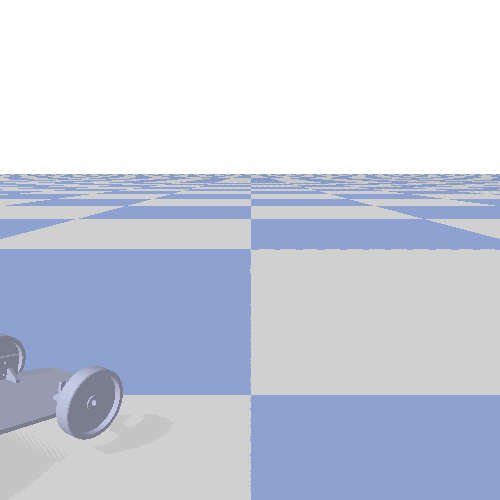

rgba shape=(500, 500, 4), dtype=uint8


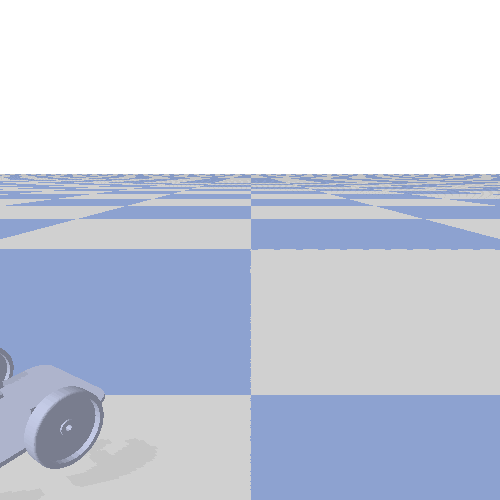

rgba shape=(500, 500, 4), dtype=uint8


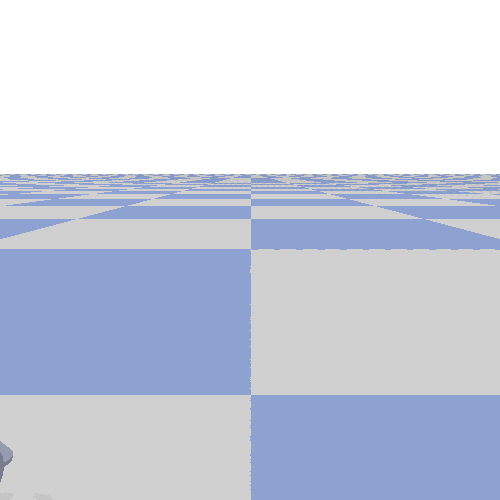

rgba shape=(500, 500, 4), dtype=uint8


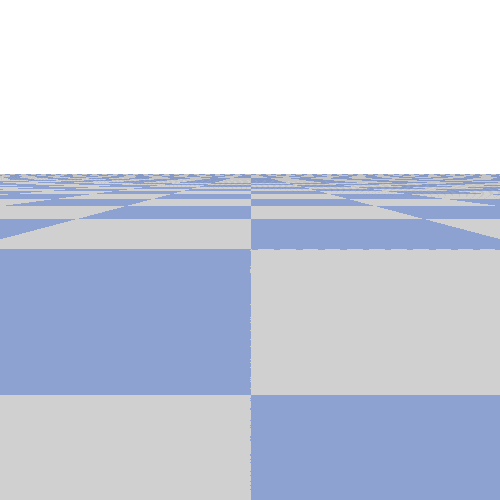

rgba shape=(500, 500, 4), dtype=uint8


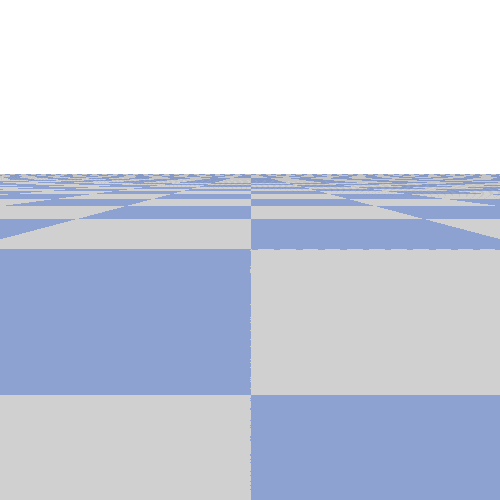

rgba shape=(500, 500, 4), dtype=uint8


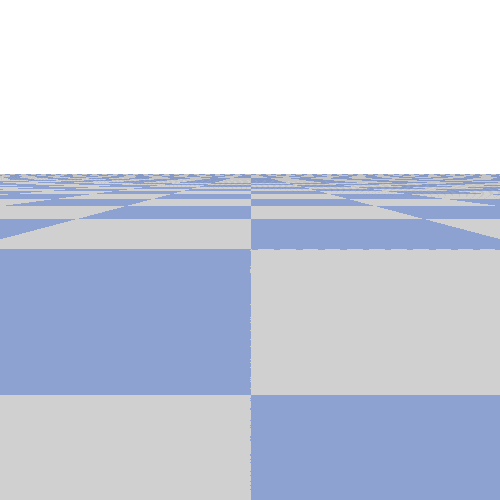

rgba shape=(500, 500, 4), dtype=uint8


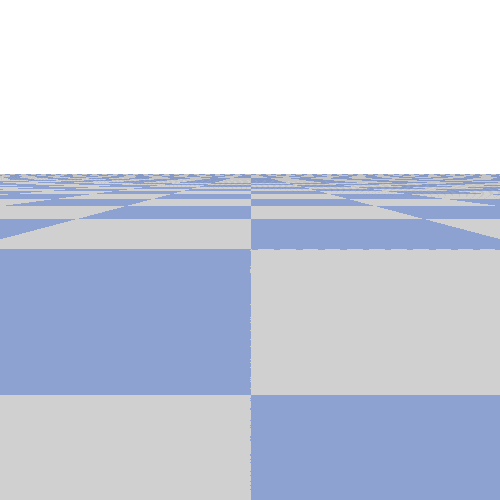

rgba shape=(500, 500, 4), dtype=uint8


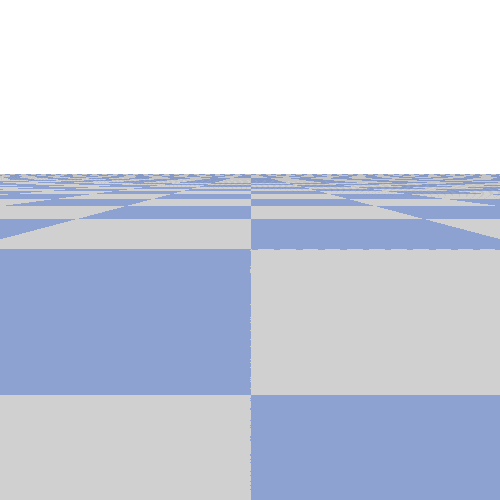

rgba shape=(500, 500, 4), dtype=uint8


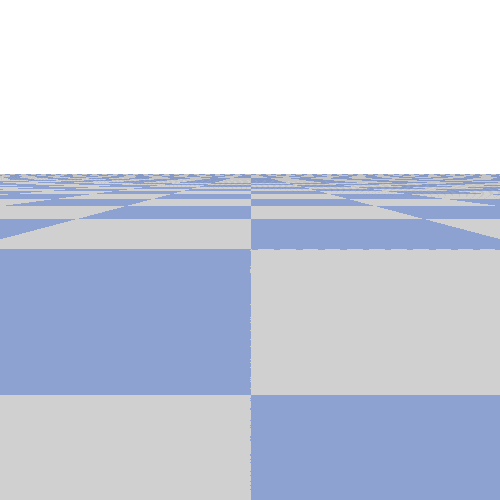

rgba shape=(500, 500, 4), dtype=uint8


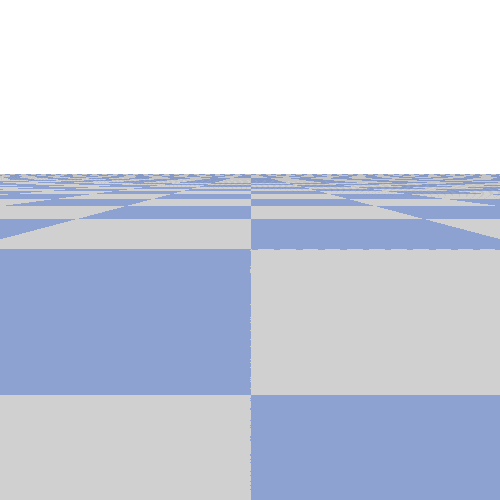

rgba shape=(500, 500, 4), dtype=uint8


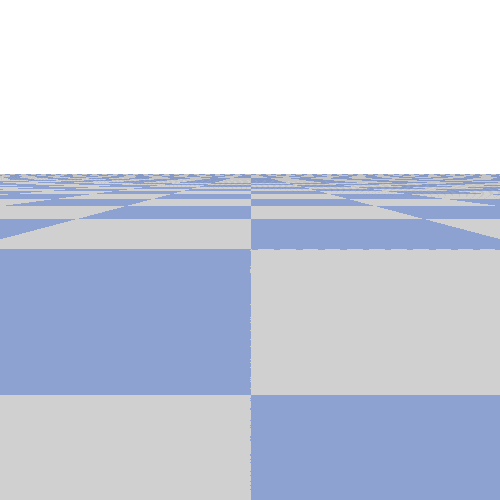

rgba shape=(500, 500, 4), dtype=uint8


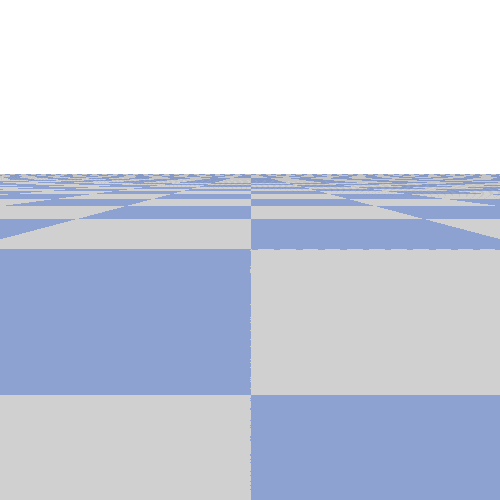

rgba shape=(500, 500, 4), dtype=uint8


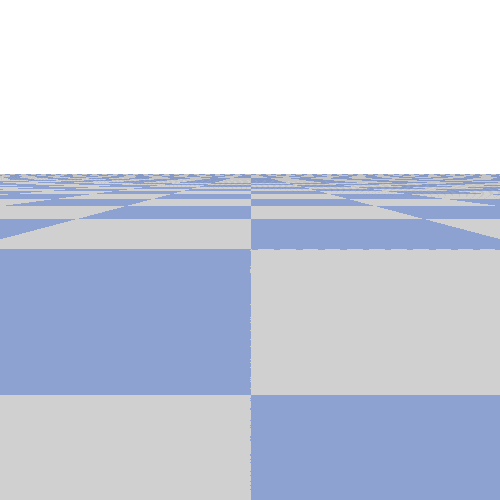

rgba shape=(500, 500, 4), dtype=uint8


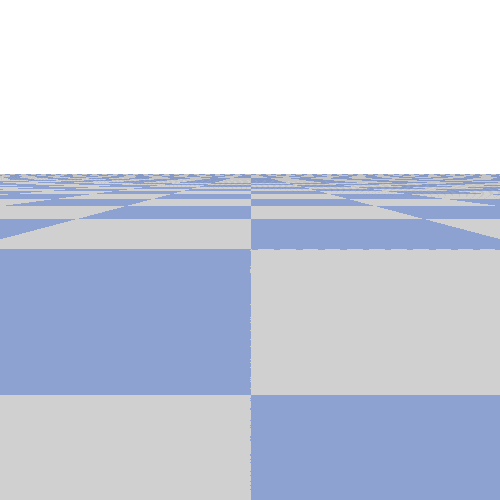

rgba shape=(500, 500, 4), dtype=uint8


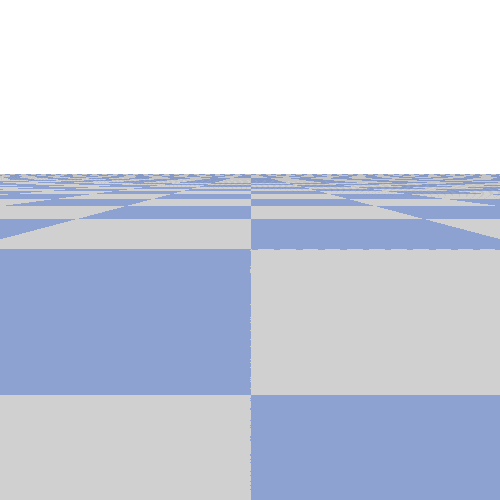

rgba shape=(500, 500, 4), dtype=uint8


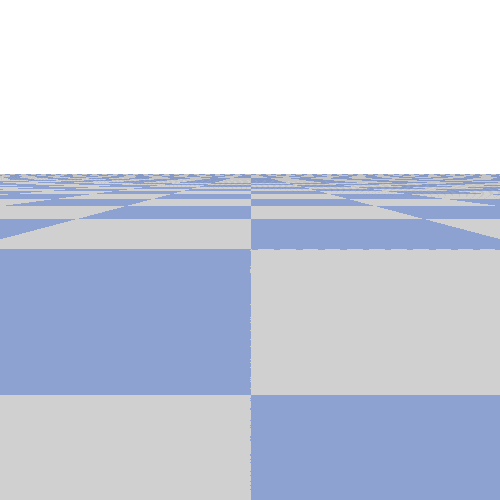

rgba shape=(500, 500, 4), dtype=uint8


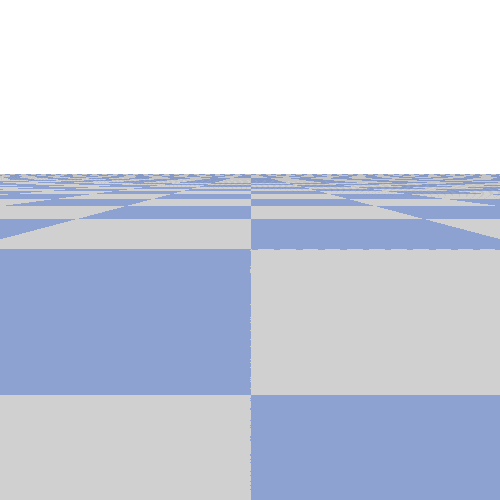

rgba shape=(500, 500, 4), dtype=uint8


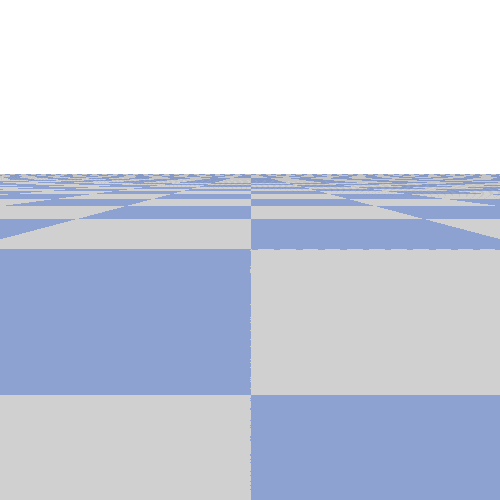

rgba shape=(500, 500, 4), dtype=uint8


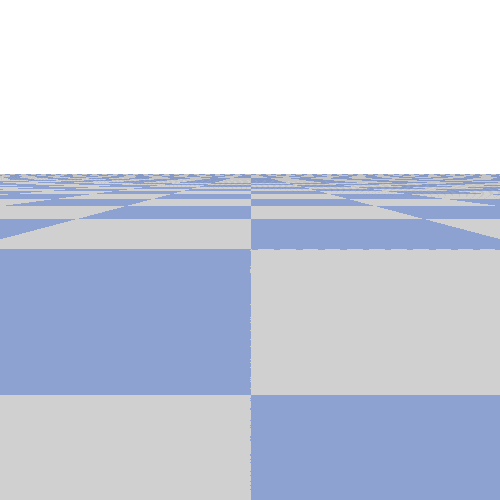

rgba shape=(500, 500, 4), dtype=uint8


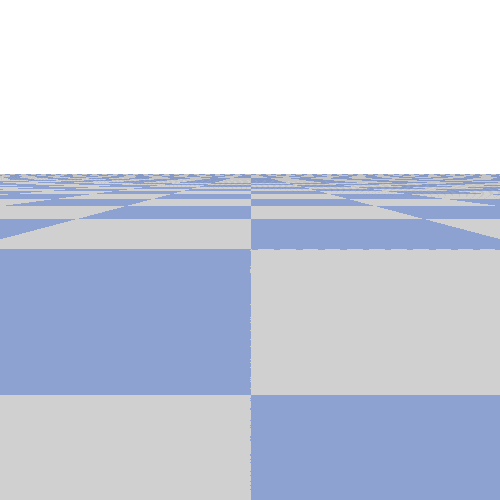

rgba shape=(500, 500, 4), dtype=uint8


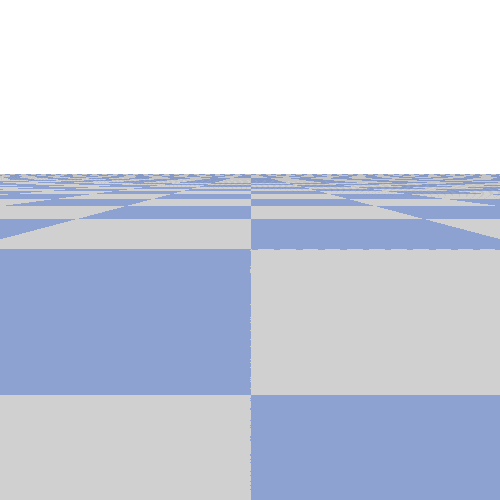

rgba shape=(500, 500, 4), dtype=uint8


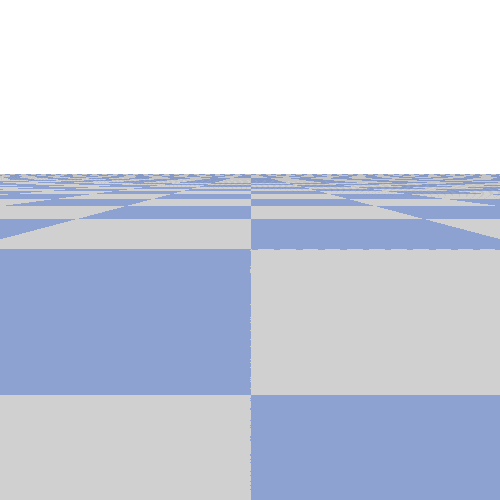

rgba shape=(500, 500, 4), dtype=uint8


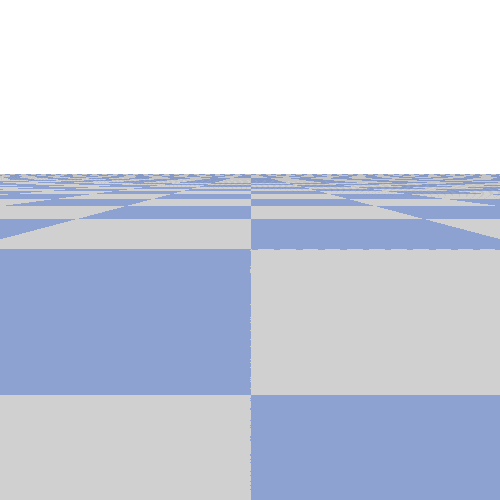

rgba shape=(500, 500, 4), dtype=uint8


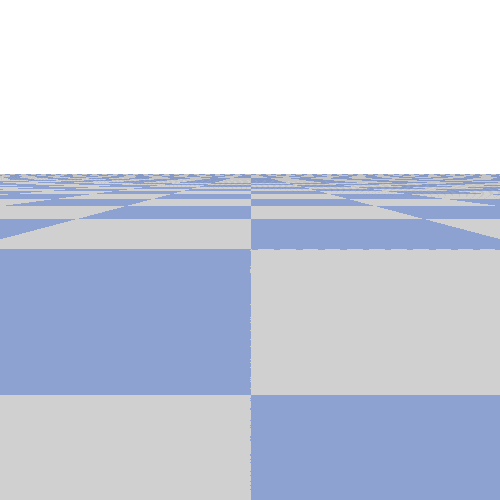

rgba shape=(500, 500, 4), dtype=uint8


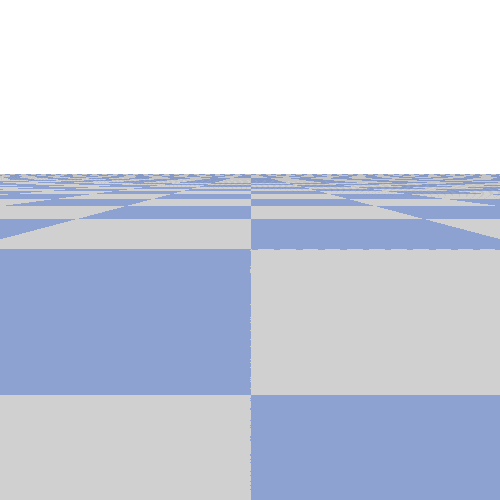

rgba shape=(500, 500, 4), dtype=uint8


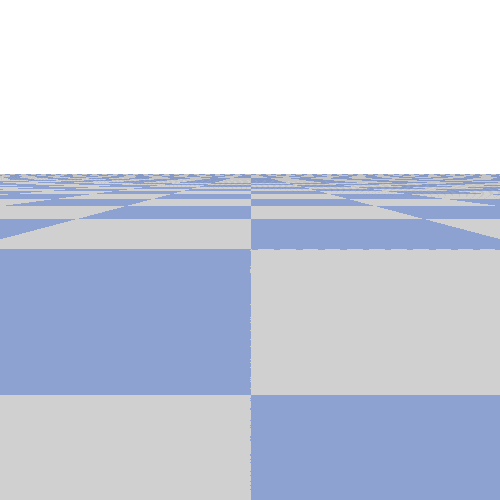

rgba shape=(500, 500, 4), dtype=uint8


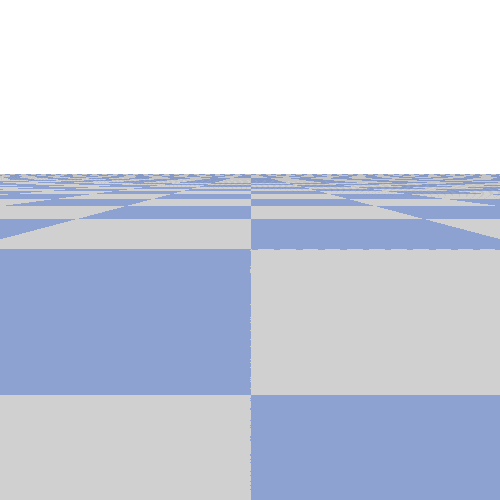

rgba shape=(500, 500, 4), dtype=uint8


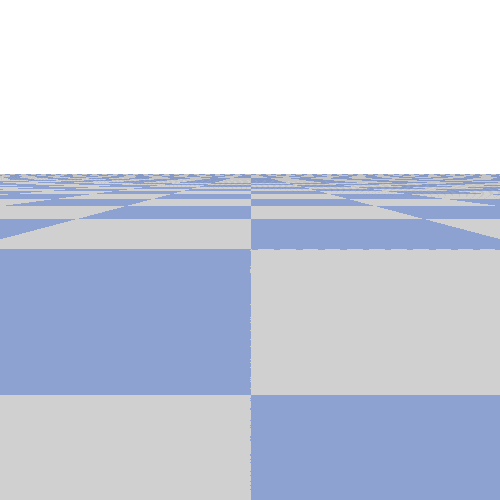

rgba shape=(500, 500, 4), dtype=uint8


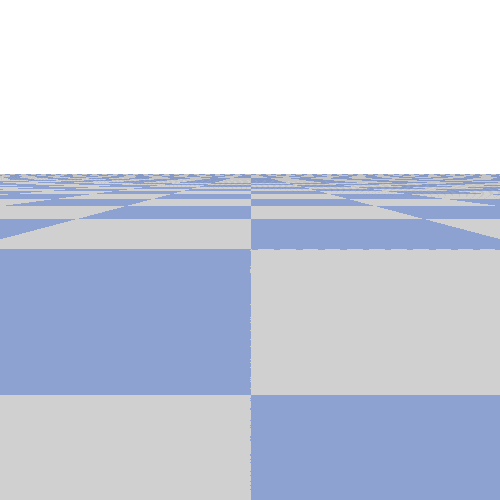

rgba shape=(500, 500, 4), dtype=uint8


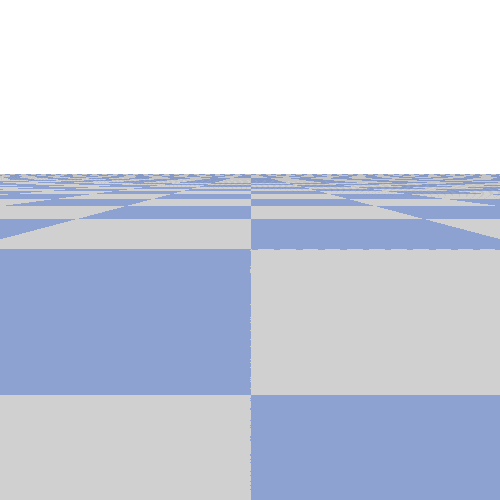

rgba shape=(500, 500, 4), dtype=uint8


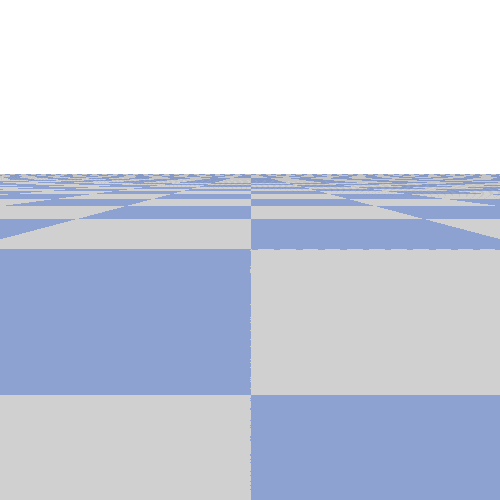

rgba shape=(500, 500, 4), dtype=uint8


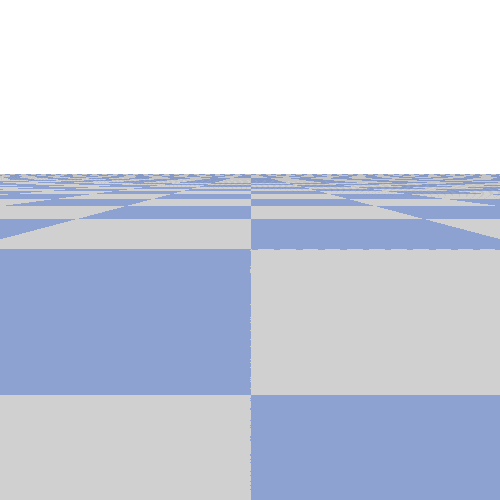

rgba shape=(500, 500, 4), dtype=uint8


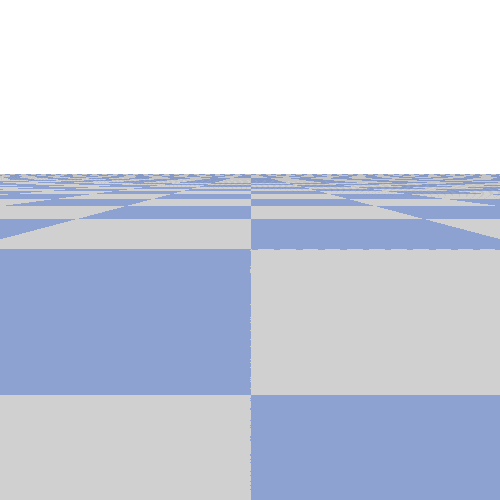

rgba shape=(500, 500, 4), dtype=uint8


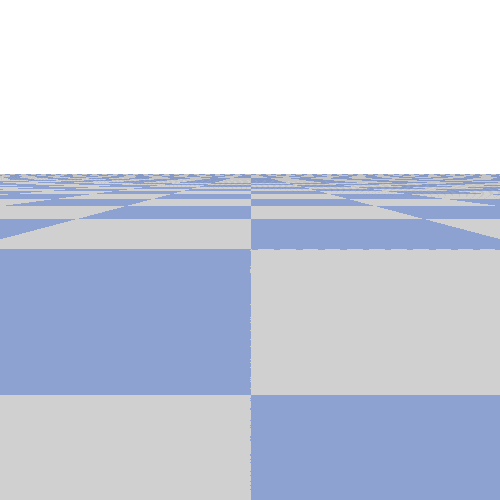

rgba shape=(500, 500, 4), dtype=uint8


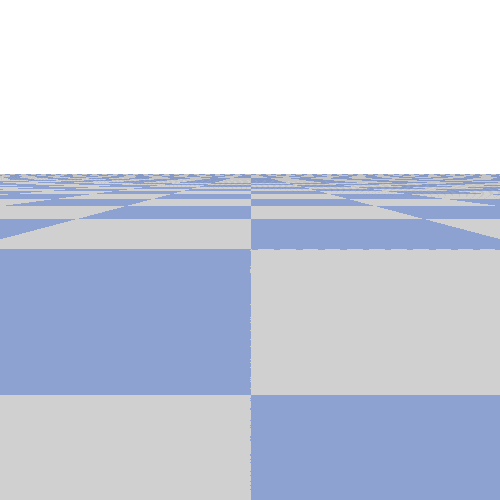

rgba shape=(500, 500, 4), dtype=uint8


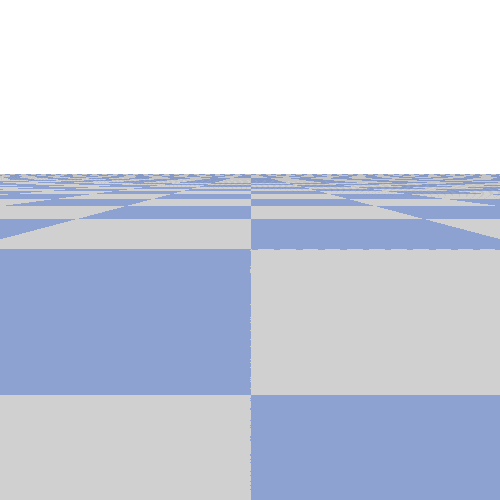

rgba shape=(500, 500, 4), dtype=uint8


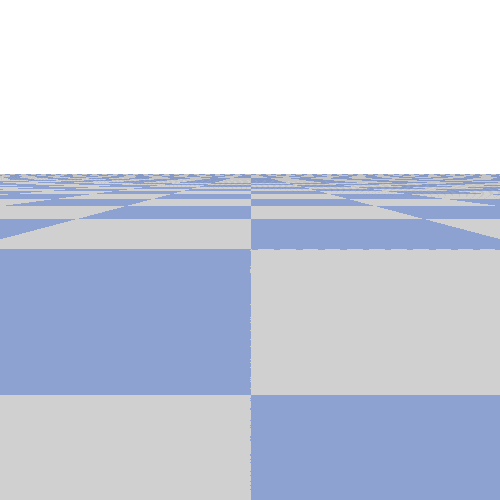

rgba shape=(500, 500, 4), dtype=uint8


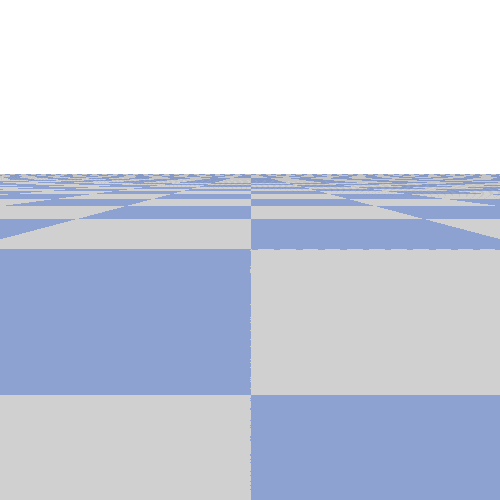

rgba shape=(500, 500, 4), dtype=uint8


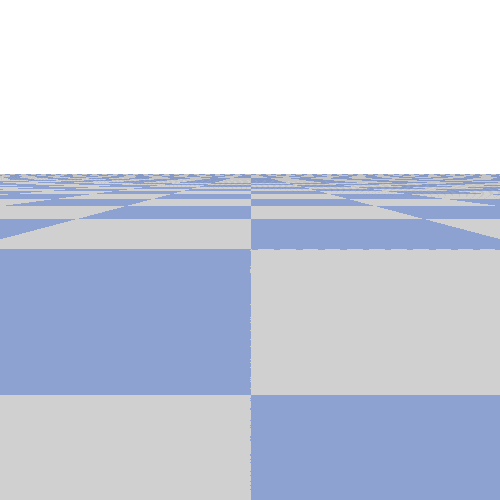

rgba shape=(500, 500, 4), dtype=uint8


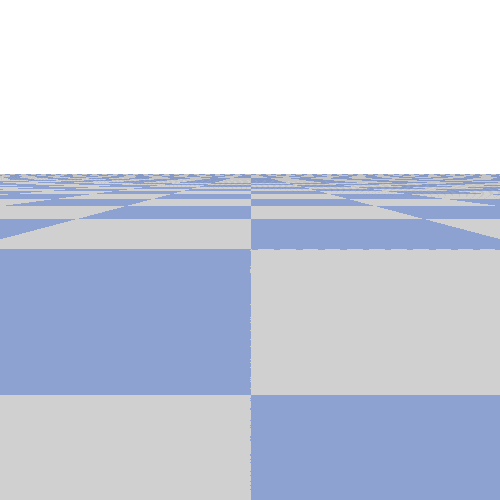

rgba shape=(500, 500, 4), dtype=uint8


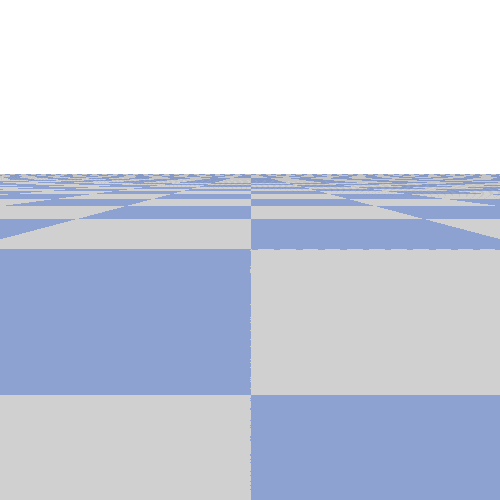

rgba shape=(500, 500, 4), dtype=uint8


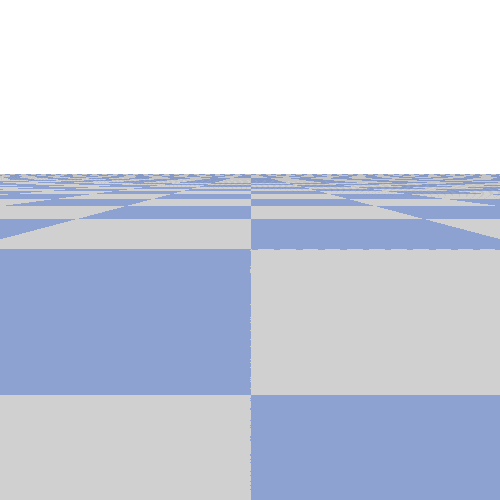

rgba shape=(500, 500, 4), dtype=uint8


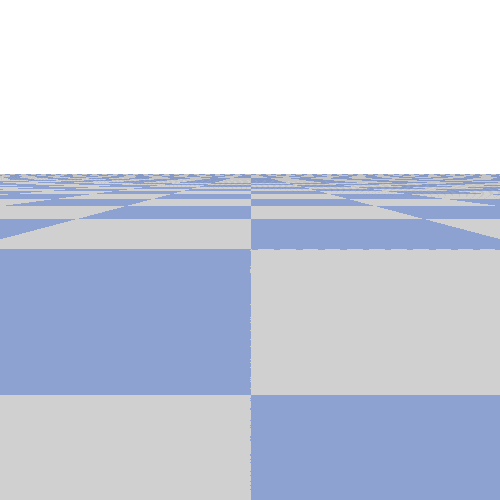

rgba shape=(500, 500, 4), dtype=uint8


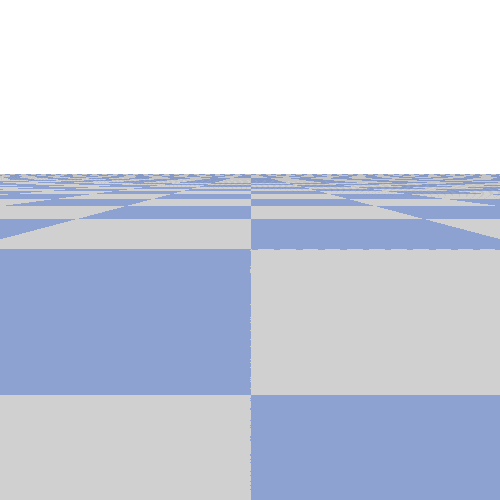

rgba shape=(500, 500, 4), dtype=uint8


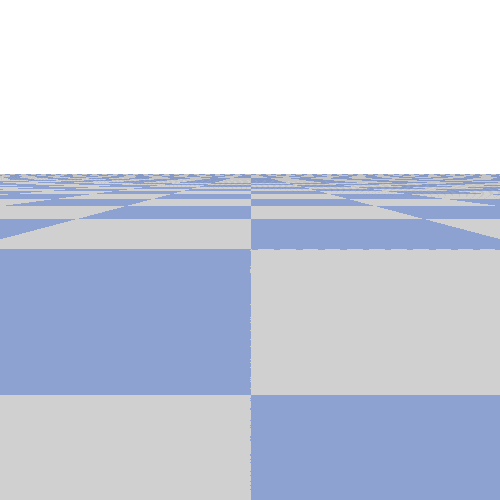

rgba shape=(500, 500, 4), dtype=uint8


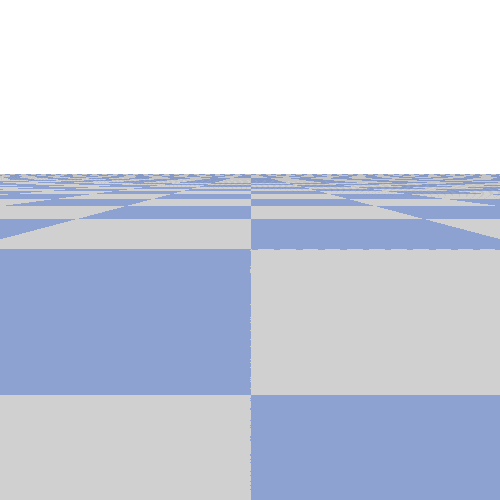

rgba shape=(500, 500, 4), dtype=uint8


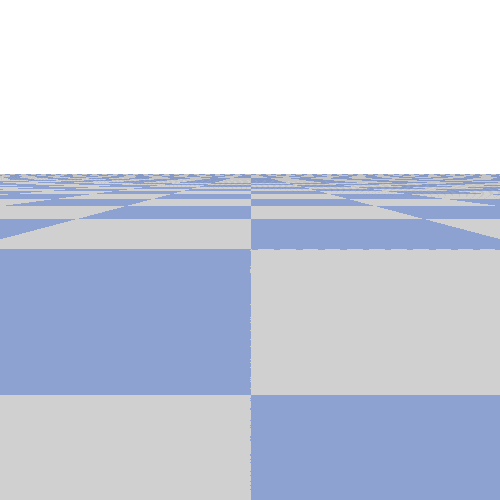

rgba shape=(500, 500, 4), dtype=uint8


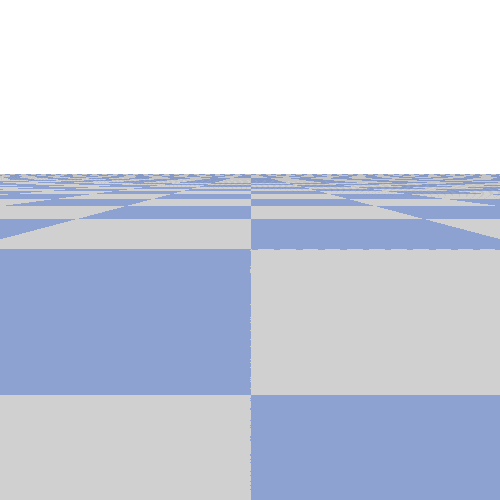

rgba shape=(500, 500, 4), dtype=uint8


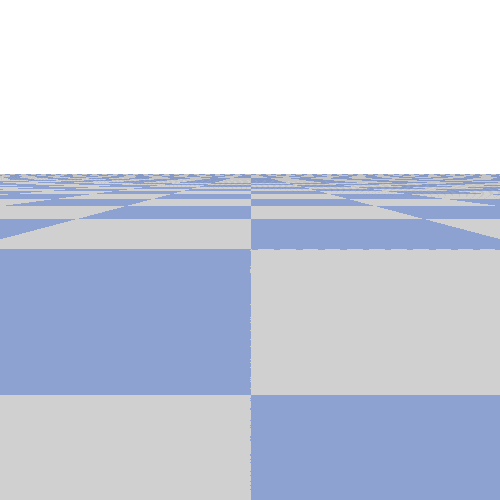

rgba shape=(500, 500, 4), dtype=uint8


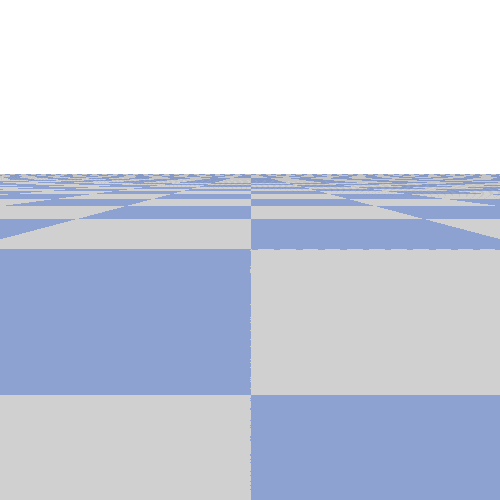

rgba shape=(500, 500, 4), dtype=uint8


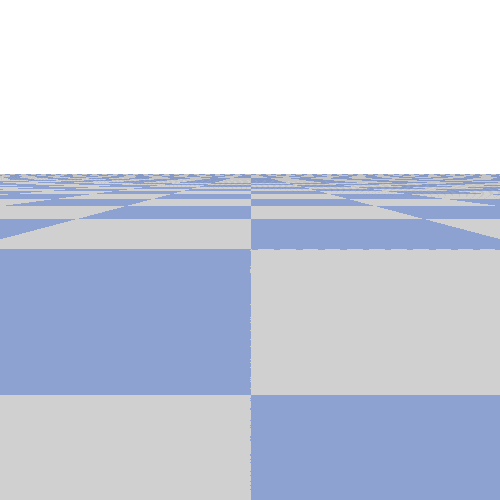

rgba shape=(500, 500, 4), dtype=uint8


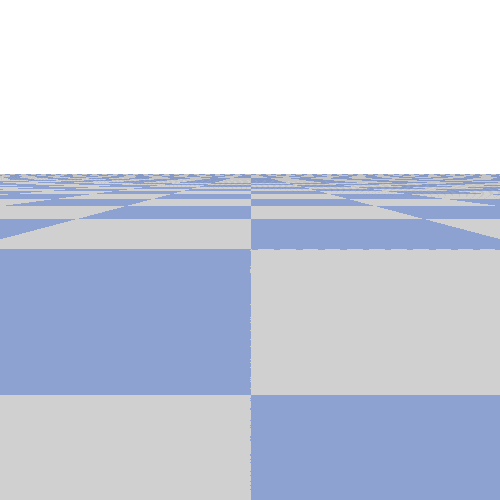

rgba shape=(500, 500, 4), dtype=uint8


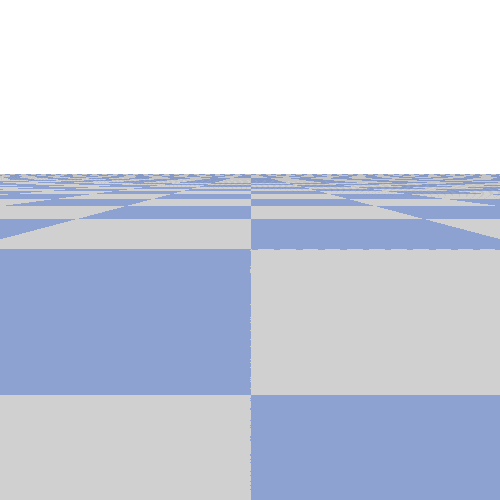

rgba shape=(500, 500, 4), dtype=uint8


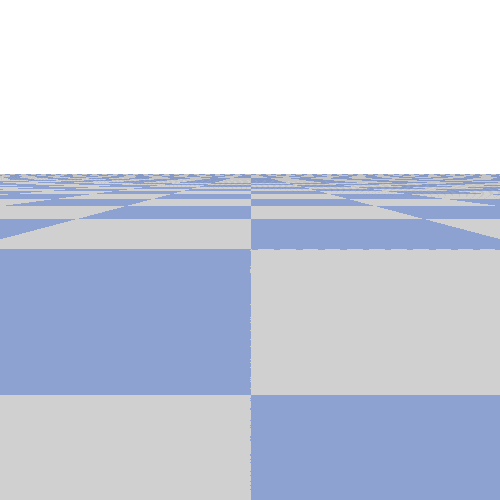

rgba shape=(500, 500, 4), dtype=uint8


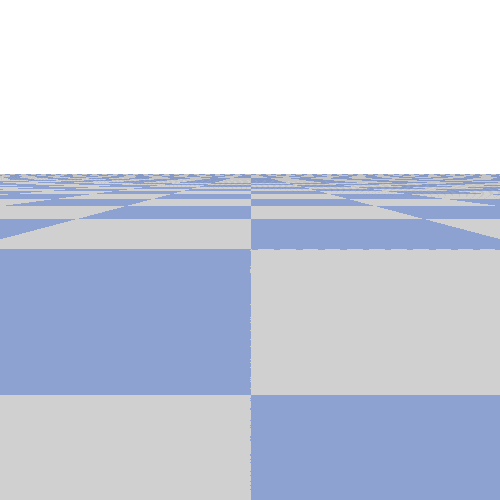

rgba shape=(500, 500, 4), dtype=uint8


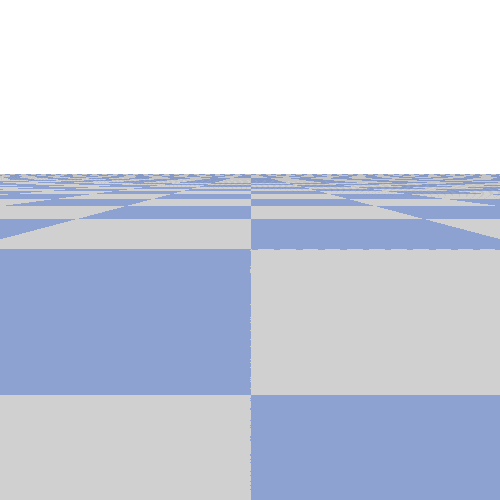

rgba shape=(500, 500, 4), dtype=uint8


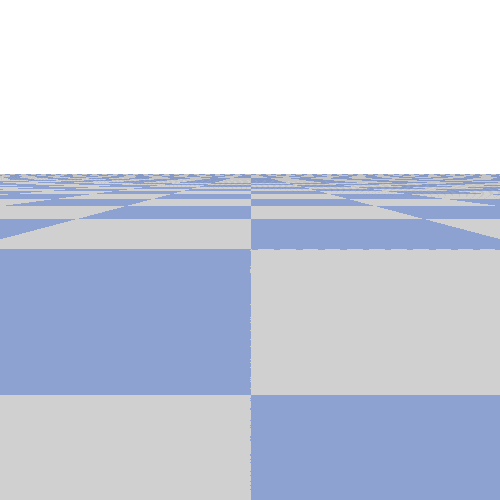

rgba shape=(500, 500, 4), dtype=uint8


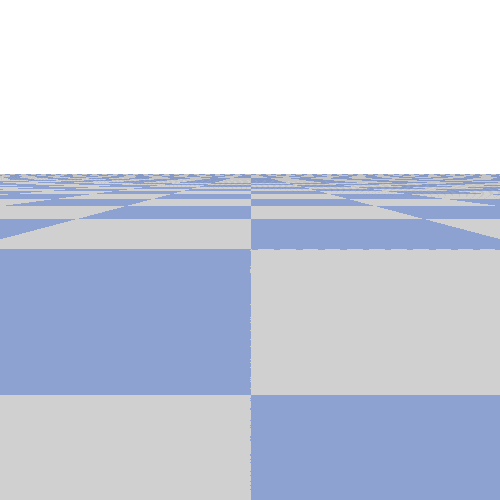

rgba shape=(500, 500, 4), dtype=uint8


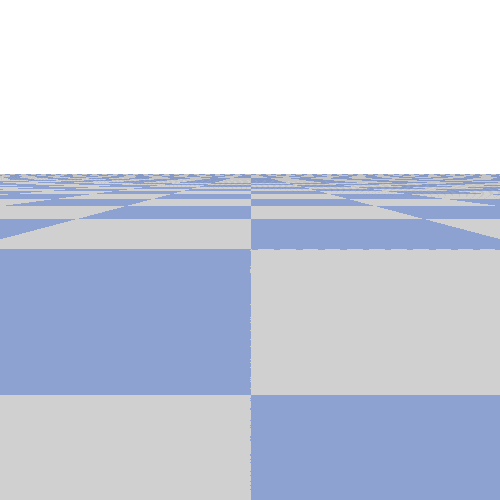

rgba shape=(500, 500, 4), dtype=uint8


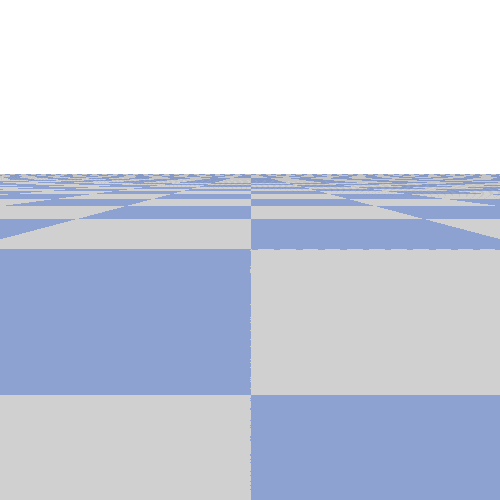

rgba shape=(500, 500, 4), dtype=uint8


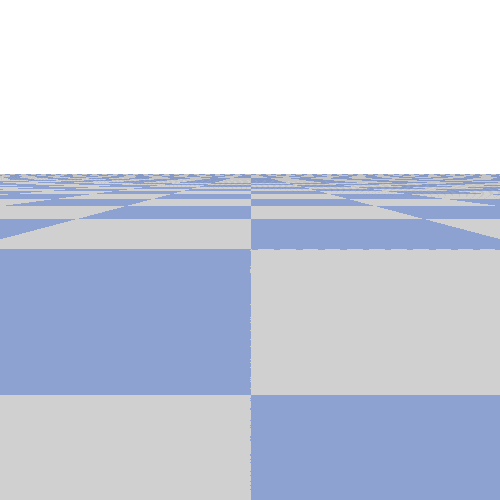

rgba shape=(500, 500, 4), dtype=uint8


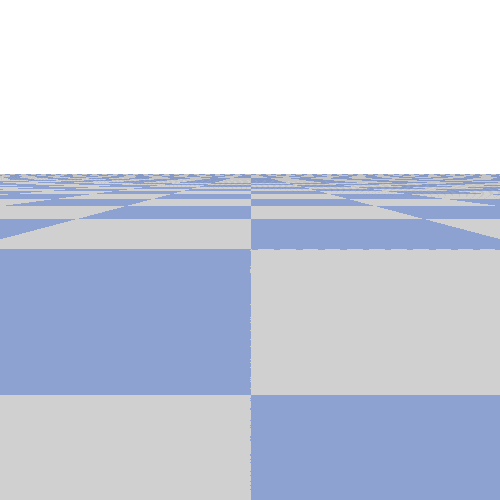

rgba shape=(500, 500, 4), dtype=uint8


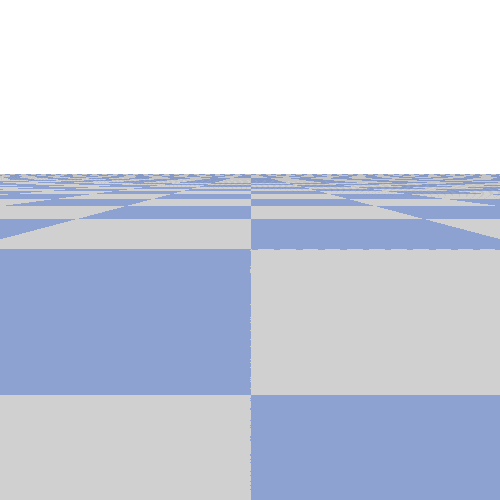

rgba shape=(500, 500, 4), dtype=uint8


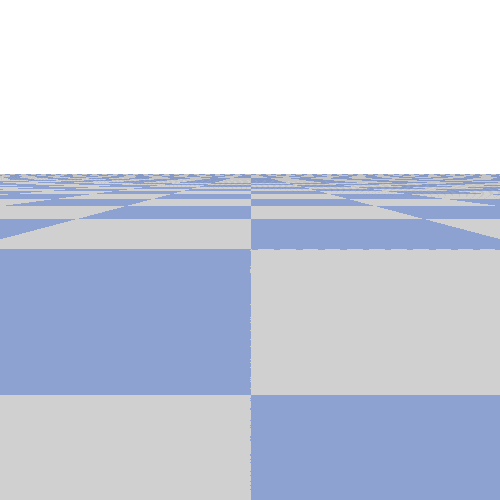

rgba shape=(500, 500, 4), dtype=uint8


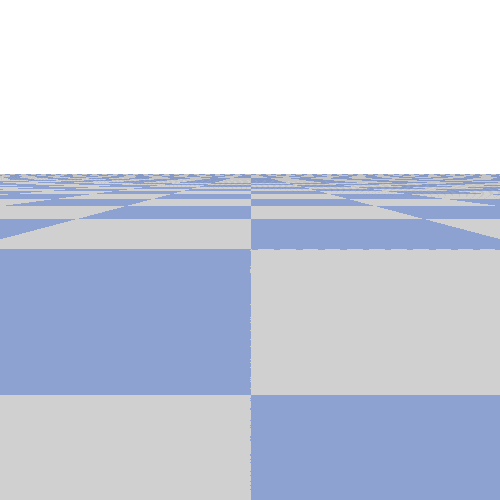

rgba shape=(500, 500, 4), dtype=uint8


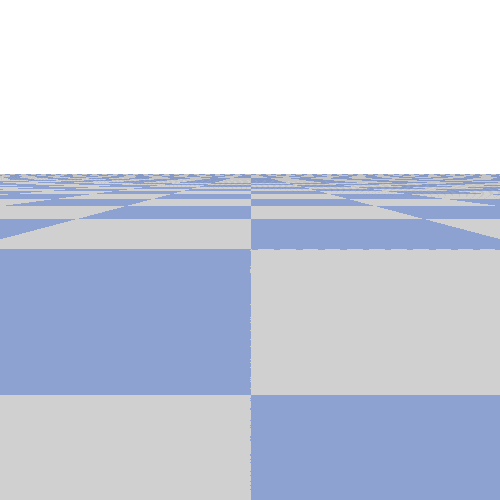

rgba shape=(500, 500, 4), dtype=uint8


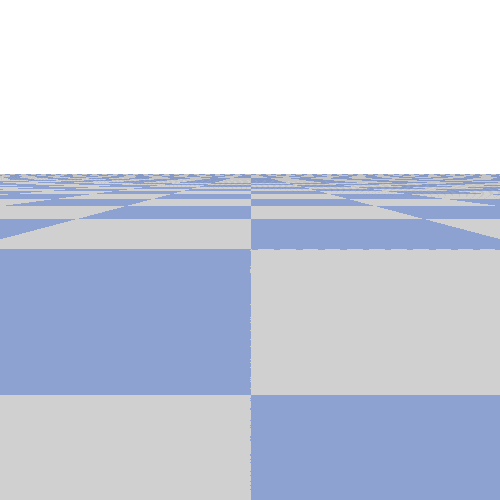

rgba shape=(500, 500, 4), dtype=uint8


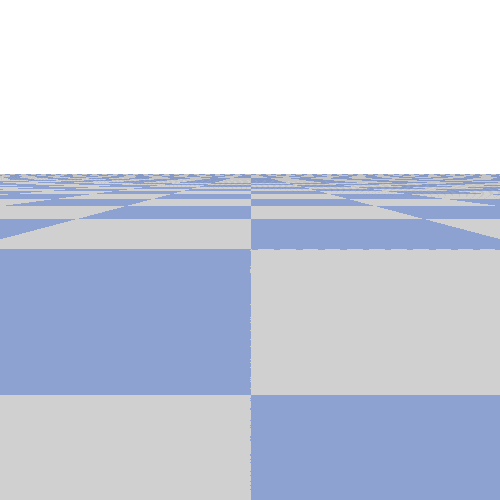

rgba shape=(500, 500, 4), dtype=uint8


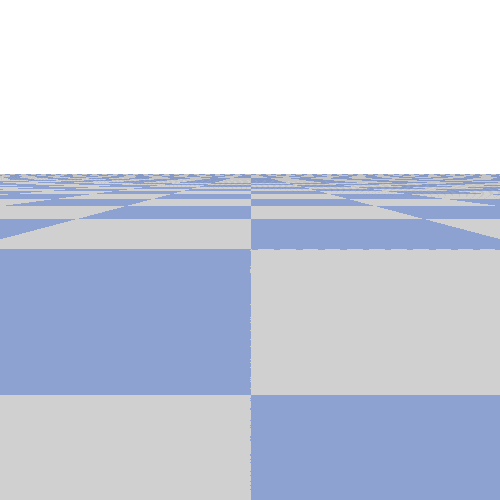

rgba shape=(500, 500, 4), dtype=uint8


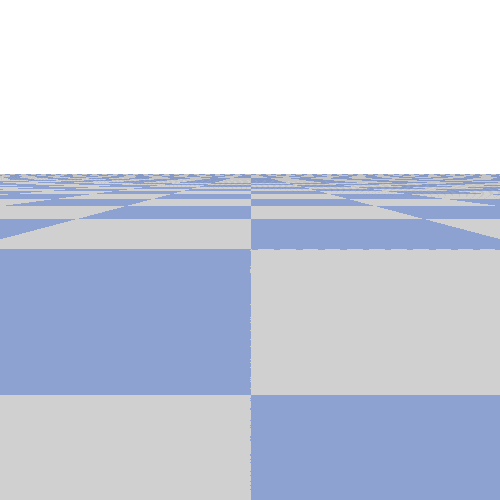

rgba shape=(500, 500, 4), dtype=uint8


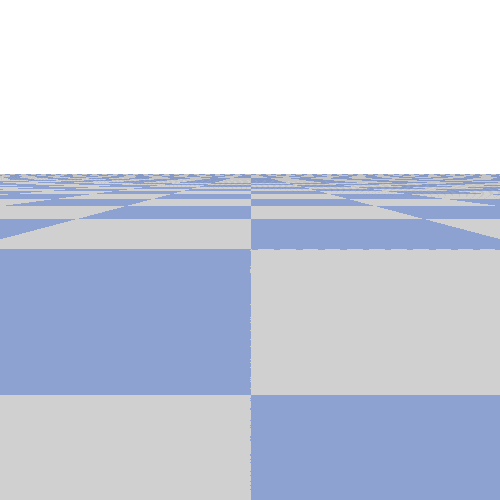

rgba shape=(500, 500, 4), dtype=uint8


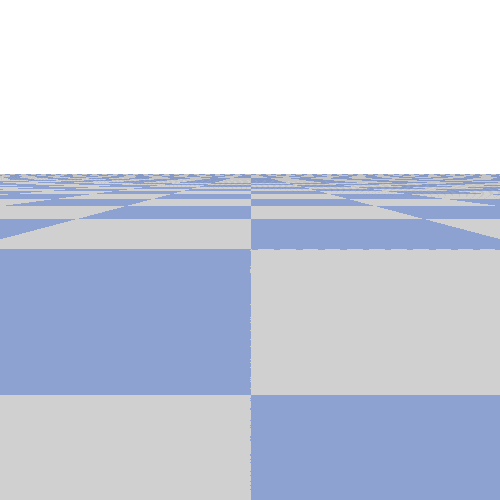

rgba shape=(500, 500, 4), dtype=uint8


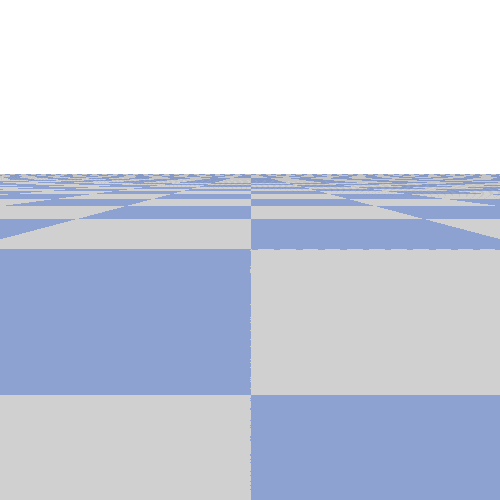

rgba shape=(500, 500, 4), dtype=uint8


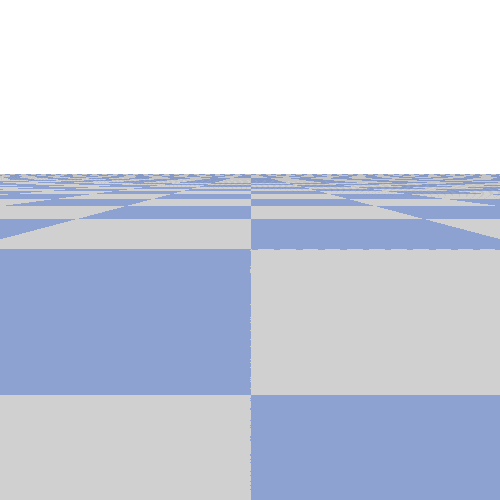

rgba shape=(500, 500, 4), dtype=uint8


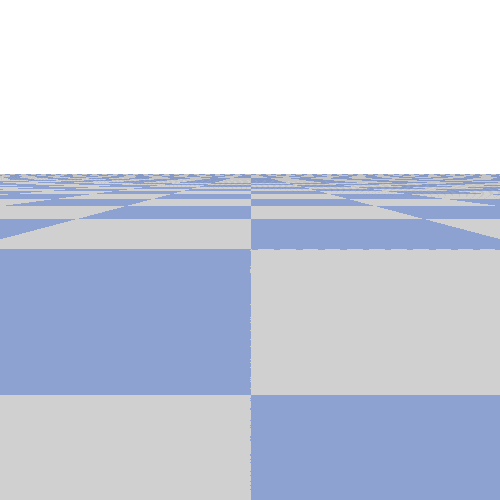

rgba shape=(500, 500, 4), dtype=uint8


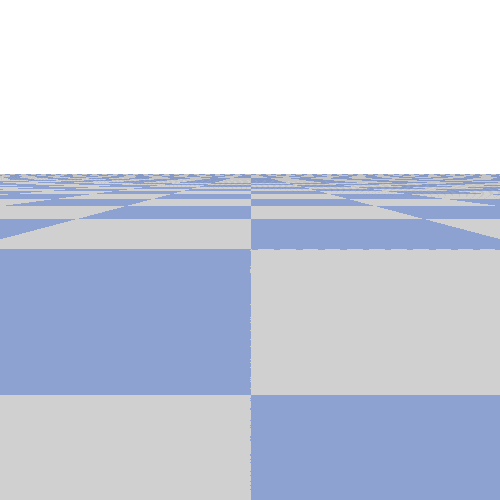

rgba shape=(500, 500, 4), dtype=uint8


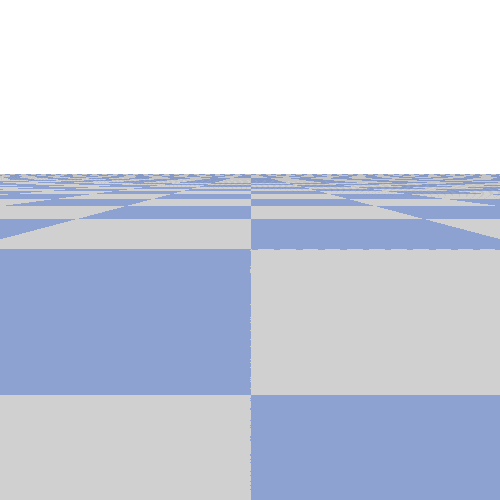

rgba shape=(500, 500, 4), dtype=uint8


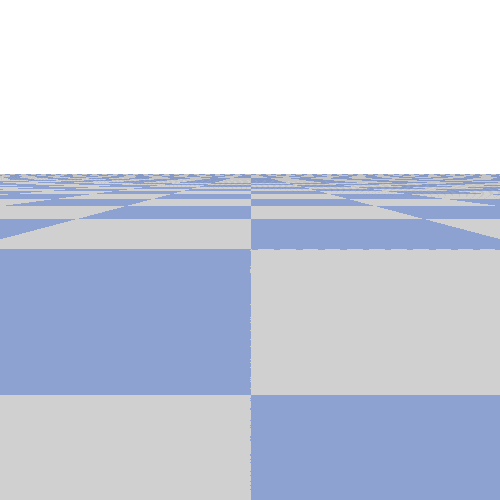

rgba shape=(500, 500, 4), dtype=uint8


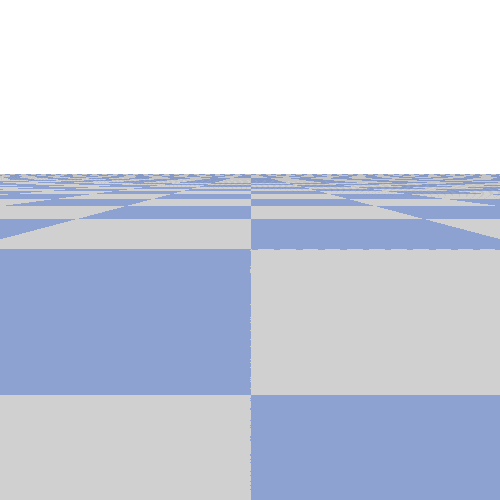

rgba shape=(500, 500, 4), dtype=uint8


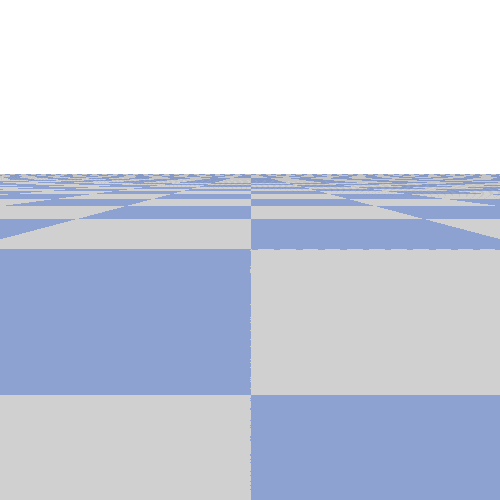

rgba shape=(500, 500, 4), dtype=uint8


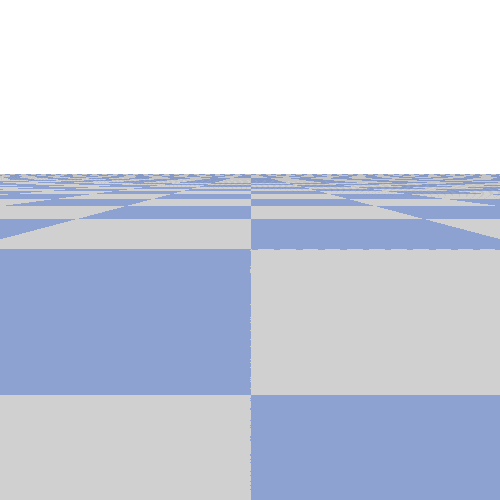

rgba shape=(500, 500, 4), dtype=uint8


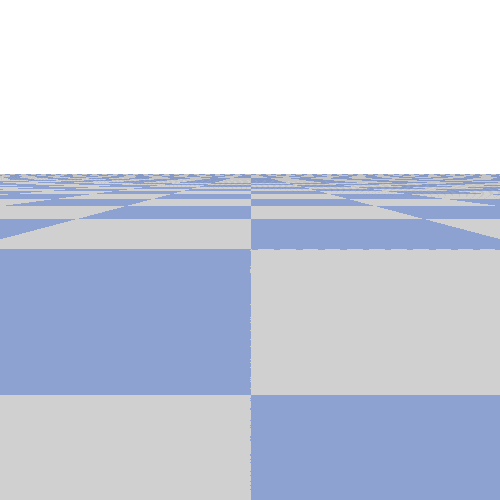

rgba shape=(500, 500, 4), dtype=uint8


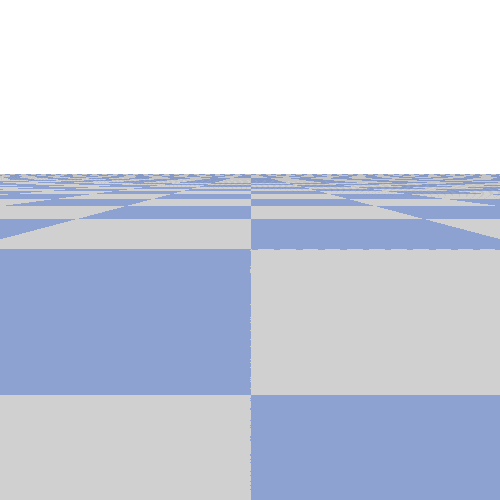

rgba shape=(500, 500, 4), dtype=uint8


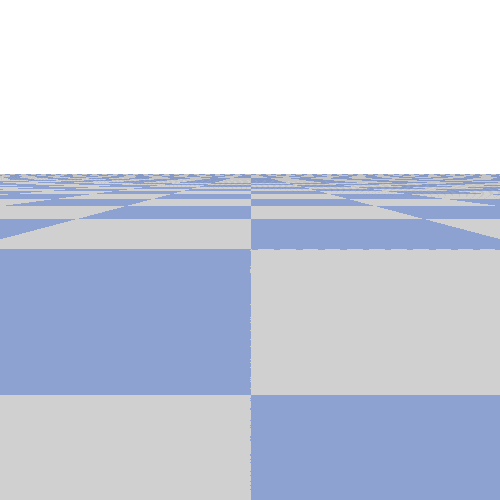

rgba shape=(500, 500, 4), dtype=uint8


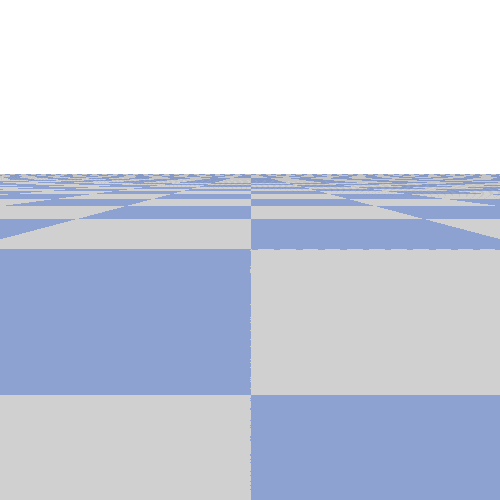

In [21]:
#test
old_state=myRobot.resetEnvironment()
new_rewards=[]
epsilon=1
steps=100
time.sleep(0.5)
for i in range(steps):
    try :
        action = epsilon_greedy(Q_table ,epsilon , 9 , old_state) 
        new_state, reward = myRobot.step(action)
        new_rewards.append(reward)
        old_state=new_state
    except: print("angle read failure")


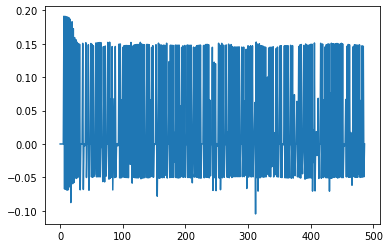

In [12]:
plt.plot(total_rewards)

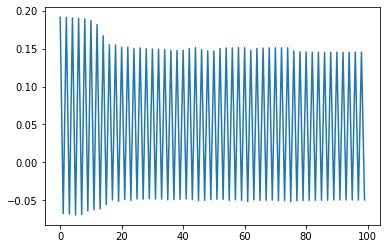

In [13]:
plt.plot(new_rewards)

(array([  3., 182.,  15.,  94.,   7.,  13.,   3.,   3., 159.,   8.]),
 array([-0.10476645, -0.075153  , -0.04553955, -0.01592609,  0.01368736,
         0.04330081,  0.07291427,  0.10252772,  0.13214117,  0.16175463,
         0.19136808]),
 <BarContainer object of 10 artists>)

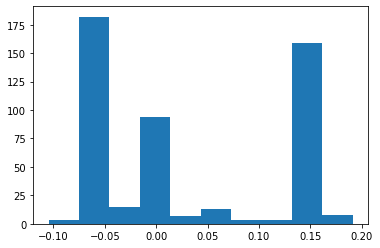

In [14]:
plt.hist(total_rewards)

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 42.,  8.]),
 array([-0.06921944, -0.04316232, -0.01710521,  0.00895191,  0.03500902,
         0.06106613,  0.08712325,  0.11318036,  0.13923748,  0.16529459,
         0.19135171]),
 <BarContainer object of 10 artists>)

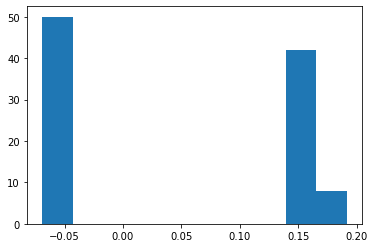

In [15]:
plt.hist(new_rewards)